In [18]:
import os
import glob
import pylab as pl

from caiman.source_extraction.cnmf.cnmf import load_CNMF


In [19]:
%matplotlib notebook

# Select 1 dataset experiment

In [858]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC084'
session = '20190525' #'20190522' #'20190505_JC083'
session_dir = os.path.join(rootdir, animalid, session)

fov = 'FOV1_zoom2p0x'
exp = 'gratings' #'retino_run2'
dataid = '|'.join([animalid, session, fov, exp])

print("*** Dataset: %s ***" % dataid)

*** Dataset: JC084|20190525|FOV1_zoom2p0x|gratings ***


#### Load CaImAn-extracted traces

In [859]:
results_dir = os.path.join(session_dir, fov, 'caiman_results', exp)
glob.glob(os.path.join(results_dir, '*_results.hdf5'))

['/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/JC084-20190525-FOV1_zoom2p0x-gratings-downsample-5_results.hdf5',
 '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/seed-cnm_JC084-20190525-FOV1_zoom2p0x-gratings-downsample-5_results.hdf5',
 '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/seed-cnm_seeded-JC084-20190525-FOV1_zoom2p0x-gratings-downsample-5_results.hdf5',
 '/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/seed-cnm_seeded-gratings-downsample-1_results.hdf5']

In [860]:
results_fpath = results_dir = glob.glob(os.path.join(results_dir, '*_results.hdf5'))[-1]


print(results_fpath)
cnm = load_CNMF(results_fpath, n_processes=2)
cnm.estimates.A.shape

/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/caiman_results/gratings/seed-cnm_seeded-gratings-downsample-1_results.hdf5


/home/julianarhee/anaconda2/envs/caiman/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(262144, 238)

In [861]:
import h5py
import re
import json
import traceback 
import copy

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import stats
import matplotlib.patches as patches   

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


In [862]:

def get_frame_info(run_dir):
    si_info = {}

    run = os.path.split(run_dir)[-1]
    runinfo_path = os.path.join(run_dir, '%s.json' % run)
    with open(runinfo_path, 'r') as fr:
        runinfo = json.load(fr)
    nfiles = runinfo['ntiffs']
    file_names = sorted(['File%03d' % int(f+1) for f in range(nfiles)], key=natural_keys)

    # Get frame_idxs -- these are FRAME indices in the current .tif file, i.e.,
    # removed flyback frames and discard frames at the top and bottom of the
    # volume should not be included in the indices...
    frame_idxs = runinfo['frame_idxs']
    if len(frame_idxs) > 0:
        print("Found %i frames from flyback correction." % len(frame_idxs))
    else:
        frame_idxs = np.arange(0, runinfo['nvolumes'] * len(runinfo['slices']))

    ntiffs = runinfo['ntiffs']
    file_names = sorted(['File%03d' % int(f+1) for f in range(ntiffs)], key=natural_keys)
    volumerate = runinfo['volume_rate']
    framerate = runinfo['frame_rate']
    nvolumes = runinfo['nvolumes']
    nslices = int(len(runinfo['slices']))
    nchannels = runinfo['nchannels']
    nslices_full = int(round(runinfo['frame_rate']/runinfo['volume_rate']))
    nframes_per_file = nslices_full * nvolumes

    # =============================================================================
    # Get VOLUME indices to assign frame numbers to volumes:
    # =============================================================================
    vol_idxs_file = np.empty((nvolumes*nslices_full,))
    vcounter = 0
    for v in range(nvolumes):
        vol_idxs_file[vcounter:vcounter+nslices_full] = np.ones((nslices_full, )) * v
        vcounter += nslices_full
    vol_idxs_file = [int(v) for v in vol_idxs_file]

    vol_idxs = []
    vol_idxs.extend(np.array(vol_idxs_file) + nvolumes*tiffnum for tiffnum in range(nfiles))
    vol_idxs = np.array(sorted(np.concatenate(vol_idxs).ravel()))

    all_frames_tsecs = runinfo['frame_tstamps_sec']
    si_info['nslices_full'] = nslices_full
    si_info['nframes_per_file'] = nframes_per_file
    si_info['vol_idxs'] = vol_idxs
    si_info['vol_idxs_file'] = np.array(vol_idxs_file)
    si_info['volumerate'] = volumerate
    si_info['framerate'] = framerate
    si_info['nslices'] = nslices
    si_info['nchannels'] = nchannels
    if nchannels==2:
        all_frames_tsecs = np.array(all_frames_tsecs[0::2])
        
    si_info['ntiffs'] = ntiffs
    si_info['frames_tsec'] = all_frames_tsecs #runinfo['frame_tstamps_sec']
    si_info['nvolumes'] = nvolumes

    return si_info


In [863]:

def frames_to_trials(curr_rundir, trials_in_block, file_ix, frame_shift=0,
                     frame_ixs=None, verbose=False):

#     curr_rundir = parsed_frames_fpath.split('/paradigm')[0]
#     with open(os.path.join(rundir, 'paradigm', 'stimulus_configs.json'), 'r') as s:
#         stimconfigs = json.load(s)
    parsed_frames_fpath = glob.glob(os.path.join(curr_rundir, 'paradigm', 'parsed_frames_*.hdf5'))[0]
    
    si = get_frame_info(curr_rundir)
    all_frames_tsecs = np.array(si['frames_tsec']) # Corrected frame tstamps (single-channel)
    if verbose:
        print("N tsecs:", len(all_frames_tsecs))
    vol_ixs = si['vol_idxs'] # Volume indices to assign frame numbers to volumes (across all tifs)
    vol_ixs_tif = si['vol_idxs_file']

    try:
        parsed_frames = h5py.File(parsed_frames_fpath, 'r')

        # Get trial list across all tif files
        trial_list = sorted(parsed_frames.keys(), key=natural_keys)
        if file_ix==0:
            print("... getting ixs for %i of %i total trials across all .tif files." % (len(trials_in_block), len(trial_list)))

        # Check if frame indices are indexed relative to full run (all .tif files) or within-tif (i.e., a "block")
        block_indexed = all([all(parsed_frames[t]['frames_in_run'][:] == parsed_frames[t]['frames_in_file'][:])\
                             for t in trial_list]) is False

        # Calculate trial epochs in frames (assumes all trials have same structure)
        min_frame_interval = 1
        nframes_pre = int(round(parsed_frames['trial00001']['frames_in_run'].attrs['baseline_dur_sec'] * si['volumerate']))
        nframes_post = int(round(parsed_frames['trial00001']['frames_in_run'].attrs['iti_dur_sec'] * si['volumerate']))
        nframes_on = int(round(parsed_frames['trial00001']['frames_in_run'].attrs['stim_dur_sec'] * si['volumerate']))
        nframes_per_trial = nframes_pre + nframes_on + nframes_post 
    
        # Get all frame indices for trial epochs (if there are overlapping frame indices, there will be repeats)    
        all_frames_in_trials = np.hstack([np.array(parsed_frames[t]['frames_in_file']) \
                                   for t in trials_in_block])
        if verbose:
            print("... N frames to align:", len(all_frames_in_trials))
            print("... N unique frames:", len(np.unique(all_frames_in_trials)))
        stim_onset_idxs = np.array([parsed_frames[t]['frames_in_file'].attrs['stim_on_idx'] \
                                    for t in trials_in_block])
    
        # Adjust frame indices to match within-file, rather than across-files, indices
        if block_indexed is False:
            all_frames_in_trials = all_frames_in_trials - len(all_frames_tsecs)*file_ix - frame_shift  
            if all_frames_in_trials[-1] >= len(all_frames_tsecs):
                print("... File: %i (has %i frames)" % (file_ix, len(all_frames_tsecs)))
                print("... asking for %i extra frames..." % (all_frames_in_trials[-1] - len(all_frames_tsecs)))
            stim_onset_idxs = stim_onset_idxs - len(all_frames_tsecs)*file_ix - frame_shift 
        if verbose:
            print("... Last frame to align: %i (N frames total, %i)" % (all_frames_in_trials[-1], len(all_frames_tsecs)))
    
        stim_onset_idxs_adjusted = vol_ixs_tif[stim_onset_idxs]
        stim_onset_idxs = copy.copy(stim_onset_idxs_adjusted)
        varying_stim_dur=False
        trial_frames_to_vols = dict((t, []) for t in trials_in_block)
        for t in trials_in_block: 
            frames_to_vols = parsed_frames[t]['frames_in_file'][:] 
            frames_to_vols = frames_to_vols - len(all_frames_tsecs)*file_ix - frame_shift  
            actual_frames_in_trial = [i for i in frames_to_vols if i < len(vol_ixs_tif)]
            trial_vol_ixs = np.empty(frames_to_vols.shape, dtype=int)
            trial_vol_ixs[0:len(actual_frames_in_trial)] = vol_ixs_tif[actual_frames_in_trial]
            if varying_stim_dur is False:
                trial_vol_ixs = trial_vol_ixs[0:nframes_per_trial]
            trial_frames_to_vols[t] = np.array(trial_vol_ixs)

    except Exception as e:
        traceback.print_exc()
    finally:
        parsed_frames.close()
            
    #%
    # Convert frame-reference to volume-reference. Only select first frame for each volume.
    # Only relevant for multi-plane. Don't take unique values, since stim period of trial N 
    # can be ITI of trial N-1
    actual_frames = [i for i in all_frames_in_trials if i < len(vol_ixs_tif)]
    frames_in_trials = vol_ixs_tif[actual_frames]
    
    # Turn frame_tsecs into RELATIVE tstamps (to stim onset):
    # ------------------------------------------------
    first_plane_tstamps = all_frames_tsecs[np.array(frame_ixs)]
    trial_tstamps = first_plane_tstamps[frames_in_trials[0:len(actual_frames)]] #all_frames_tsecs[frames_in_trials] #indices]  

    # Check whether we are asking for more frames than there are unique, and pad array if so
    if len(trial_tstamps) < len(all_frames_in_trials): #len(frames_in_trials):
        print("... padding trial tstamps array... (should be %i)" % len(all_frames_in_trials))
        trial_tstamps = np.pad(trial_tstamps, (0, len(all_frames_in_trials)-len(trial_tstamps)), mode='constant', constant_values=np.nan)
        frames_in_trials = np.pad(frames_in_trials, (0, len(all_frames_in_trials)-len(frames_in_trials)), mode='constant', constant_values=np.nan)

    # All trials have the same structure:
    reformat_tstamps = False
    if verbose:
        print("N frames per trial:", nframes_per_trial)
        print("N tstamps:", len(trial_tstamps))
        print("N trials in block:", len(trials_in_block))
    try: 
        tsec_mat = np.reshape(trial_tstamps, (len(trials_in_block), nframes_per_trial))
        # Subtract stim_on tstamp from each frame of each trial to get relative tstamp:
        tsec_mat -= np.tile(all_frames_tsecs[stim_onset_idxs].T, (tsec_mat.shape[1], 1)).T
        
    except Exception as e: #ValueError:
        traceback.print_exc()
#        reformat_tstamps = True

    x, y = np.where(tsec_mat==0)
    assert len(list(set(y)))==1, "Incorrect stim onset alignment: %s" % str(list(set(y)))
       
    relative_tsecs = np.reshape(tsec_mat, (len(trials_in_block)*nframes_per_trial, ))

    # Convert frames_in_file to volume idxs:
    trial_frames_to_vols = pd.DataFrame(trial_frames_to_vols)

    return trial_frames_to_vols, relative_tsecs


#### Load manual data

In [864]:
manualdir = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_%s_static' % exp,
                     'traces', '%s*' % traceid, 'data_arrays'))[0]

dset = np.load(os.path.join(manualdir, 'np_subtracted.npz'), encoding='latin1', allow_pickle=True)
manual = pd.DataFrame(dset['data'][:])
print(manual.shape)

(113920, 238)


#### Stimulus configs

In [865]:
sdf = pd.DataFrame(dset['sconfigs'][()]).T
sdf.head()

aspect direction luminance ori position   sf size speed  stimtype  \
config007      1         0      None   0  (20, 0)  0.5   30    10  gratings   
config006      1         0      None   0  (20, 0)  0.1   30    20  gratings   
config005      1         0      None   0  (20, 0)  0.1   30    10  gratings   
config004      1         0      None   0   (0, 0)  0.5  200    20  gratings   
config003      1         0      None   0   (0, 0)  0.5  200    10  gratings   

          xpos ypos  
config007   20    0  
config006   20    0  
config005   20    0  
config004    0    0  
config003    0    0

In [866]:
import itertools

In [867]:
plot_params = {'hue': 'sf',
               'rows': ['size', 'speed'],
               'cols': 'ori'}




In [868]:
all_plot_params=[]
for p in plot_params.values():
    if isinstance(p, list):
        all_plot_params.extend(p)
    else:
        all_plot_params.append(p)
all_plot_params

['sf', 'size', 'speed', 'ori']

In [869]:
combined_params = ['_'.join(v) for k, v in plot_params.items() if isinstance(v, list)]
for p in combined_params:
    sdf[p] = ['_'.join([str(c) for c in list(combo[0])]) for combo in list(zip(sdf[p.split('_')].values))]
sdf.head()

aspect direction luminance ori position   sf size speed  stimtype  \
config007      1         0      None   0  (20, 0)  0.5   30    10  gratings   
config006      1         0      None   0  (20, 0)  0.1   30    20  gratings   
config005      1         0      None   0  (20, 0)  0.1   30    10  gratings   
config004      1         0      None   0   (0, 0)  0.5  200    20  gratings   
config003      1         0      None   0   (0, 0)  0.5  200    10  gratings   

          xpos ypos size_speed  
config007   20    0    30.0_10  
config006   20    0    30.0_20  
config005   20    0    30.0_10  
config004    0    0   200.0_20  
config003    0    0   200.0_10

#### Frame labels 

In [870]:
labels = pd.DataFrame(dset['labels_data'], columns=dset['labels_columns'])
labels.columns = [x.decode("utf-8") for x in labels.columns]
labels.head()
print(labels.shape)

(113920, 8)


In [871]:
labels_c = labels.copy()

In [872]:
for p in plot_params.values():
    if isinstance(p, list):
        for pp in p:
            labels_c[pp] = [sdf[pp][cfg] for cfg in labels['config']]
    else:
        labels_c[p] = [sdf[p][cfg] for cfg in labels['config']]
                        
             

In [873]:
# combine string params
for k, v in plot_params.items():
    if isinstance(v, list):
        plot_params[k] = '_'.join(v)

In [874]:
plot_params

{'hue': 'sf', 'rows': 'size_speed', 'cols': 'ori'}

In [875]:
ylabel = 'trace'
palette = 'colorblind' 

# Align CaImAn traces

In [876]:
# Get run, tif num, and file path for extracted raw arrays
traceid = 'traces001'
runpaths = sorted(glob.glob(os.path.join(rootdir, animalid, session, fov, '*%s_*' % exp,
                                         'traces', '%s*' % traceid, 'files')), key=natural_keys)
rawfns = [(run_ix, file_ix, fn) for run_ix, rpath in enumerate(sorted(runpaths, key=natural_keys))
          for file_ix, fn in enumerate(sorted(glob.glob(os.path.join(rpath, '*.hdf5')), key=natural_keys))]
print("Found raw tif arrays for %i files" % len(raw_fpaths))


Found raw tif arrays for 31 files


In [877]:
tframes = {}
for total_ix, (run_ix, file_ix, fpath) in enumerate(rawfns):
    rfile = h5py.File(fpath, 'r')
    fdata = rfile['Slice01']
    frames_to_select = pd.DataFrame(fdata['frames_indices'][:])
    frame_ixs = np.array(frames_to_select[0].values) 

    # Get MW info
    curr_rundir = runpaths[run_ix].split('/traces')[0]
    mw_fpath = glob.glob(os.path.join(rundir, 'paradigm', 'trials_*.json'))[0]
    with open(mw_fpath, 'r') as f:
        mwinfo = json.load(f)
    trials_in_block = sorted([t for t, mdict in mwinfo.items() if mdict['block_idx']==file_ix and mdict['stimuli']['type'] != 'blank'], key=natural_keys)
    frame_shift = 0 if 'block_frame_offset' not in mwinfo[trials_in_block[0]].keys() else mwinfo[trials_in_block[0]]['block_frame_offset']

    # Get frame indices
    print("Run %i (File %i) - %s" % (int(run_ix+1), int(file_ix+1), trials_in_block[0]))
    
    trial_frames_to_vols, relative_tsecs = frames_to_trials(curr_rundir, trials_in_block, file_ix,     
                                                            frame_shift=frame_shift, frame_ixs=frame_ixs)
    
    tframes[total_ix] = trial_frames_to_vols
    

Run 1 (File 1) - trial00001
... getting ixs for 40 of 320 total trials across all .tif files.
Run 1 (File 2) - trial00041
Run 1 (File 3) - trial00081
Run 1 (File 4) - trial00121
Run 1 (File 5) - trial00161
Run 1 (File 6) - trial00201
Run 1 (File 7) - trial00241
Run 1 (File 8) - trial00281
Run 2 (File 1) - trial00001
... getting ixs for 40 of 320 total trials across all .tif files.
Run 2 (File 2) - trial00041
Run 2 (File 3) - trial00081
Run 2 (File 4) - trial00121
Run 2 (File 5) - trial00161
Run 2 (File 6) - trial00201
Run 2 (File 7) - trial00241
Run 2 (File 8) - trial00281
Run 3 (File 1) - trial00001
... getting ixs for 40 of 320 total trials across all .tif files.
Run 3 (File 2) - trial00041
Run 3 (File 3) - trial00081
Run 3 (File 4) - trial00121
Run 3 (File 5) - trial00161
Run 3 (File 6) - trial00201
Run 3 (File 7) - trial00241
Run 3 (File 8) - trial00281
Run 4 (File 1) - trial00001
... getting ixs for 40 of 320 total trials across all .tif files.
Run 4 (File 2) - trial00041
Run 4 (F

#### Compare with manual

#### Plot 1 roi

In [911]:
trace_type = 'deconvolved'

In [913]:
if trace_type == 'denoised':
    extracted_traces = copy.copy(cnm.estimates.C) #+  cnm.estimates.YrA
elif trace_type == 'deconvolved':
    extracted_traces = copy.copy(cnm.estimates.S) #+  cnm.estimates.YrA
else:
    print("Unrecognized trace type: %s" % trace_type)
nrois, T = extracted_traces.shape
nfiles = len(tframes.keys())
nframes_per_file = int(T/float(nfiles))
print("%i frames per file (%i files)." % (nframes_per_file, nfiles))
print(extracted_traces.shape)


4610 frames per file (32 files).
(238, 147520)


In [914]:
rid = 46

In [915]:
trace_array = extracted_traces[rid, :].reshape(nfiles, nframes_per_file, order='C')
trace_array.shape


(32, 4610)

In [916]:

# for fi, ixs in sorted(tframes.items(), key=lambda x: x[0]):
#     print(fi, trace_array[fi, np.hstack(ixs.values.T)].shape)
    
all_frames = np.hstack(np.array([trace_array[fi, np.hstack(ixs.values.T)]\
                        for fi, ixs in sorted(tframes.items(), key=lambda x: x[0])]))
all_frames.shape



(113920,)

<IPython.core.display.Javascript object>


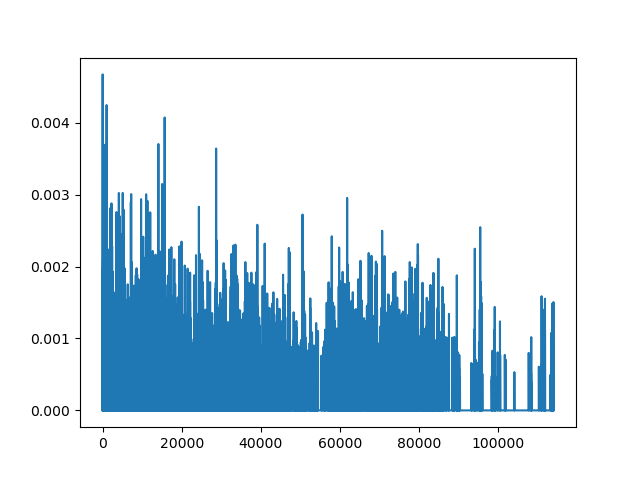

In [917]:
pl.figure()
pl.plot(all_frames)

<IPython.core.display.Javascript object>


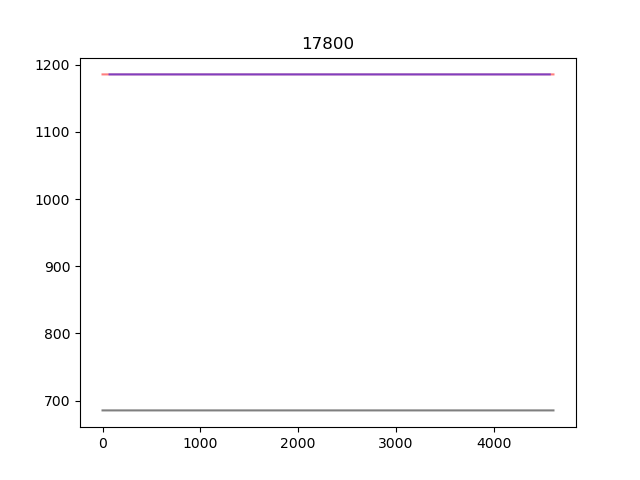

In [809]:
# pl.figure()
# #pl.plot(manual[20], 'k')
# #pl.plot(all_frames[0:5000], 'r')

# block=5
# pl.plot(extracted_traces[rid, block, 0:4610], 'k', alpha=0.5)
# pl.plot(trace_array[block, :]+500, 'r', alpha=0.5)

# frameixs = tframes[block].values.T.ravel()
# strt = 3560 * block
# pl.title(strt)
# pl.plot(frameixs, all_frames[strt:strt+len(frameixs)]+500, 'b', alpha=0.5)


In [918]:
manualdir.split('/data_arrays')[0]

'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e97cee_traces001_de9460_traces001_1f6b5f_traces001_70217b'

In [919]:
psth_dir = os.path.join(manualdir.split('/data_arrays')[0], 'figures', 'psth_caiman_%s' % trace_type)
if not os.path.exists(psth_dir):
    os.makedirs(psth_dir)

In [920]:
stim_on = labels_c['stim_on_frame'].unique()[0]
nframes_on = labels_c['nframes_on'].unique()[0]     

In [921]:
rdata = labels_c.copy()
rdata['trace'] = all_frames #manual[rid]


In [922]:
meandfs = []
for k, g in rdata.groupby(['config']):
    mean_trace = g.groupby(['trial'])[ylabel].apply(np.array).mean(axis=0)
    mean_tsec = g.groupby(['trial'])['tsec'].apply(np.array).mean(axis=0)
    sem_trace = stats.sem(np.vstack(g.groupby(['trial'])[ylabel].apply(np.array)), axis=0)
    mdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': mean_tsec,
                        'sem': sem_trace,
                        'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'config': [k for _ in range(len(mean_trace))]})
    for p in plot_params.values():
        mdf[p] = [round(sdf[p][cfg], 1) if isinstance(sdf[p][cfg], (float)) else sdf[p][cfg] for cfg in mdf['config']]
    meandfs.append(mdf)

meandfs = pd.concat(meandfs, axis=0)

<IPython.core.display.Javascript object>


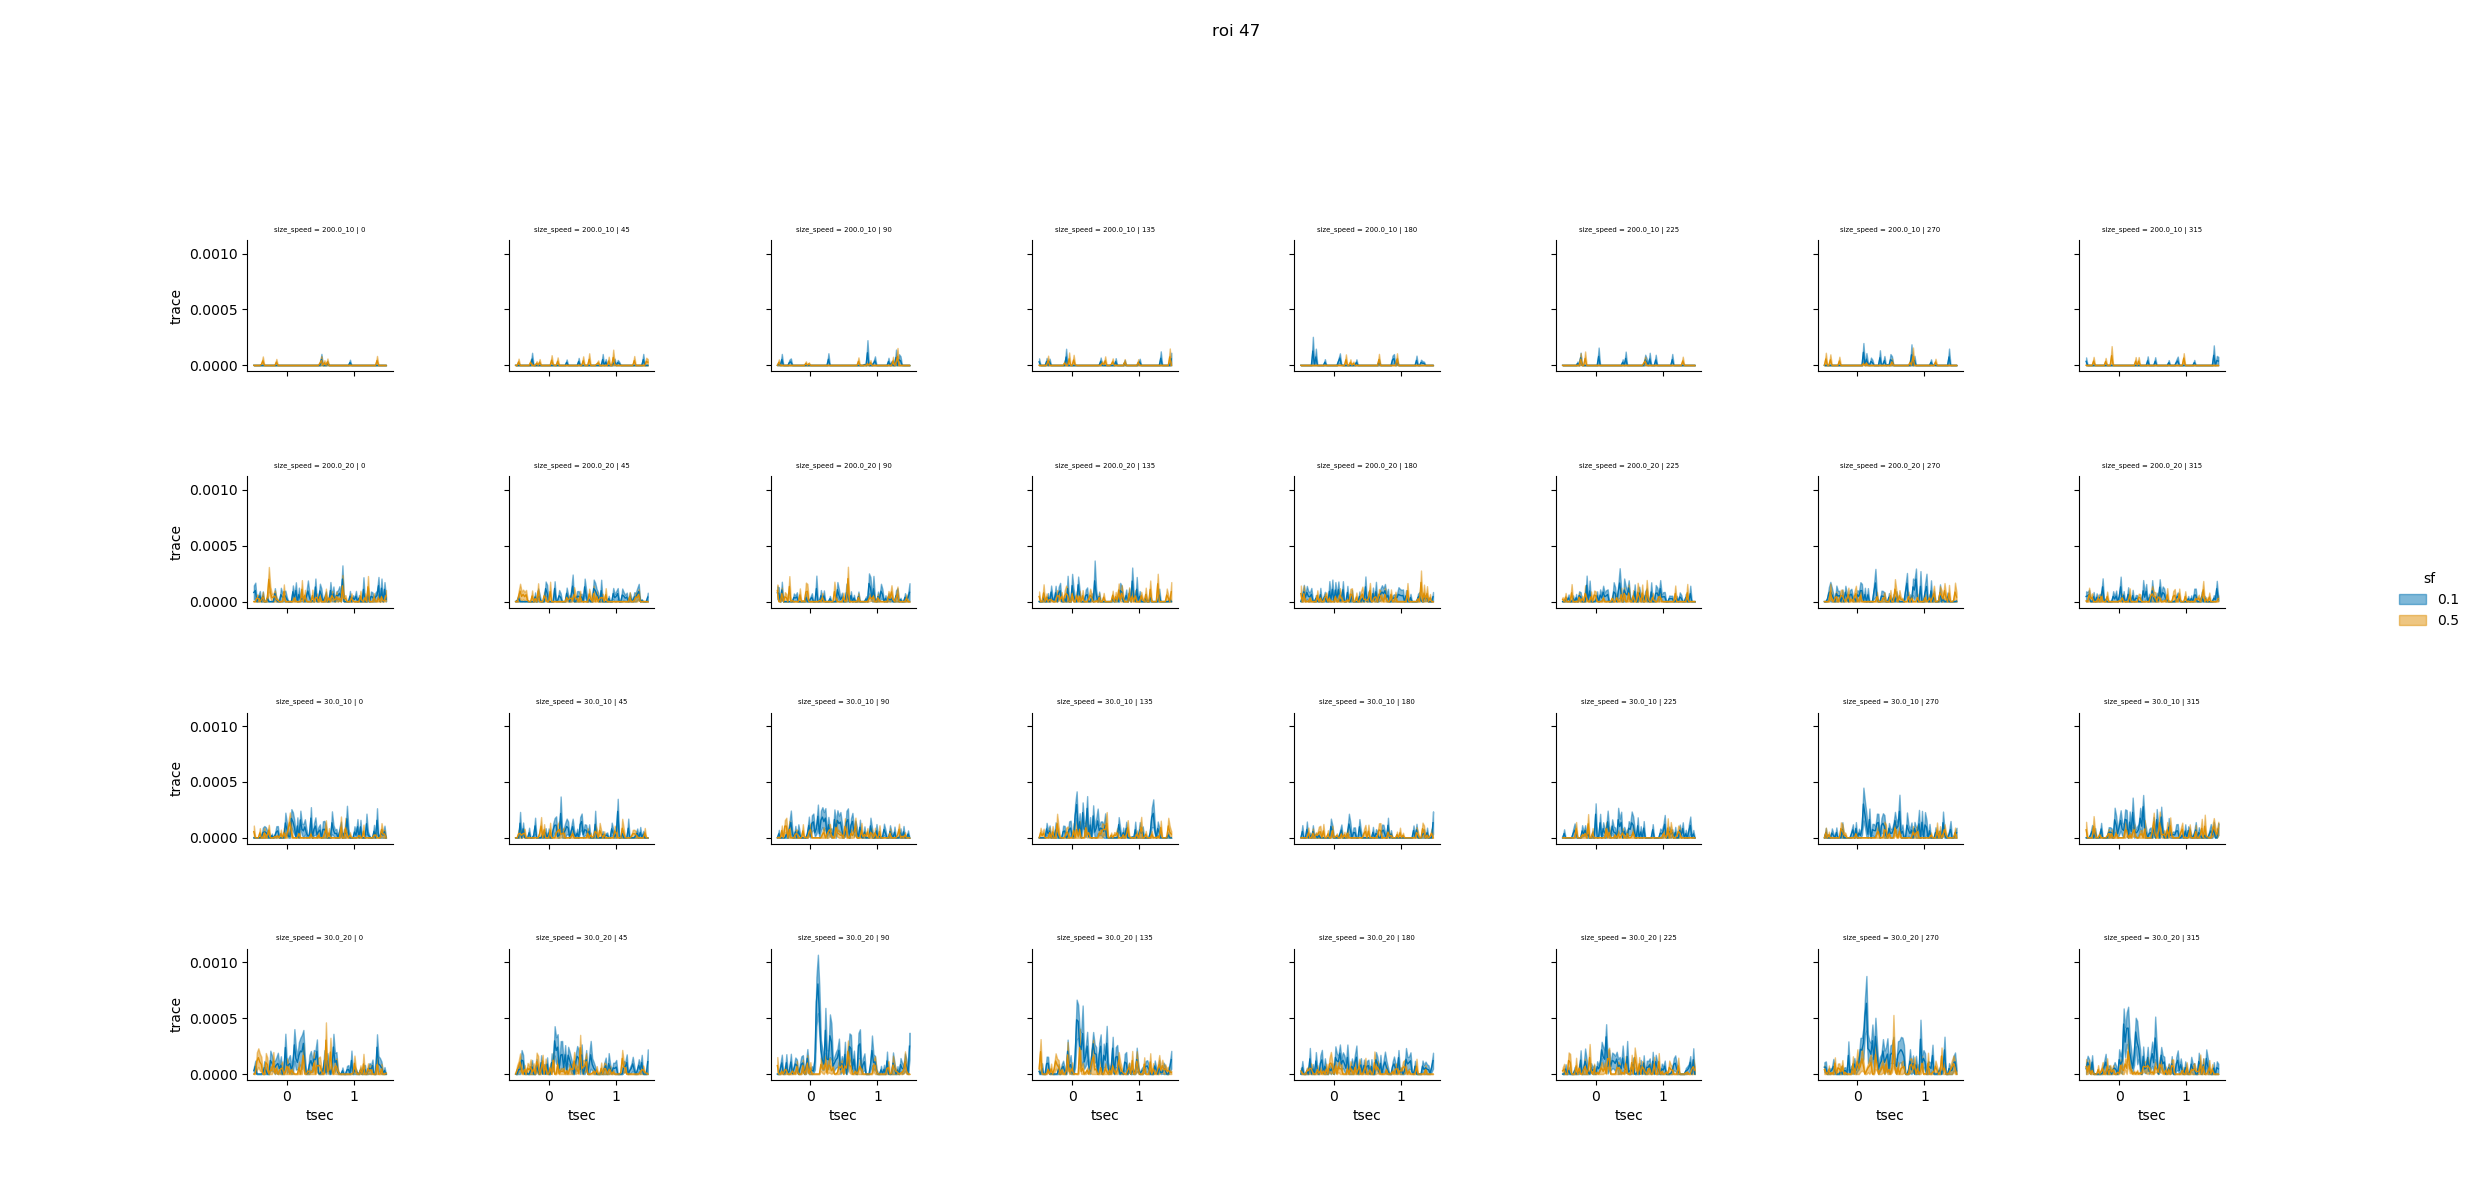

roi47_temporal.png


In [923]:
p = sns.FacetGrid(meandfs, col=plot_params['cols'], row=plot_params['rows'], hue=plot_params['hue'],\
                  sharex=True, sharey=True, palette=palette)


p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5) 
p = (p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1).add_legend())  
p = p.set_titles(col_template="{col_name}", size=5)      

pl.subplots_adjust(wspace=0.8, hspace=0.8, top=0.8, bottom=0.1, left=0.1, right=0.9)

p.fig.suptitle('roi %i' % int(rid+1))
figname = 'roi%i_temporal.png' % int(rid+1)
pl.savefig(os.path.join(psth_dir, figname))
print(figname)

In [924]:
psth_dir

'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e97cee_traces001_de9460_traces001_1f6b5f_traces001_70217b/figures/psth_caiman_deconvolved'

In [925]:
nrois

238

<IPython.core.display.Javascript object>


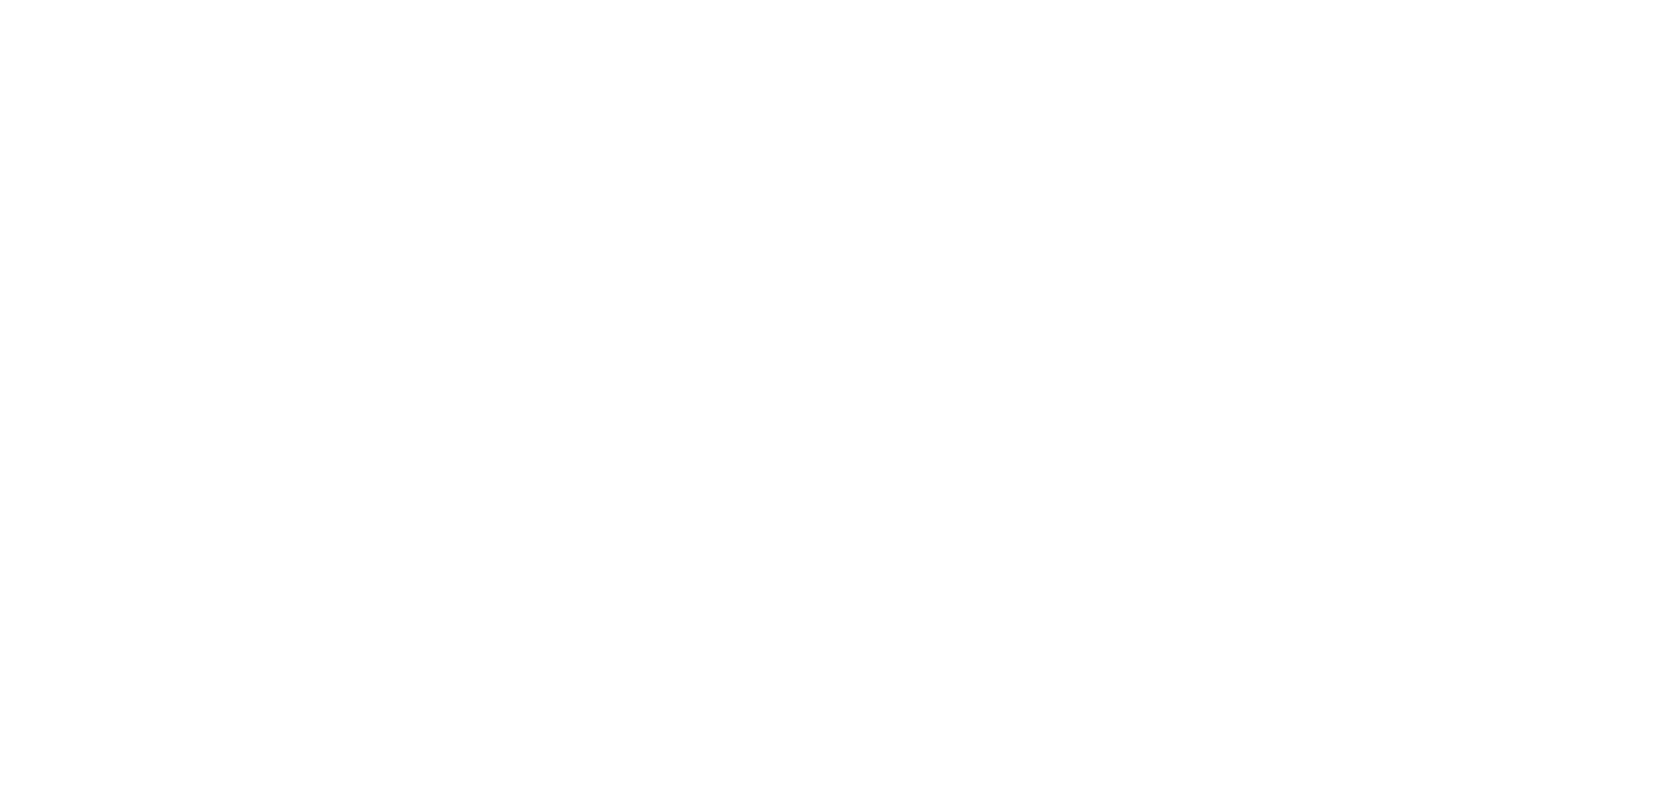

roi1_temporal.png


<IPython.core.display.Javascript object>


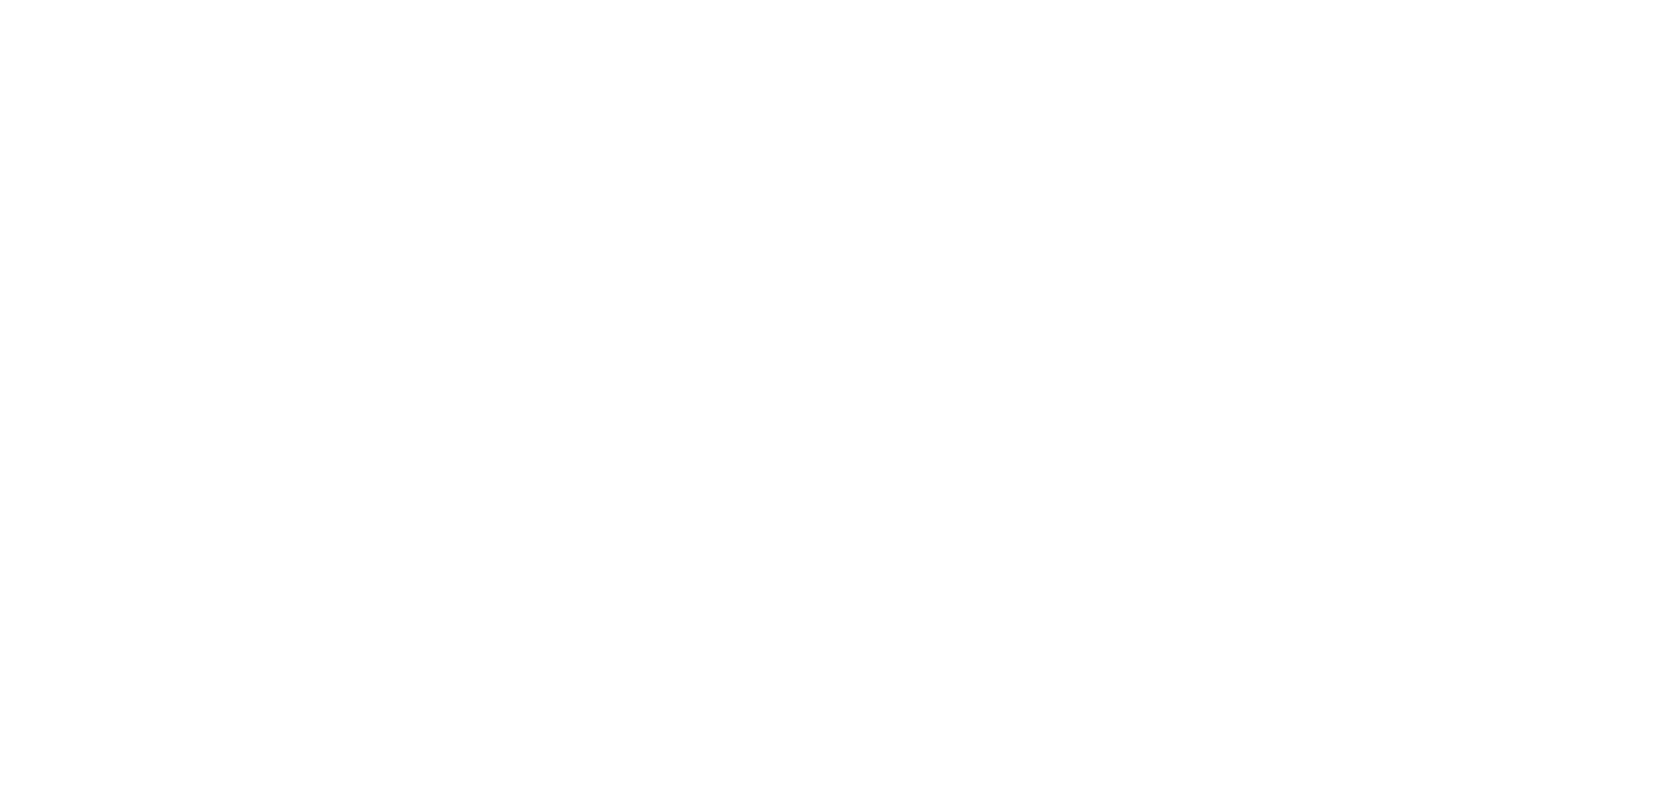

roi2_temporal.png


<IPython.core.display.Javascript object>


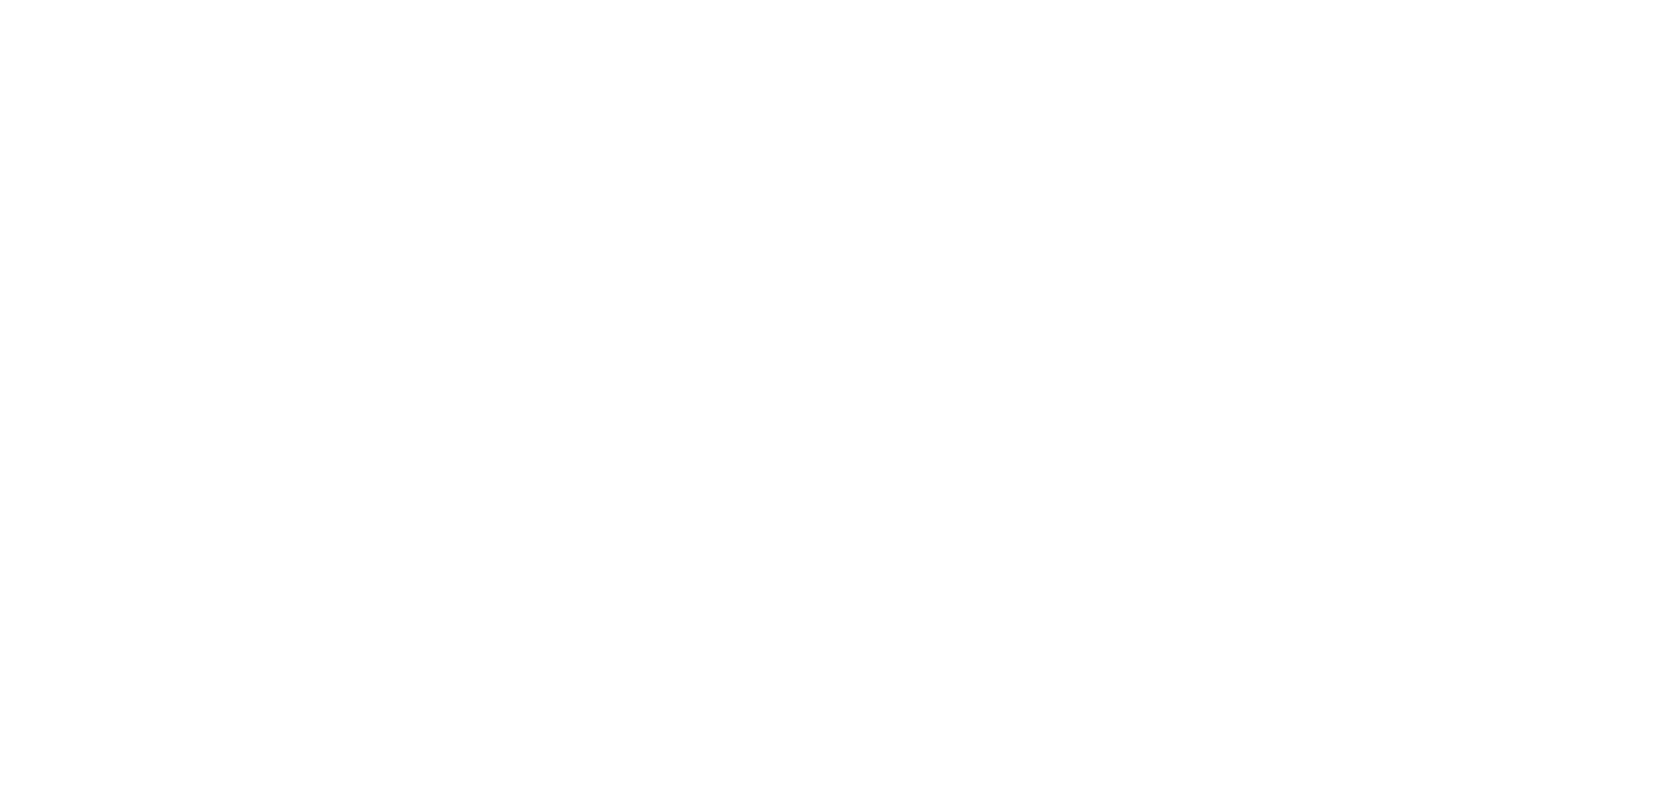

roi3_temporal.png


<IPython.core.display.Javascript object>


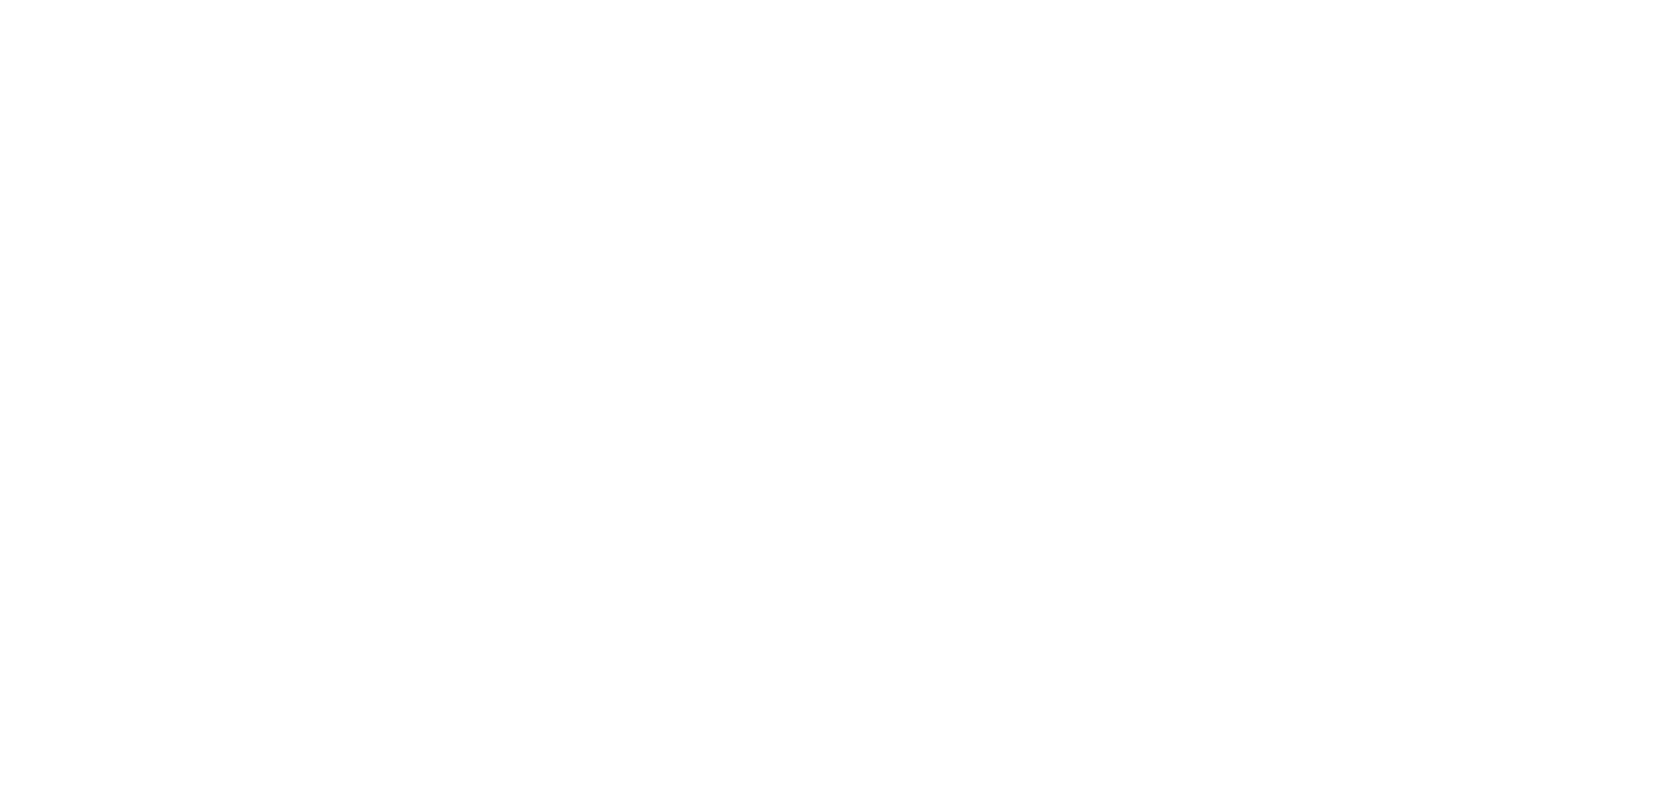

roi4_temporal.png


<IPython.core.display.Javascript object>


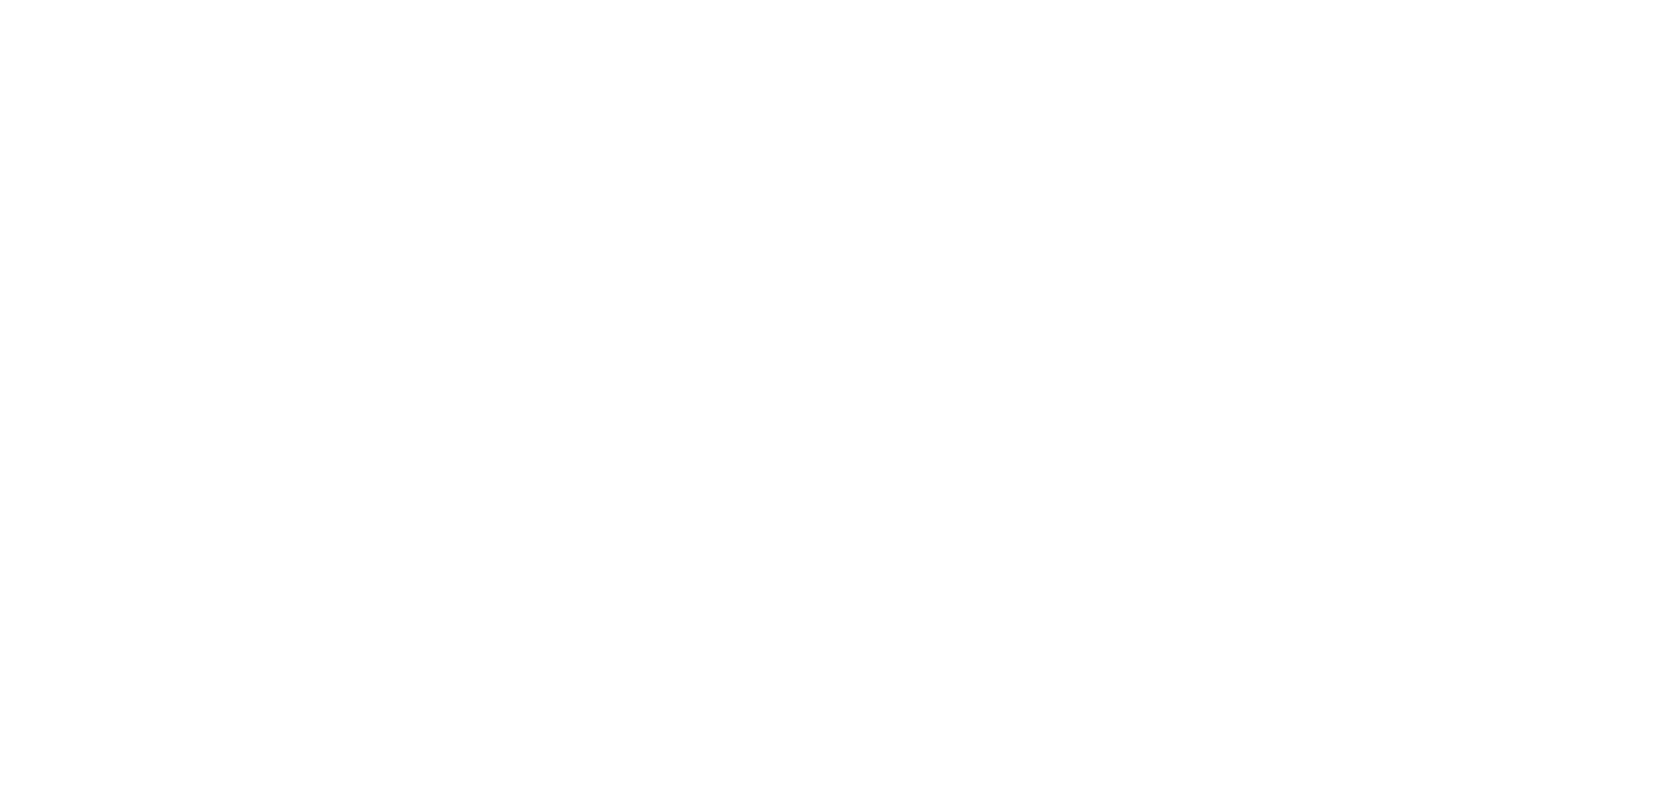

roi5_temporal.png


<IPython.core.display.Javascript object>


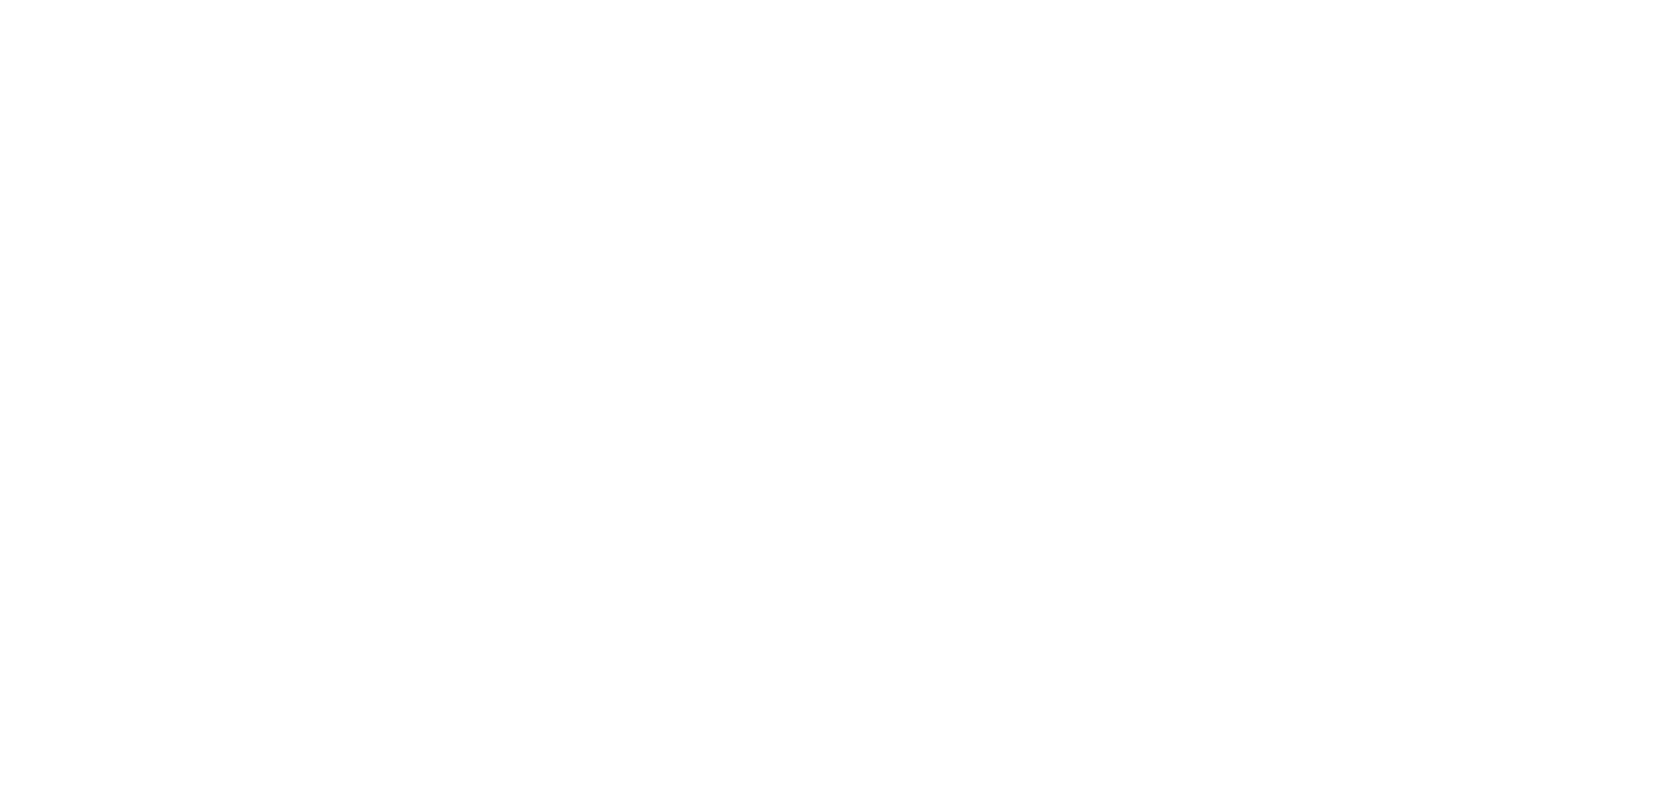

roi6_temporal.png


<IPython.core.display.Javascript object>


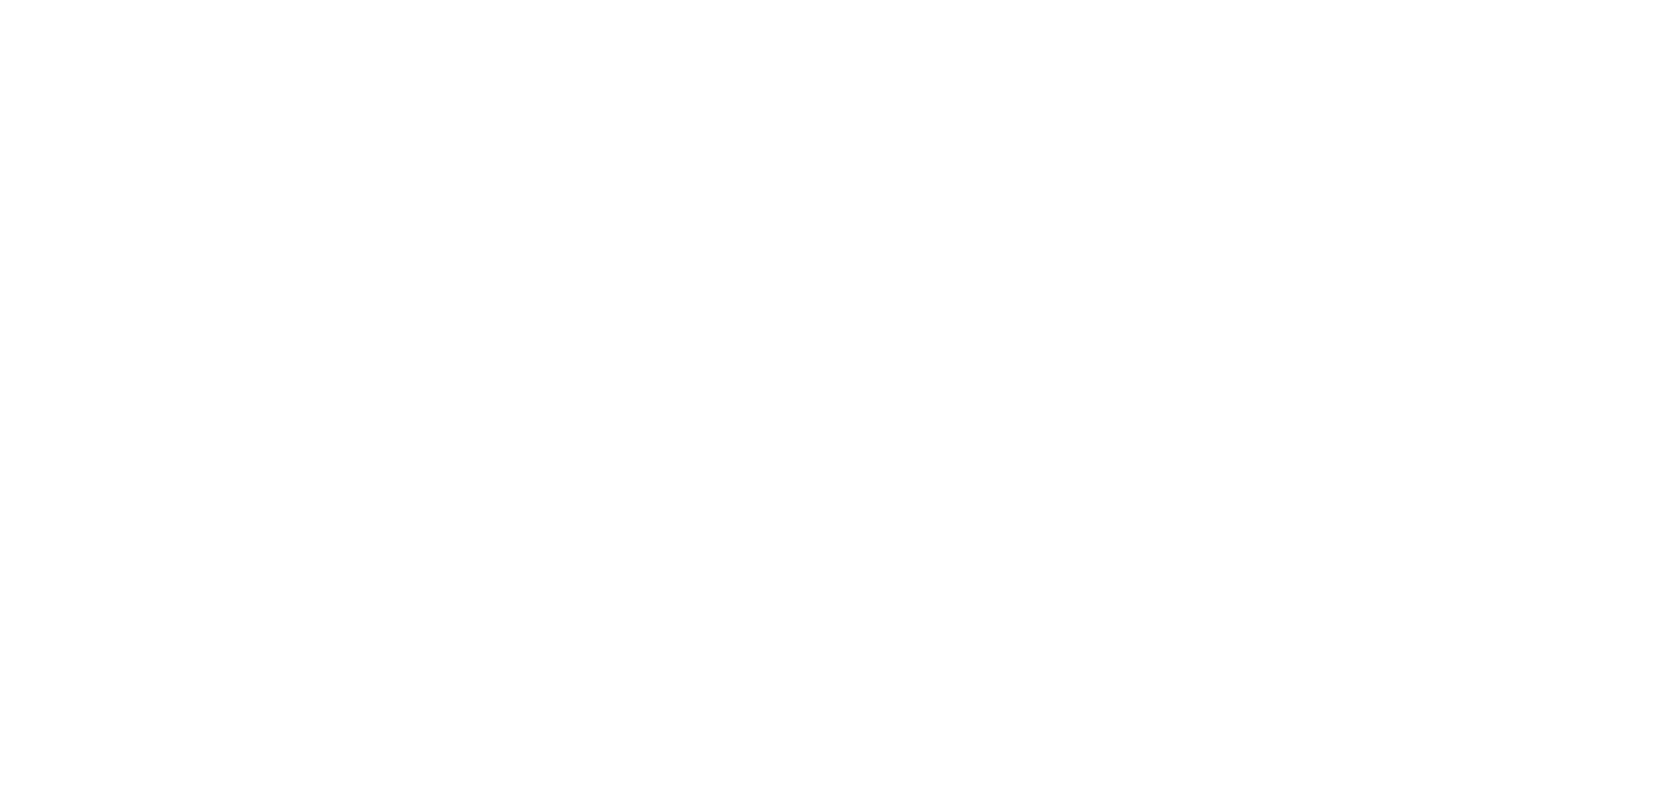

roi7_temporal.png


<IPython.core.display.Javascript object>


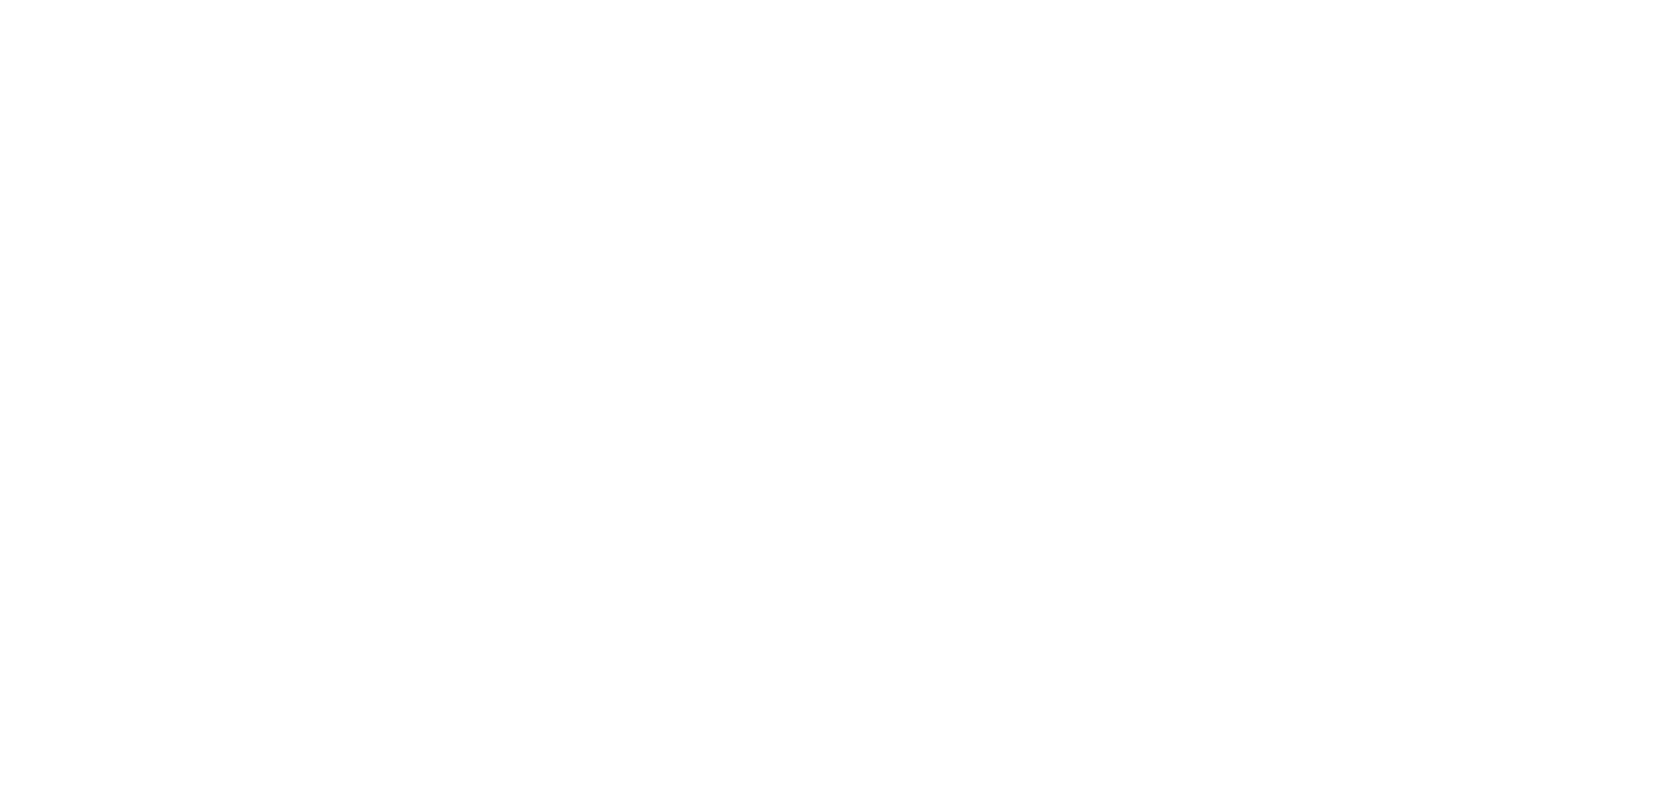

roi8_temporal.png


<IPython.core.display.Javascript object>


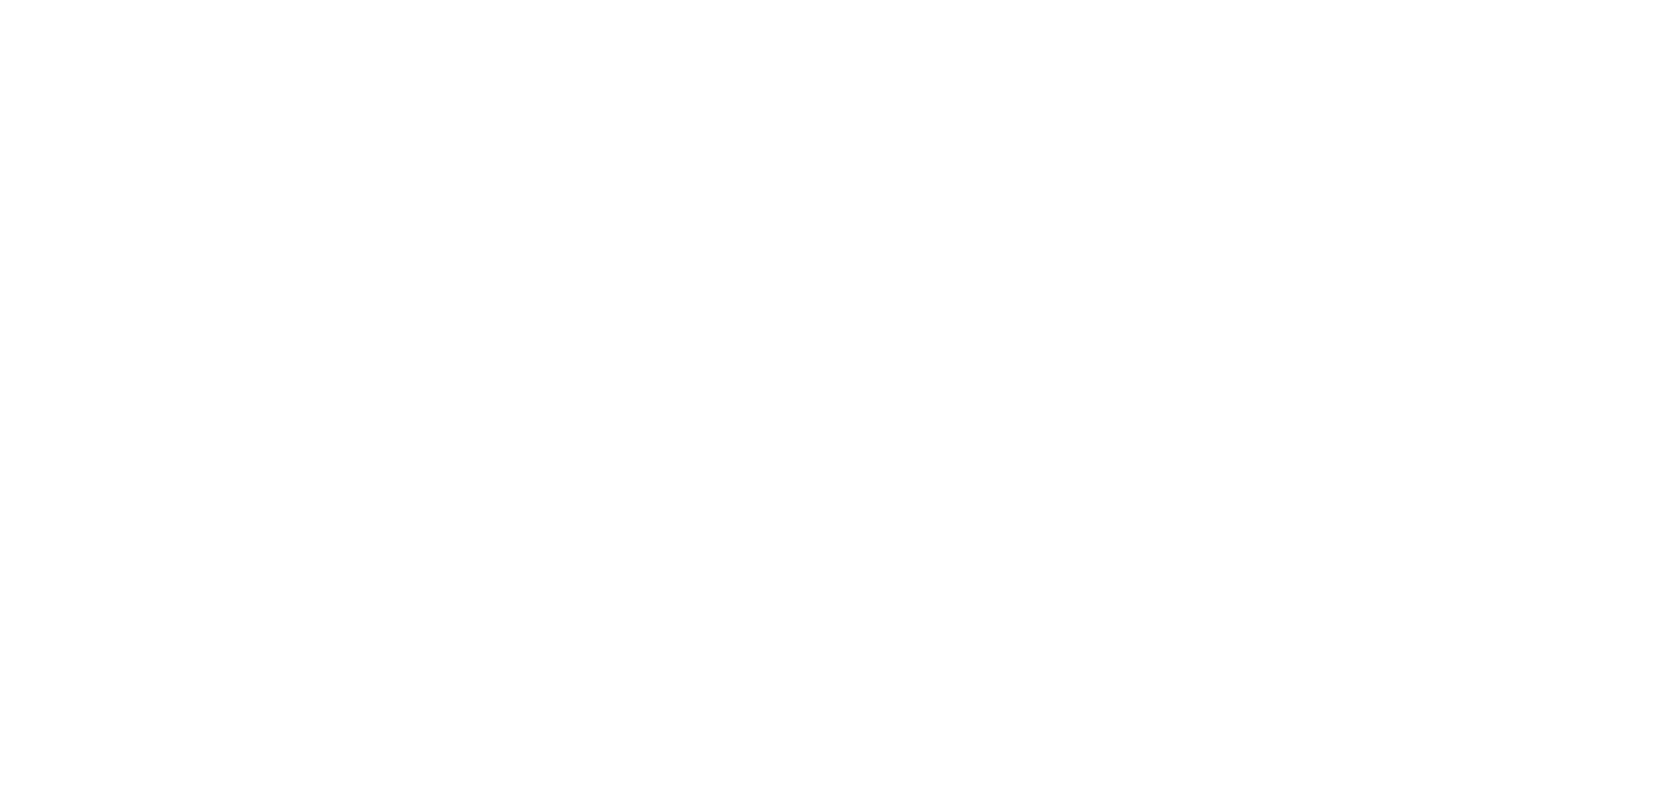

roi9_temporal.png


<IPython.core.display.Javascript object>


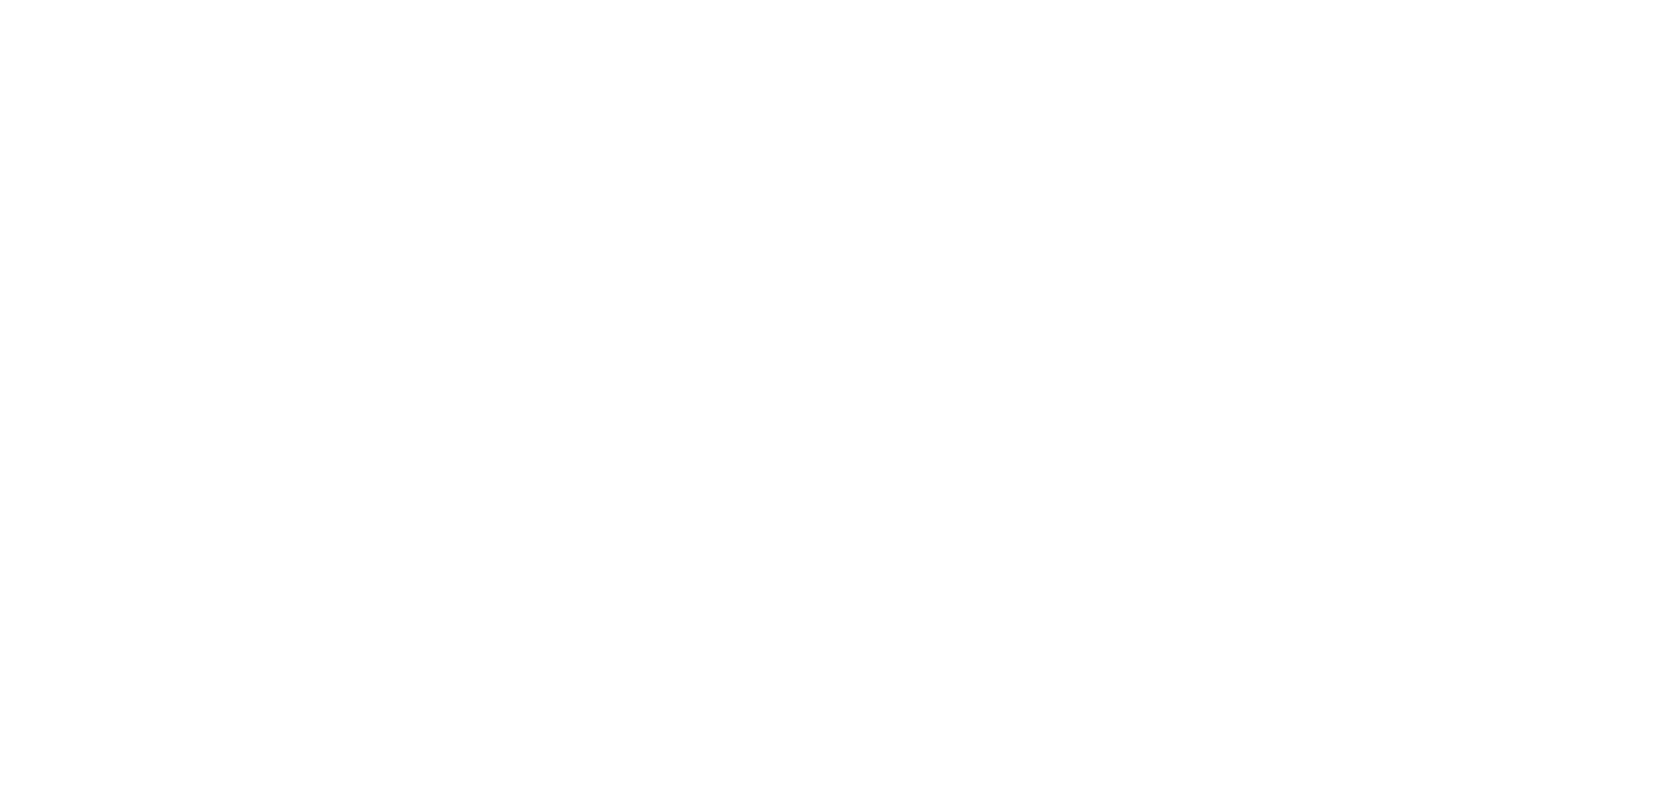

roi10_temporal.png


<IPython.core.display.Javascript object>


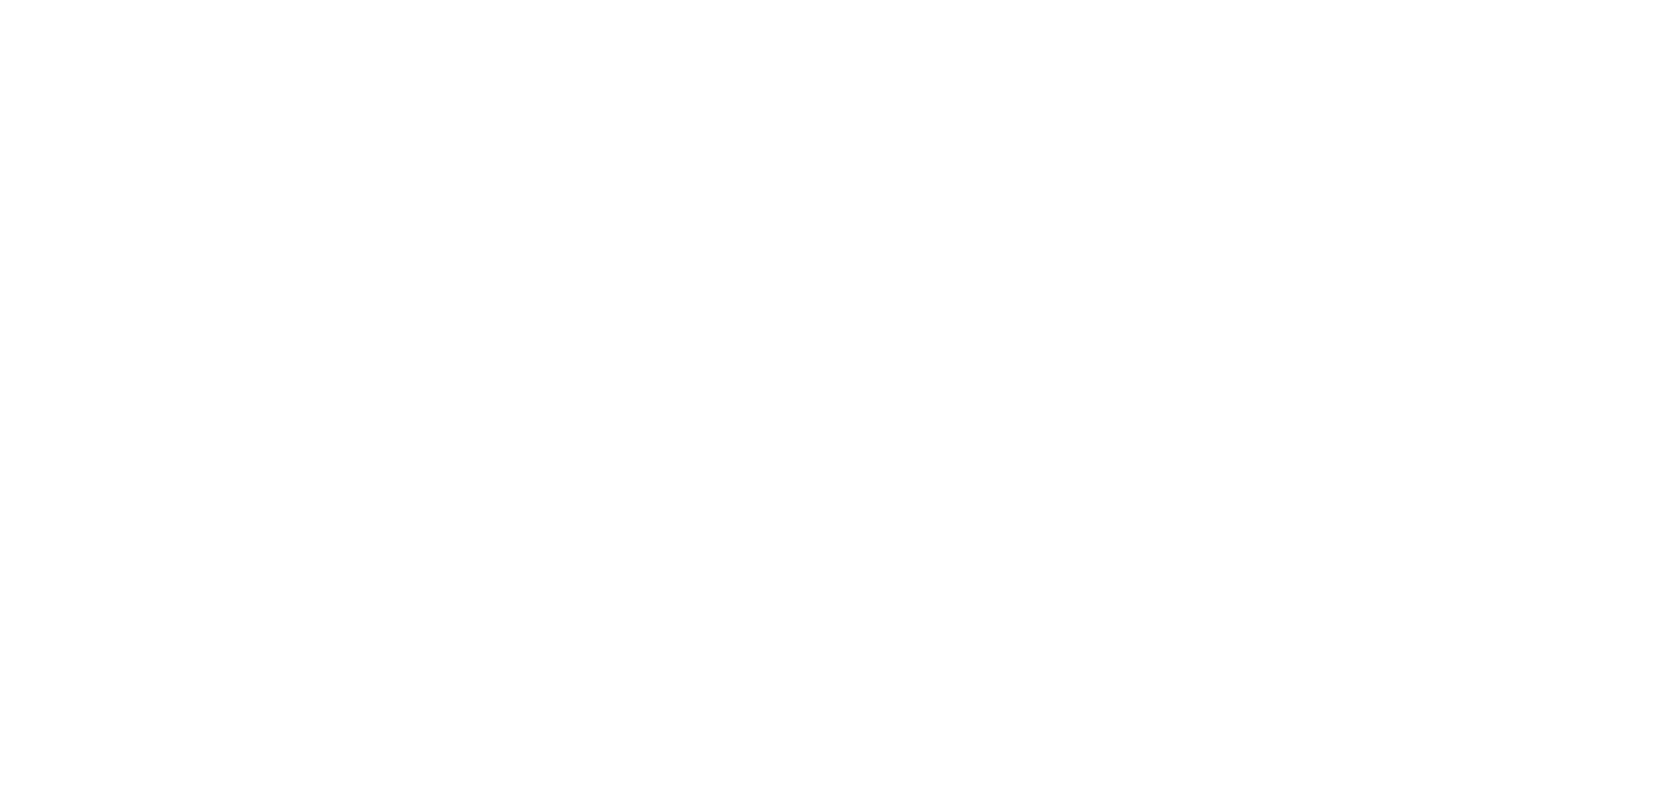

roi11_temporal.png


<IPython.core.display.Javascript object>


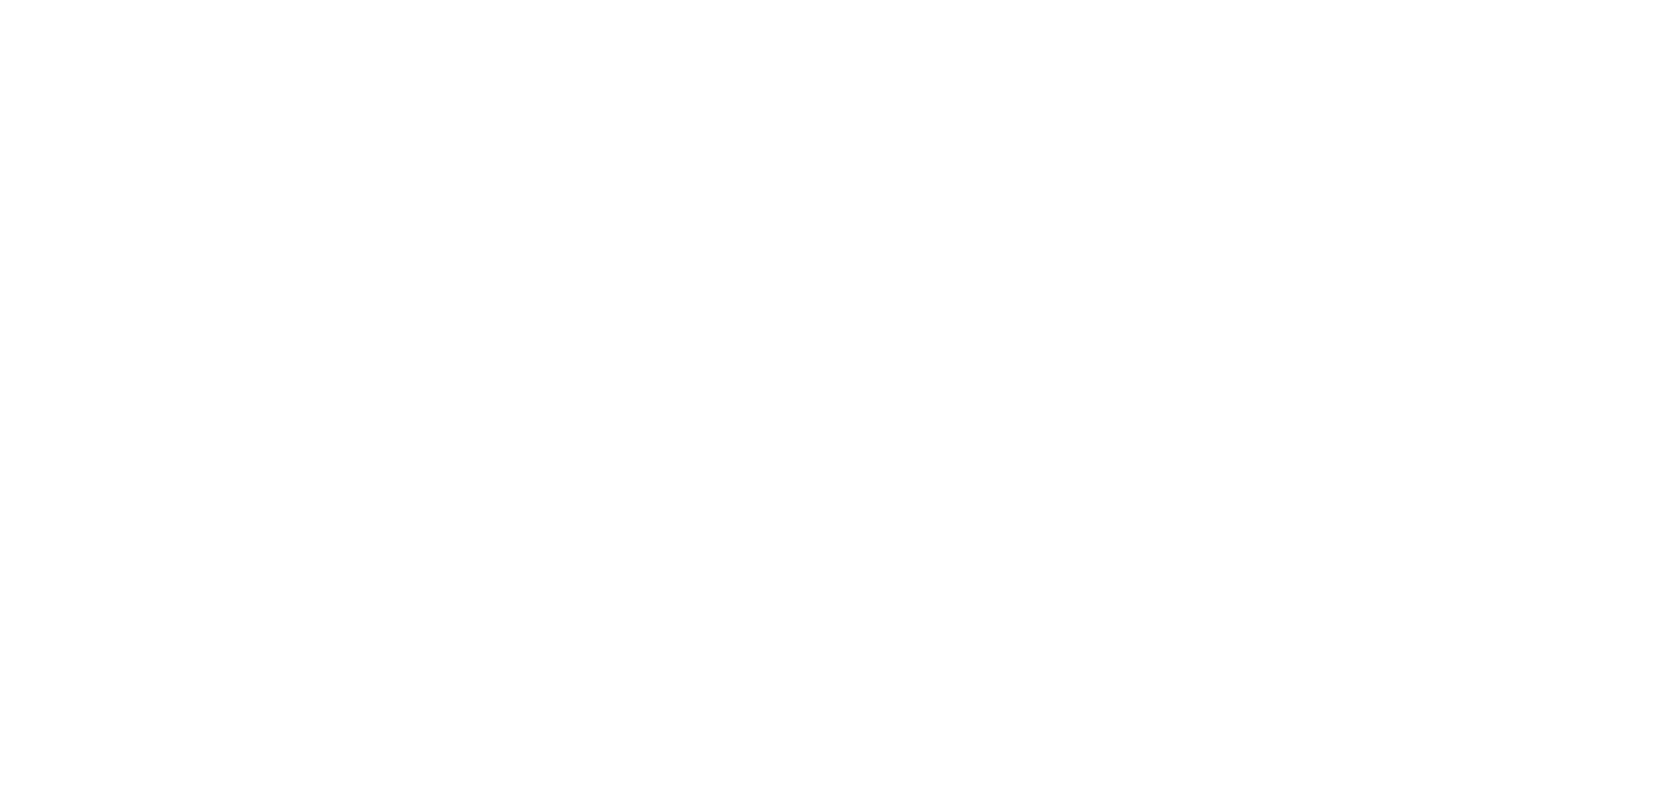

roi12_temporal.png


<IPython.core.display.Javascript object>


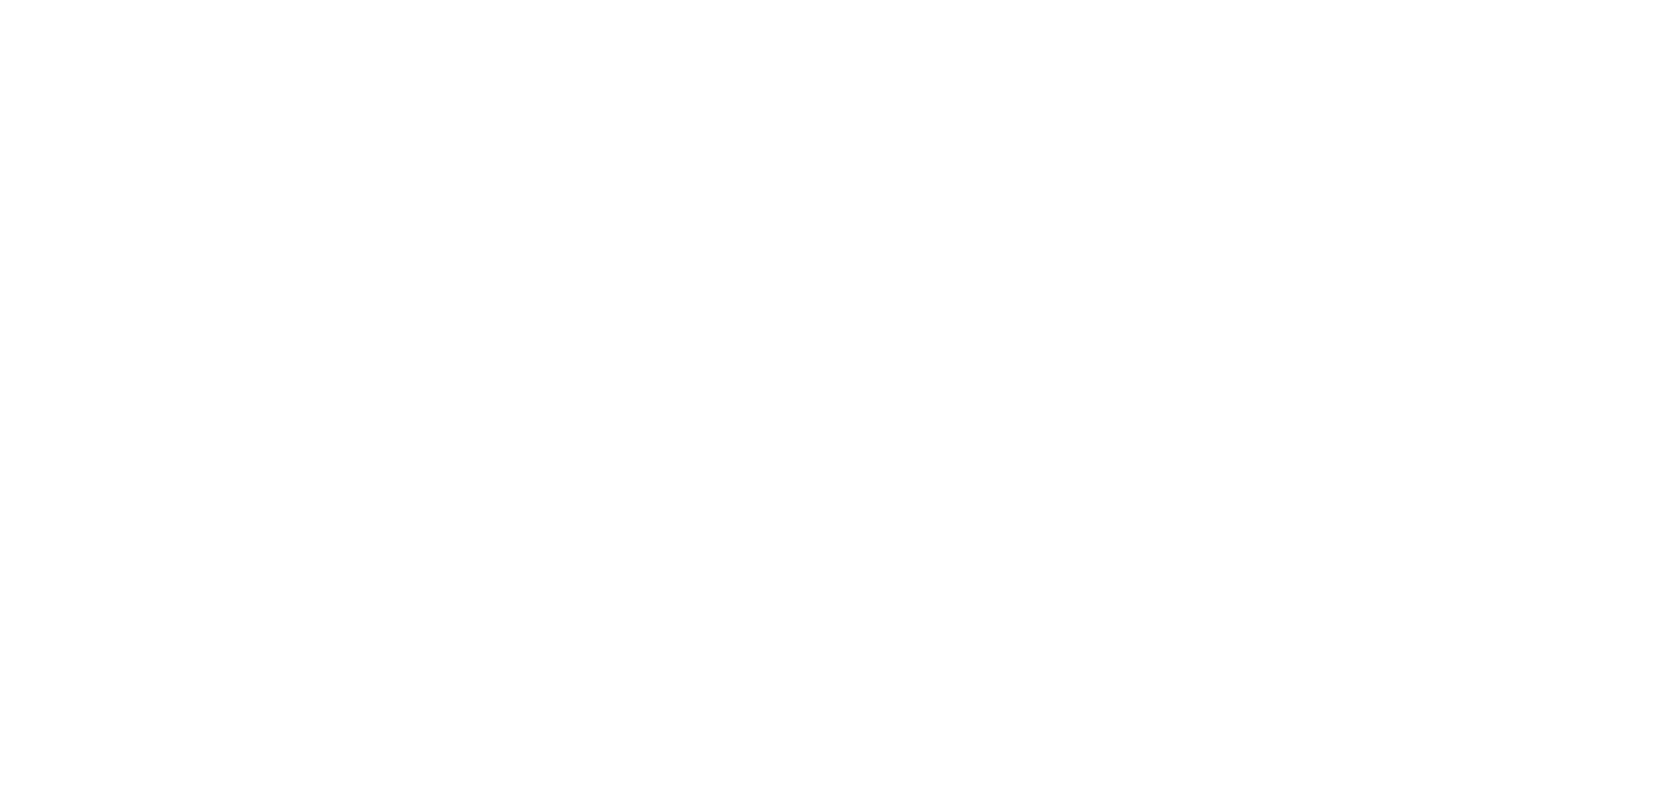

roi13_temporal.png


<IPython.core.display.Javascript object>


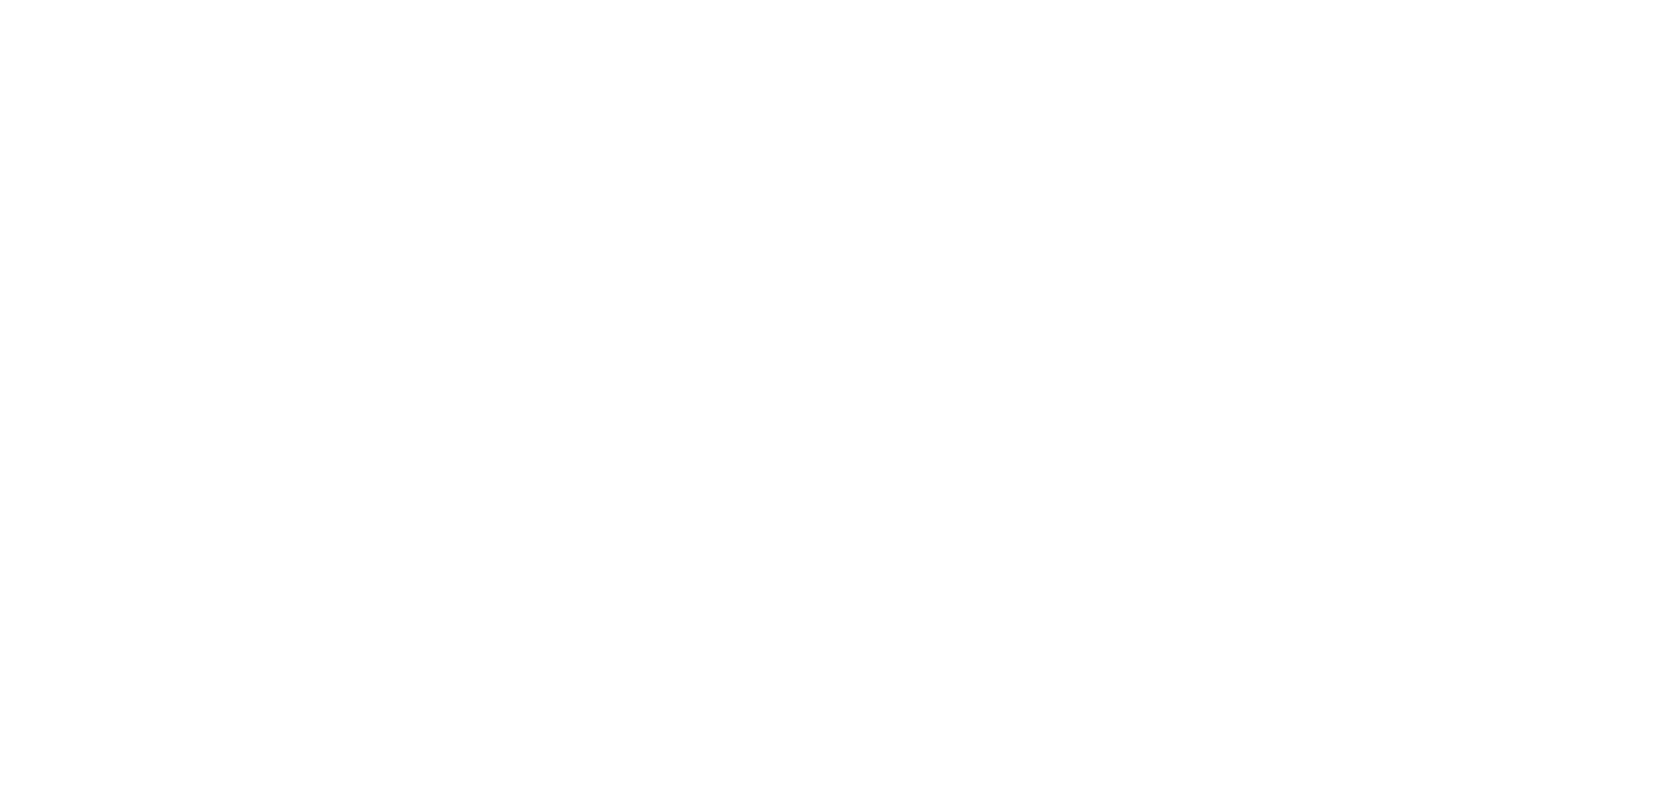

roi14_temporal.png


<IPython.core.display.Javascript object>


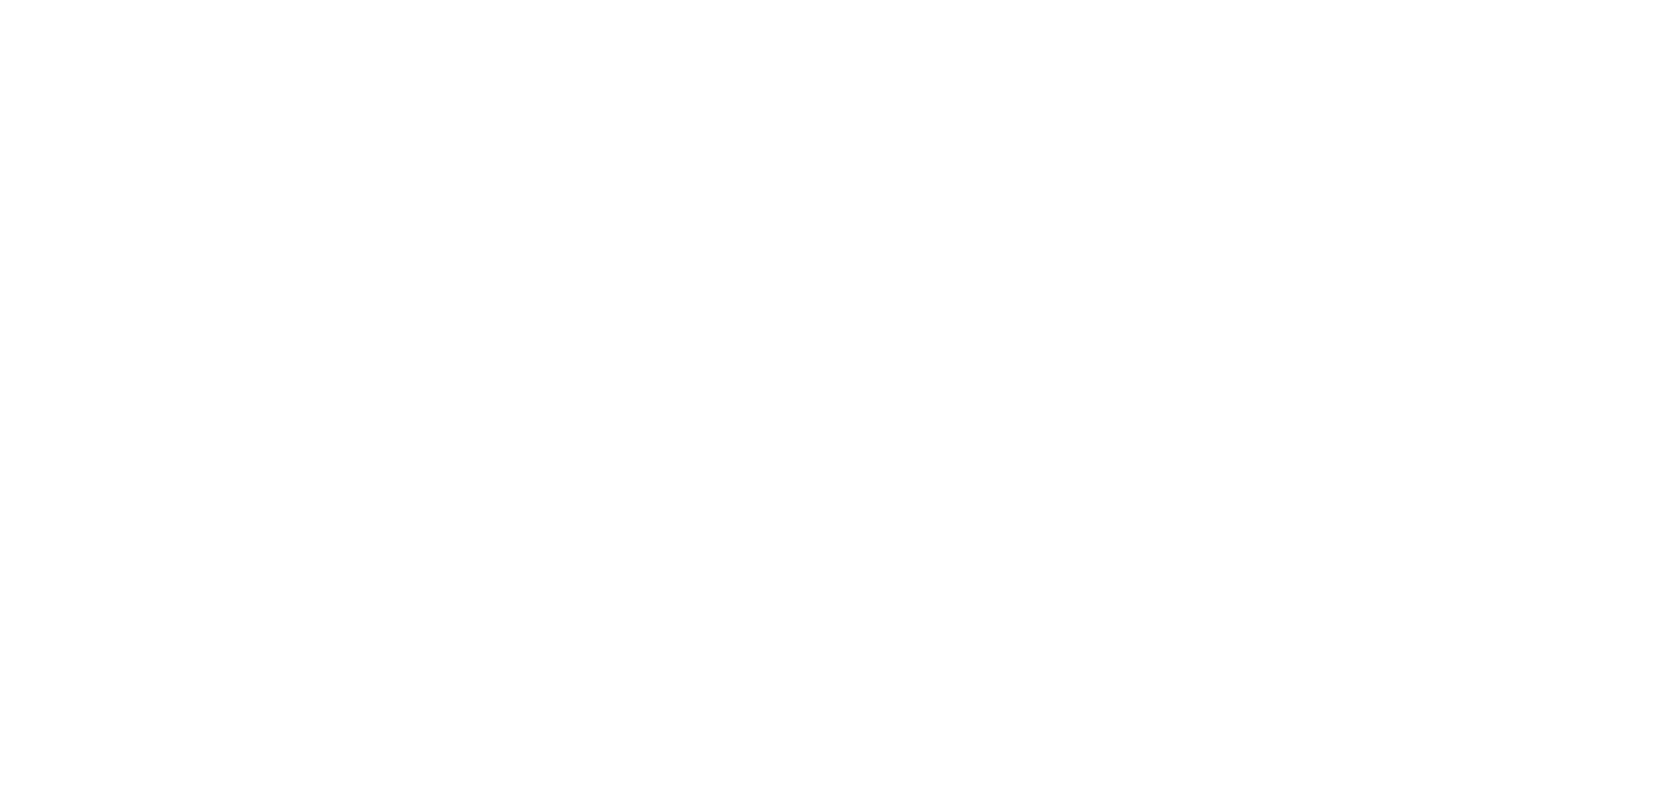

roi15_temporal.png


<IPython.core.display.Javascript object>


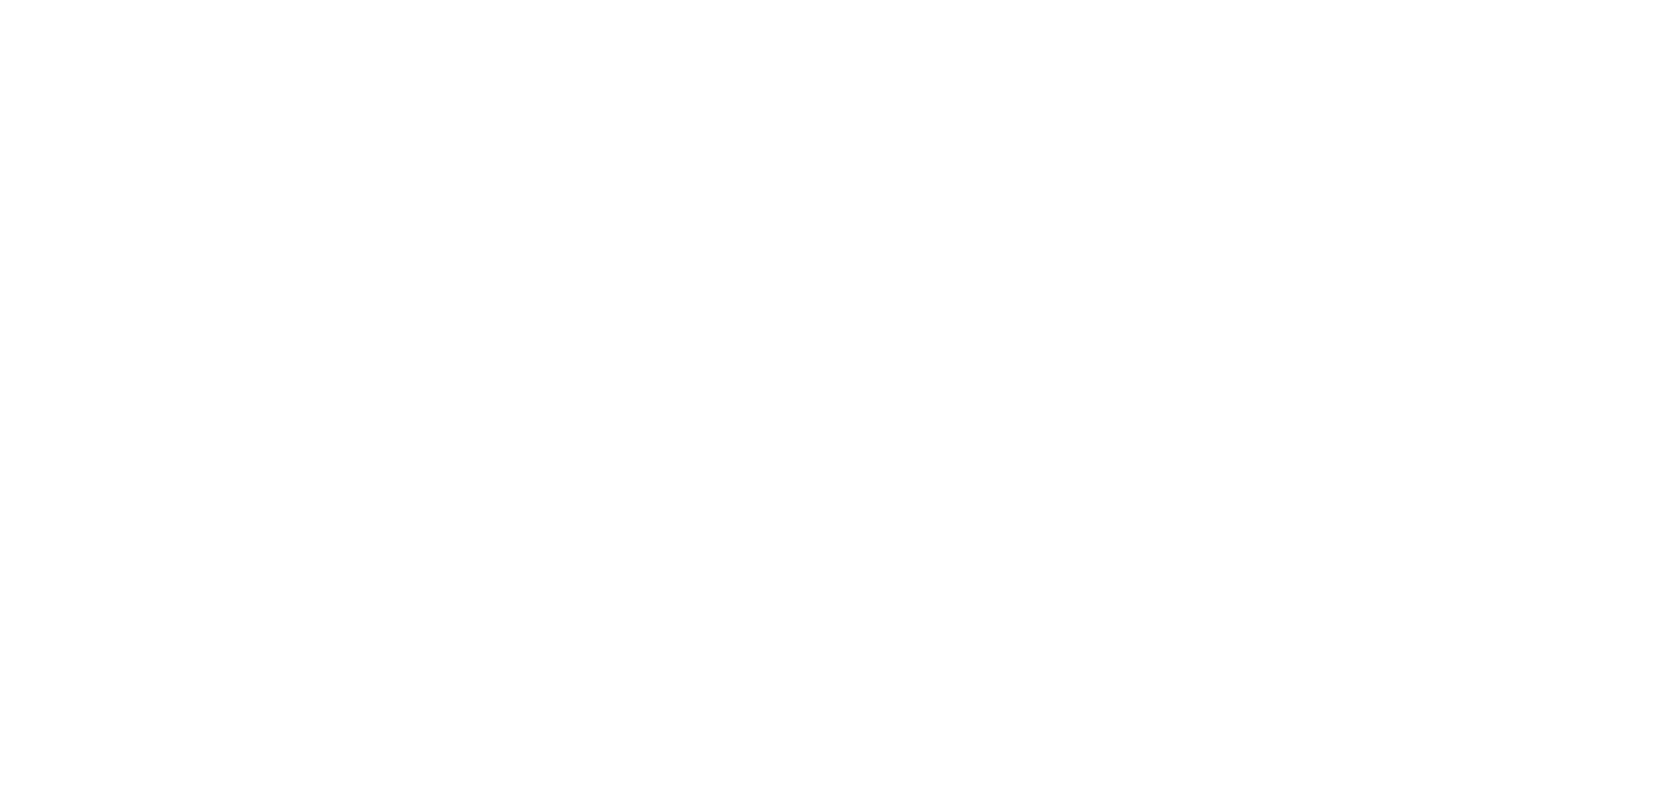

roi16_temporal.png


<IPython.core.display.Javascript object>


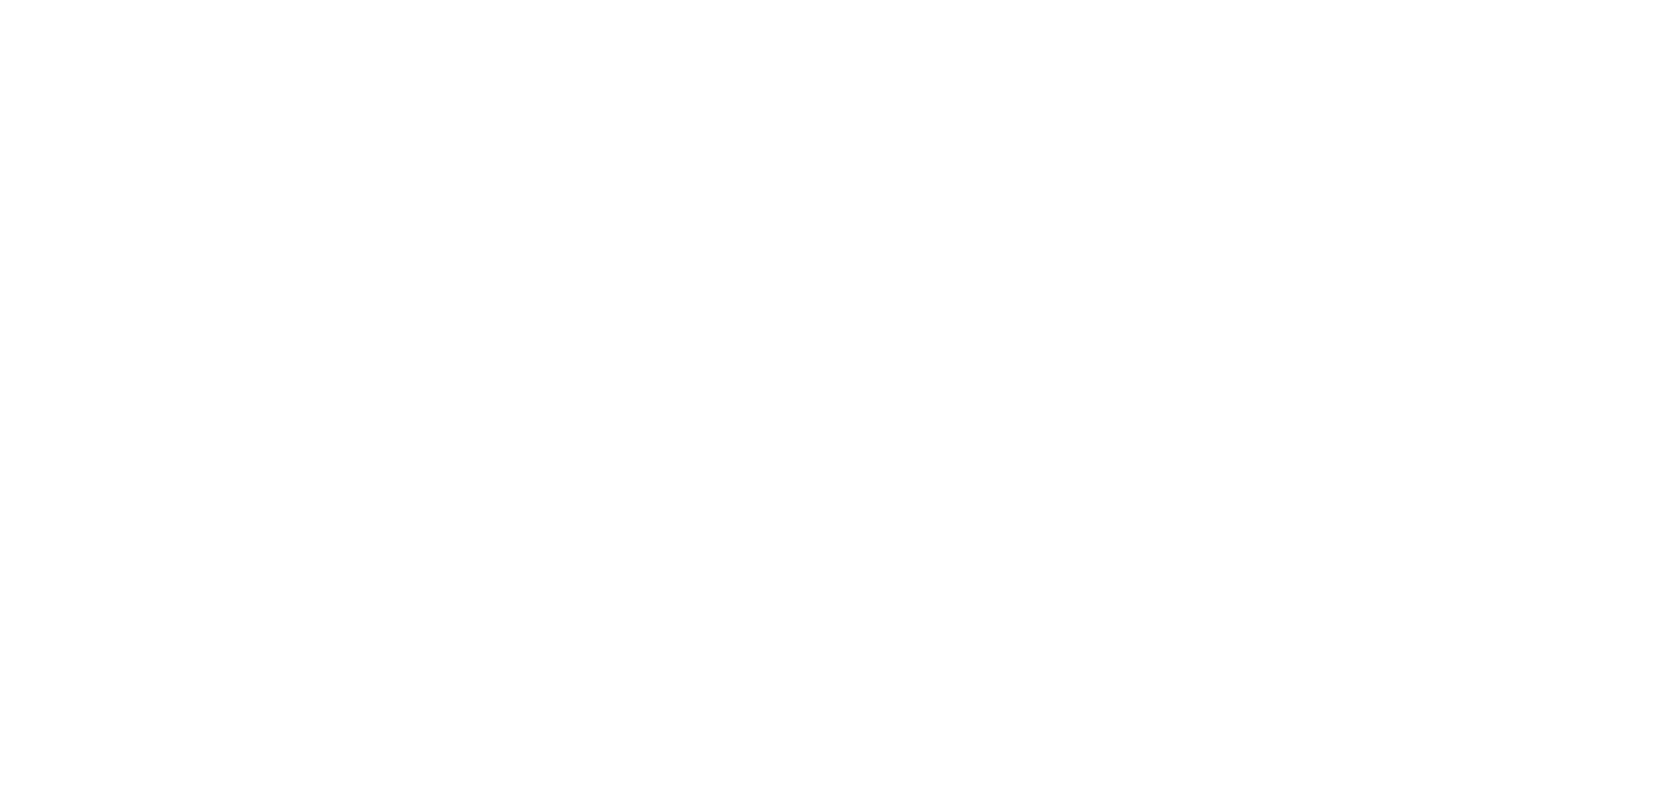

roi17_temporal.png


<IPython.core.display.Javascript object>


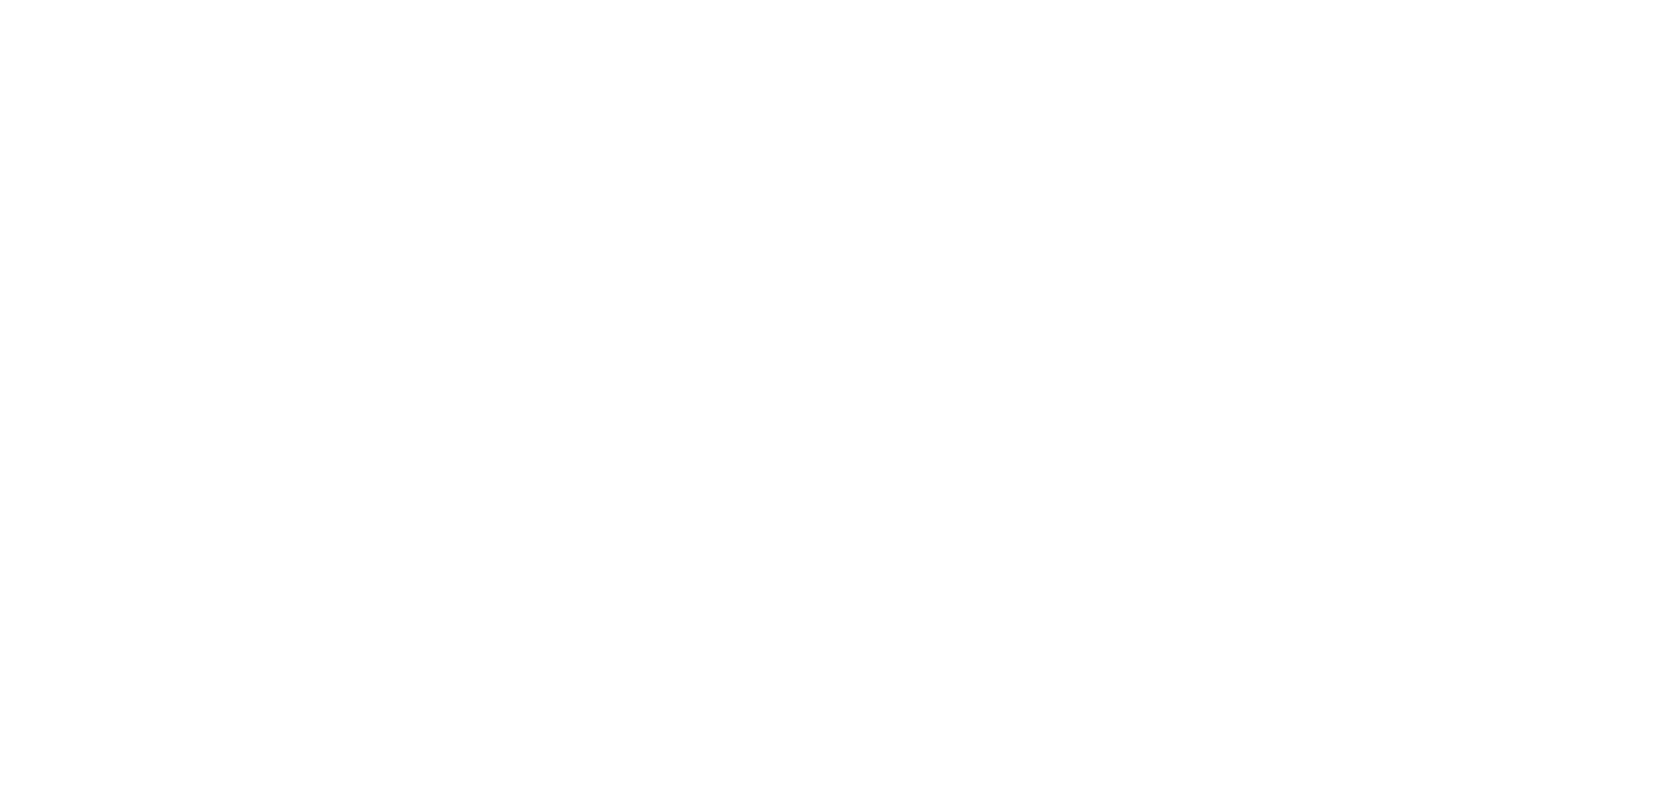

roi18_temporal.png


<IPython.core.display.Javascript object>


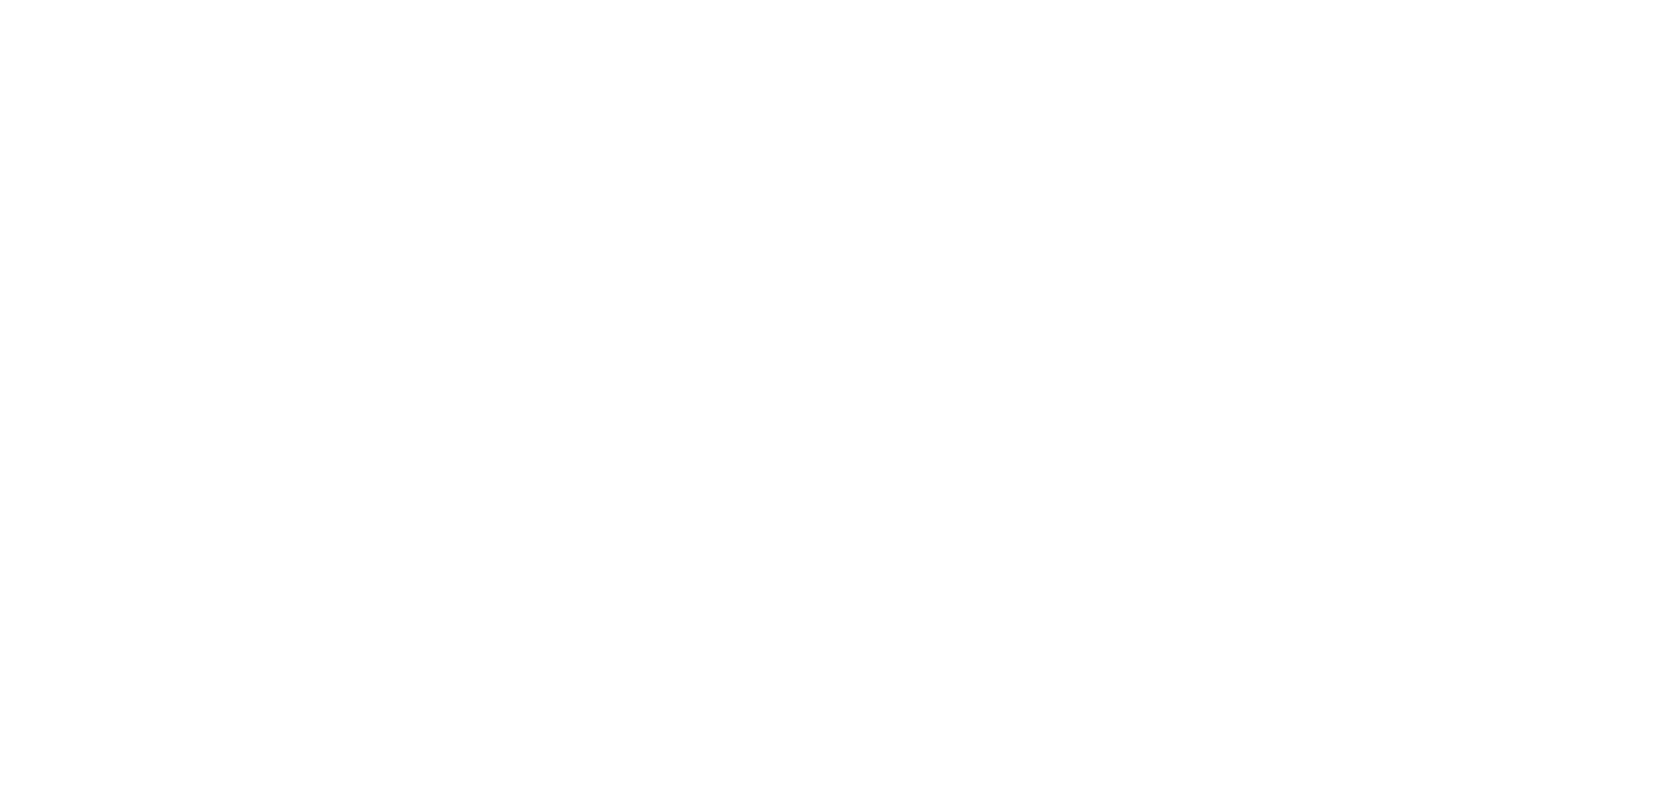

roi19_temporal.png


<IPython.core.display.Javascript object>


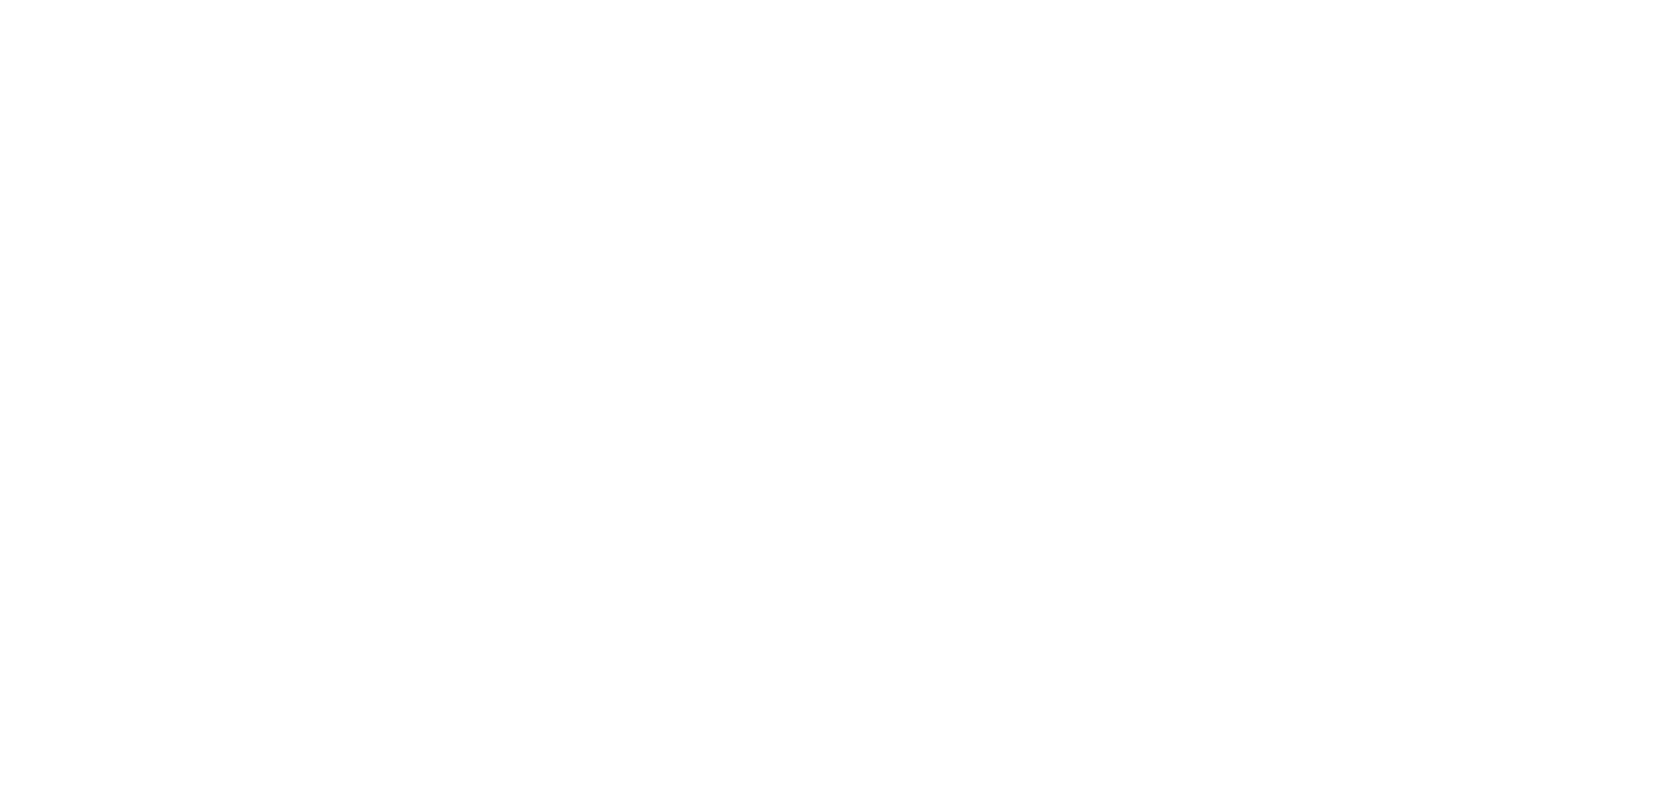

roi20_temporal.png


<IPython.core.display.Javascript object>


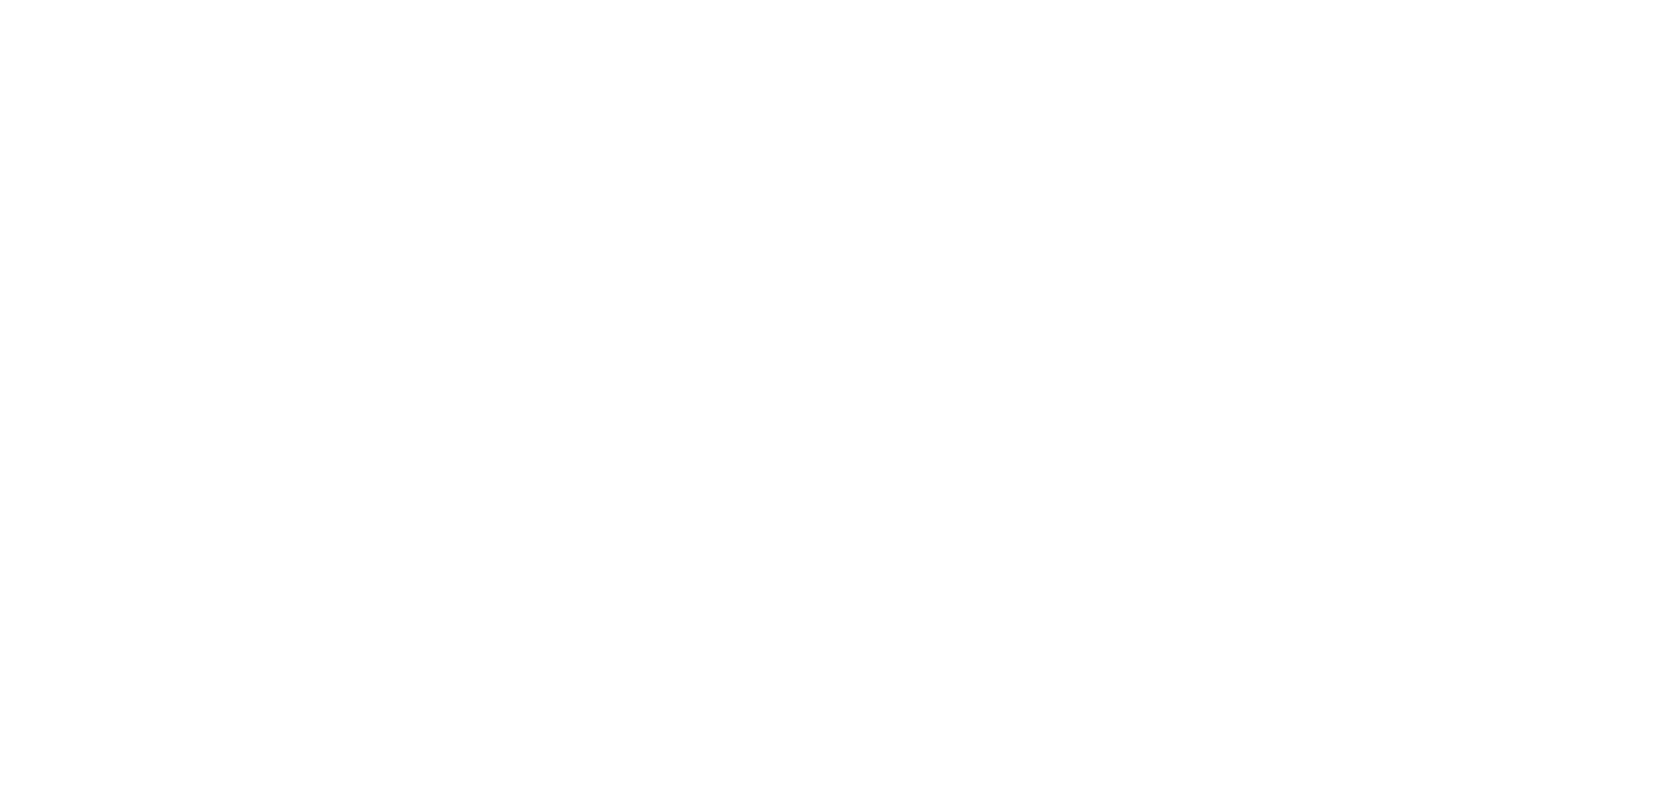

roi21_temporal.png


<IPython.core.display.Javascript object>


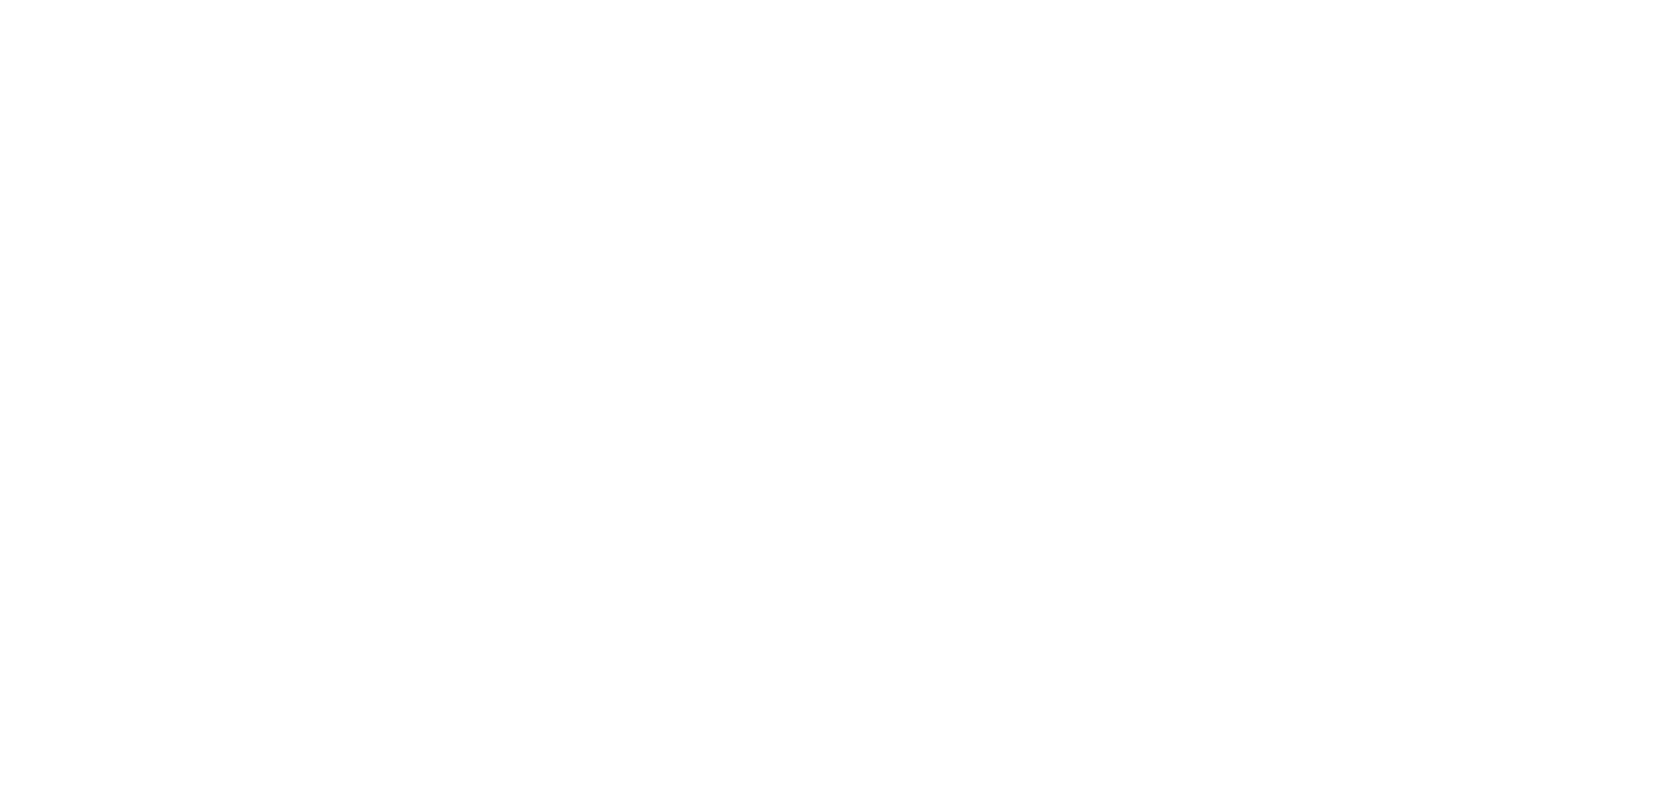

roi22_temporal.png


<IPython.core.display.Javascript object>


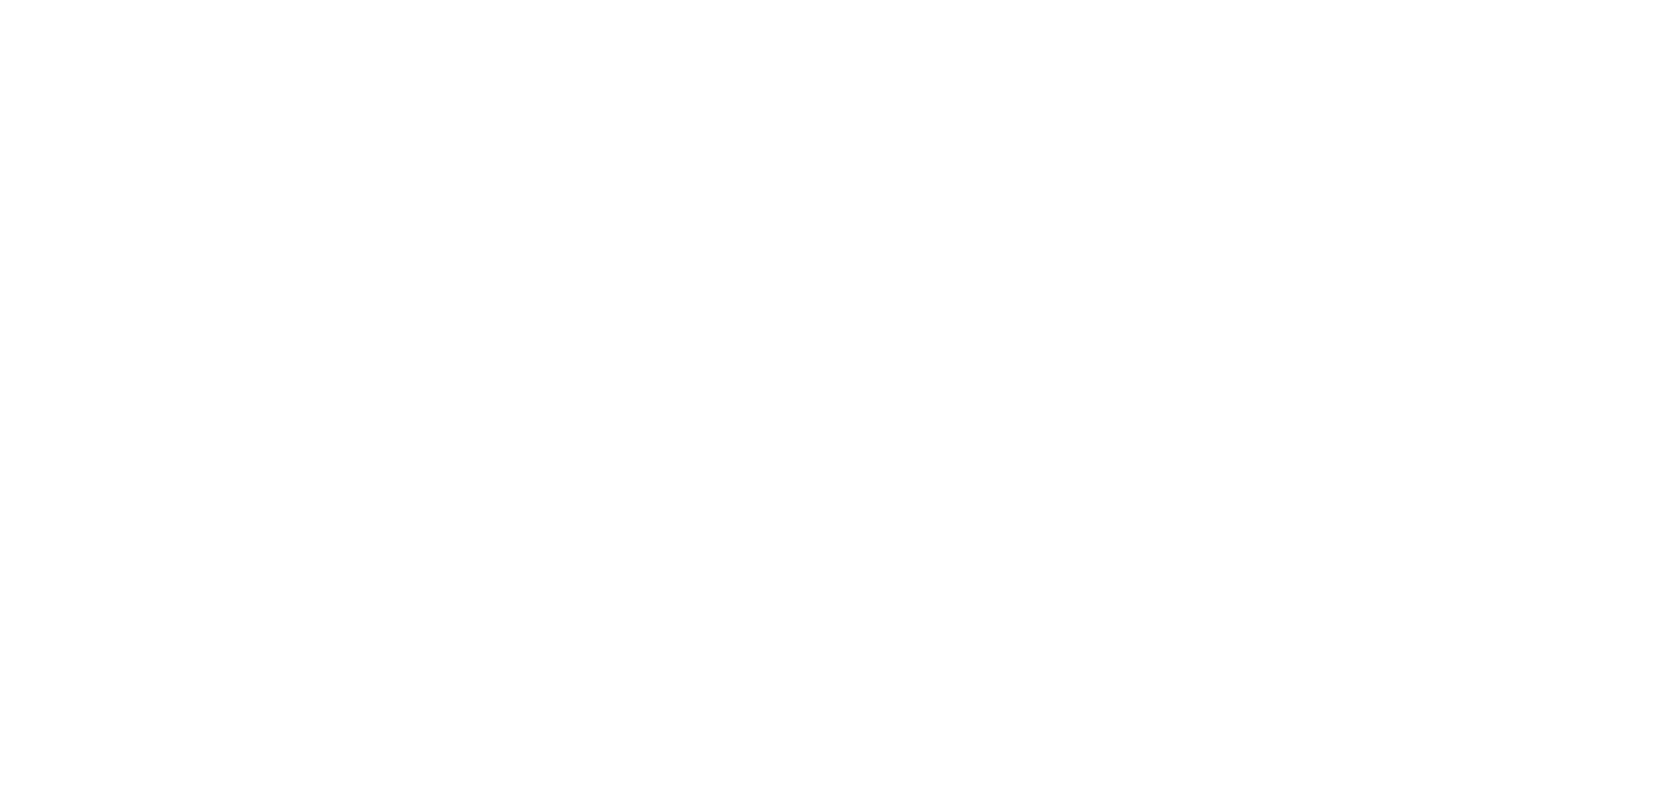

roi23_temporal.png


<IPython.core.display.Javascript object>


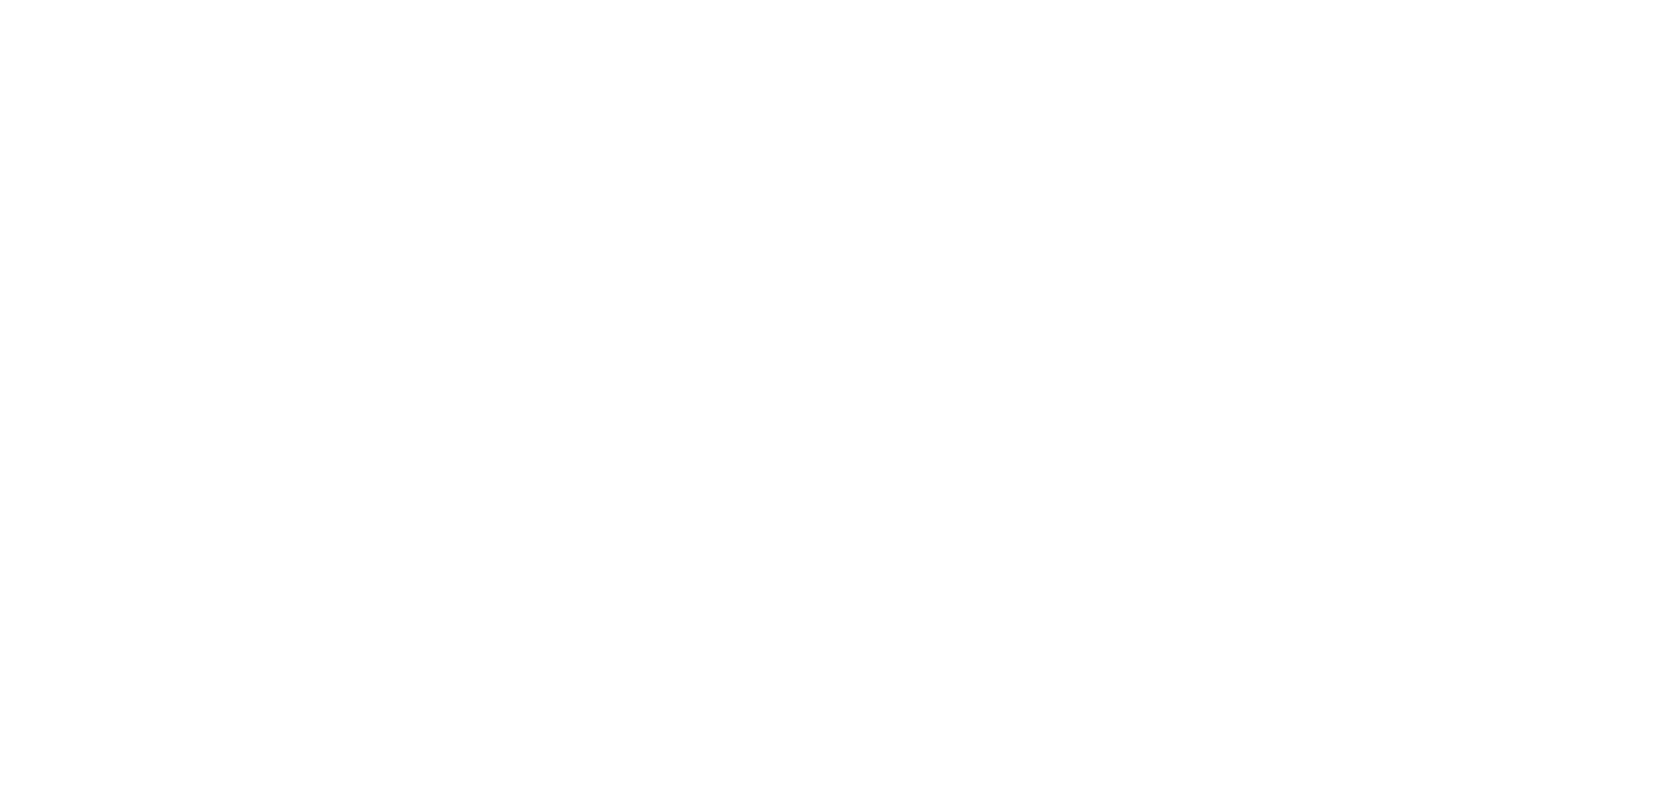

roi24_temporal.png


<IPython.core.display.Javascript object>


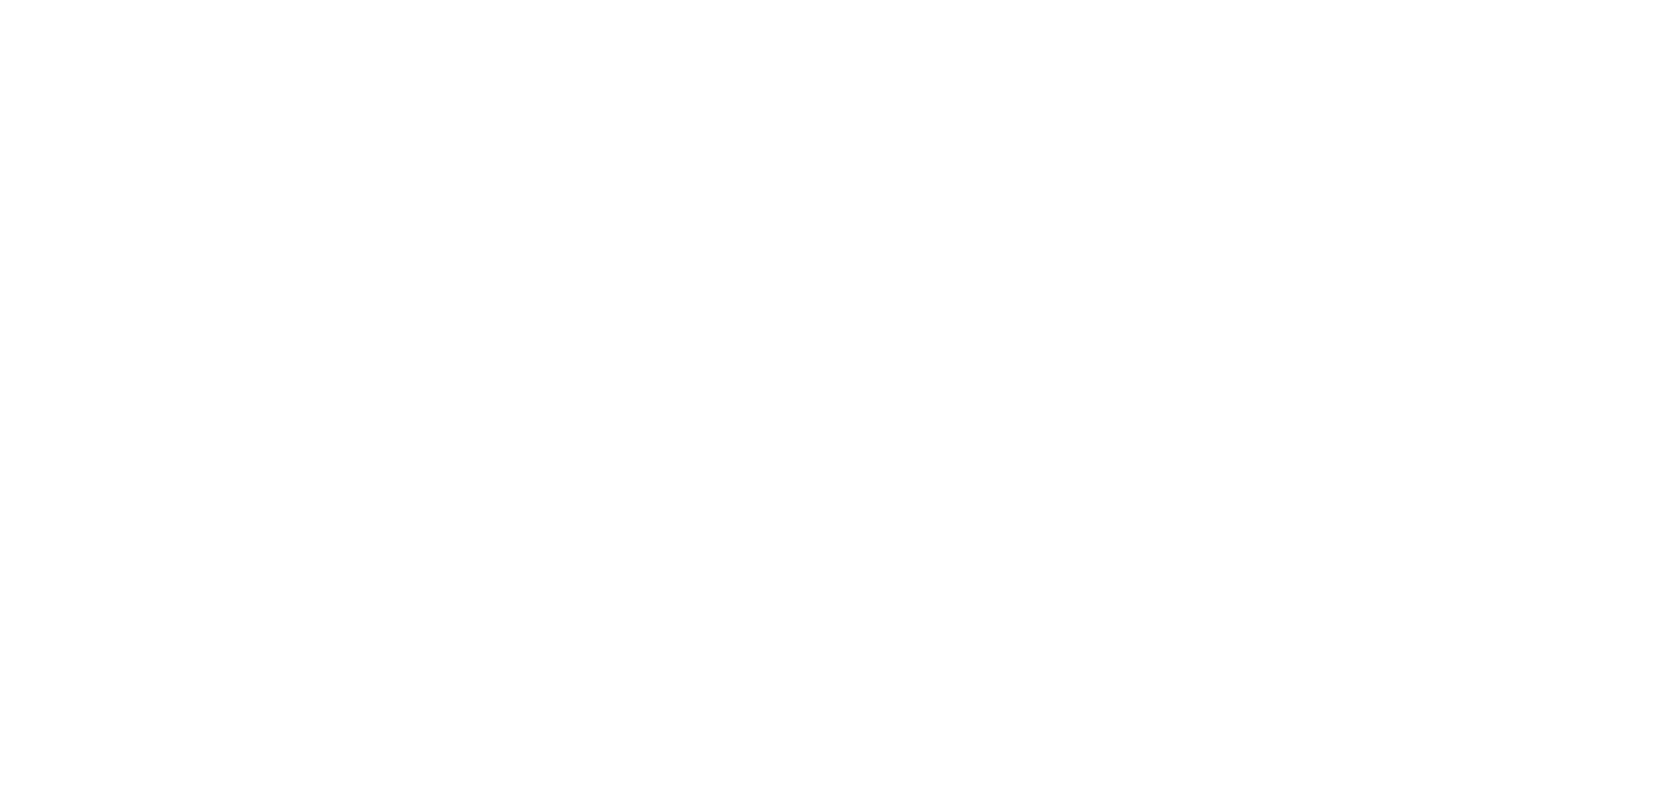

roi25_temporal.png


<IPython.core.display.Javascript object>


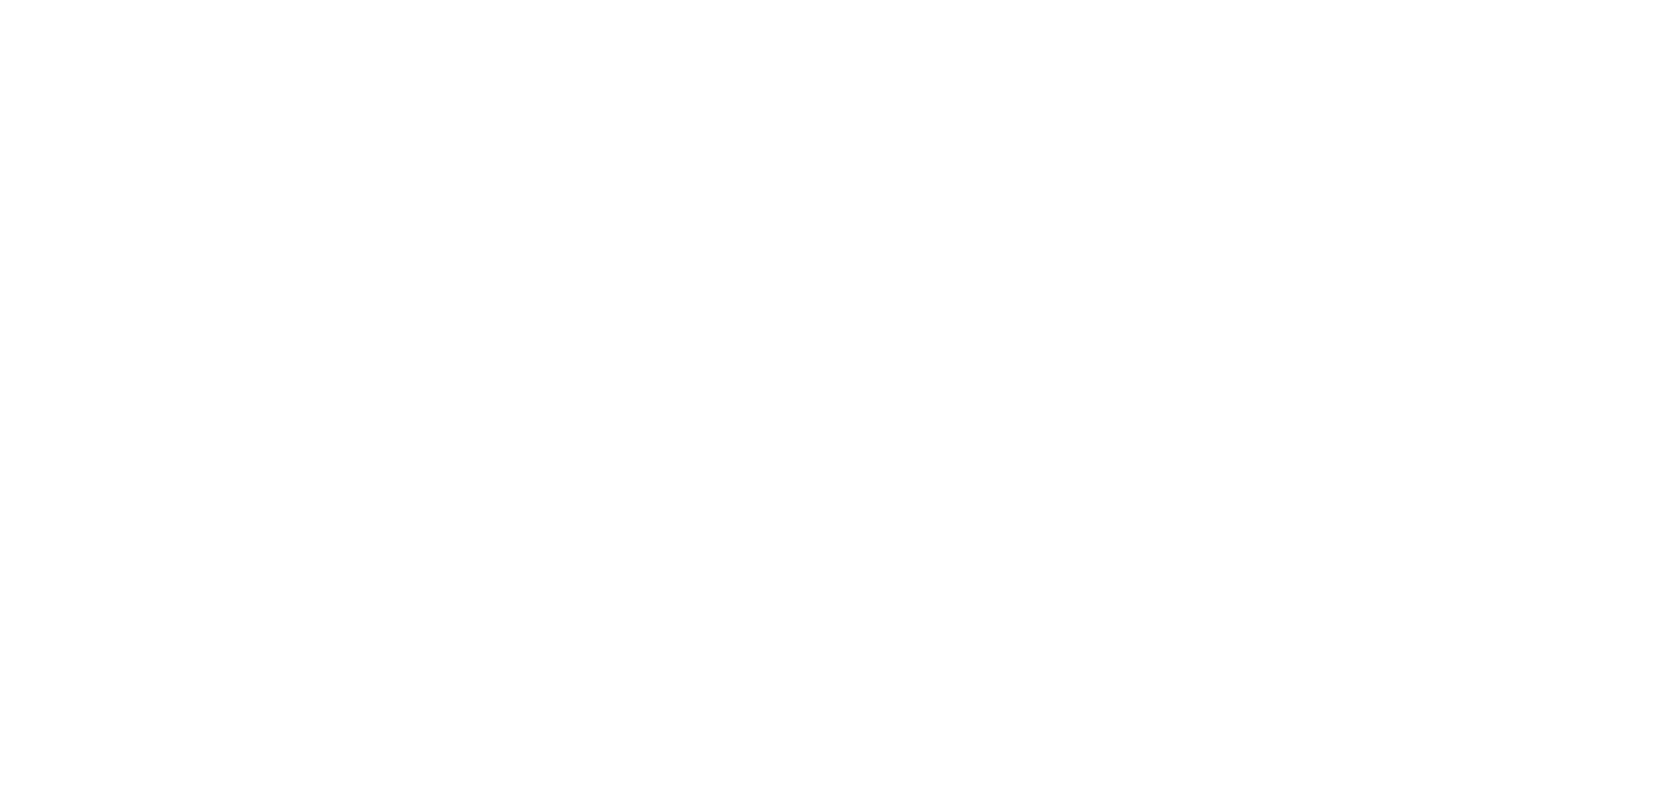

roi26_temporal.png


<IPython.core.display.Javascript object>


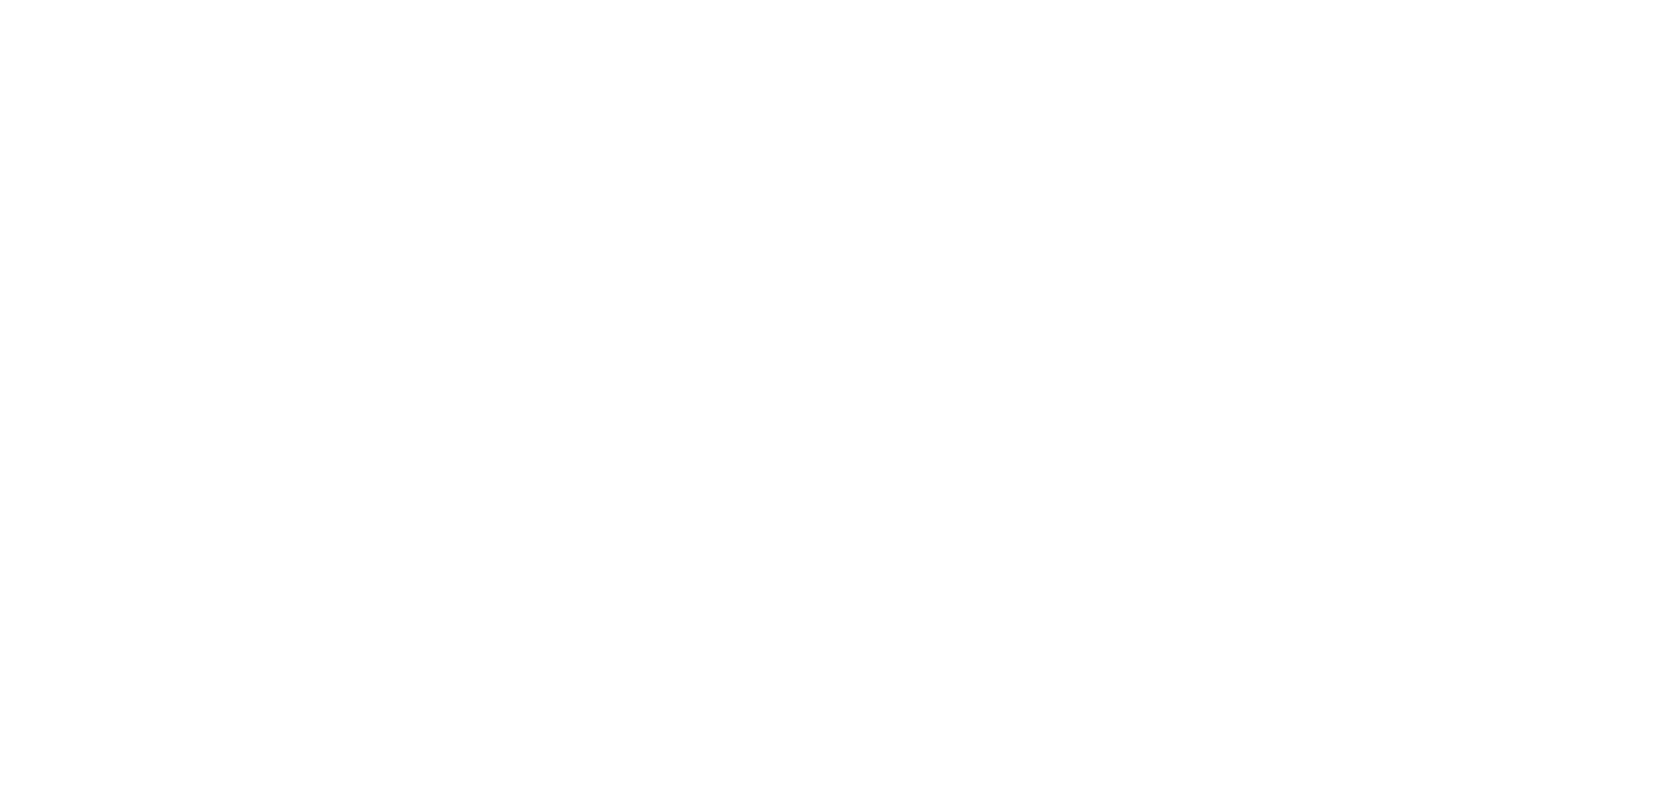

roi27_temporal.png


<IPython.core.display.Javascript object>


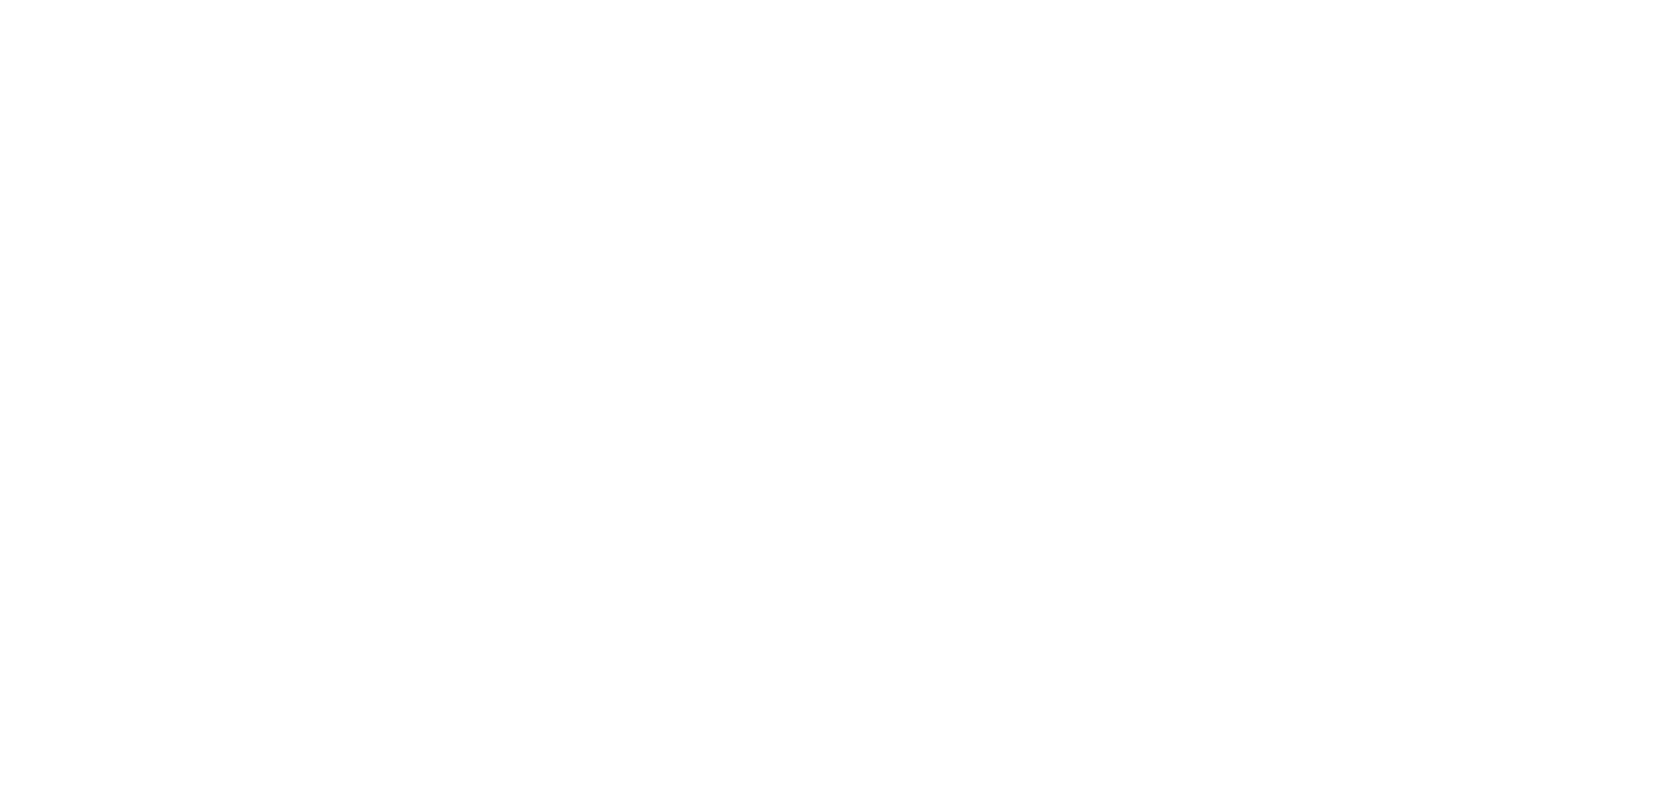

roi28_temporal.png


<IPython.core.display.Javascript object>


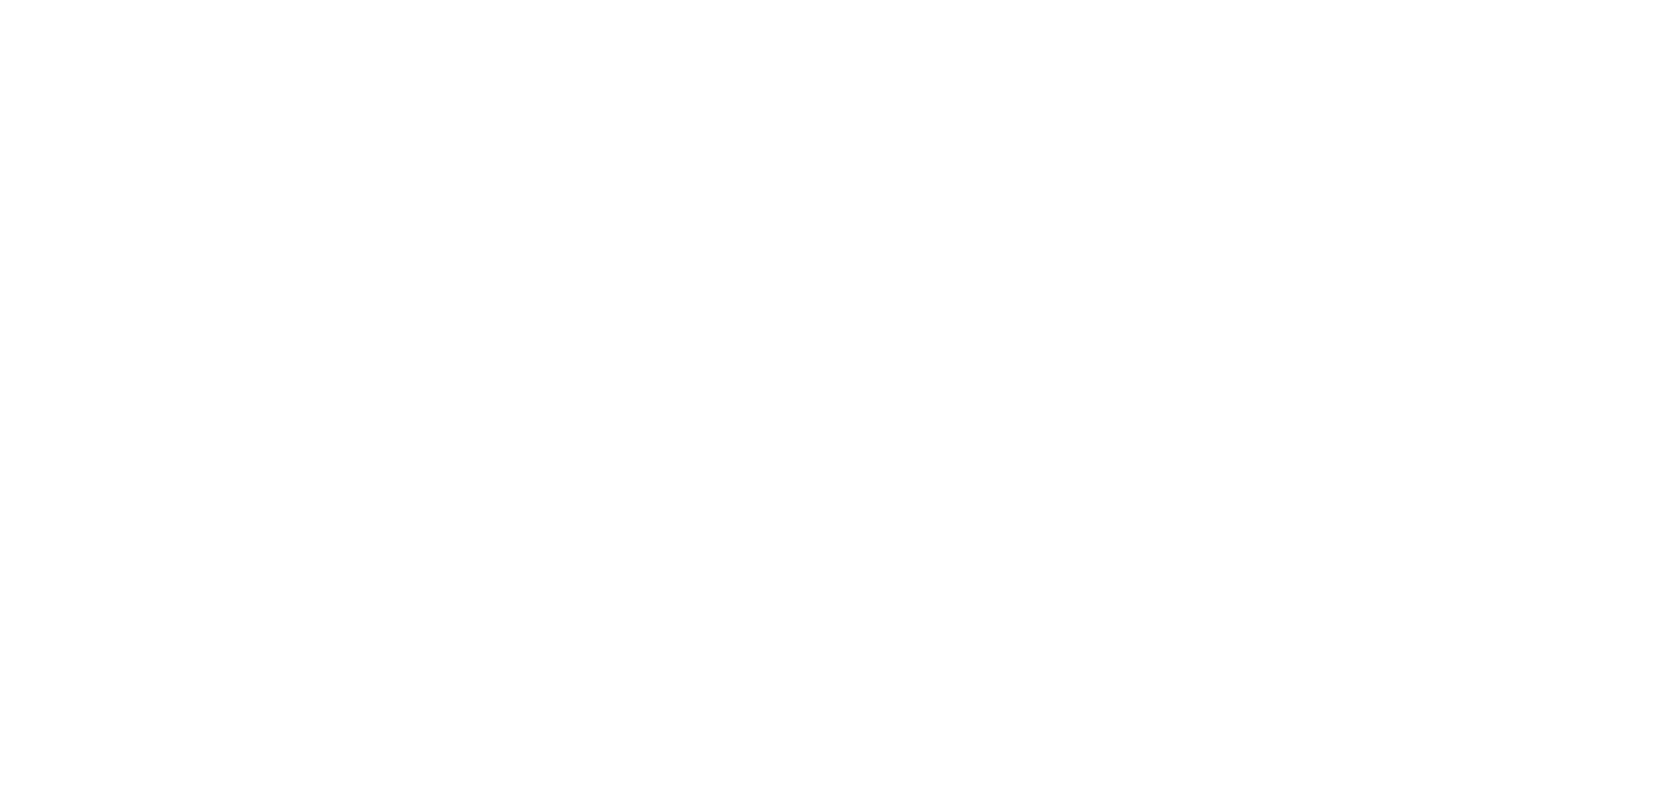

roi29_temporal.png


<IPython.core.display.Javascript object>


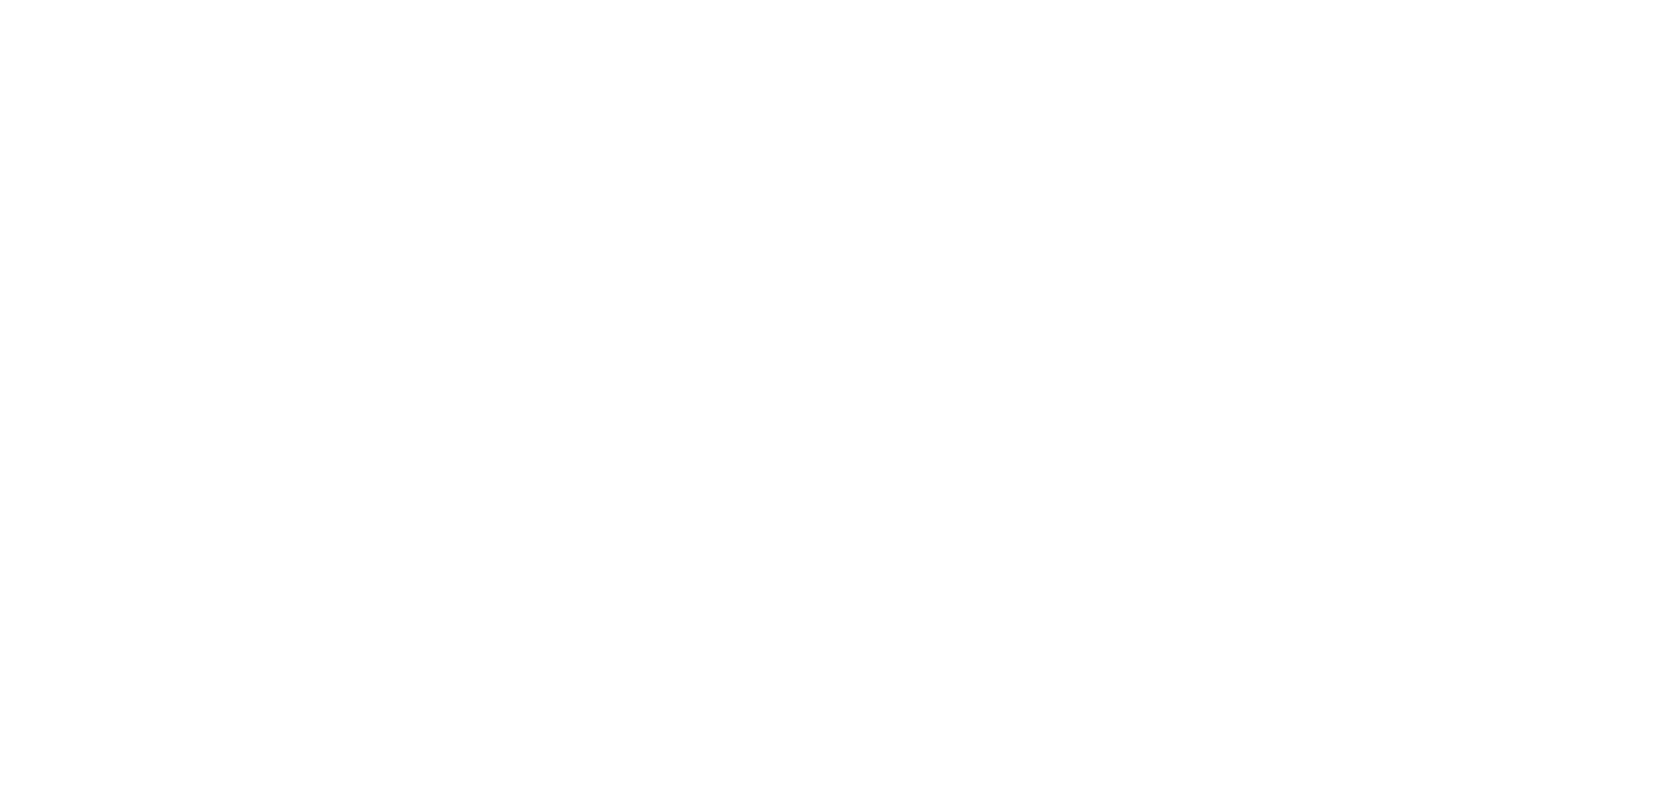

roi30_temporal.png


<IPython.core.display.Javascript object>


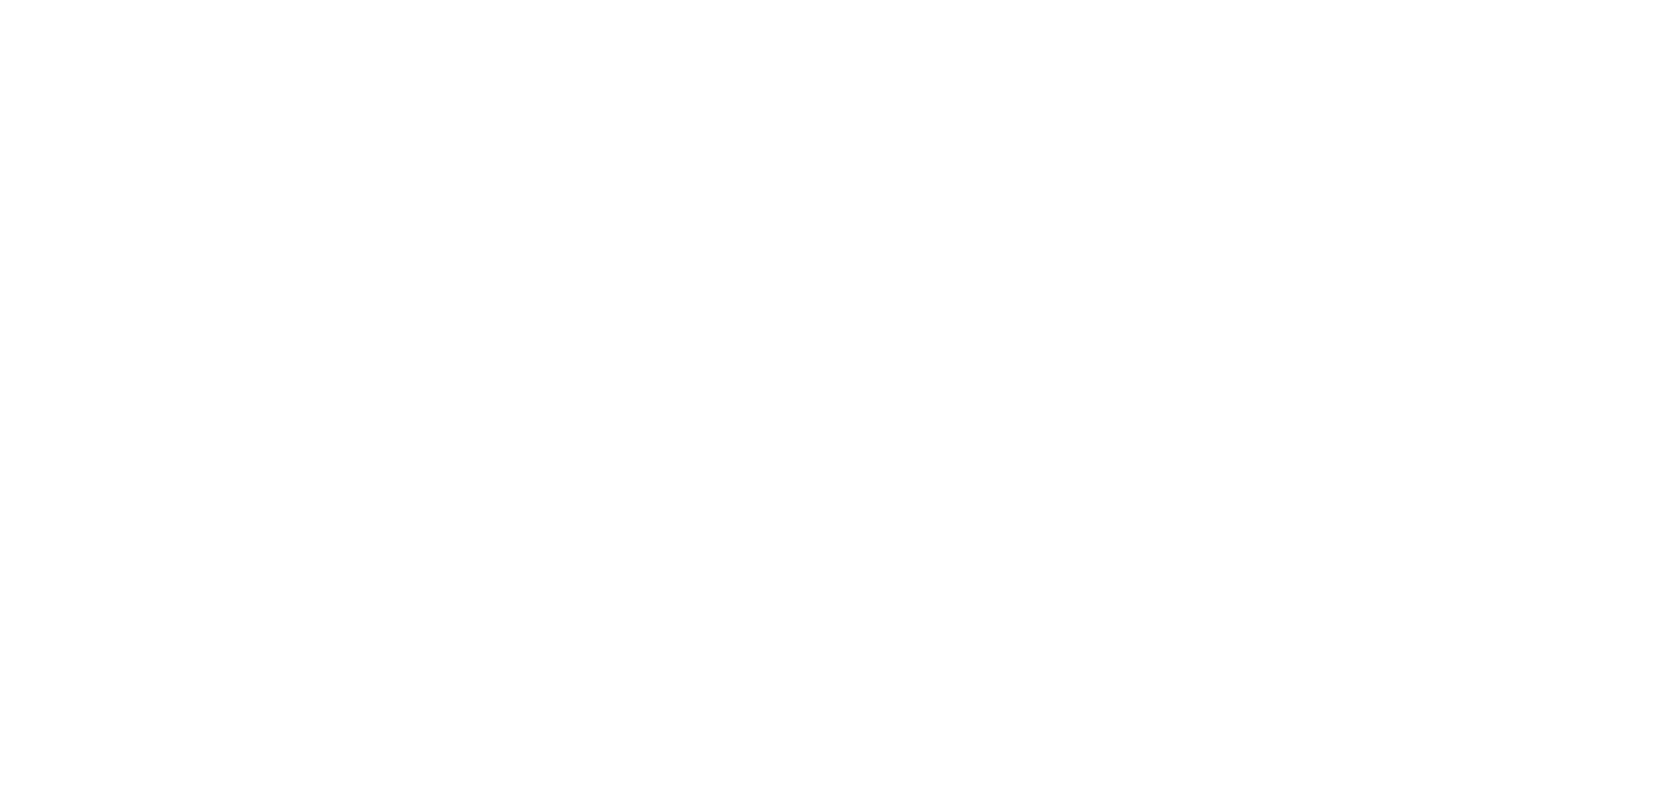

roi31_temporal.png


<IPython.core.display.Javascript object>


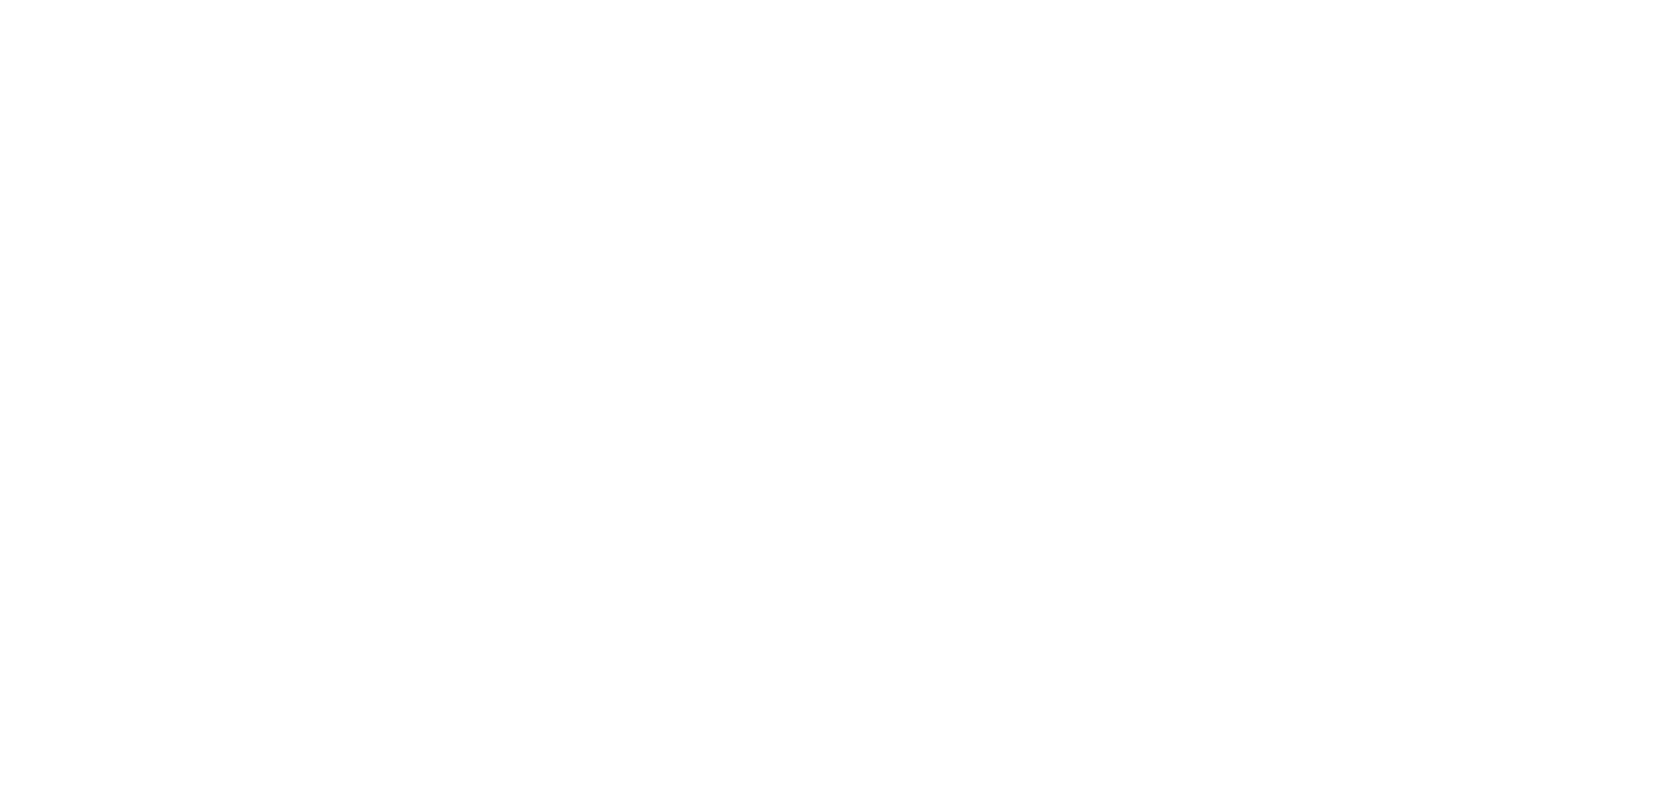

roi32_temporal.png


<IPython.core.display.Javascript object>


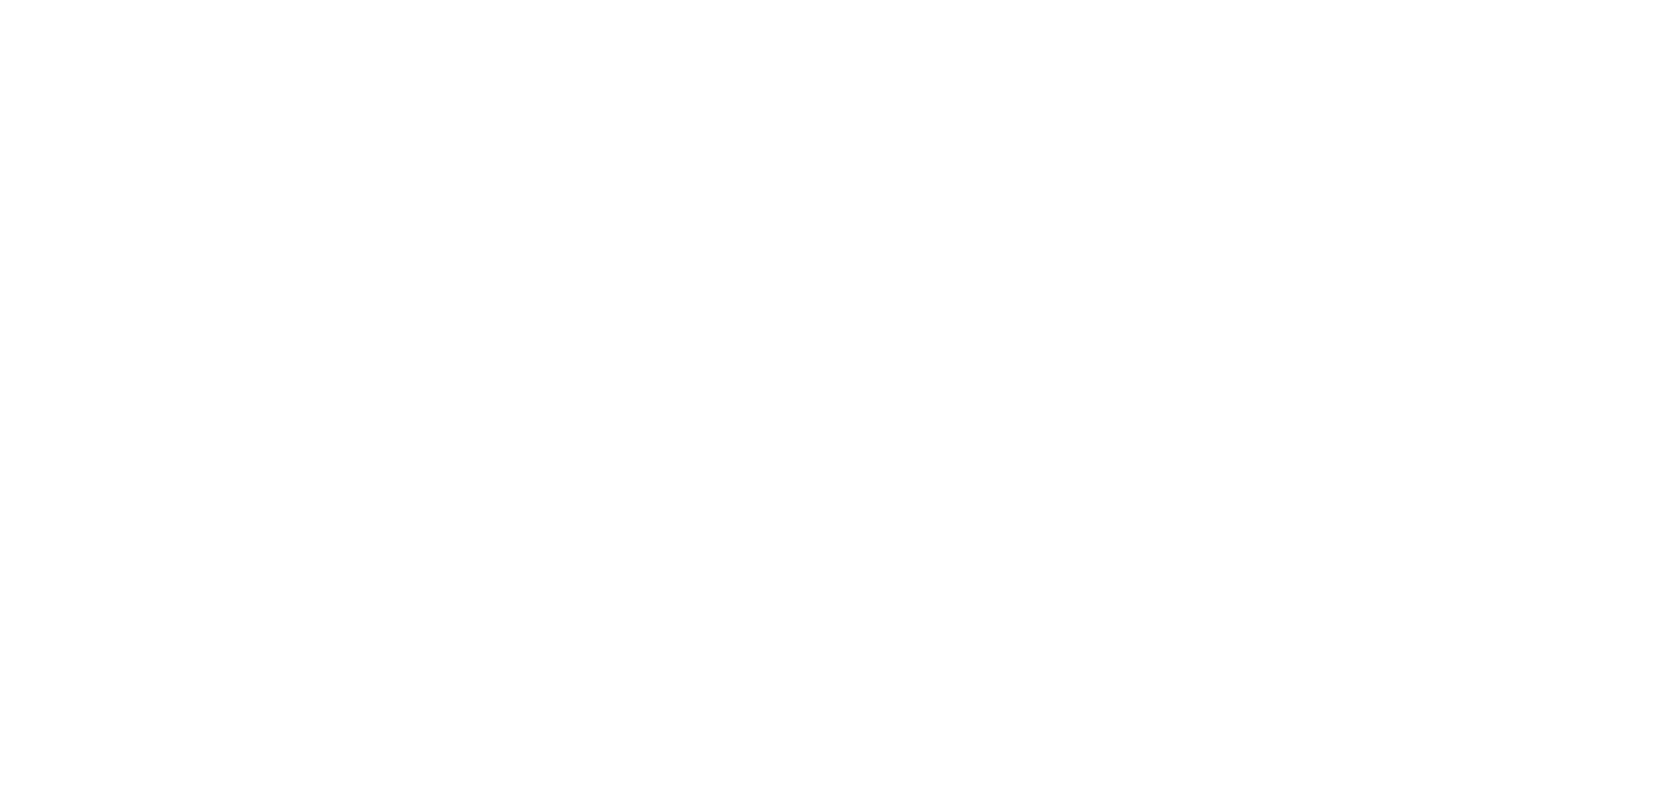

roi33_temporal.png


<IPython.core.display.Javascript object>


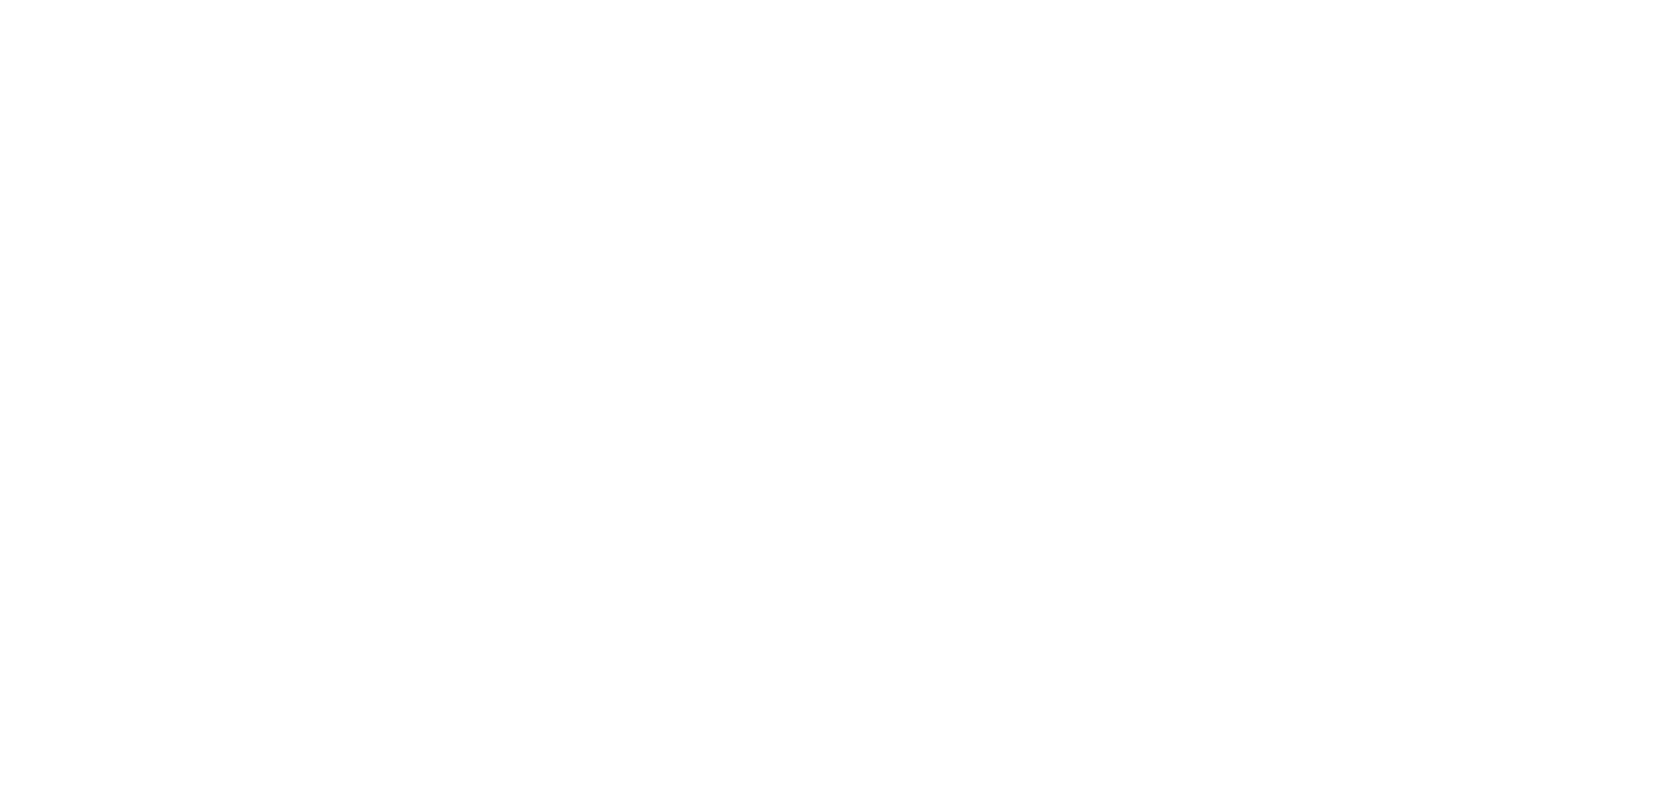

roi34_temporal.png


<IPython.core.display.Javascript object>


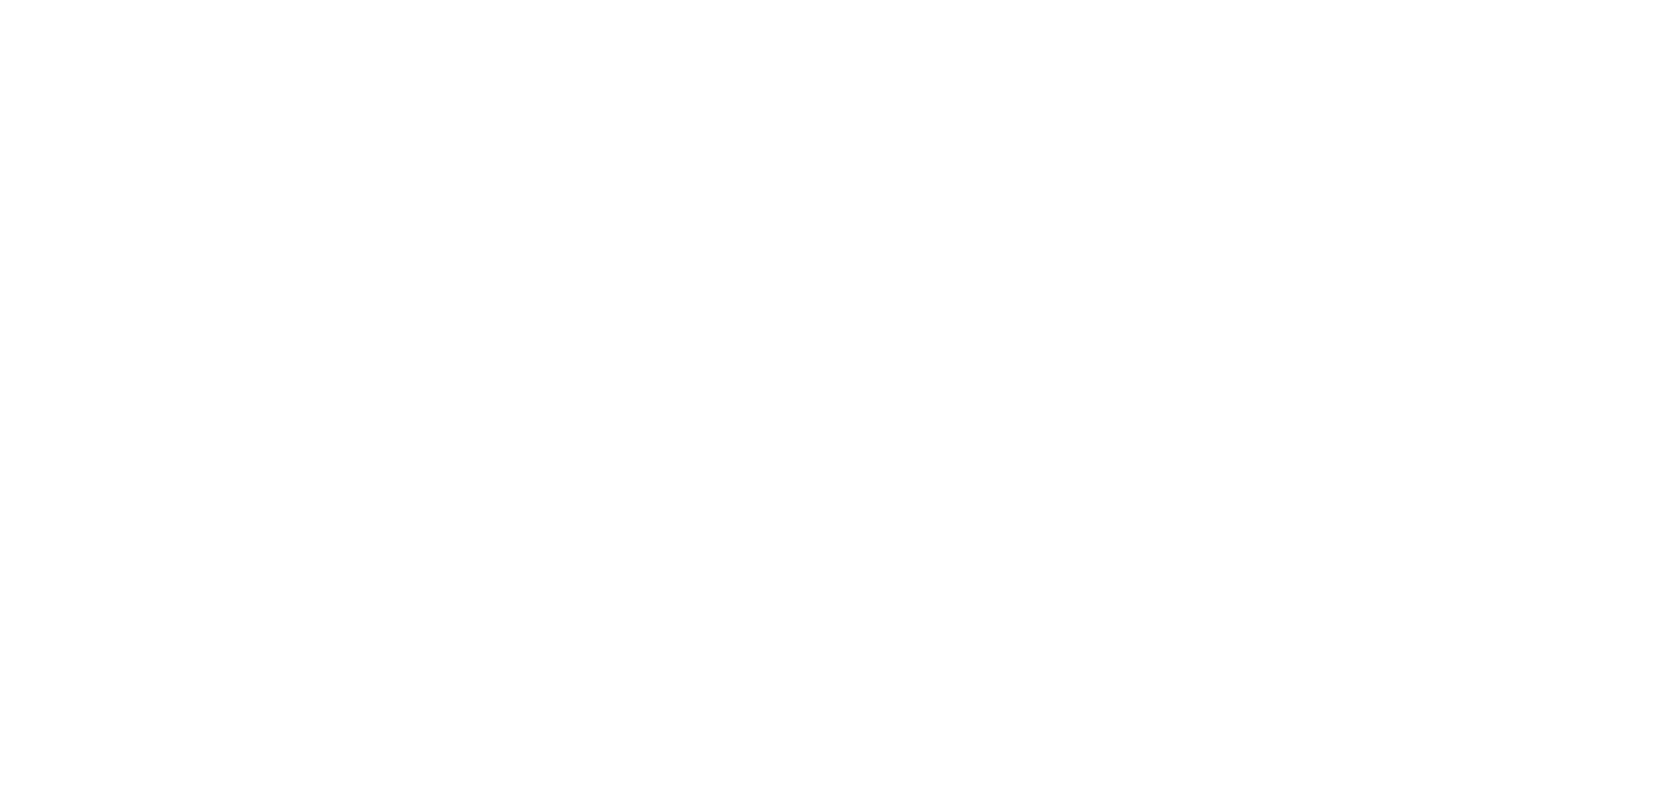

roi35_temporal.png


<IPython.core.display.Javascript object>


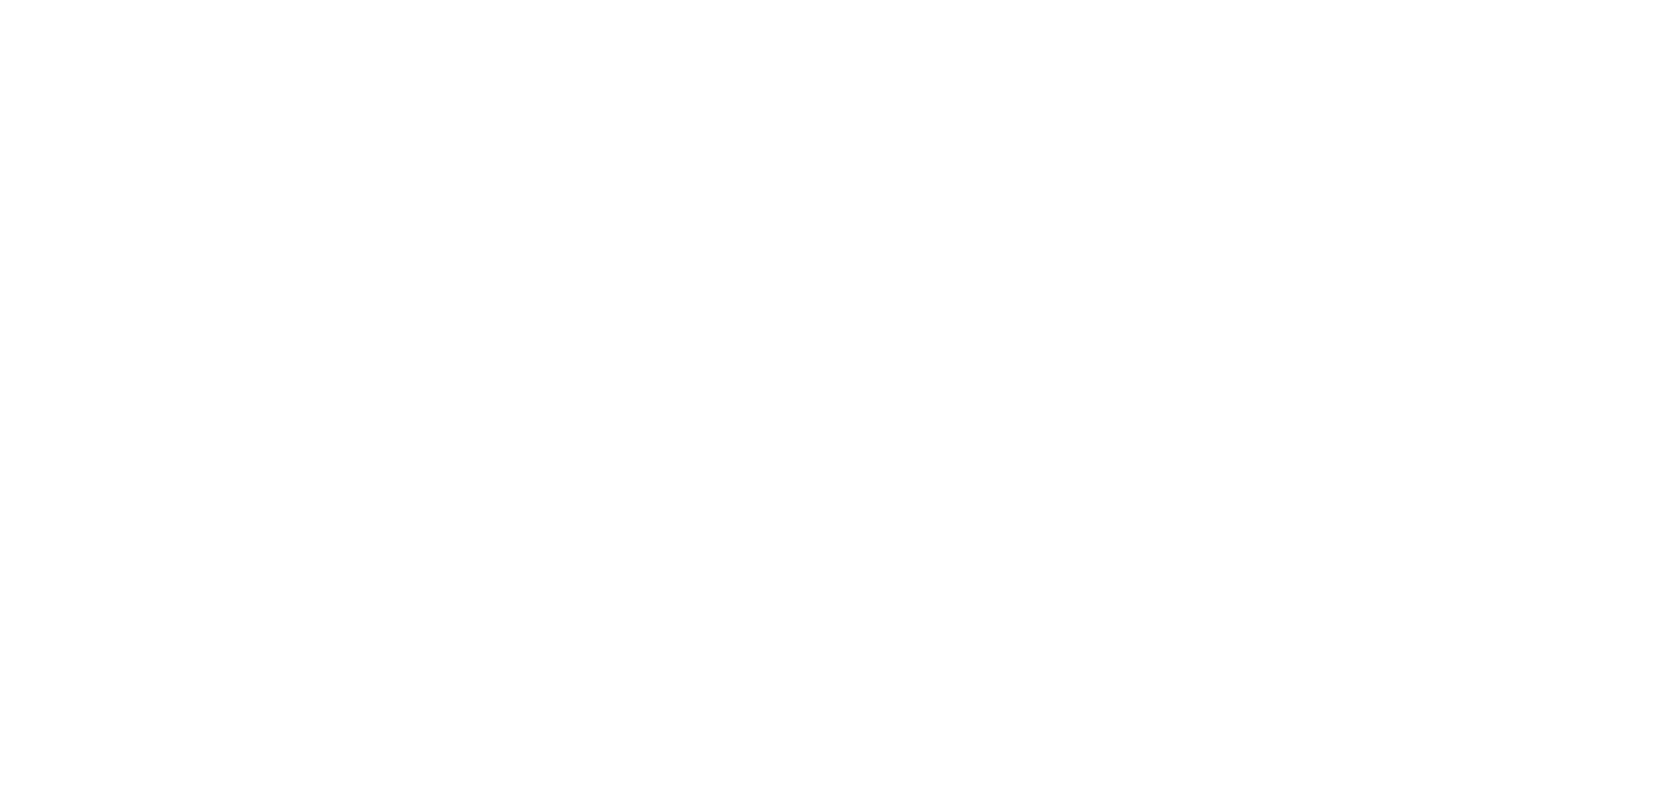

roi36_temporal.png


<IPython.core.display.Javascript object>


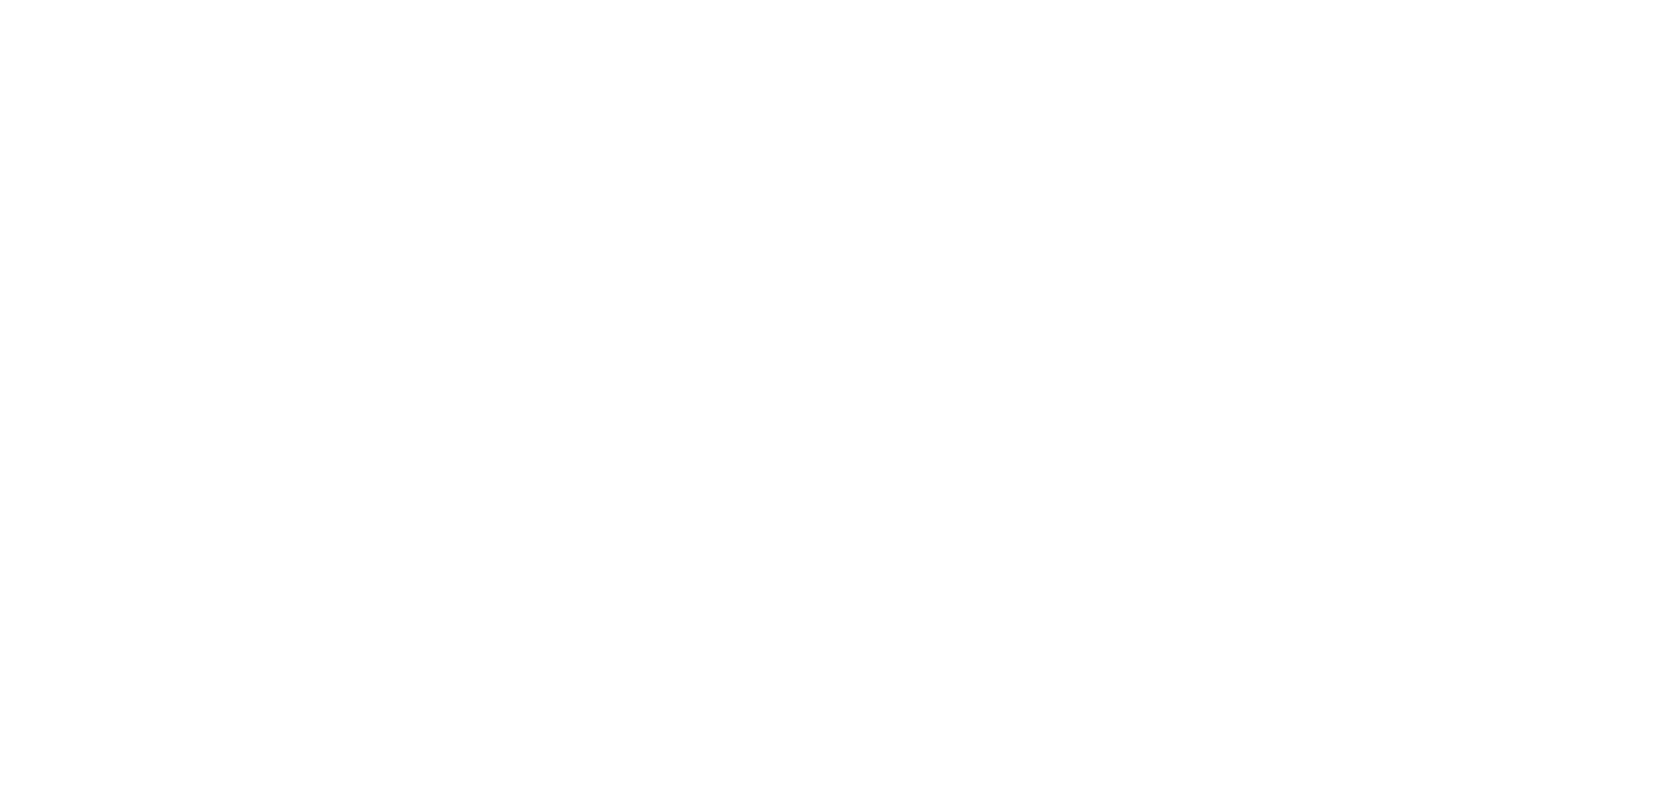

roi37_temporal.png


<IPython.core.display.Javascript object>


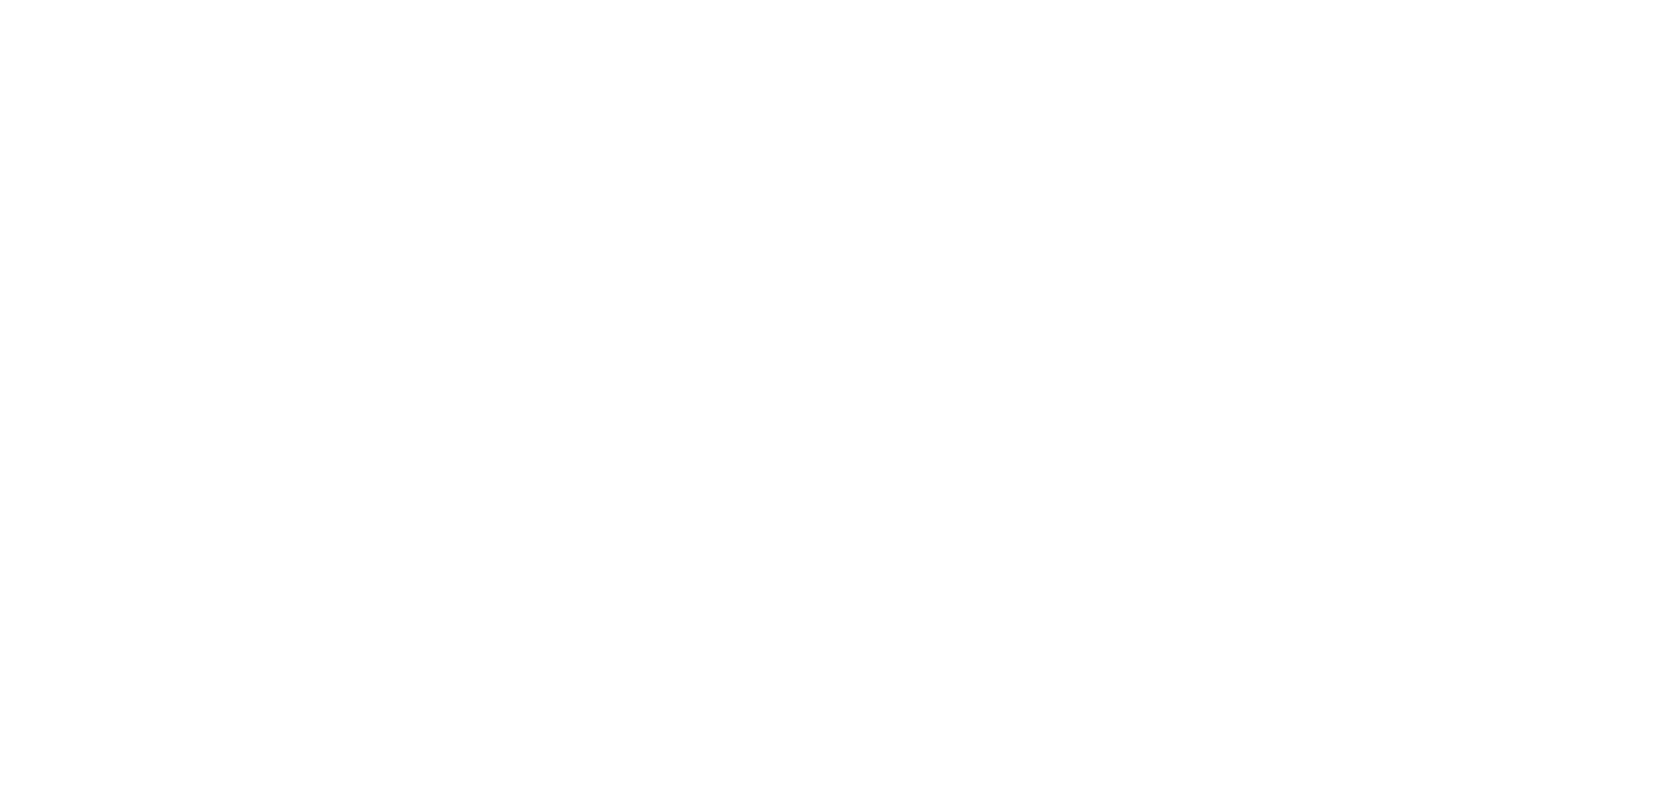

roi38_temporal.png


<IPython.core.display.Javascript object>


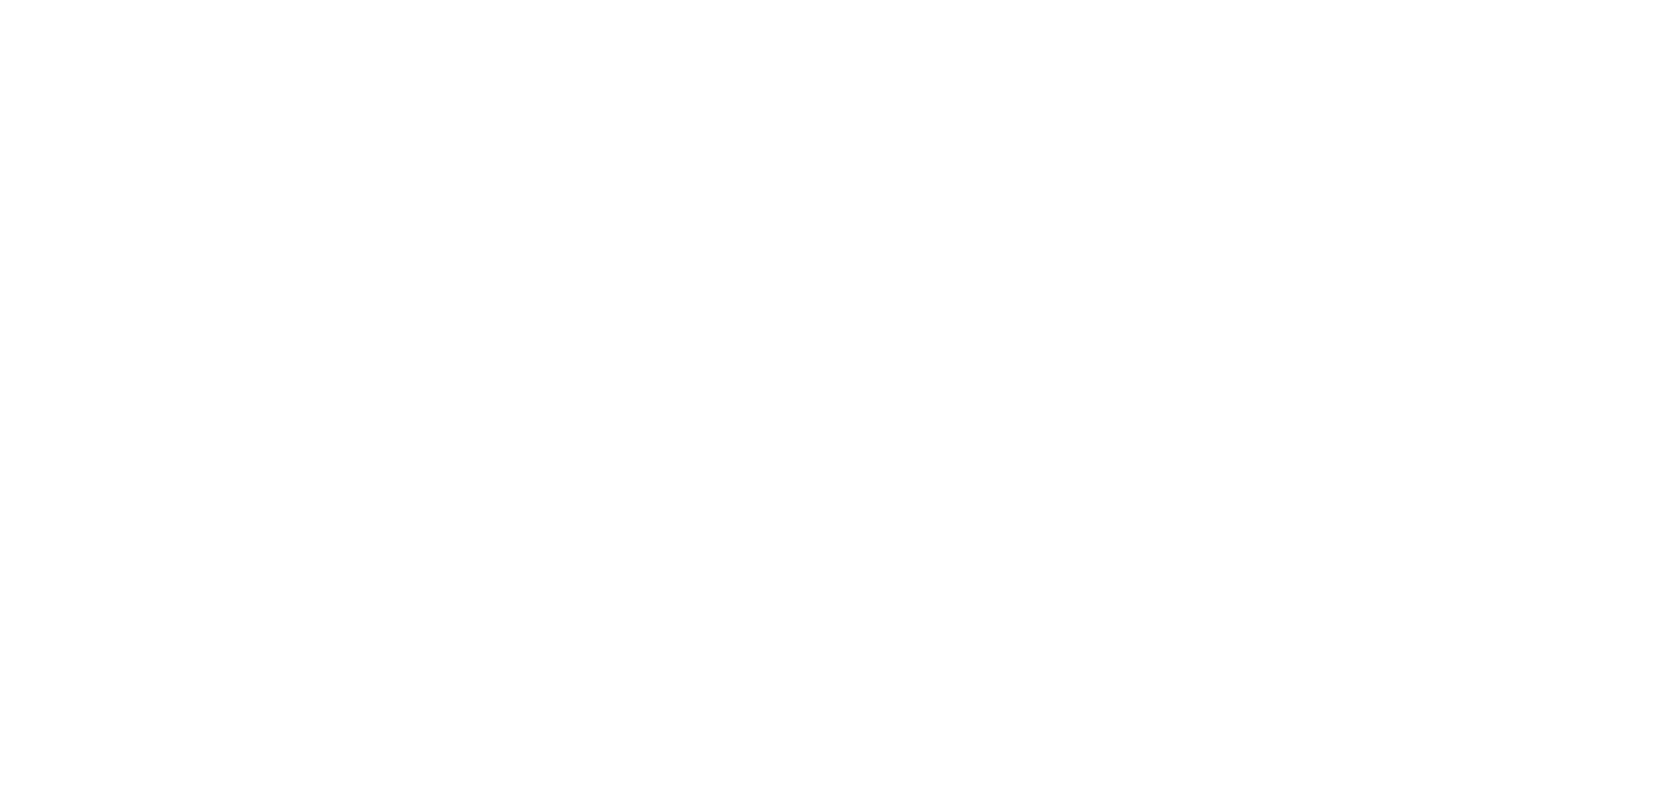

roi39_temporal.png


<IPython.core.display.Javascript object>


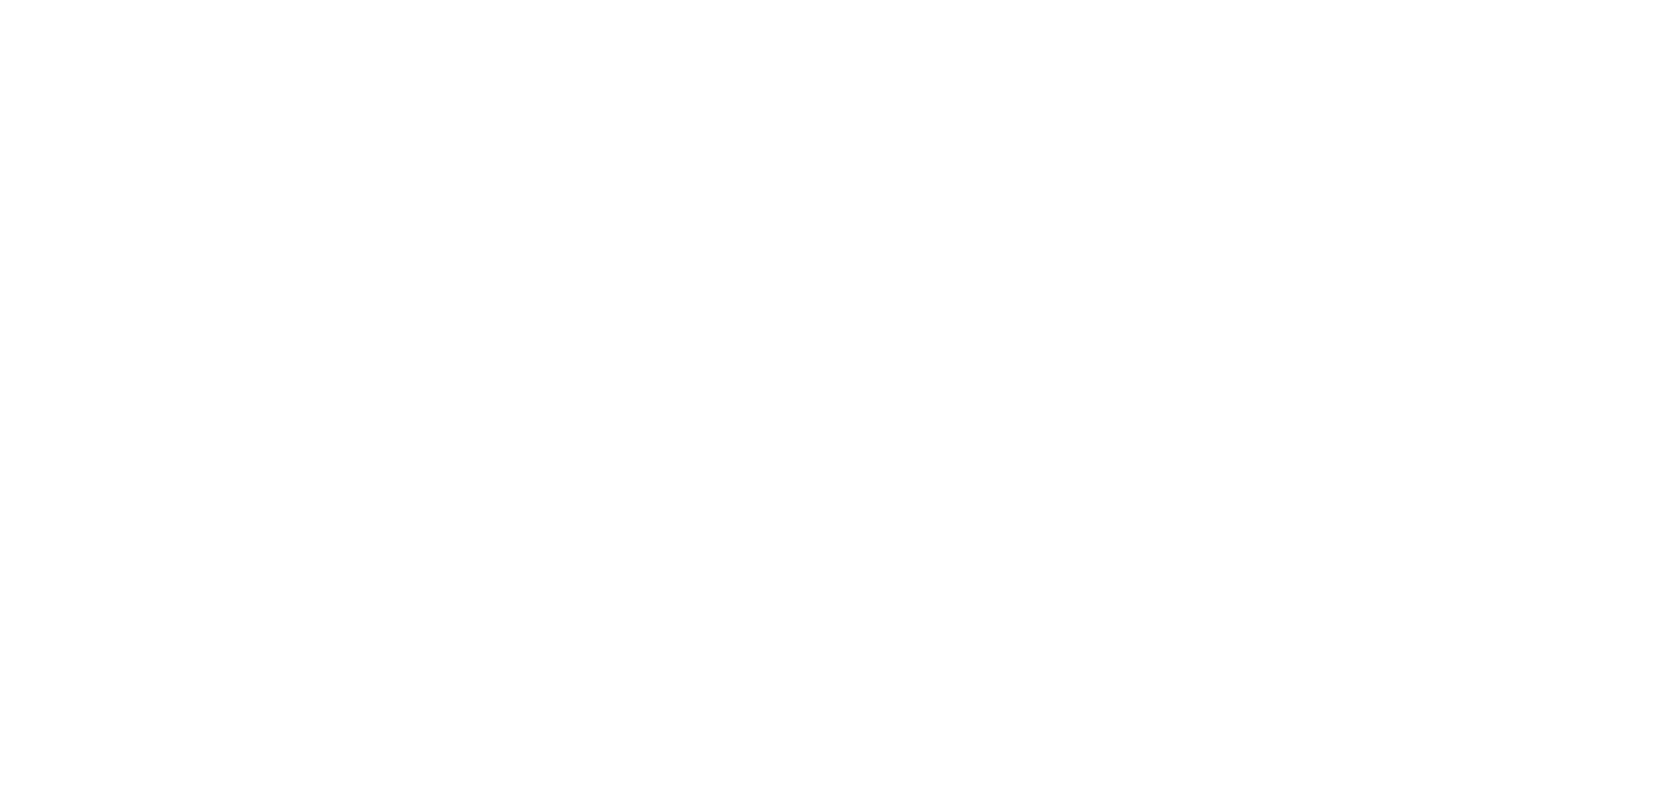

roi40_temporal.png


<IPython.core.display.Javascript object>


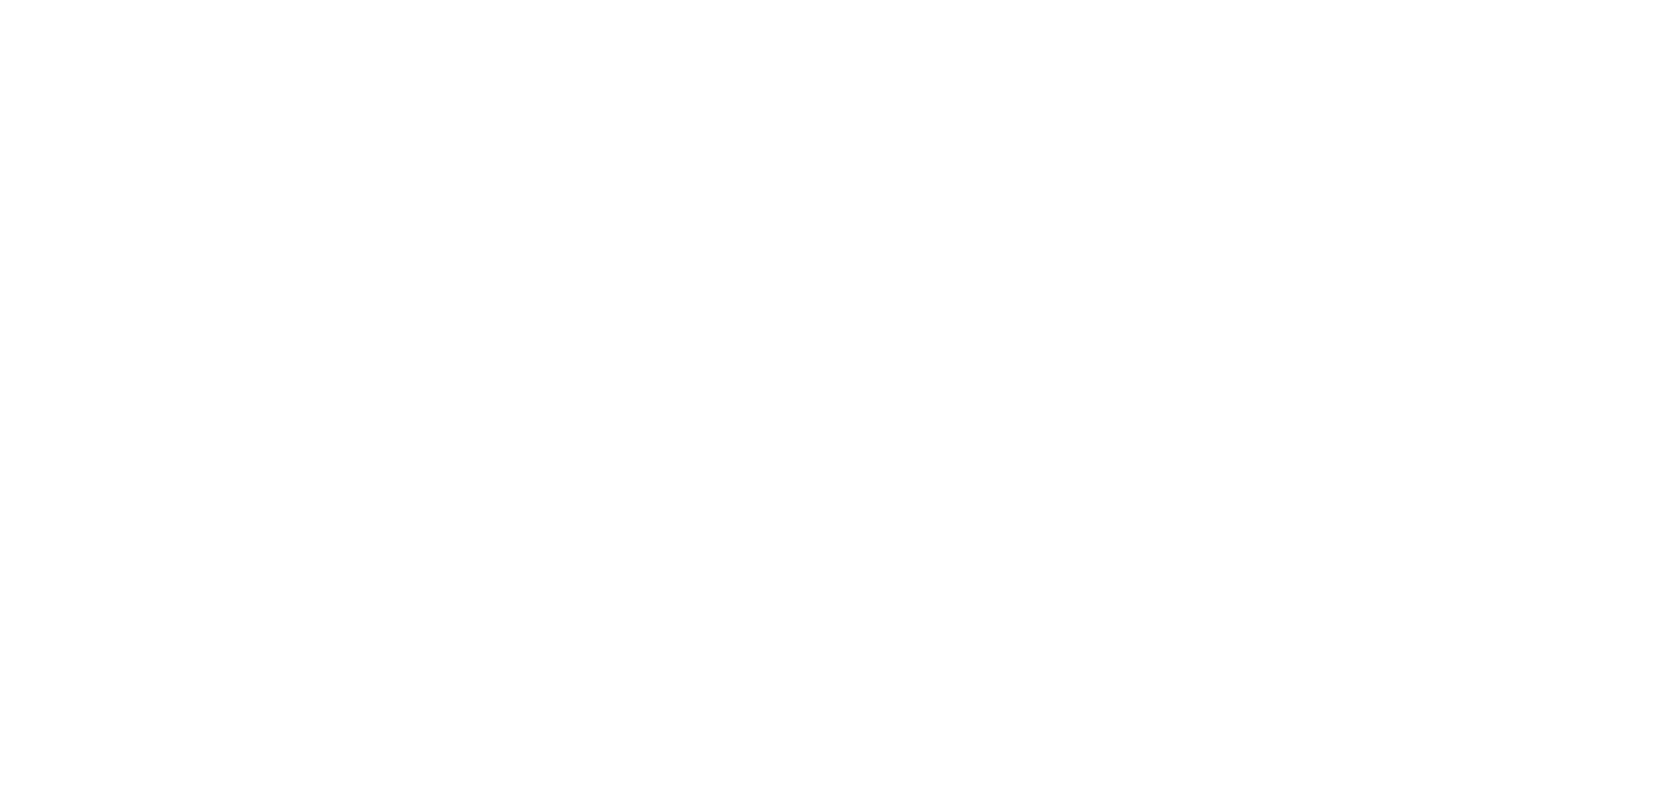

roi41_temporal.png


<IPython.core.display.Javascript object>


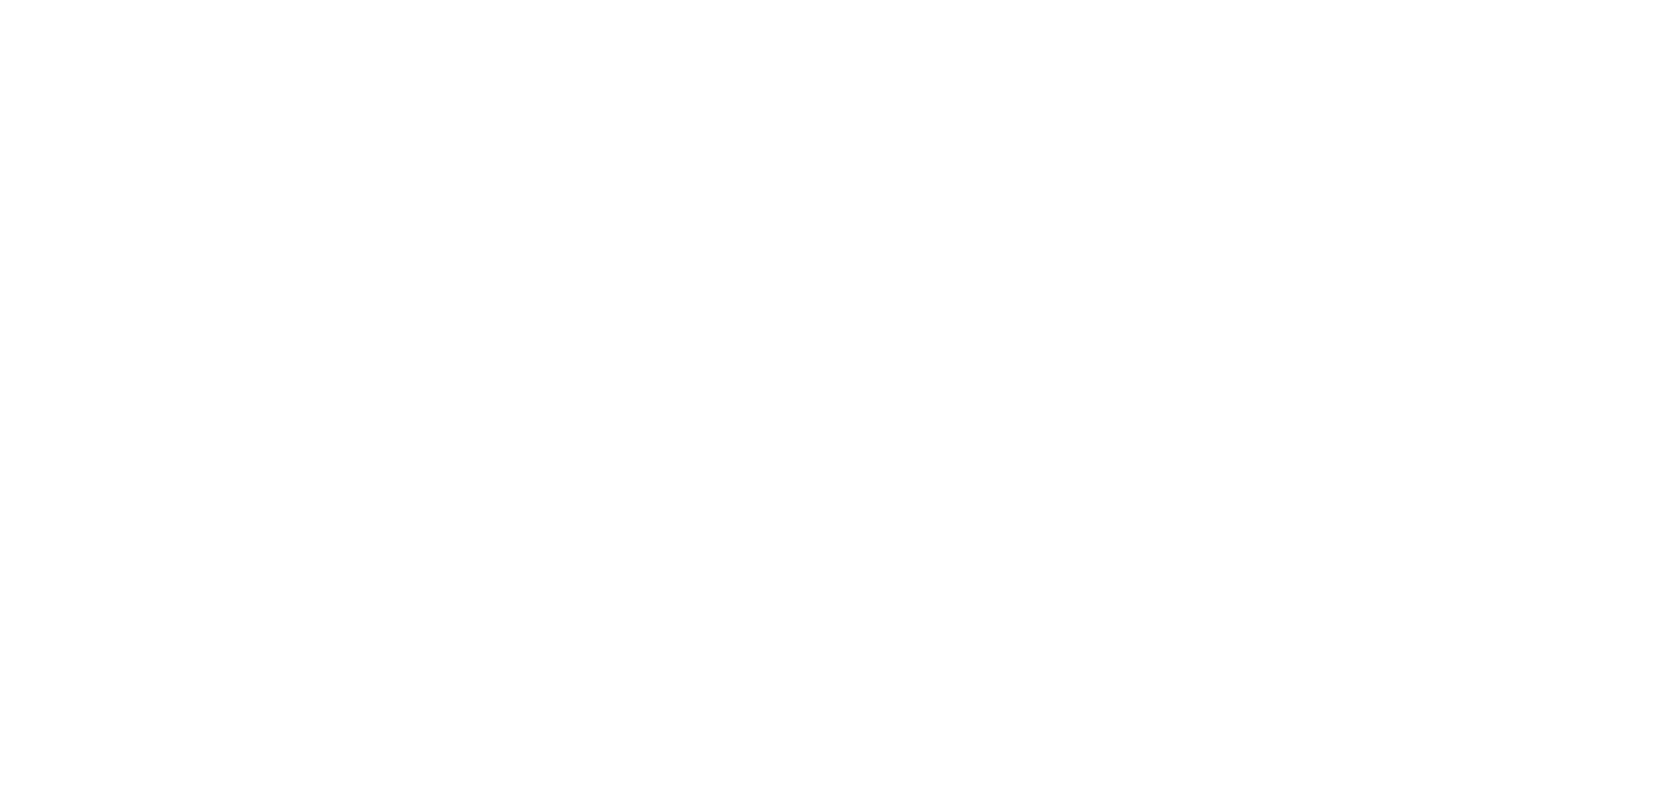

roi42_temporal.png


<IPython.core.display.Javascript object>


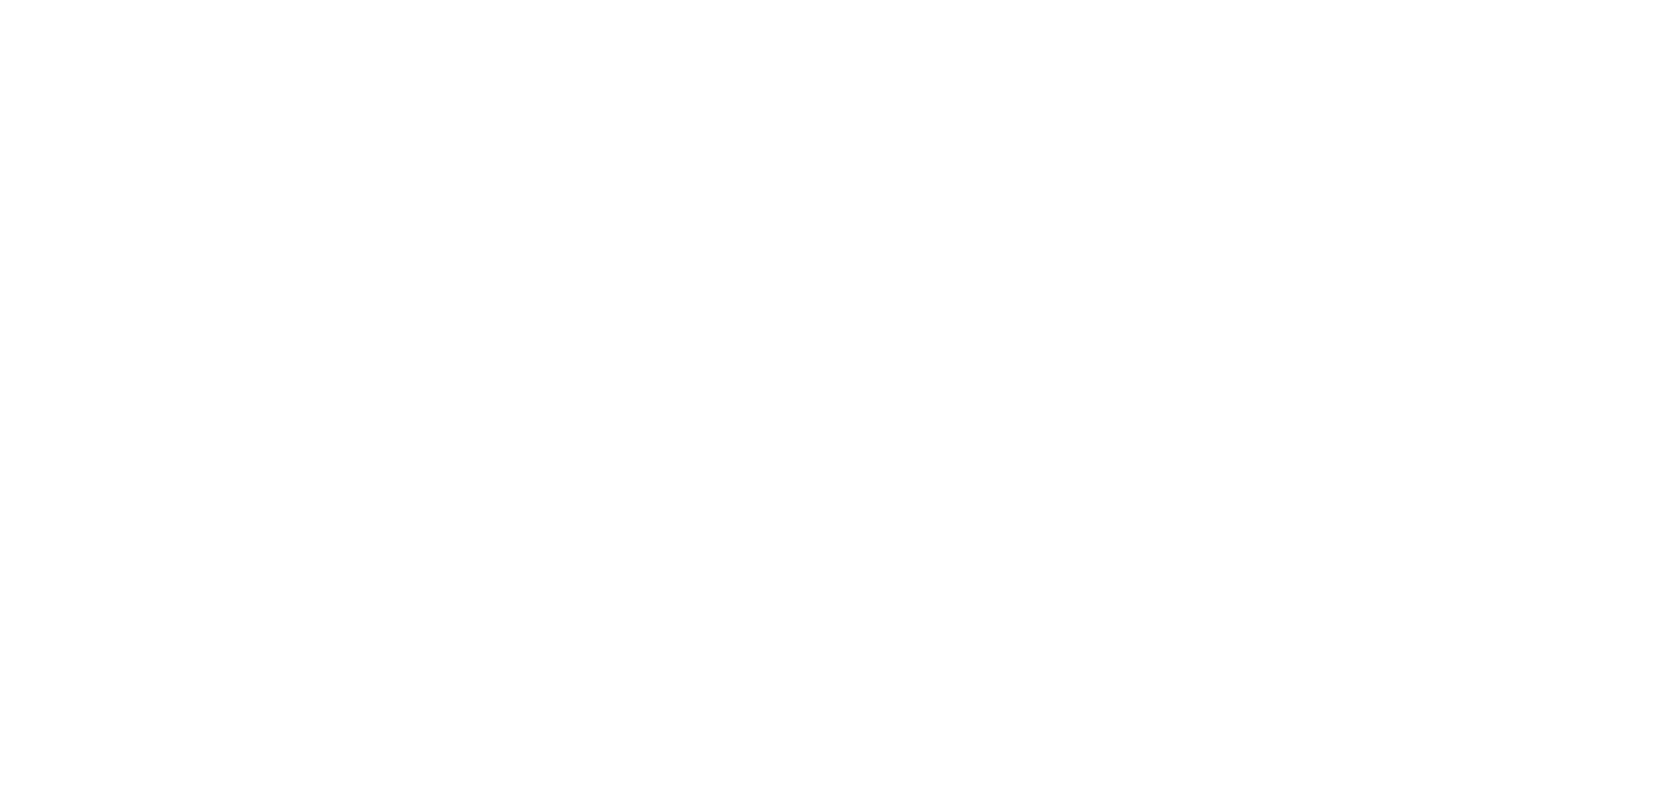

roi43_temporal.png


<IPython.core.display.Javascript object>


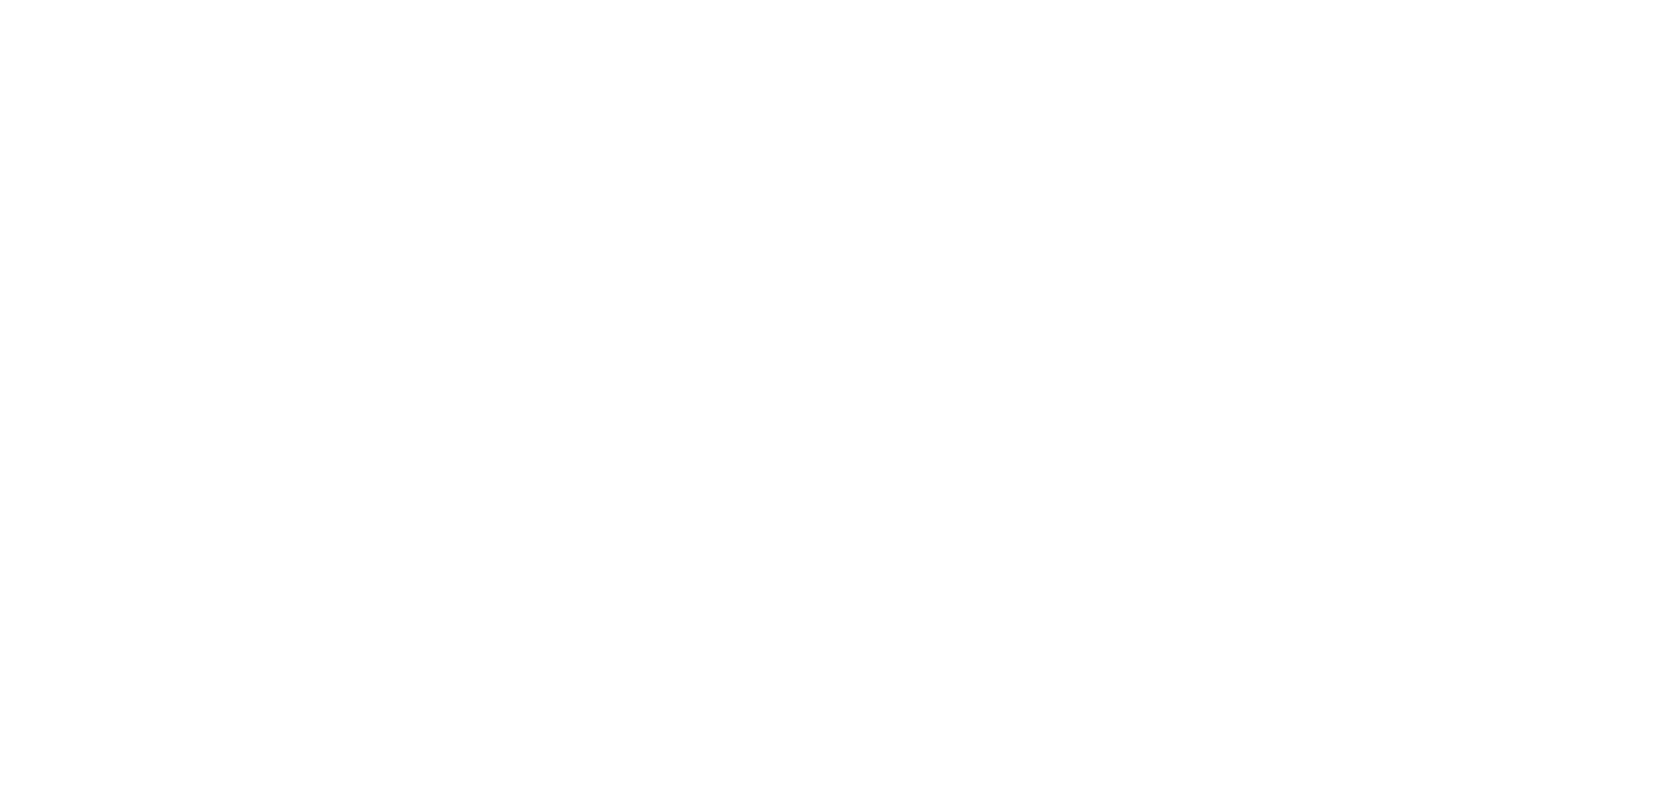

roi44_temporal.png


<IPython.core.display.Javascript object>


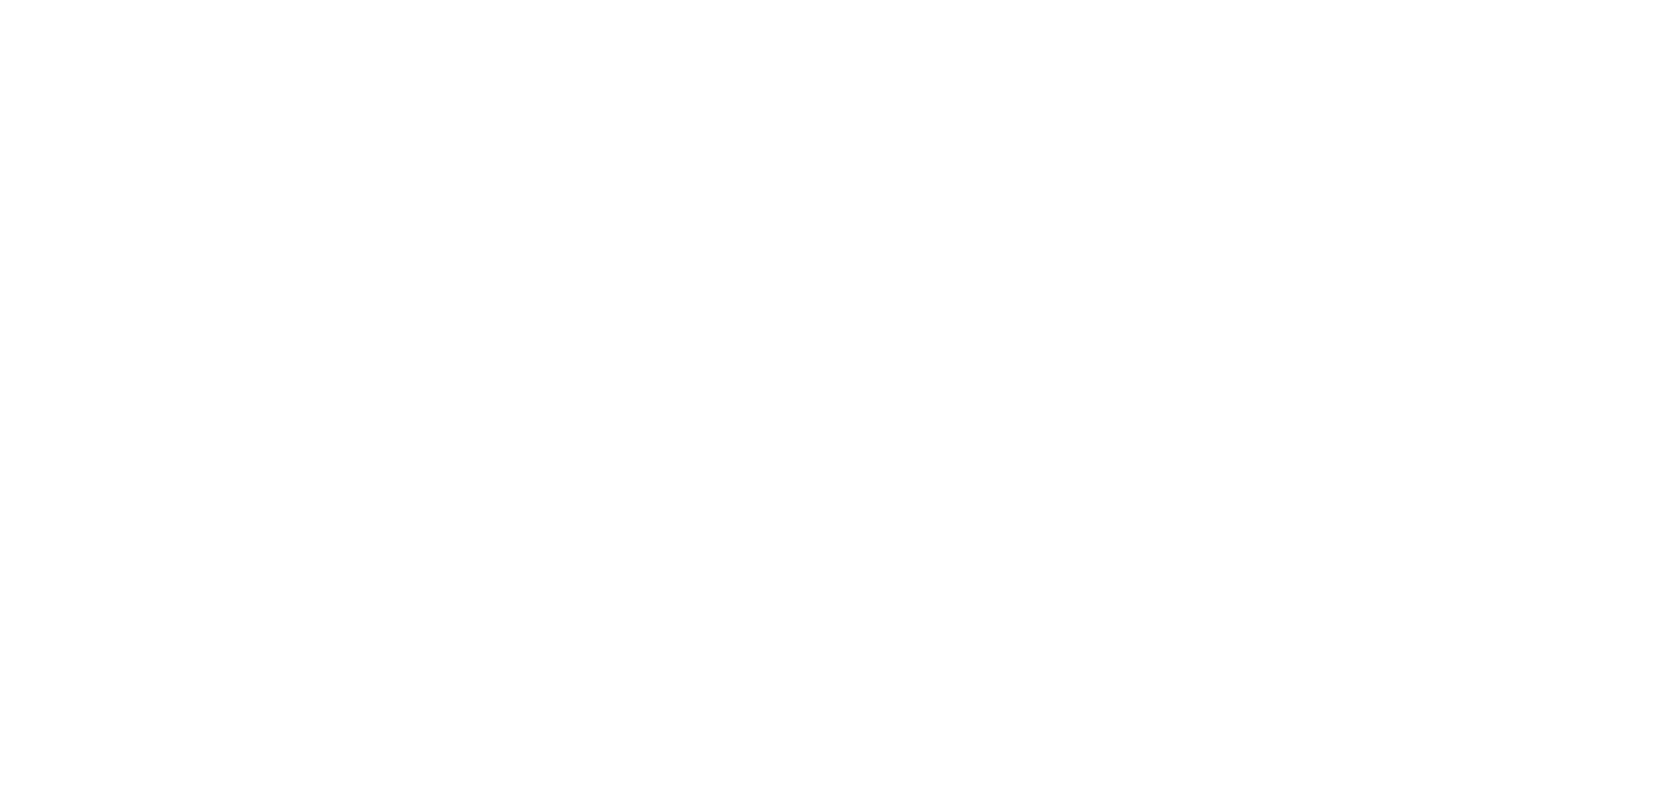

roi45_temporal.png


<IPython.core.display.Javascript object>


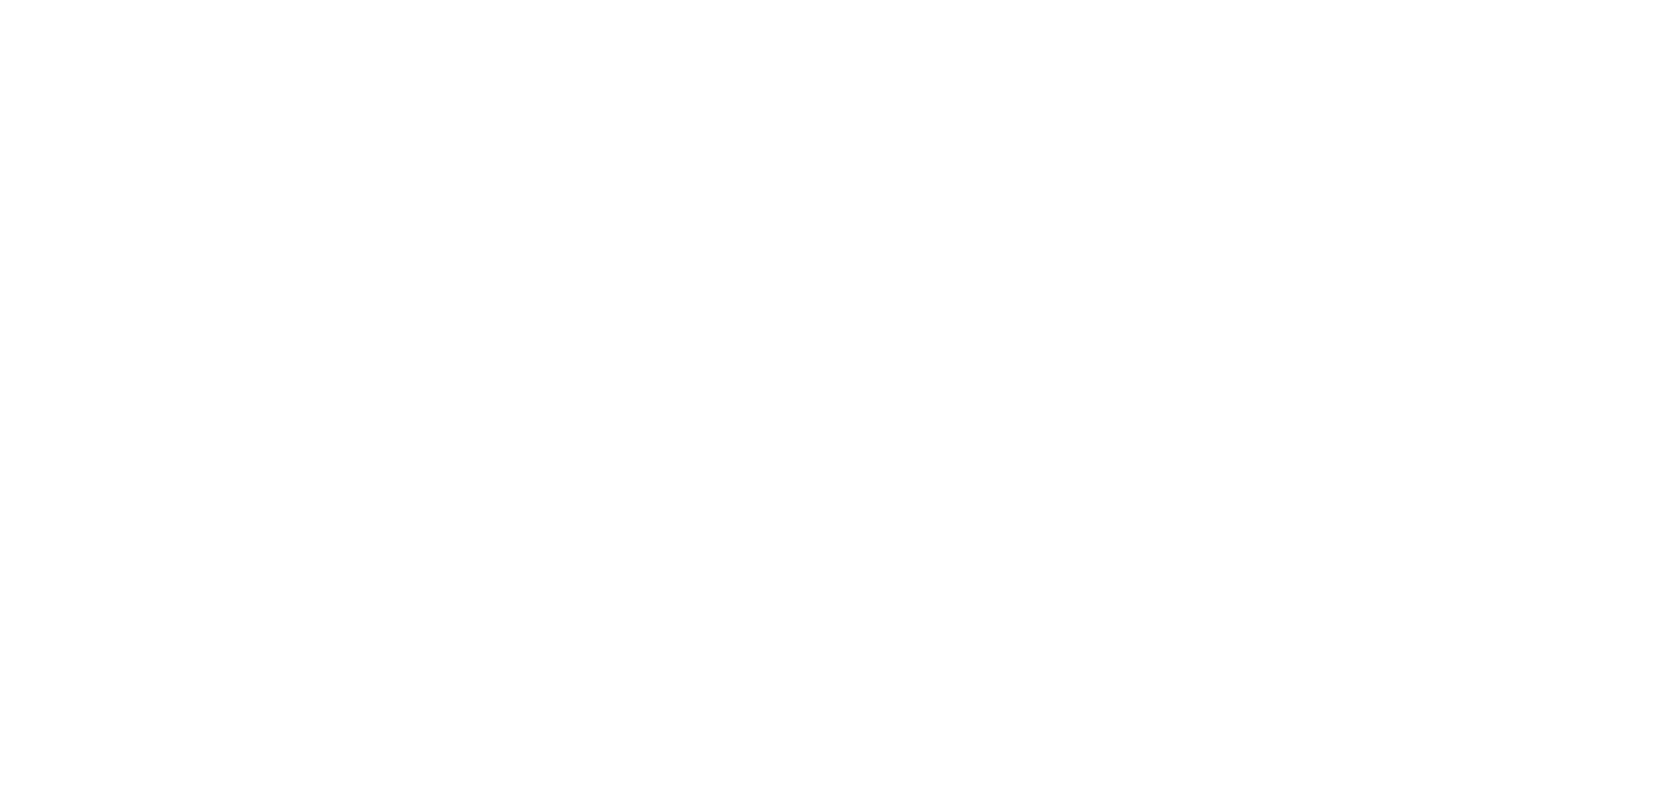

roi46_temporal.png


<IPython.core.display.Javascript object>


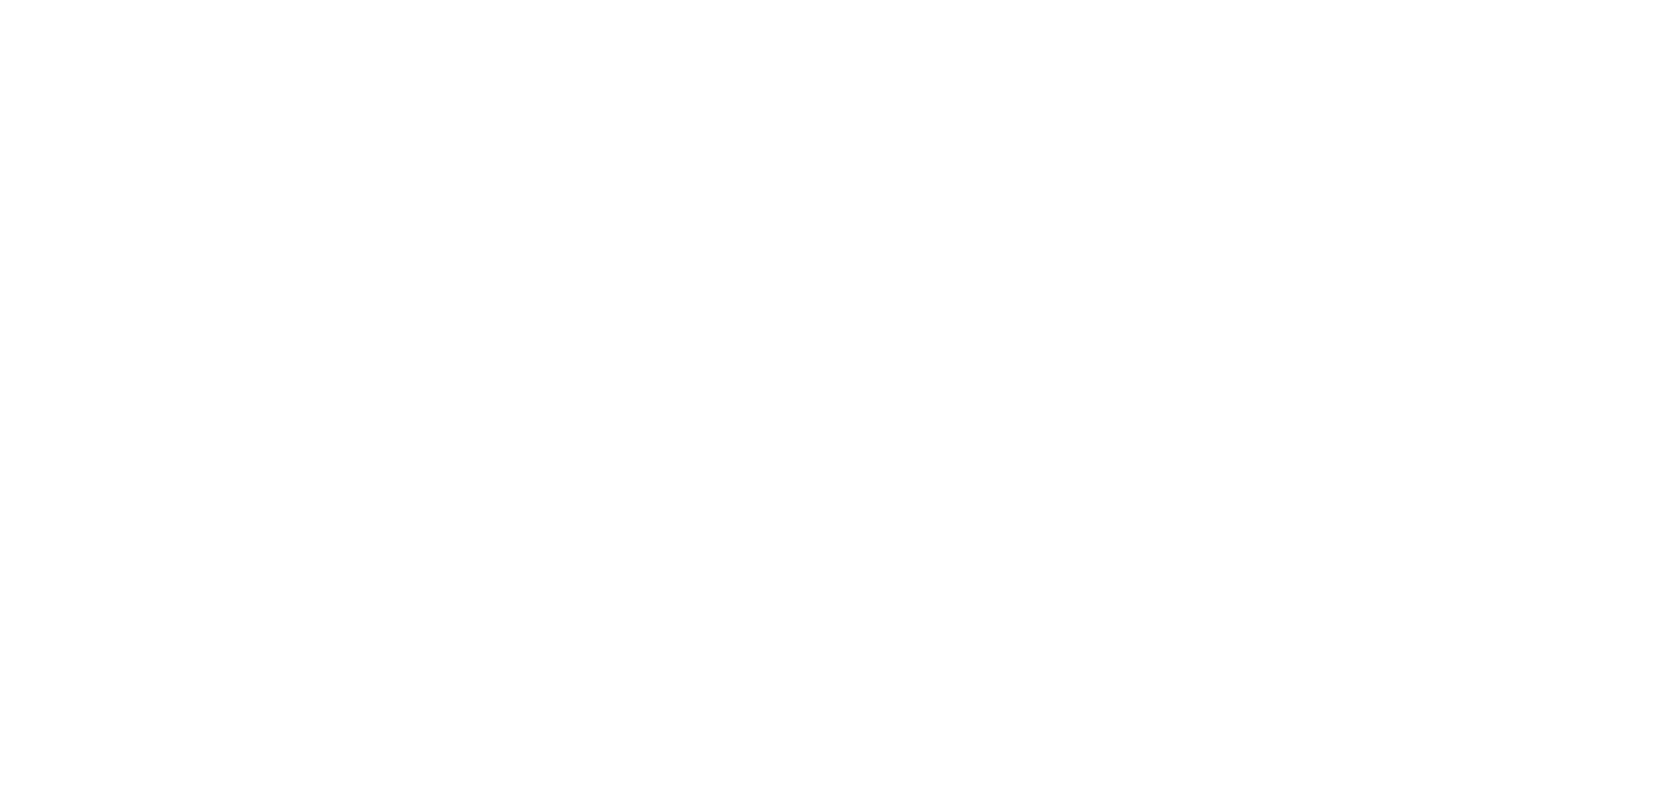

roi47_temporal.png


<IPython.core.display.Javascript object>


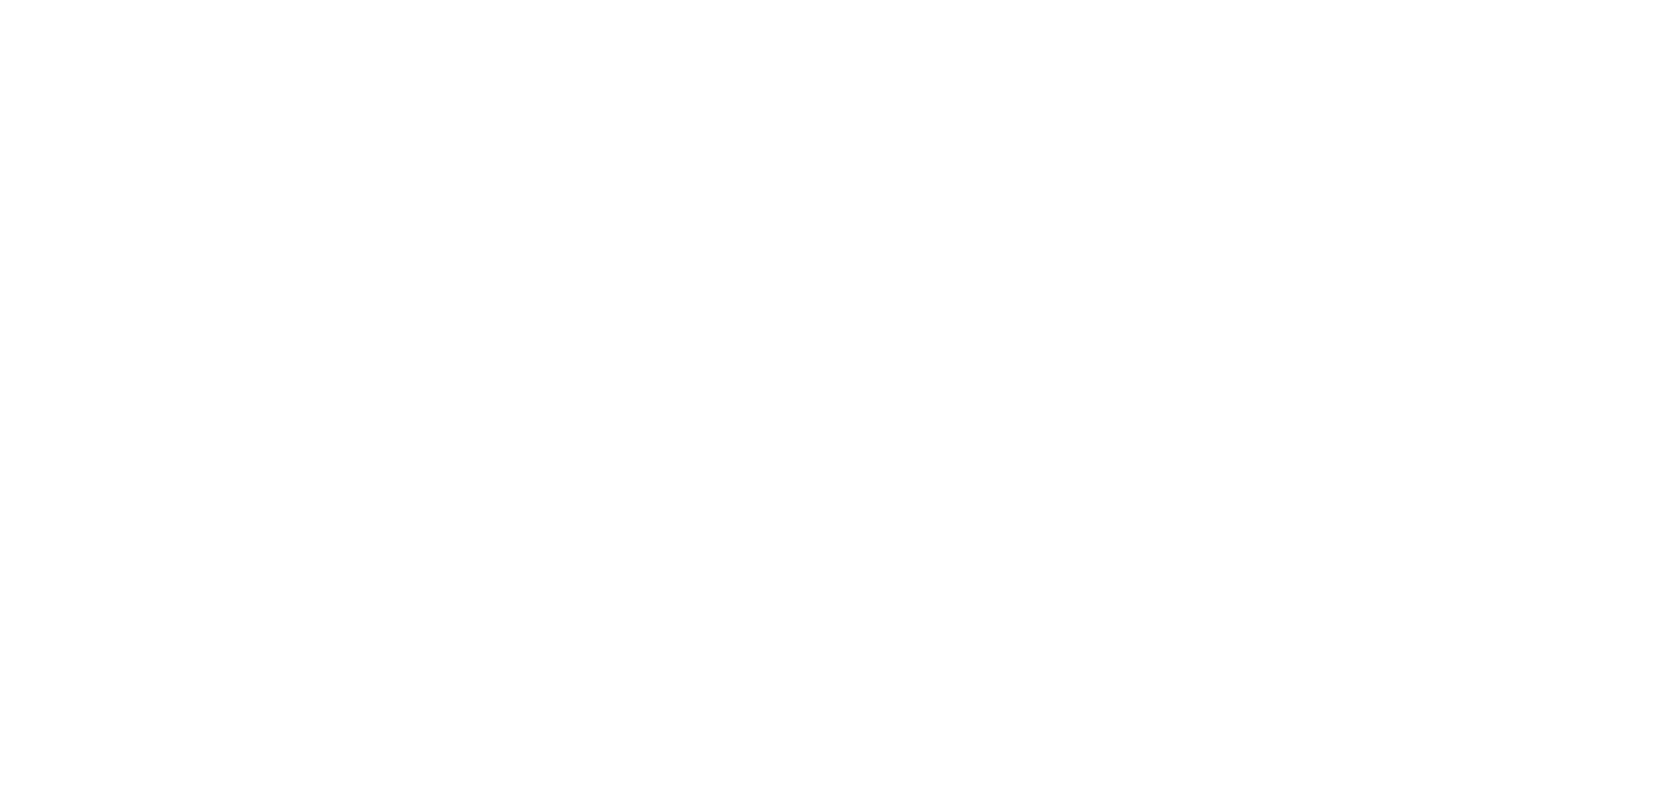

roi48_temporal.png


<IPython.core.display.Javascript object>


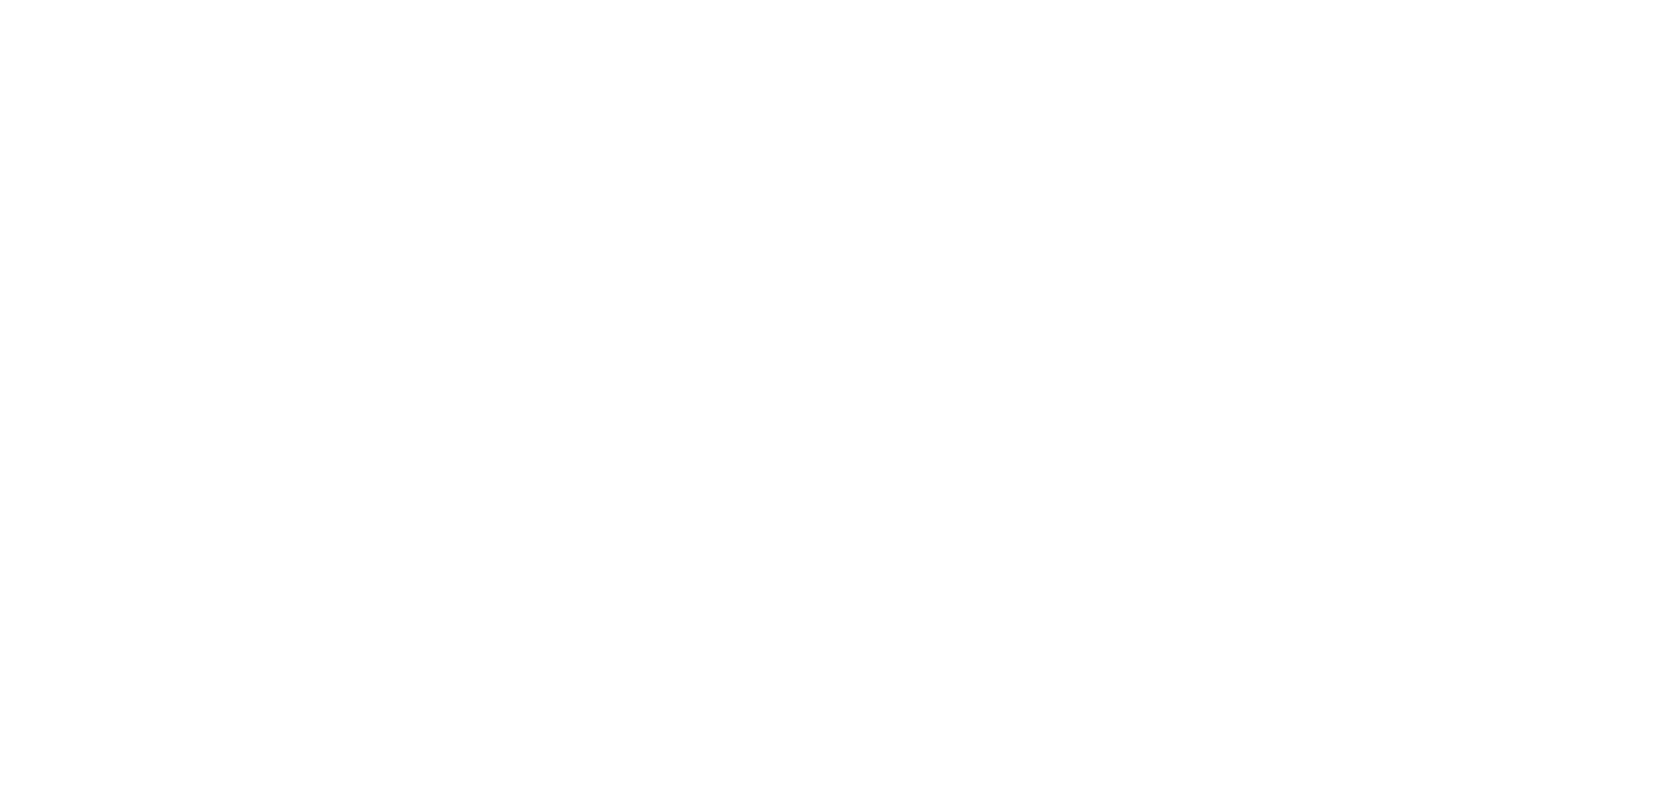

roi49_temporal.png


<IPython.core.display.Javascript object>


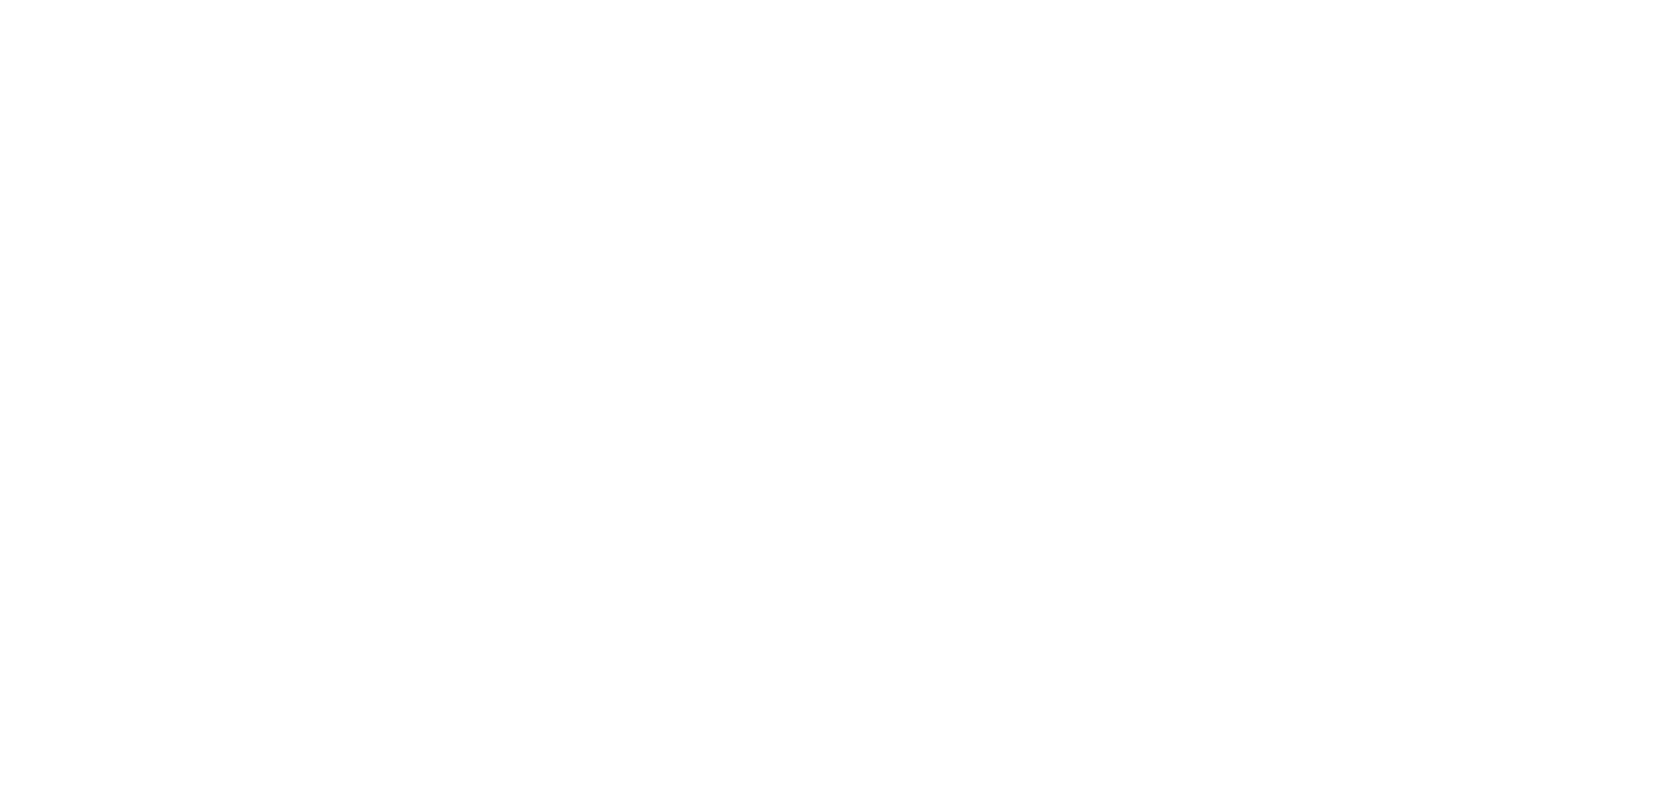

roi50_temporal.png


<IPython.core.display.Javascript object>


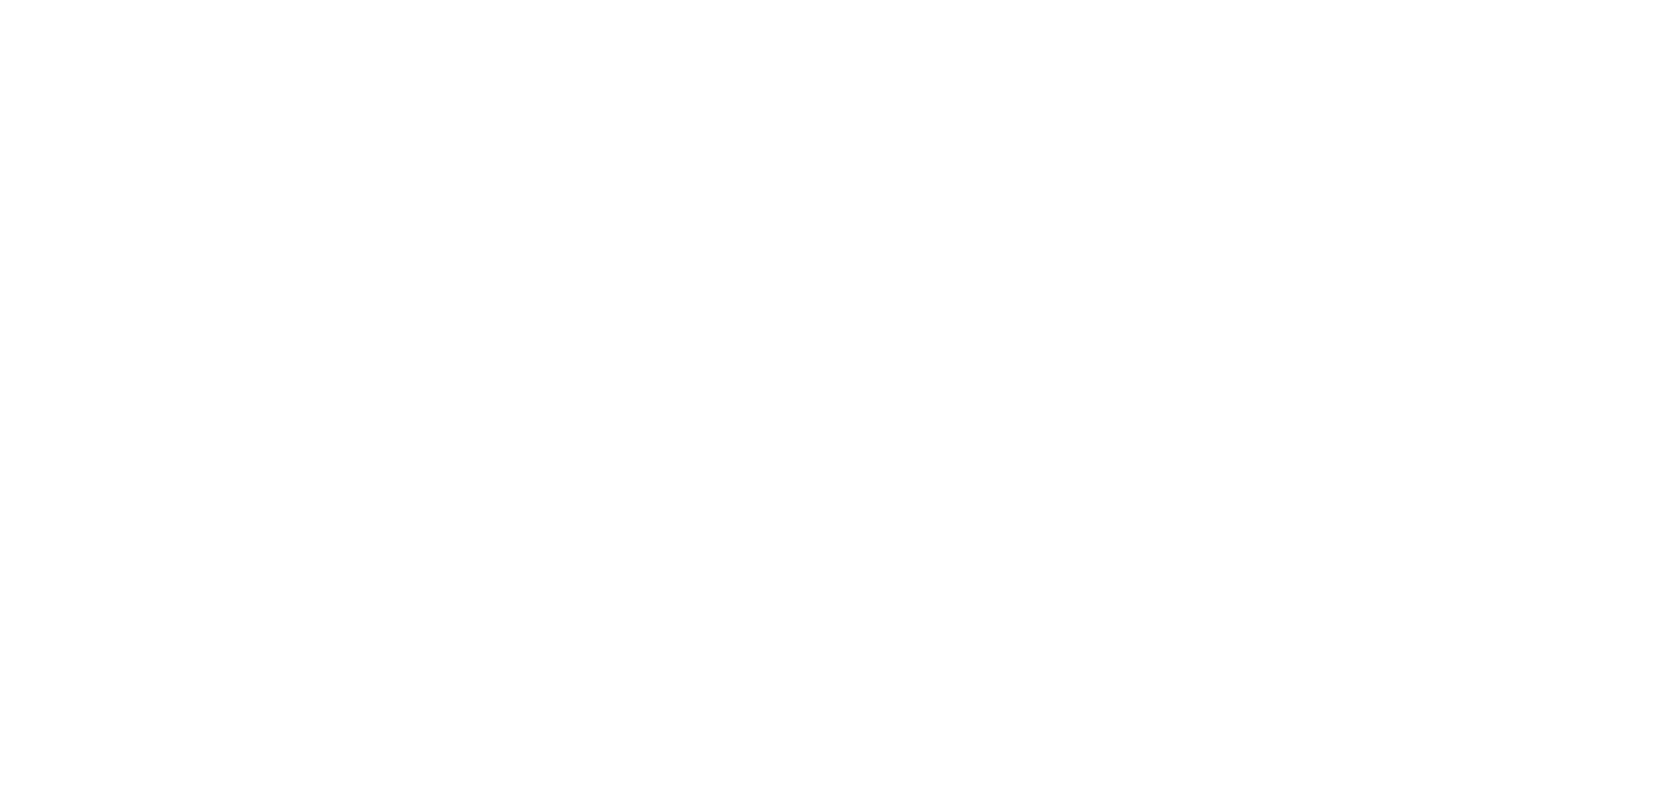

roi51_temporal.png


<IPython.core.display.Javascript object>


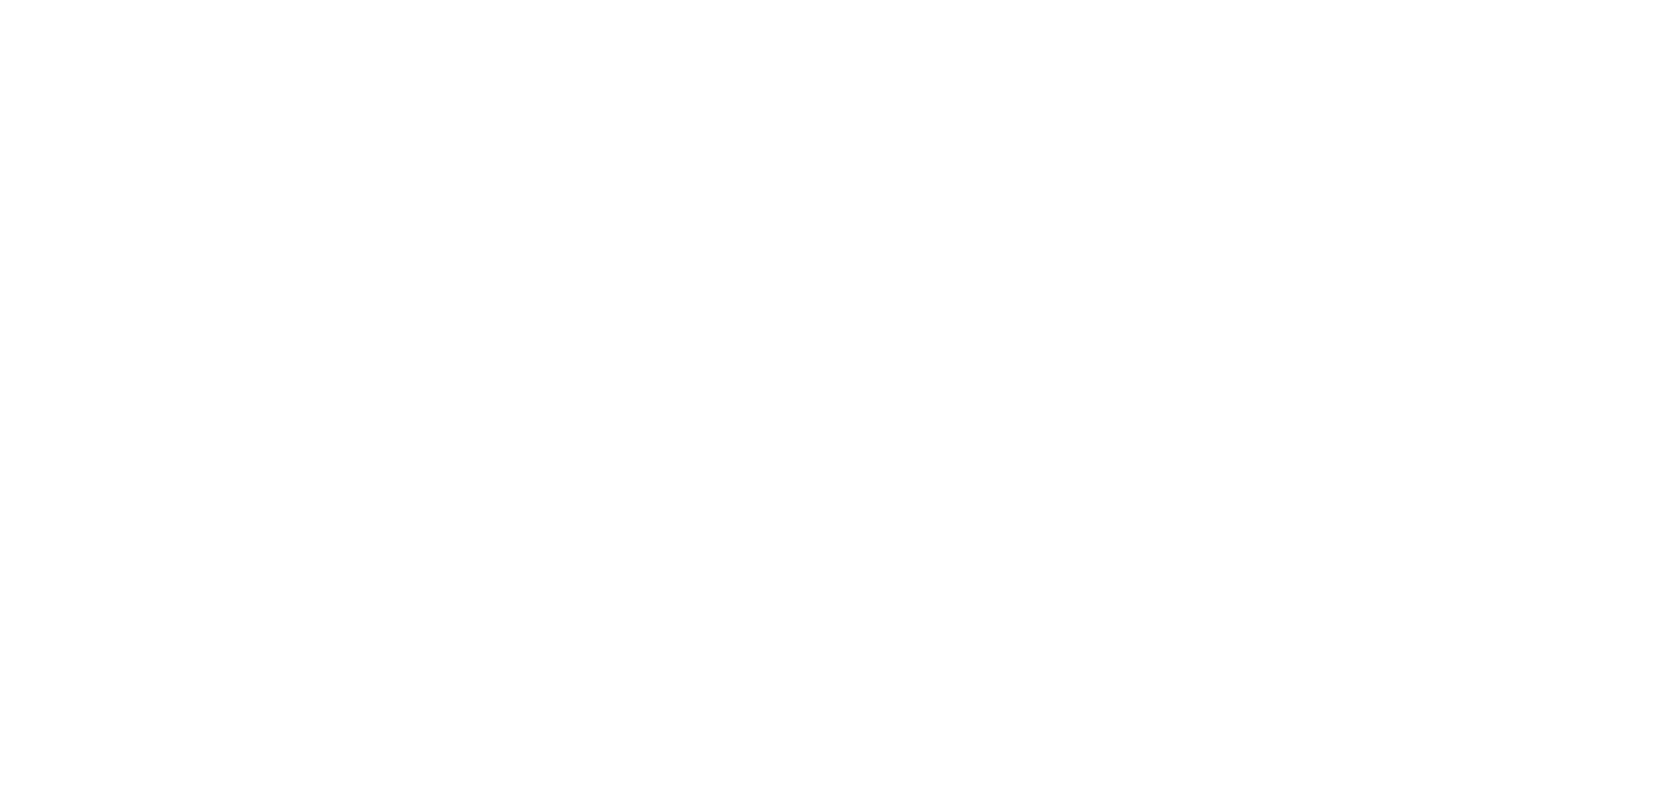

roi52_temporal.png


<IPython.core.display.Javascript object>


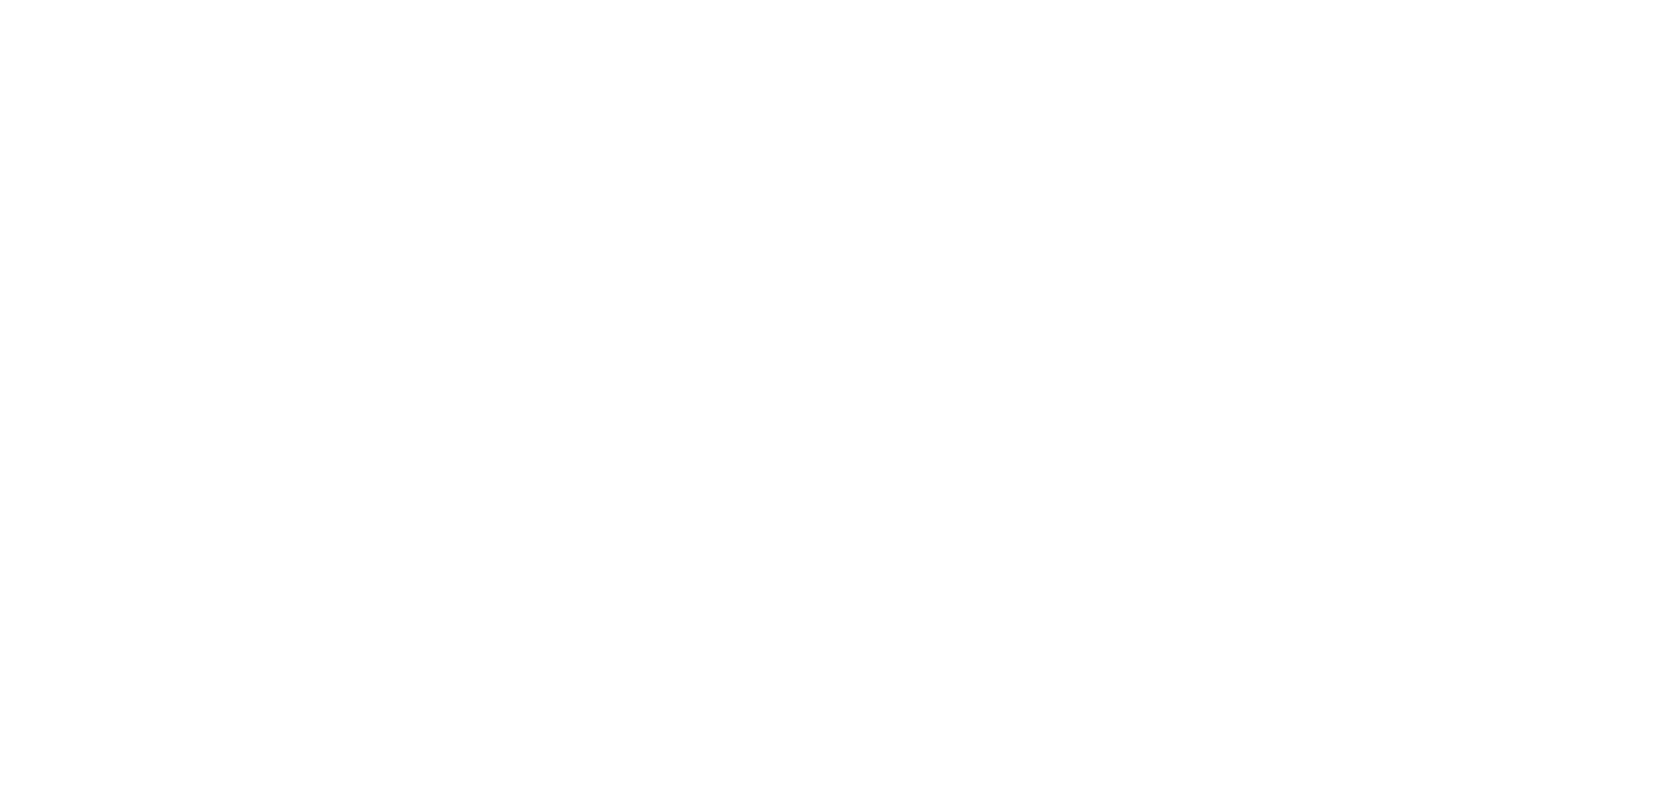

roi53_temporal.png


<IPython.core.display.Javascript object>


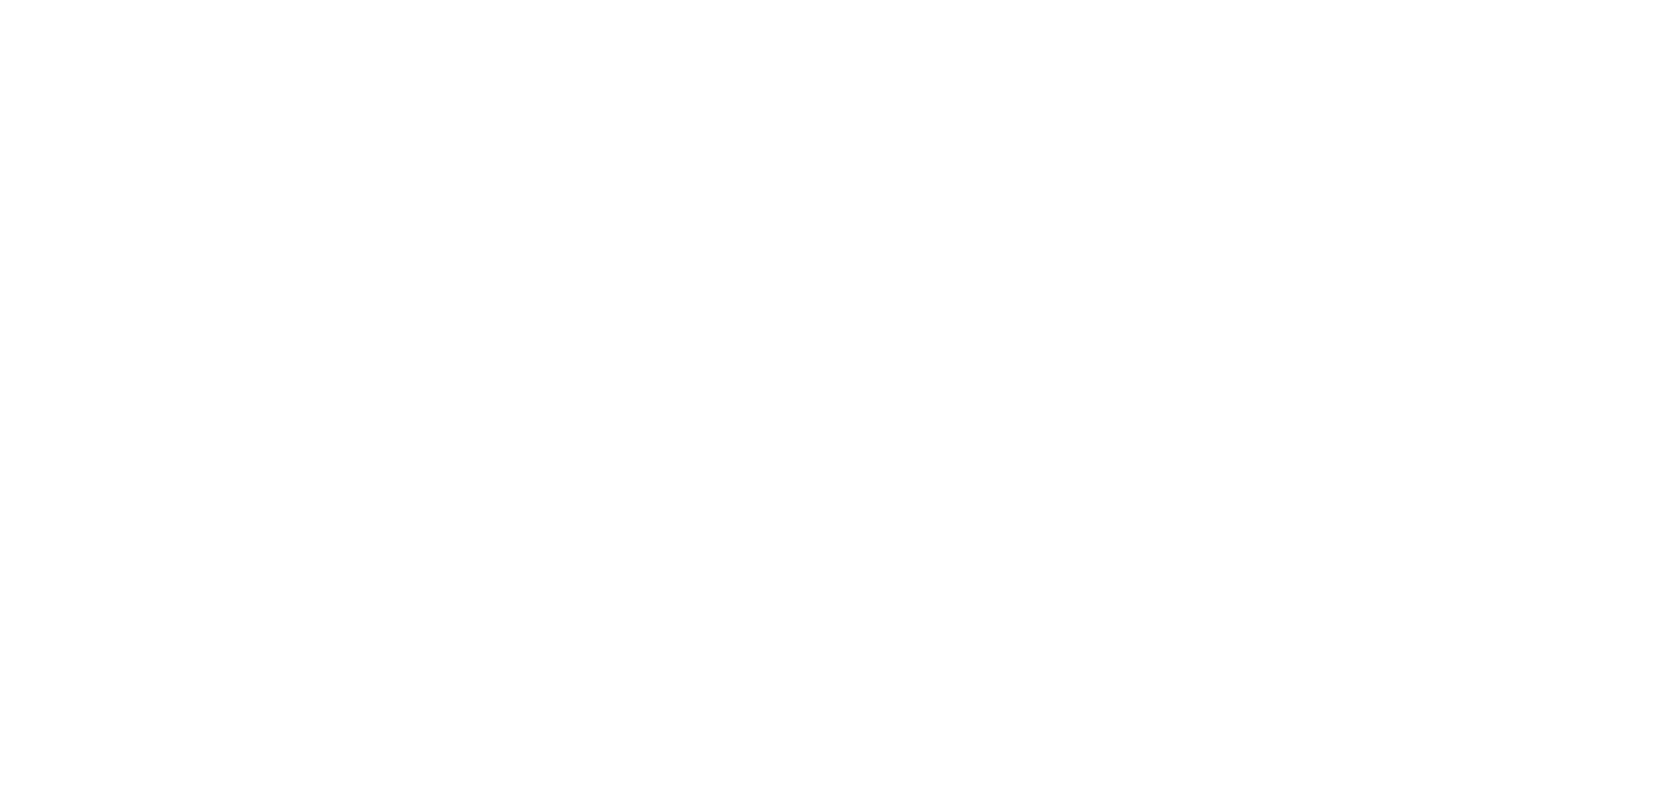

roi54_temporal.png


<IPython.core.display.Javascript object>


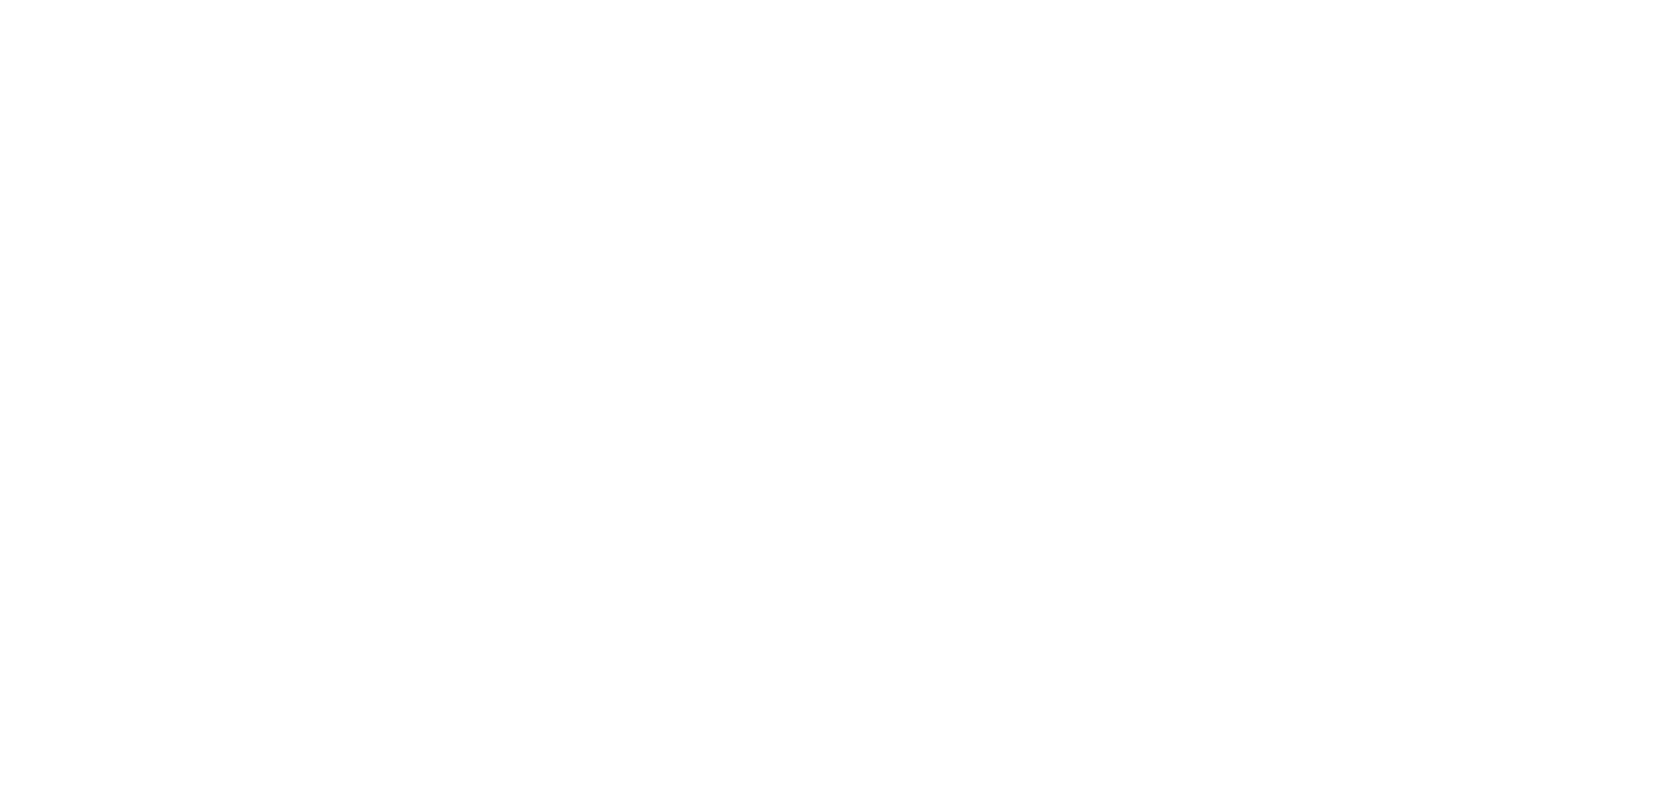

roi55_temporal.png


<IPython.core.display.Javascript object>


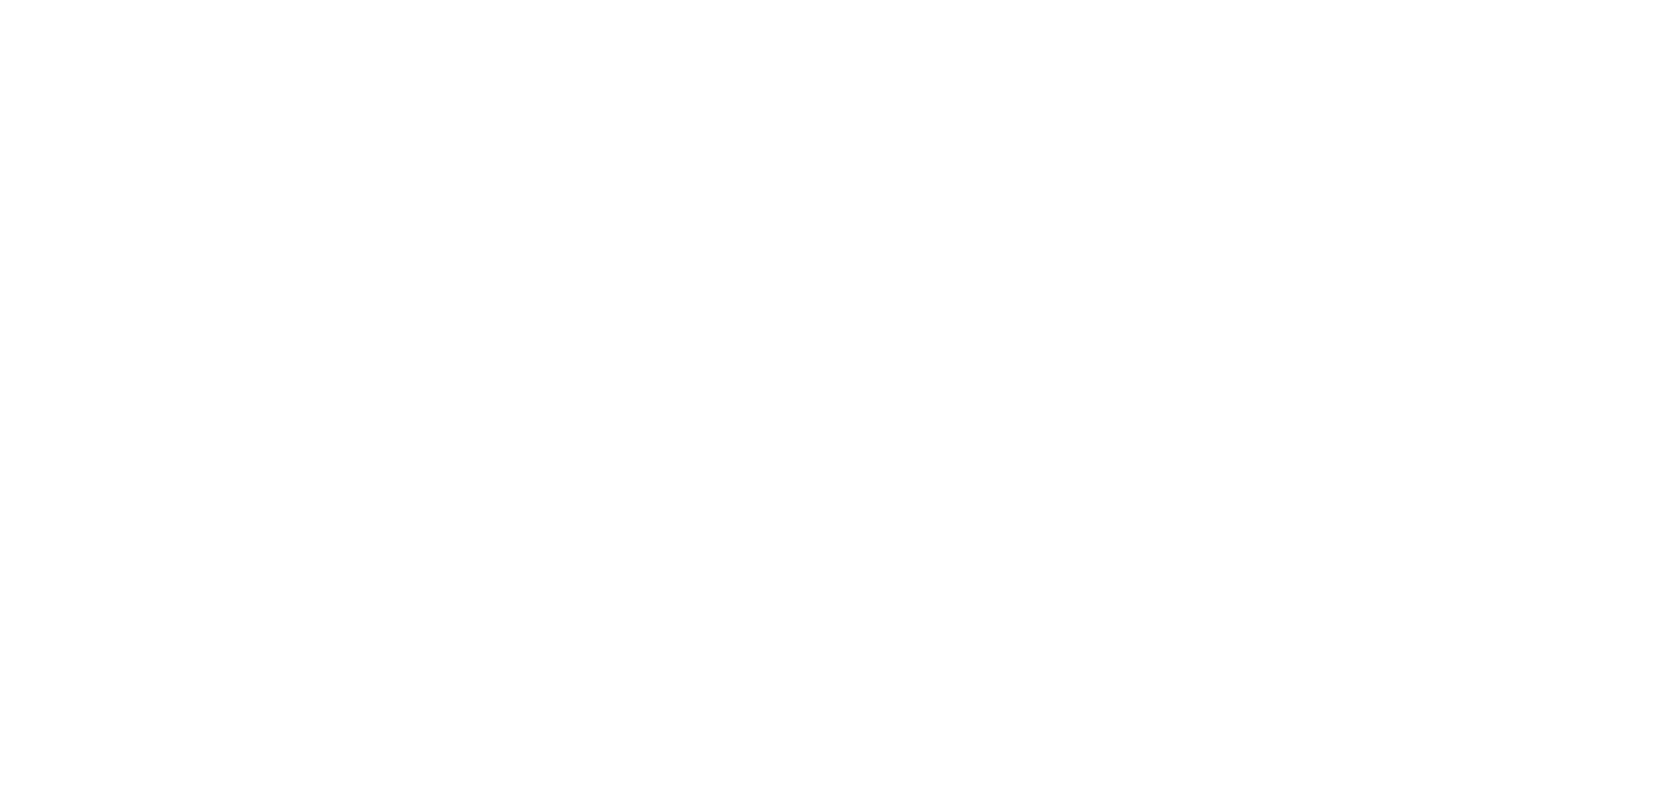

roi56_temporal.png


<IPython.core.display.Javascript object>


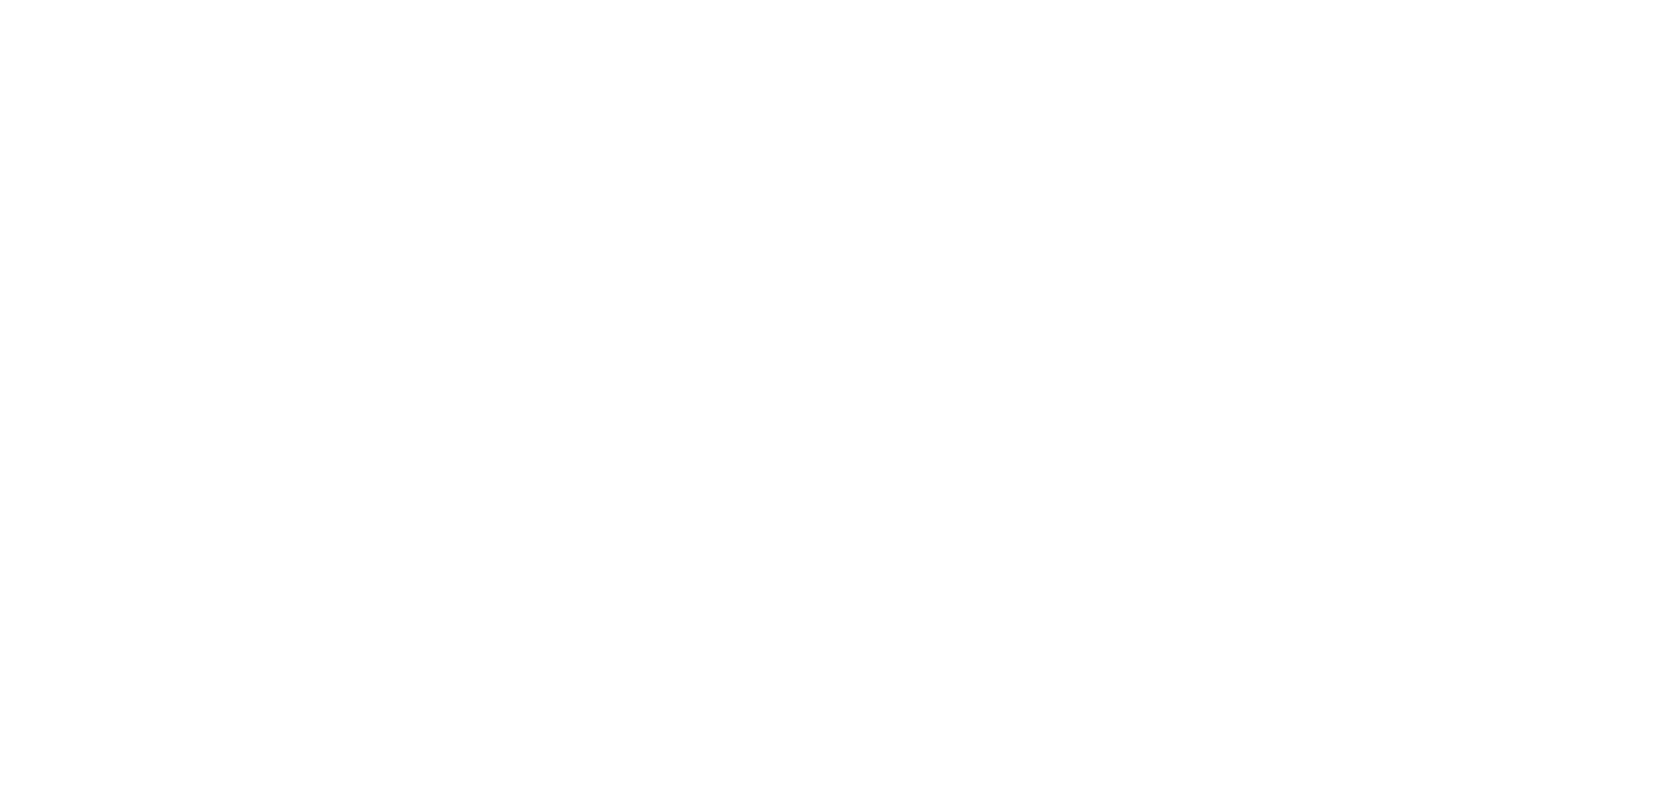

roi57_temporal.png


<IPython.core.display.Javascript object>


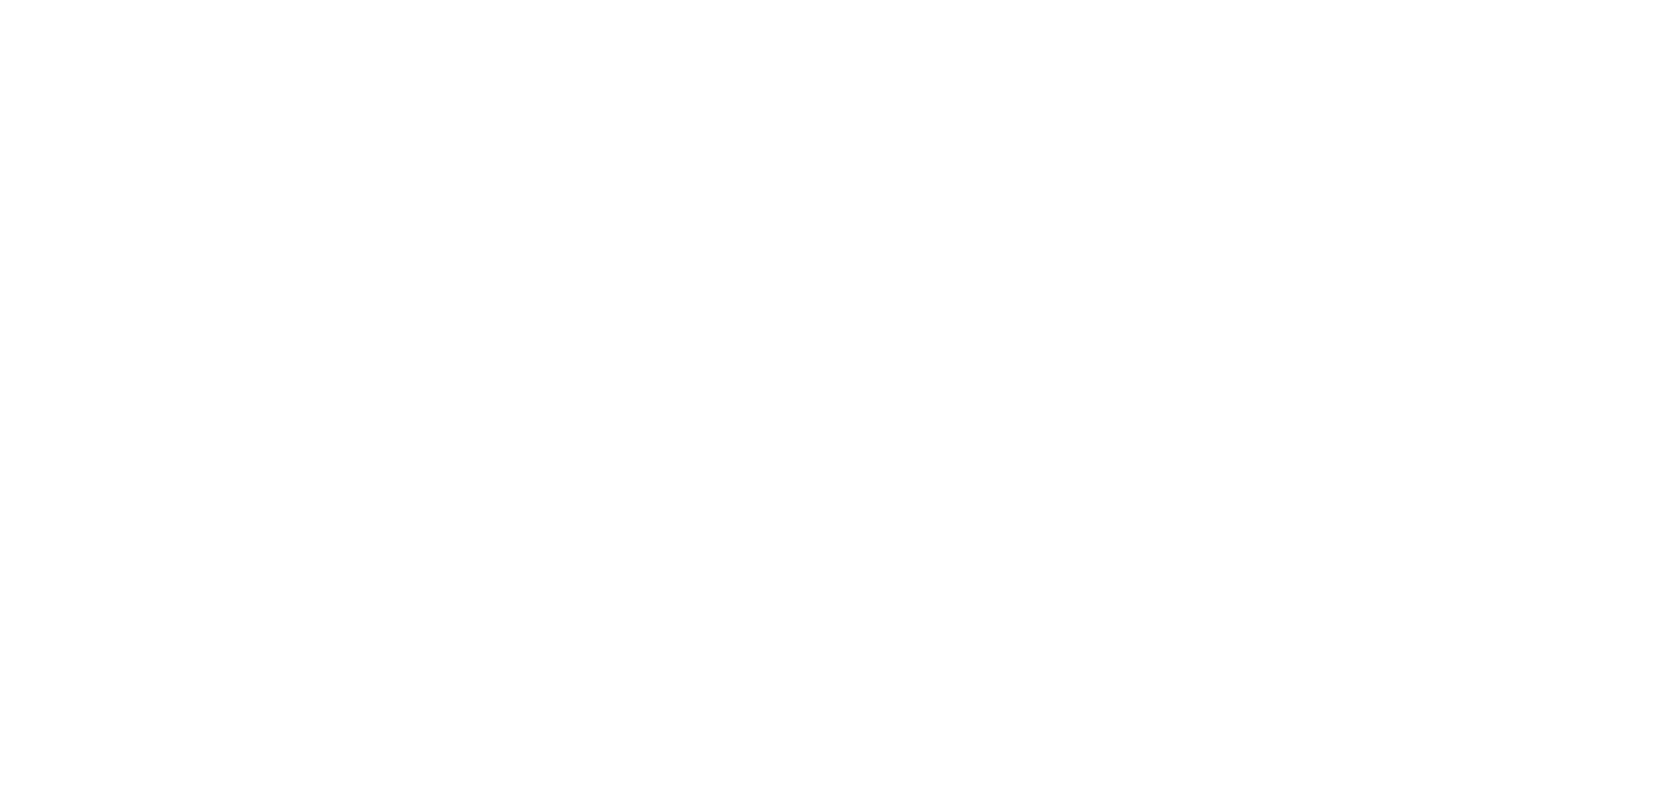

roi58_temporal.png


<IPython.core.display.Javascript object>


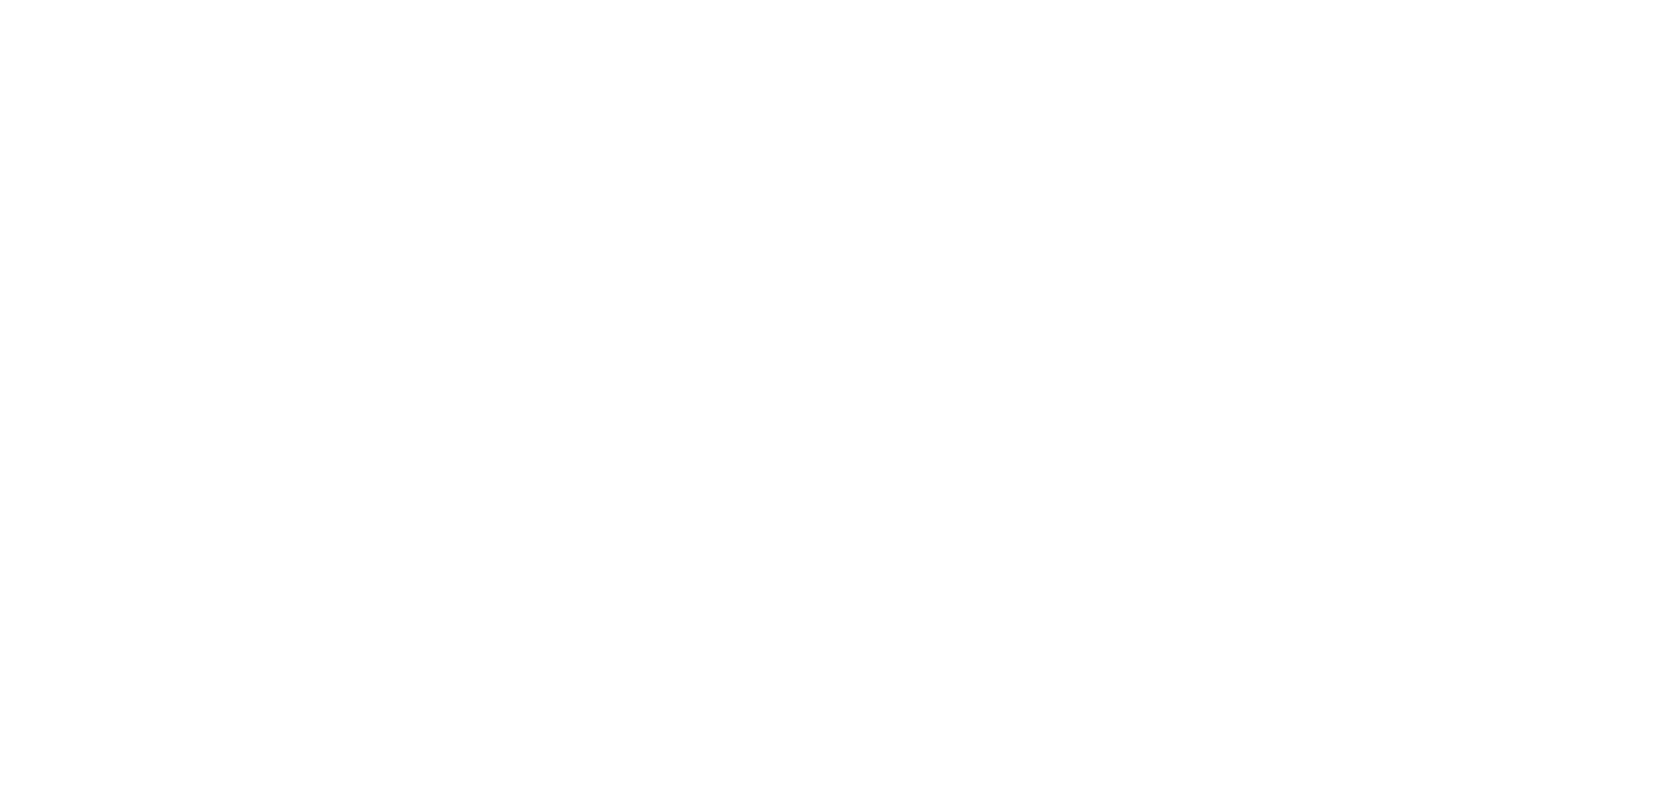

roi59_temporal.png


<IPython.core.display.Javascript object>


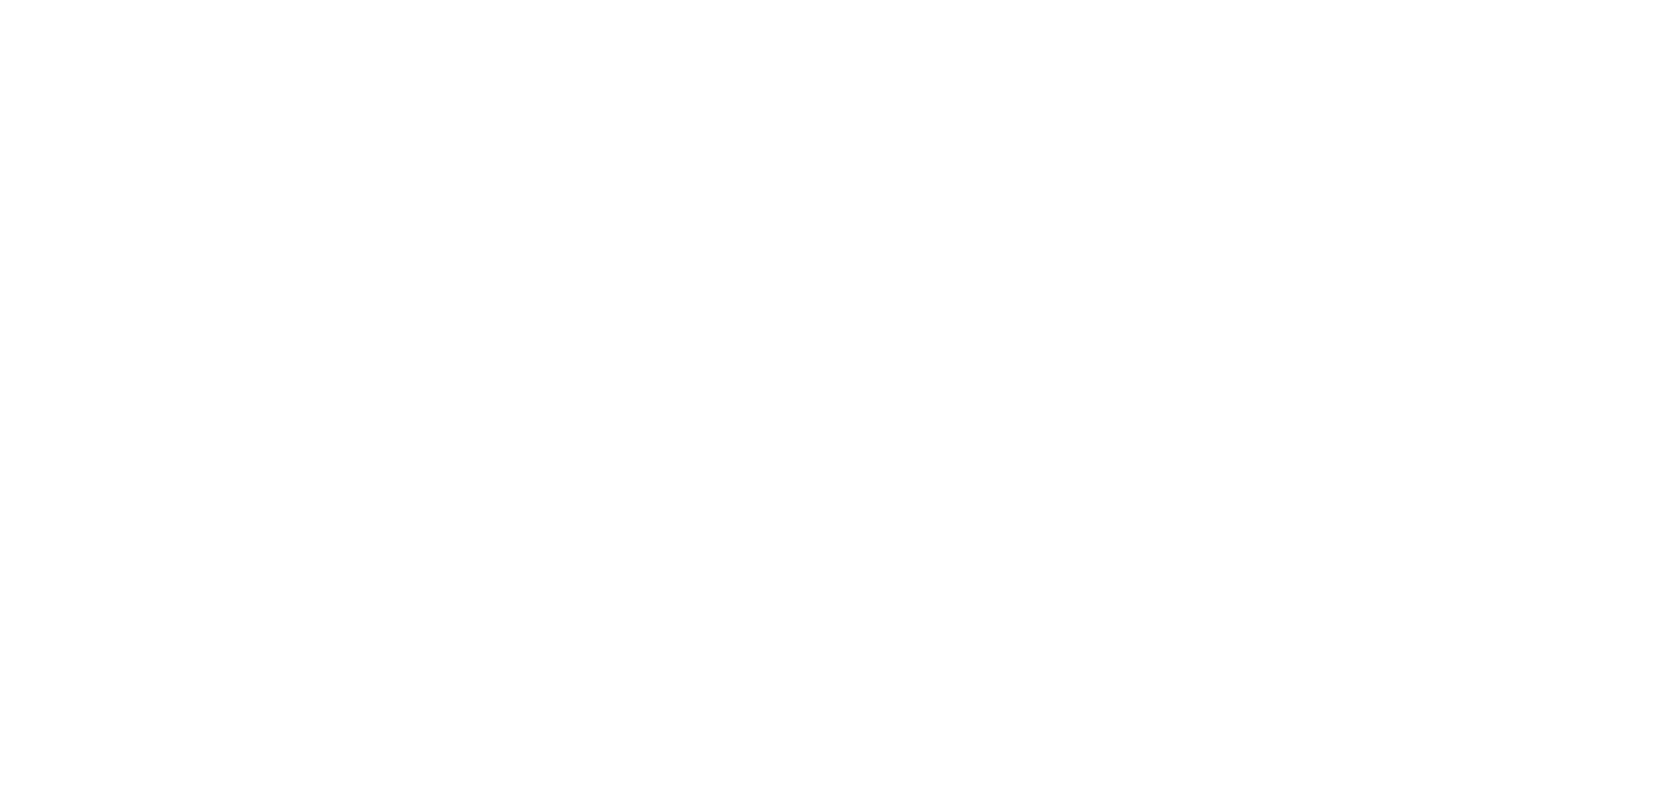

roi60_temporal.png


<IPython.core.display.Javascript object>


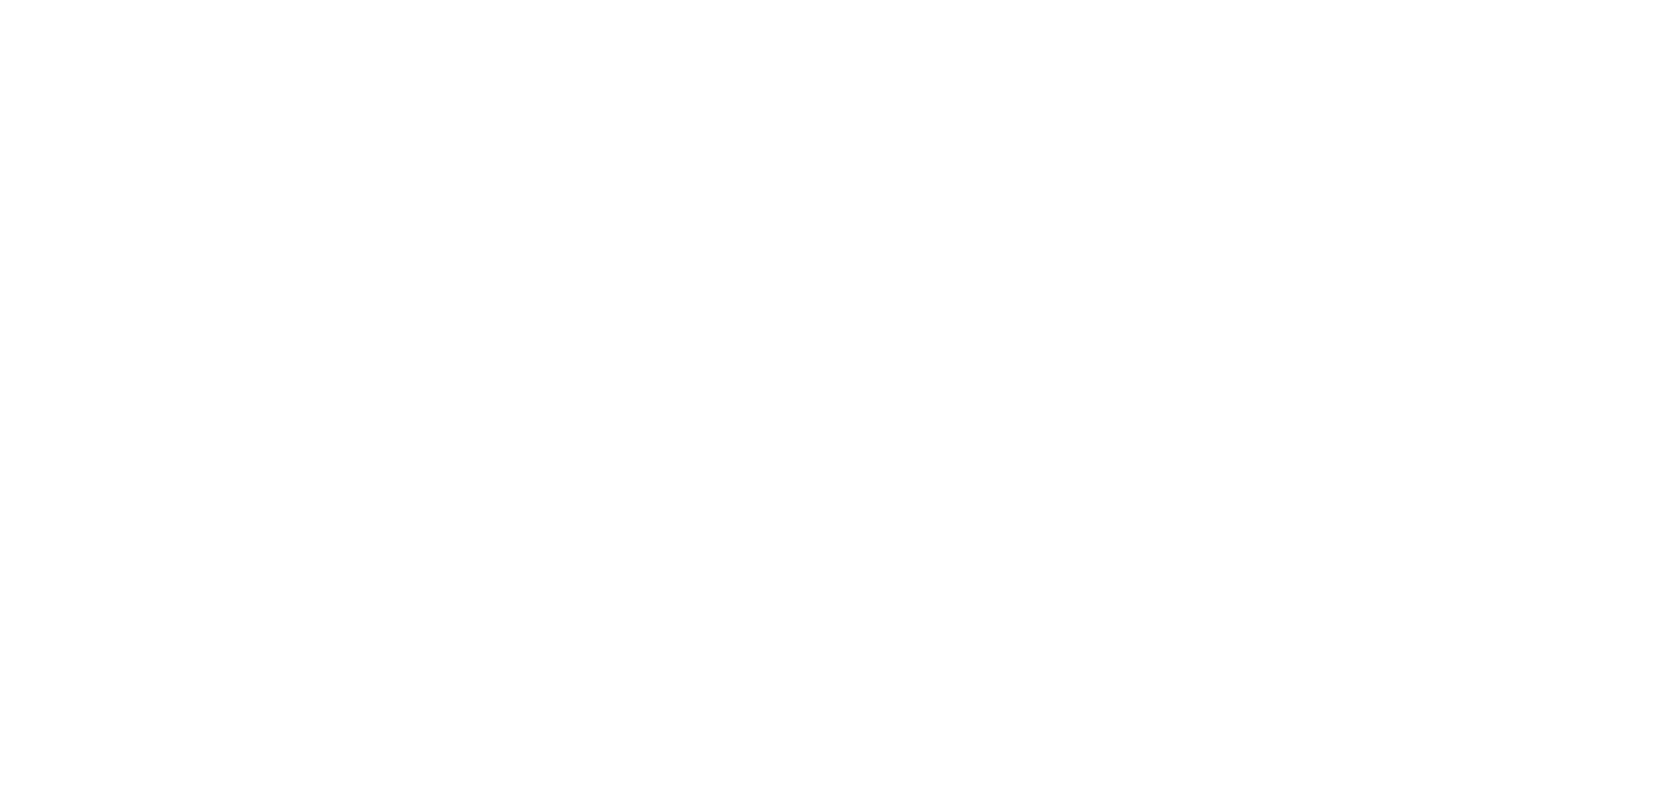

roi61_temporal.png


<IPython.core.display.Javascript object>


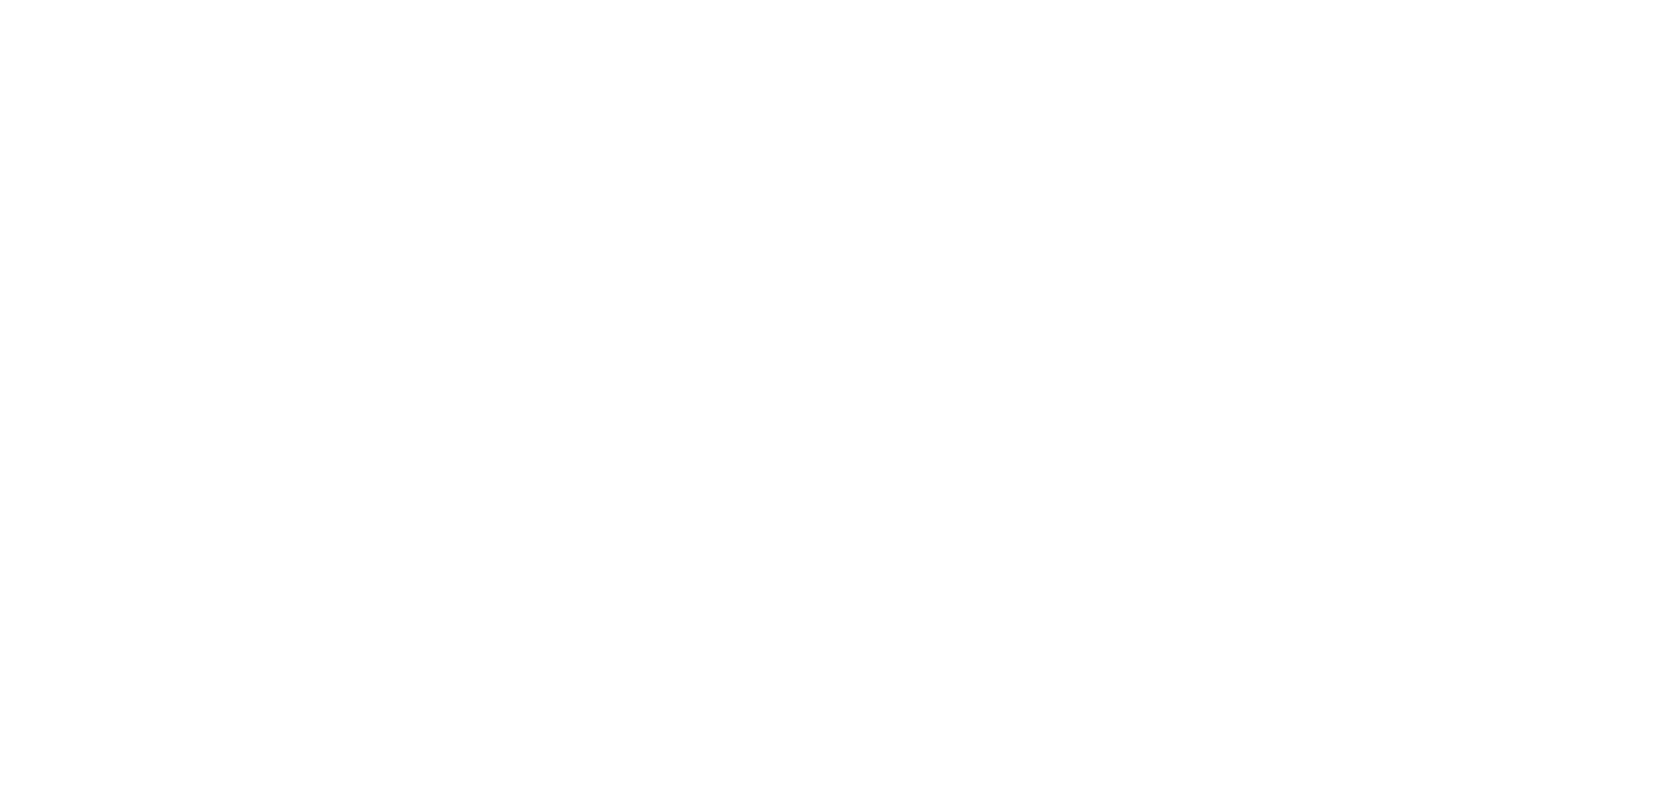

roi62_temporal.png


<IPython.core.display.Javascript object>


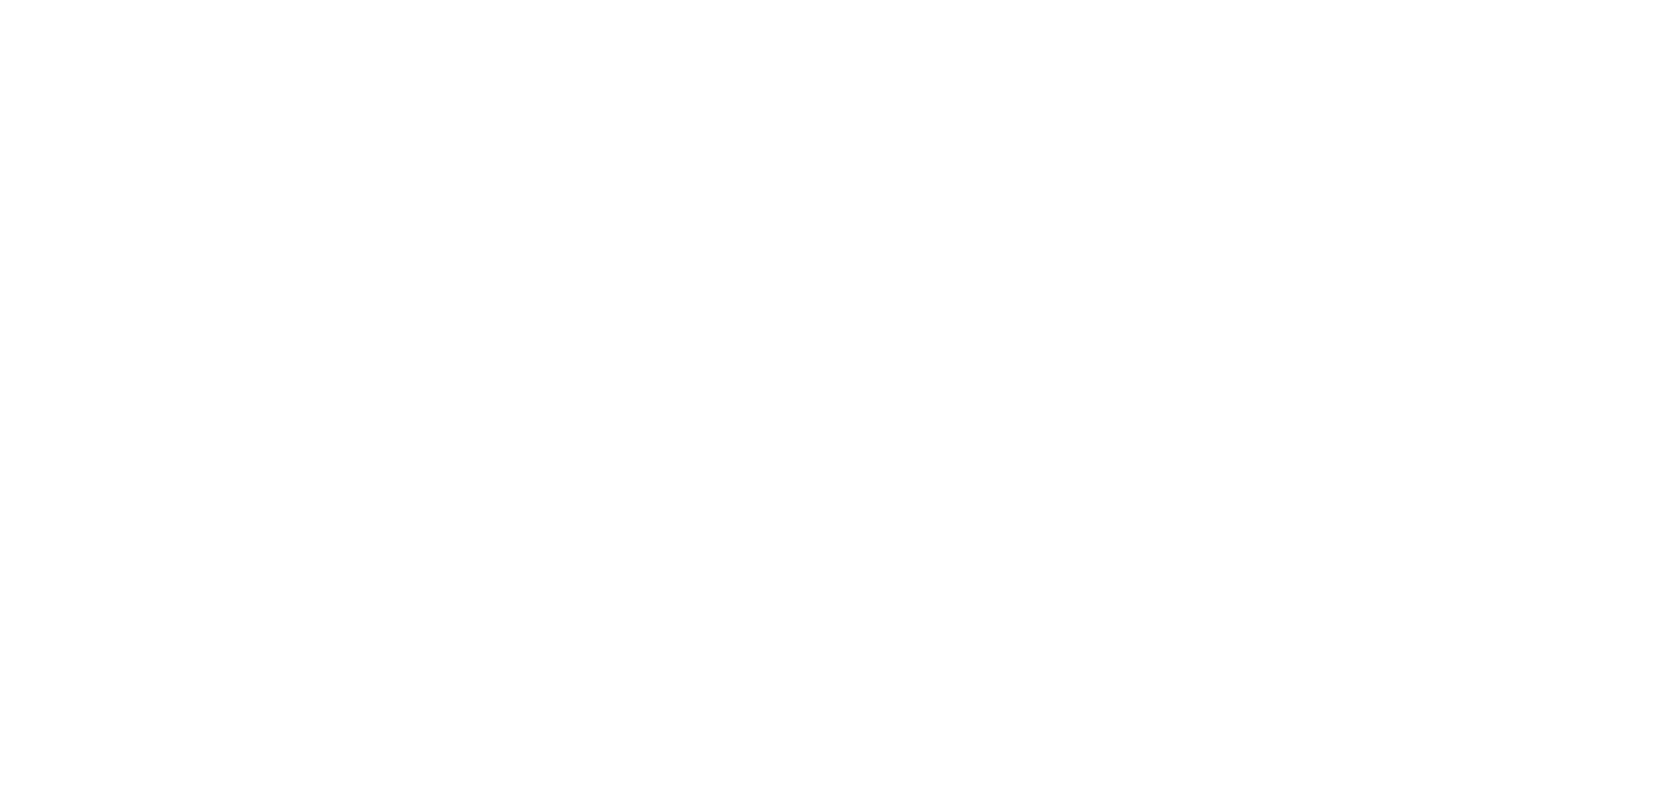

roi63_temporal.png


<IPython.core.display.Javascript object>


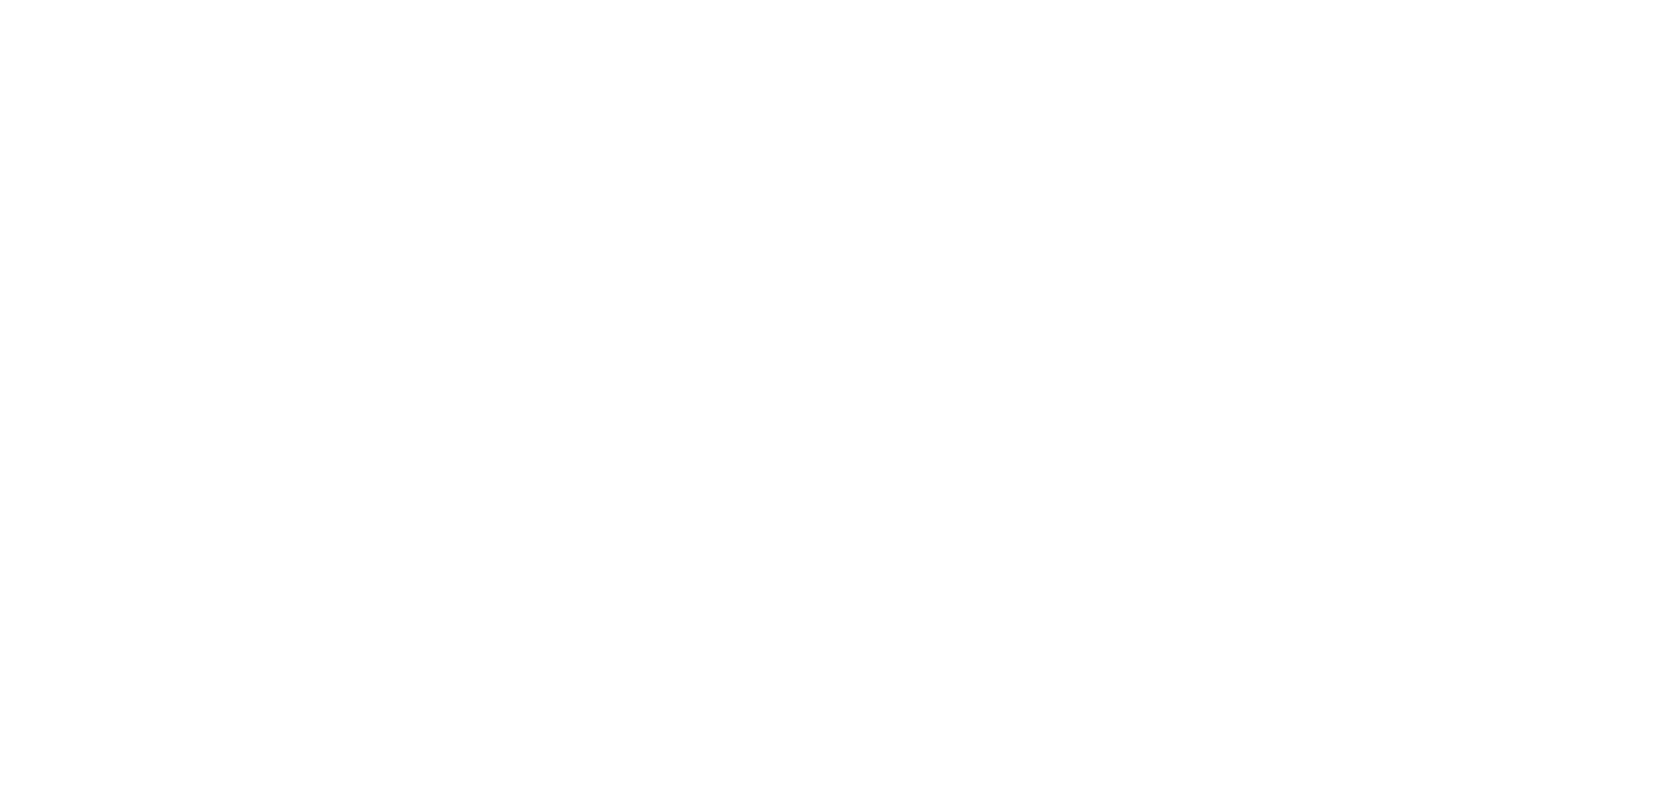

roi64_temporal.png


<IPython.core.display.Javascript object>


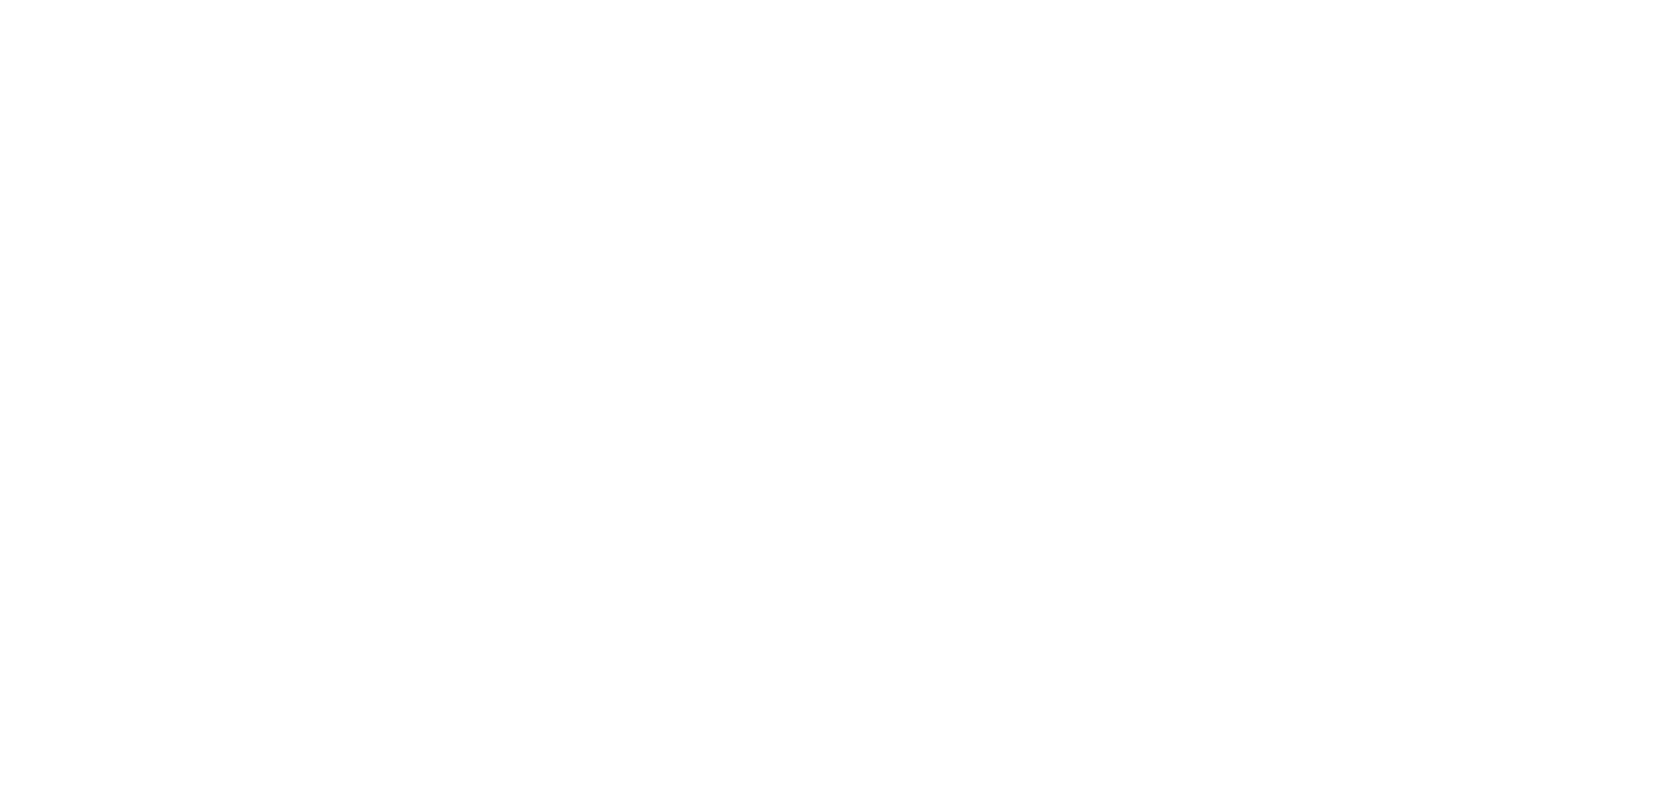

roi65_temporal.png


<IPython.core.display.Javascript object>


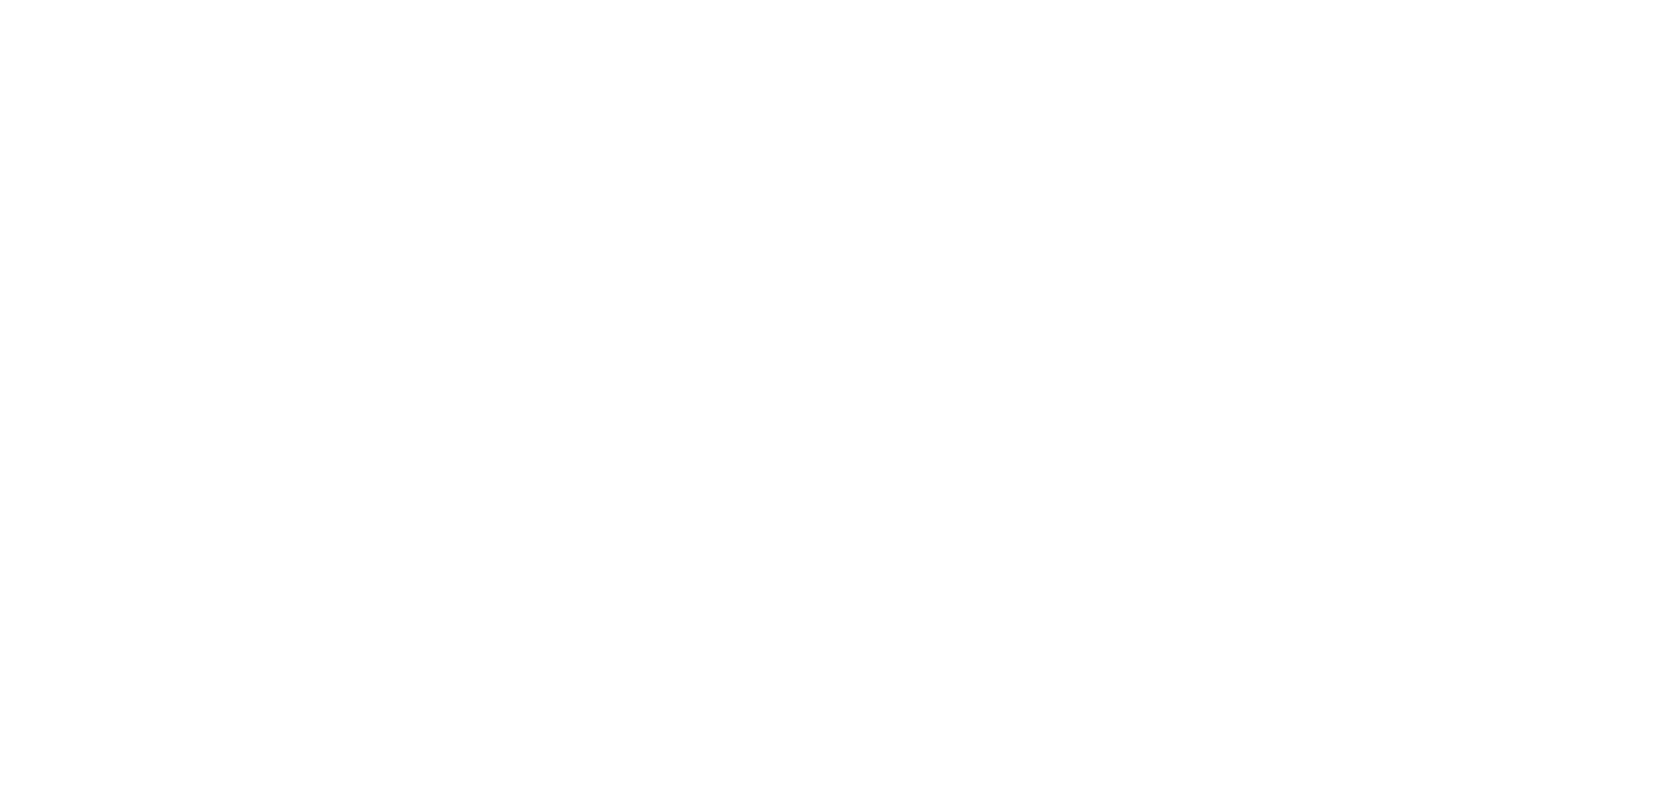

roi66_temporal.png


<IPython.core.display.Javascript object>


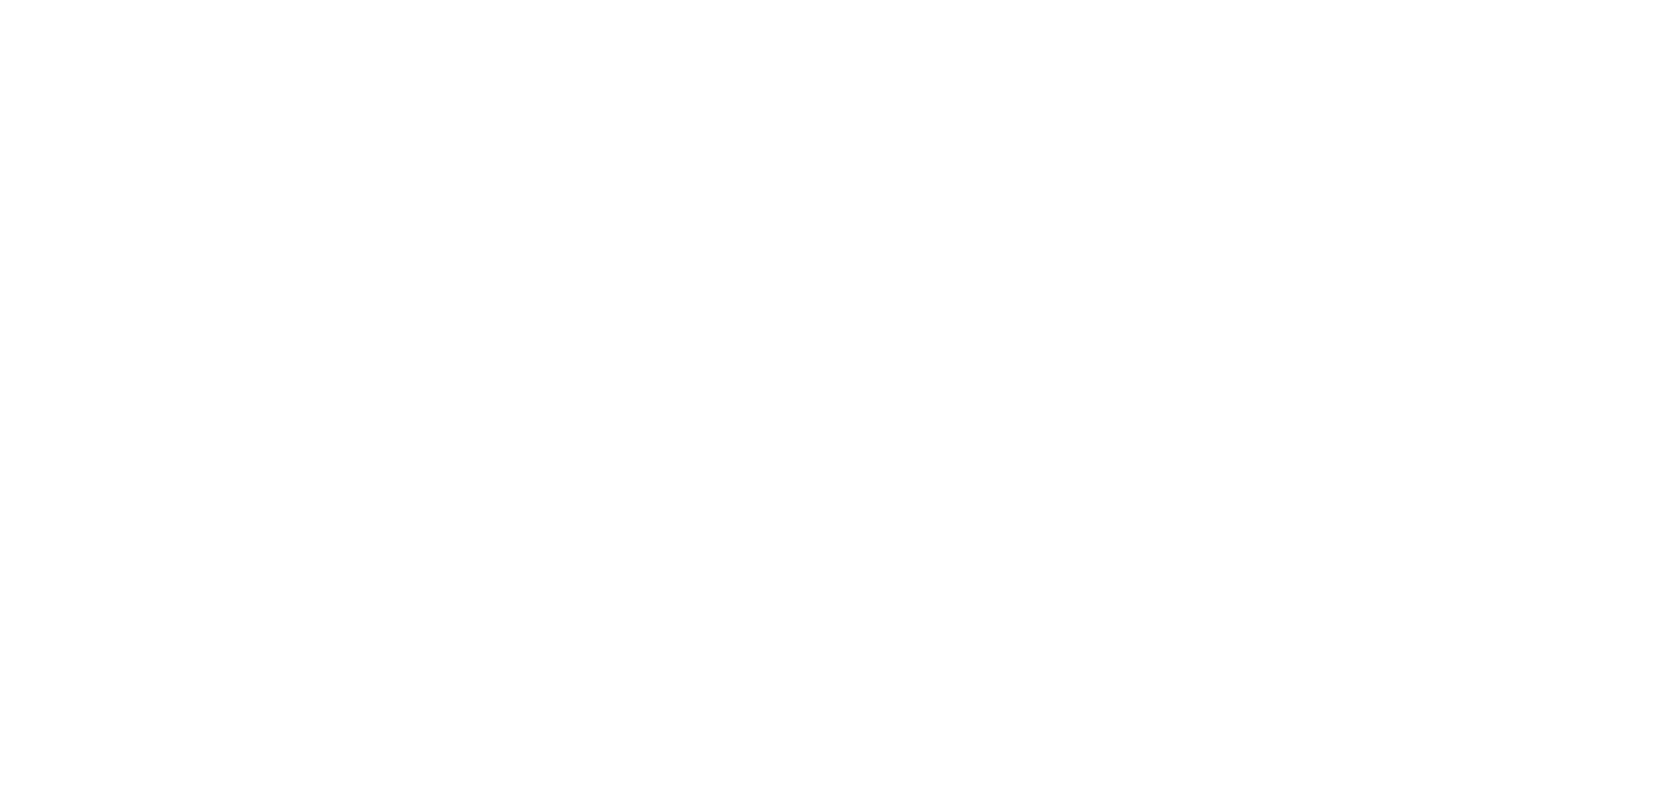

roi67_temporal.png


<IPython.core.display.Javascript object>


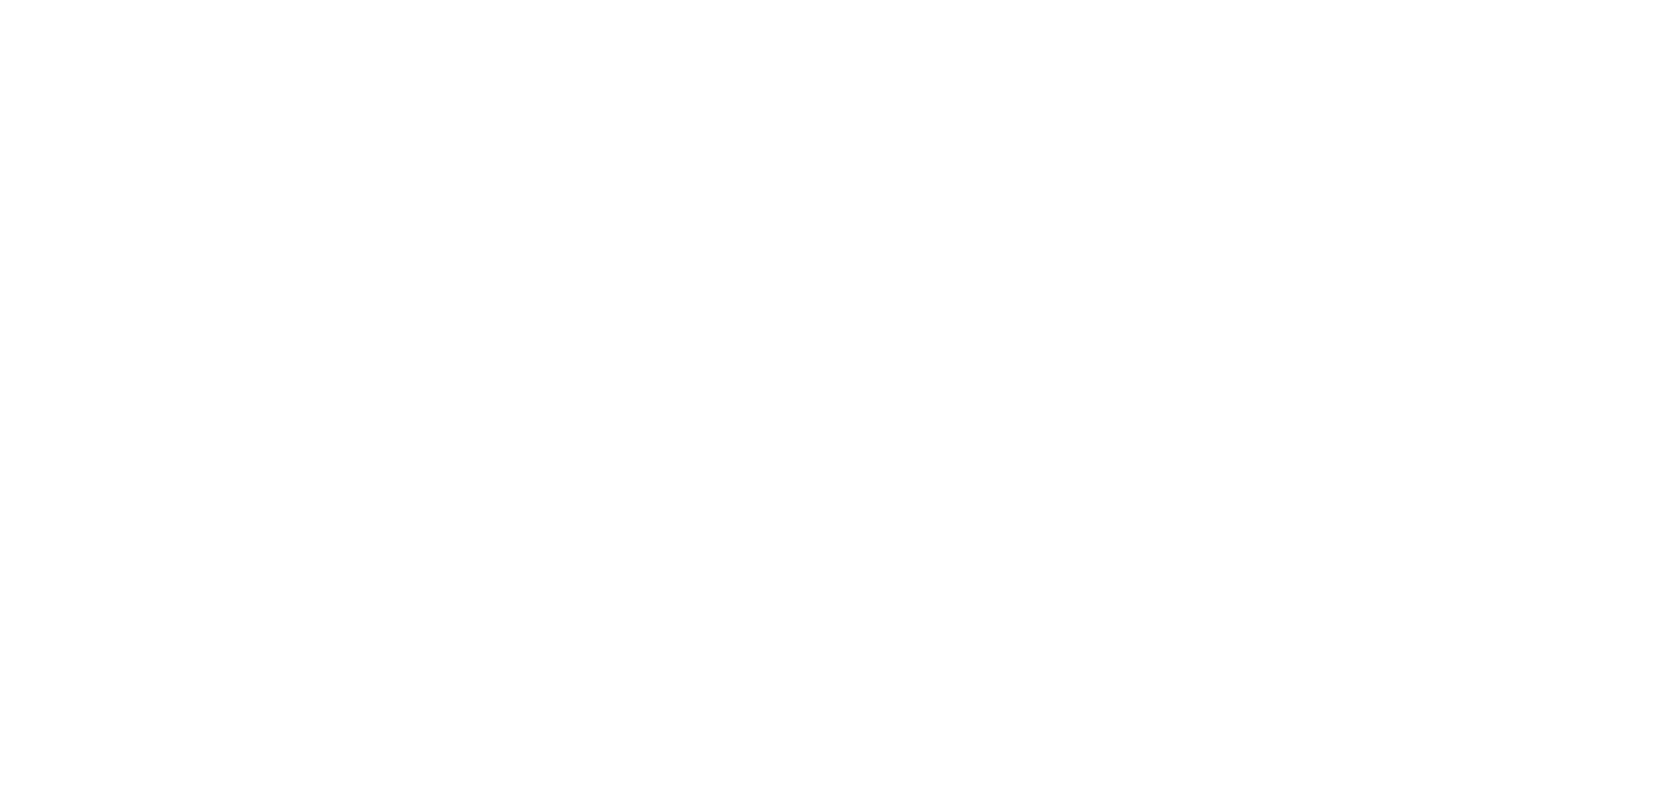

roi68_temporal.png


<IPython.core.display.Javascript object>


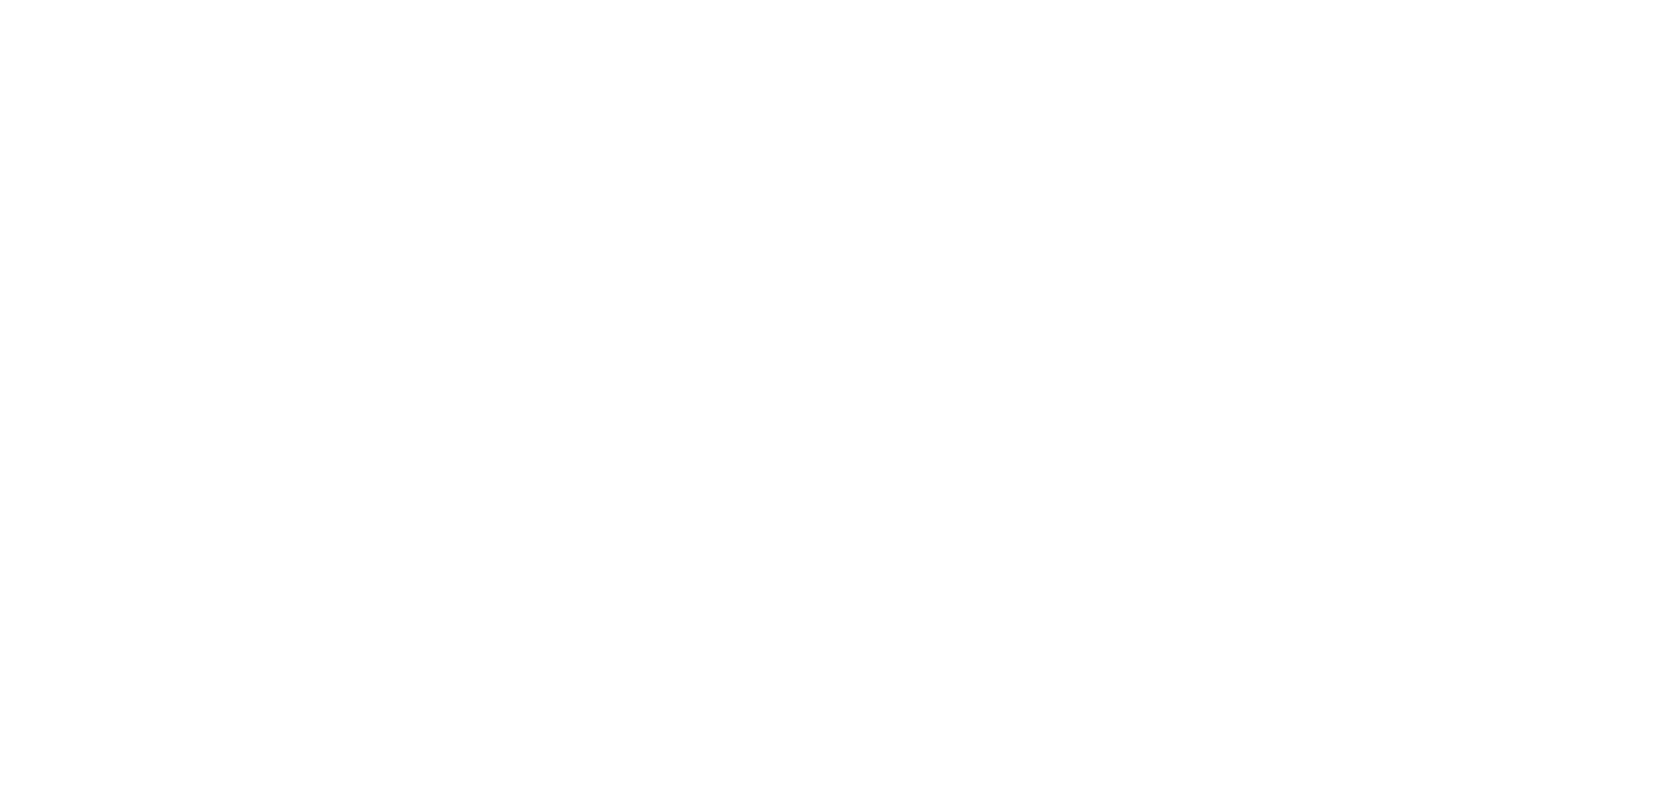

roi69_temporal.png


<IPython.core.display.Javascript object>


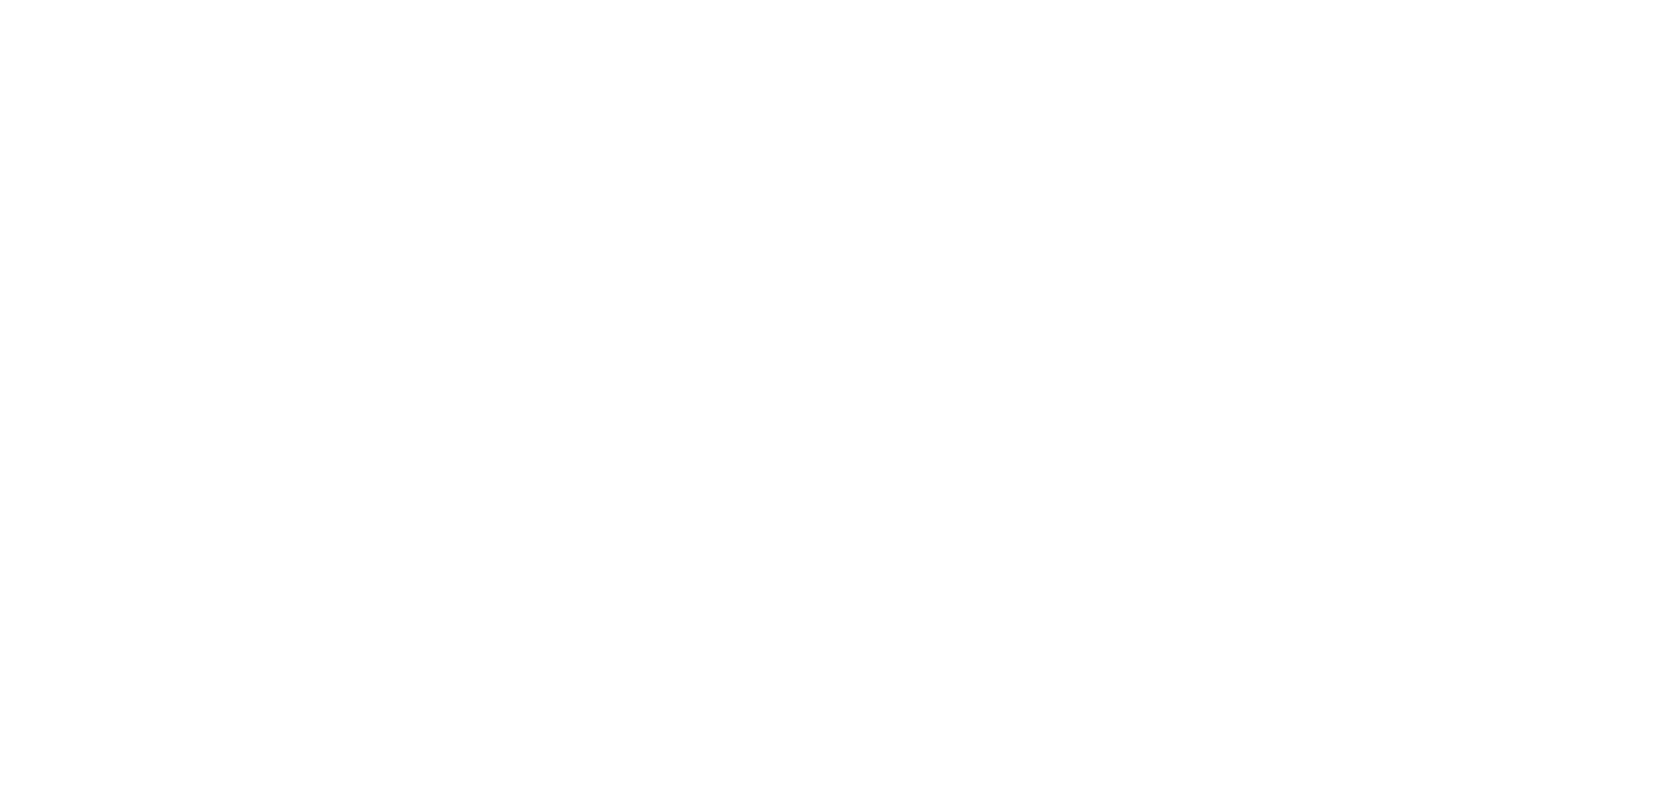

roi70_temporal.png


<IPython.core.display.Javascript object>


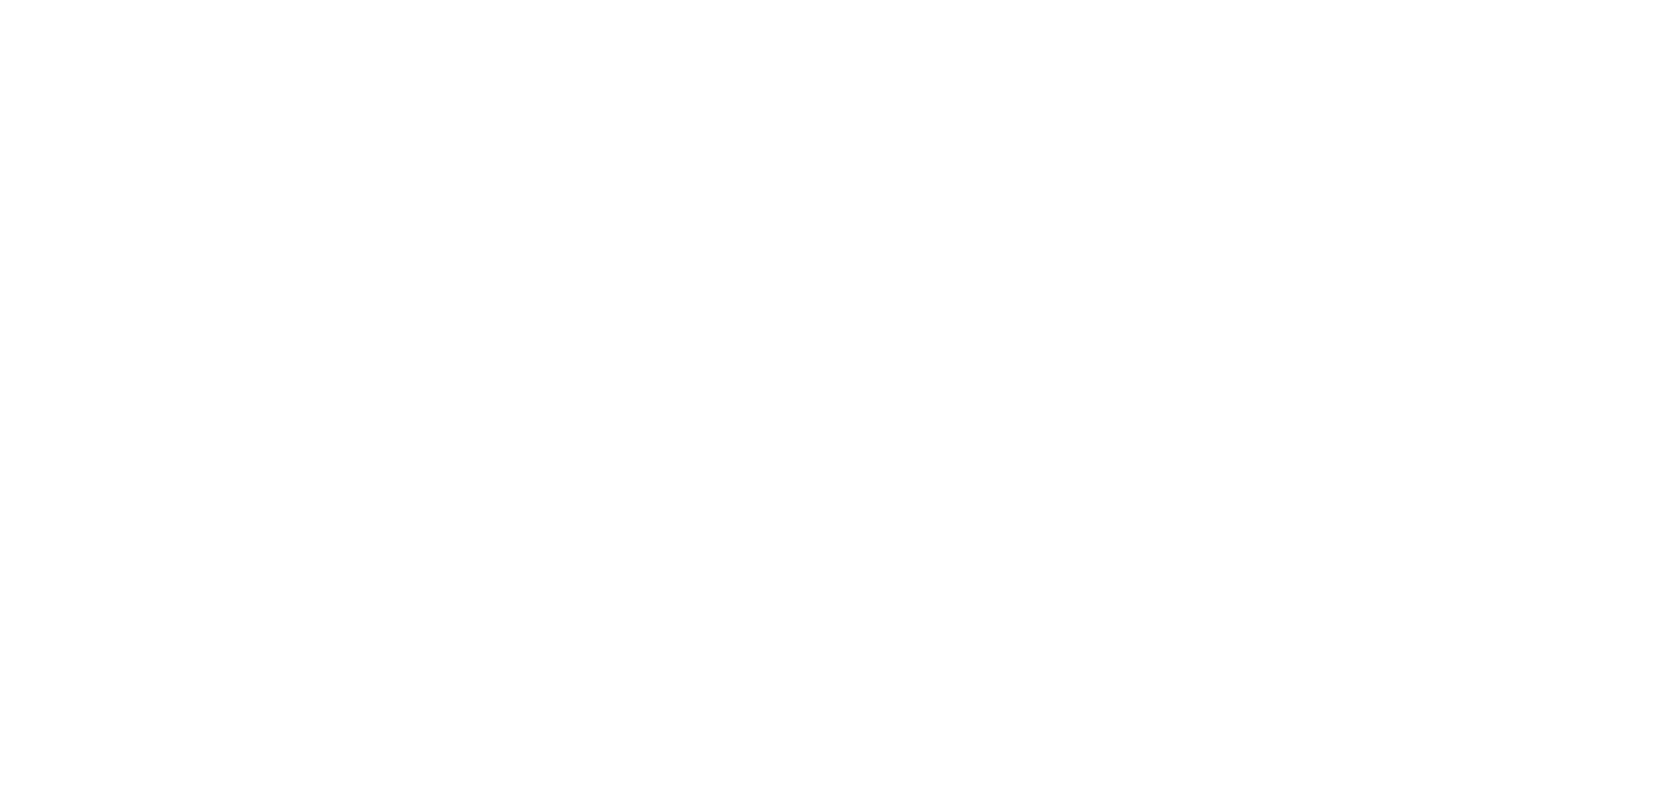

roi71_temporal.png


<IPython.core.display.Javascript object>


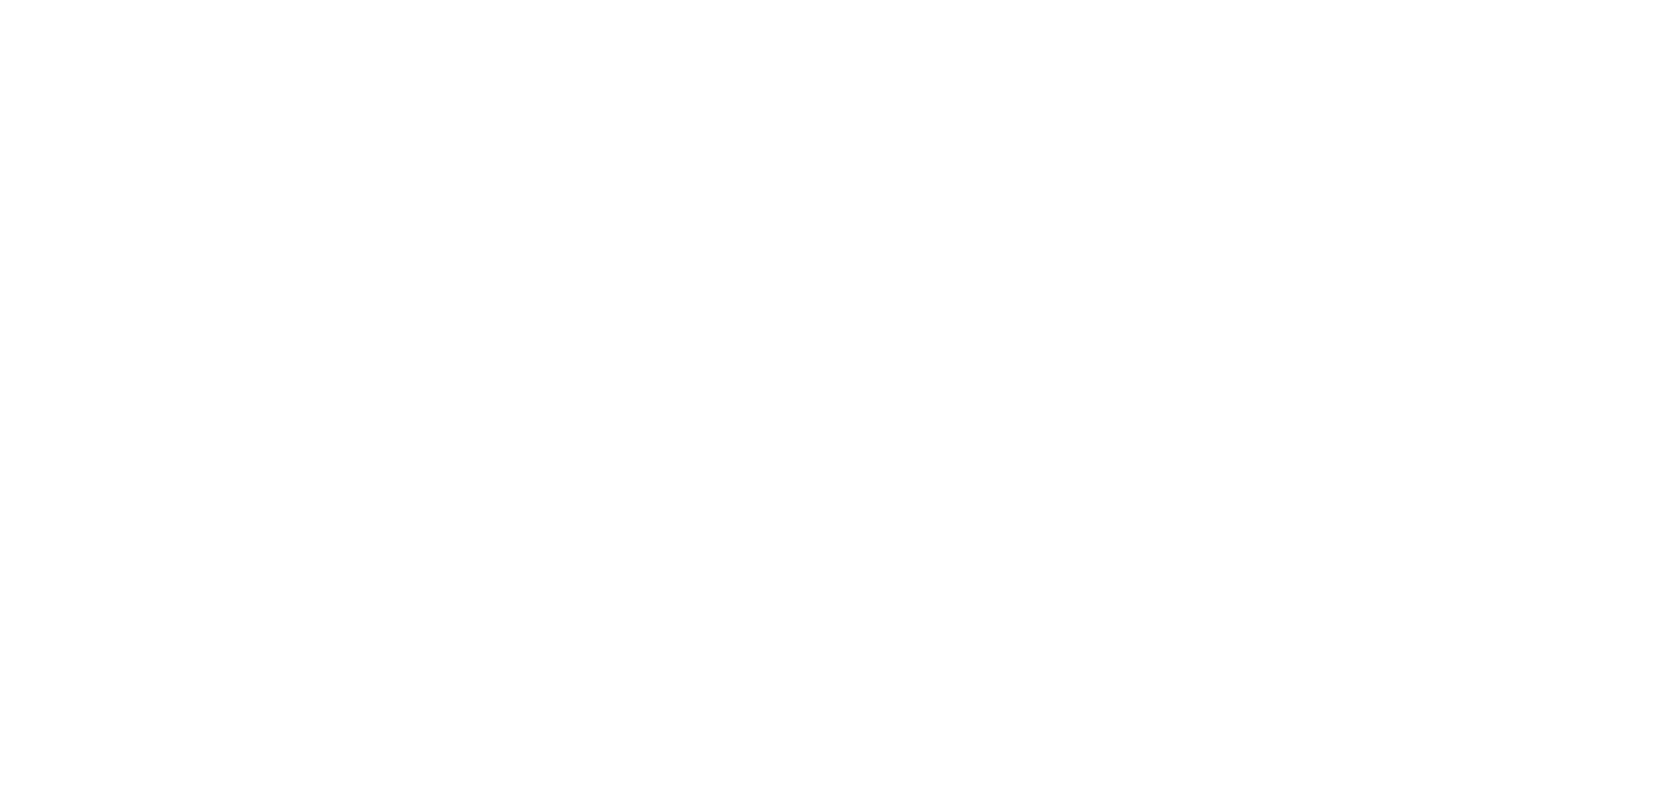

roi72_temporal.png


<IPython.core.display.Javascript object>


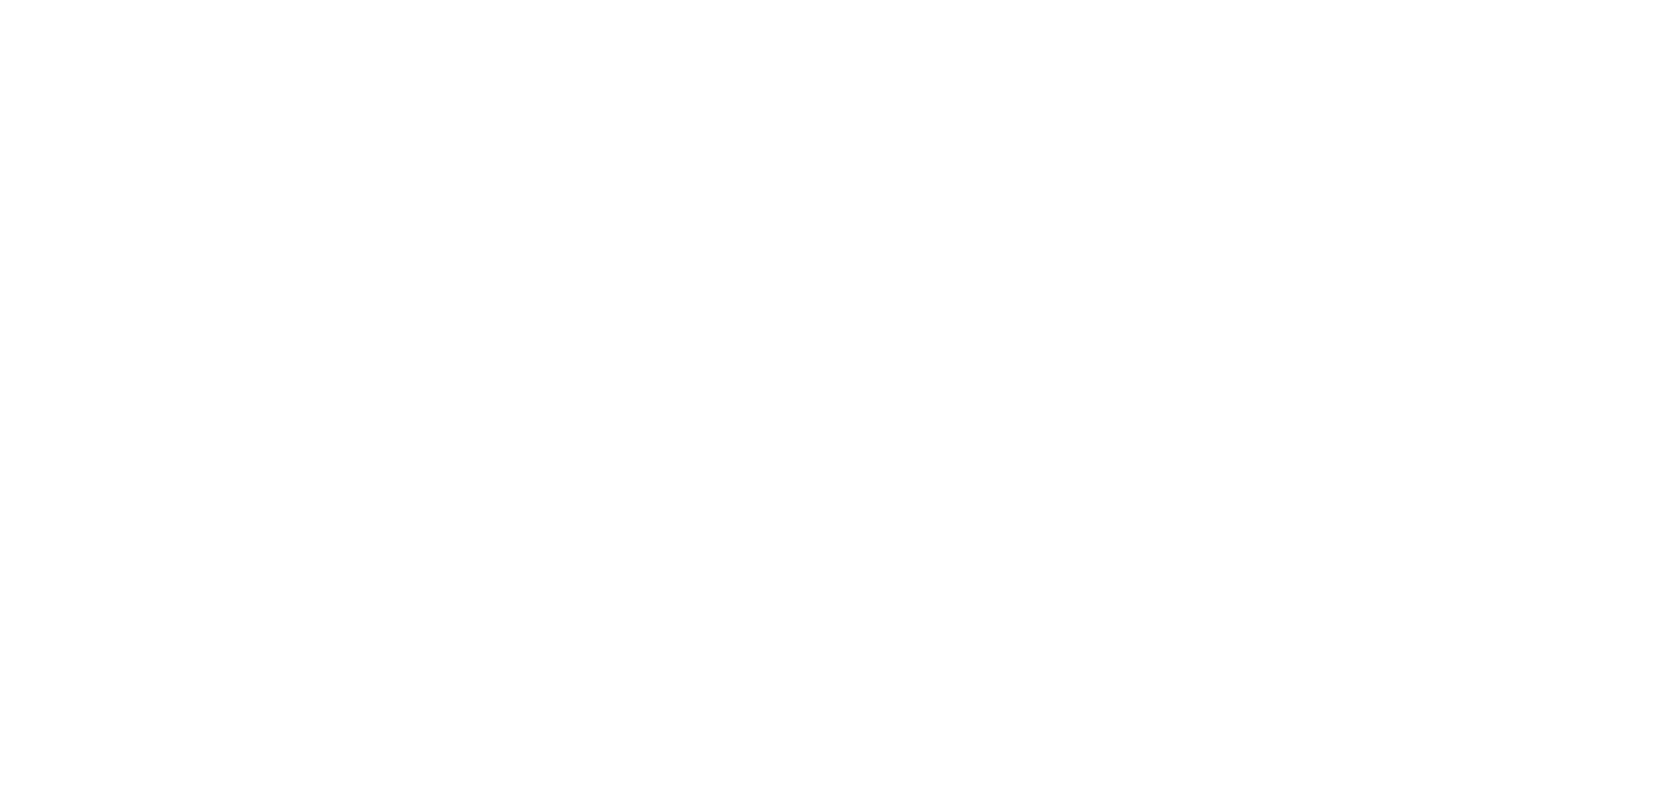

roi73_temporal.png


<IPython.core.display.Javascript object>


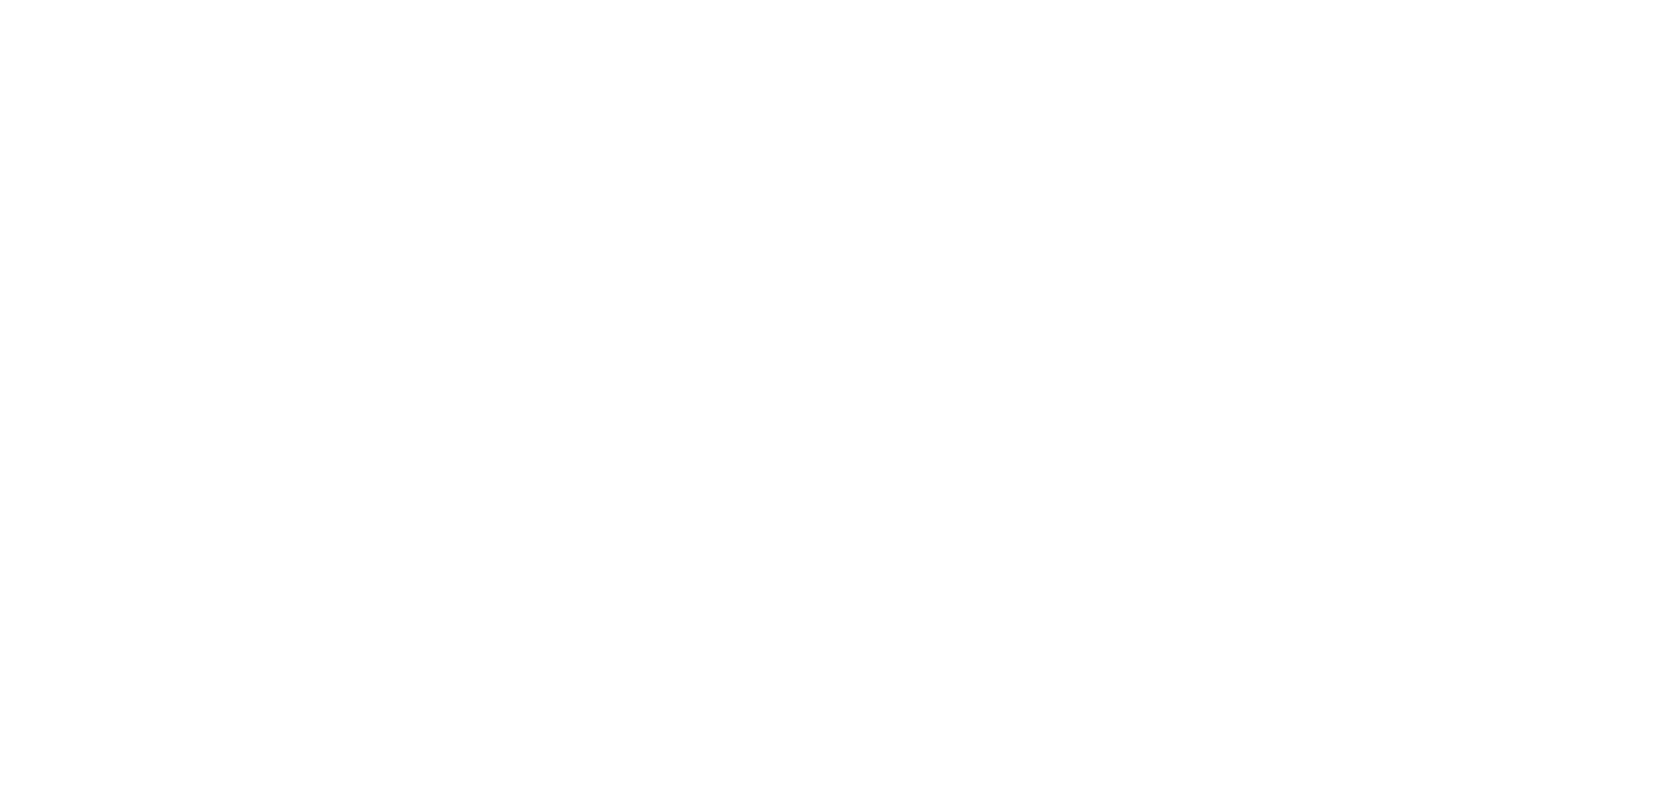

roi74_temporal.png


<IPython.core.display.Javascript object>


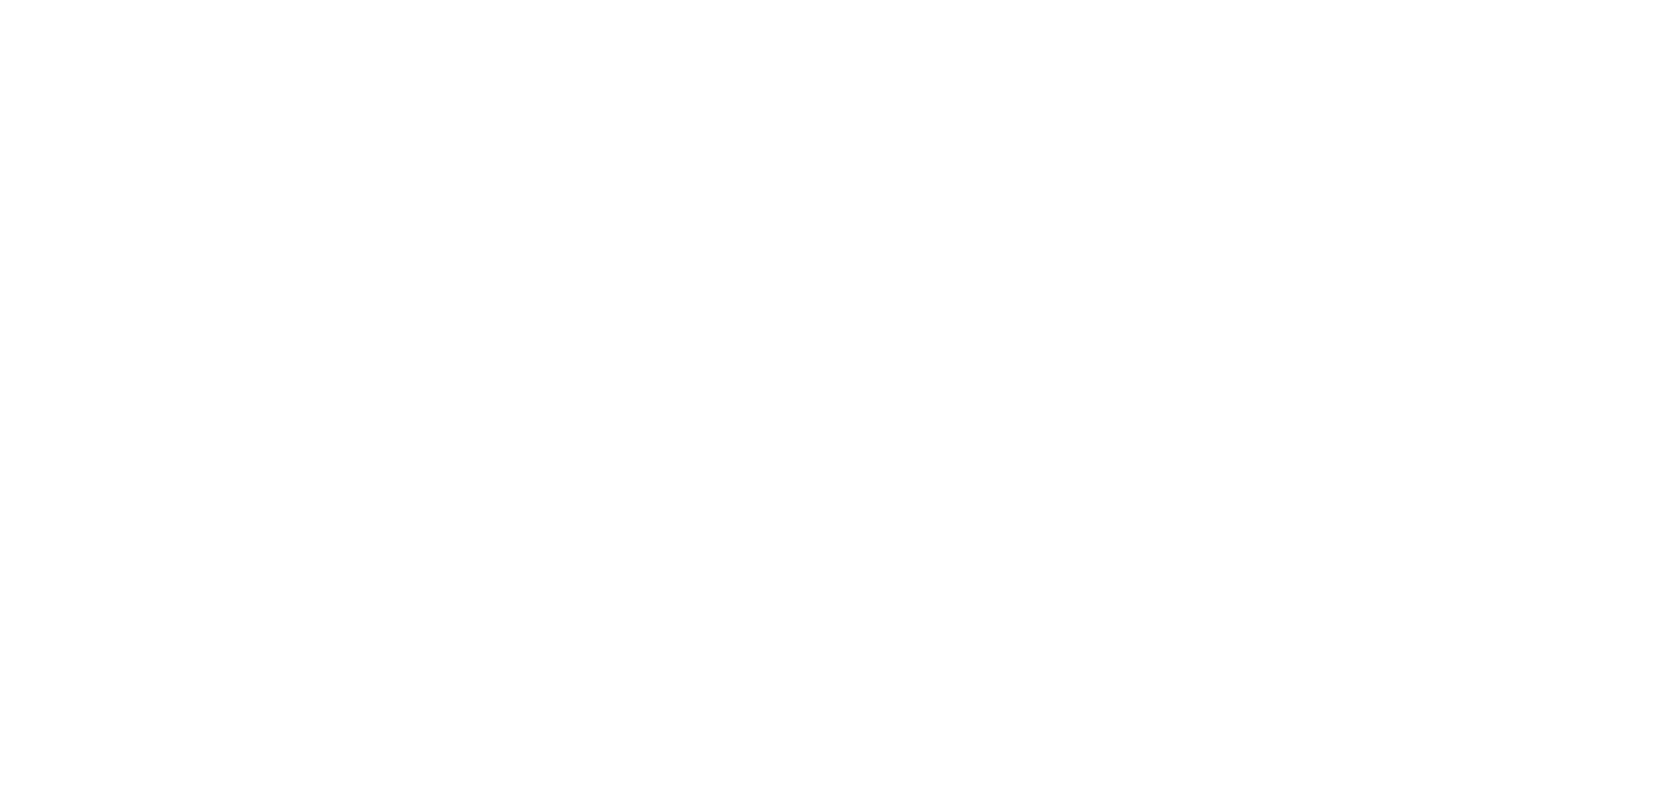

roi75_temporal.png


<IPython.core.display.Javascript object>


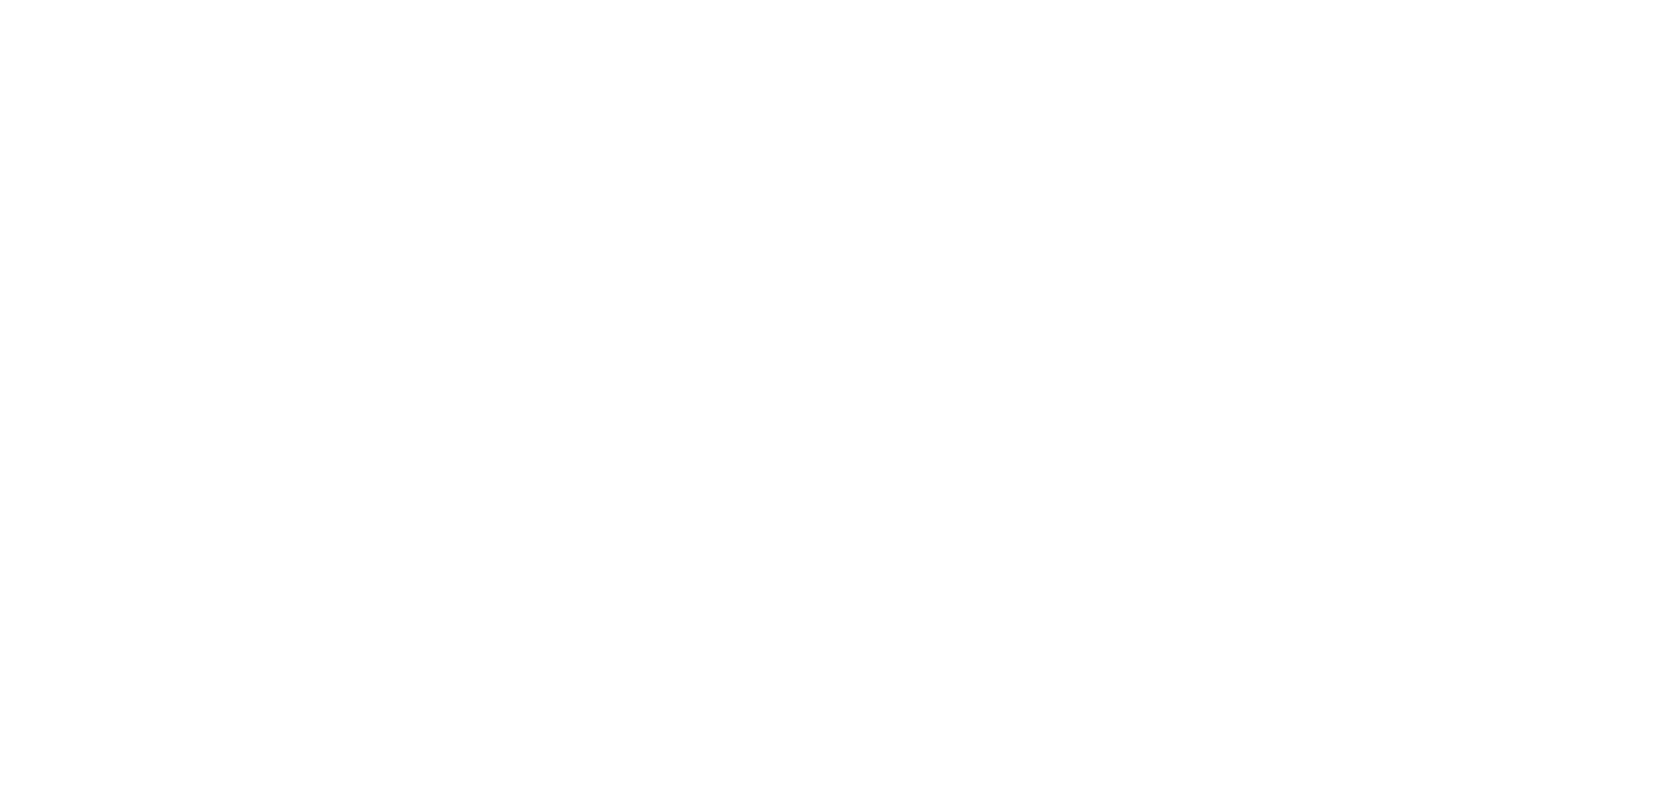

roi76_temporal.png


<IPython.core.display.Javascript object>


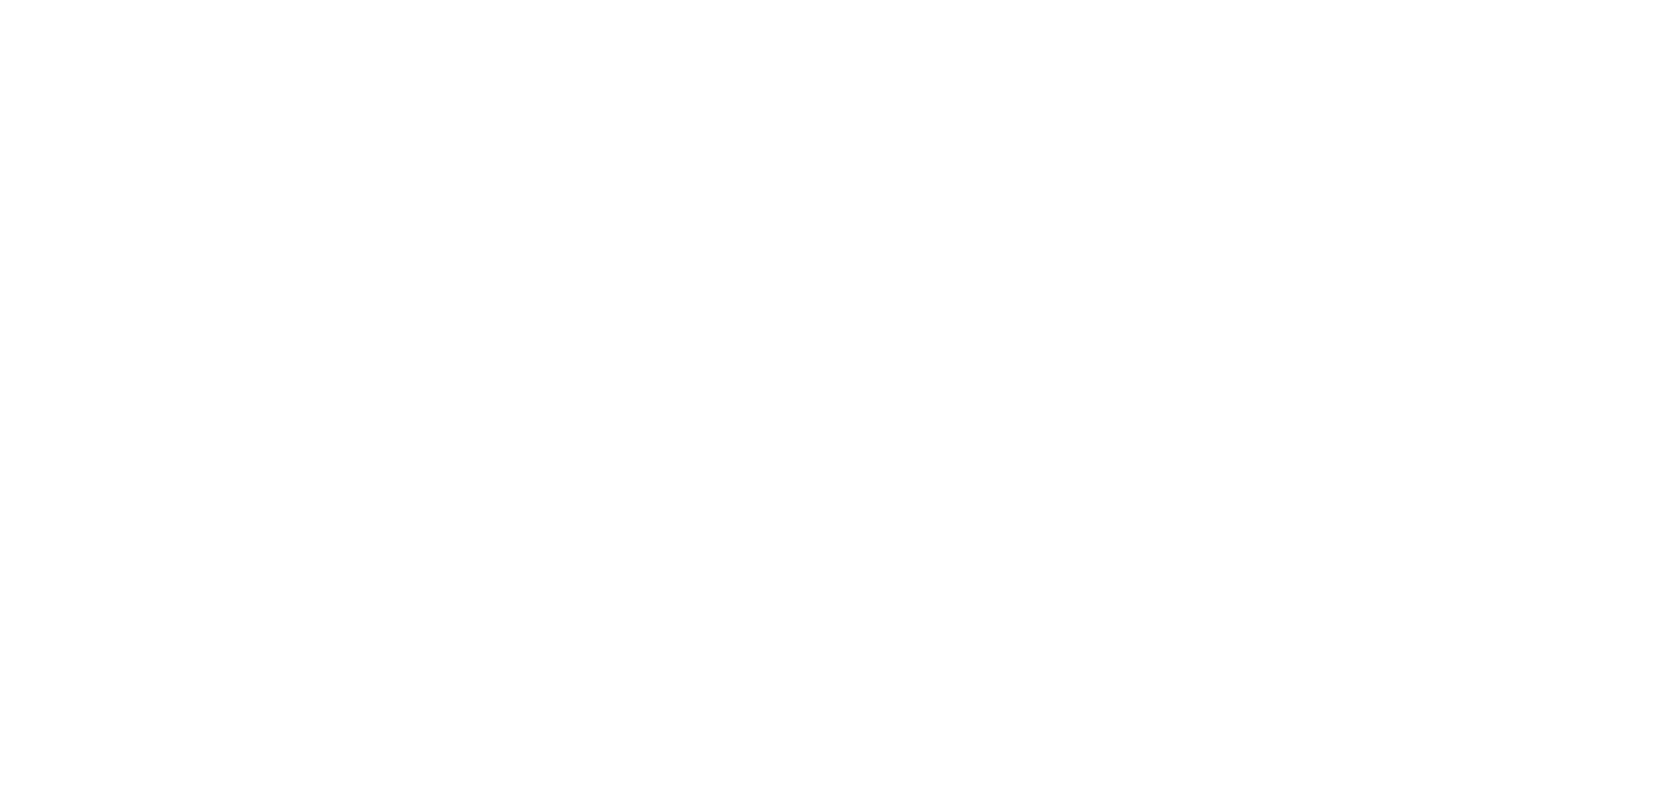

roi77_temporal.png


<IPython.core.display.Javascript object>


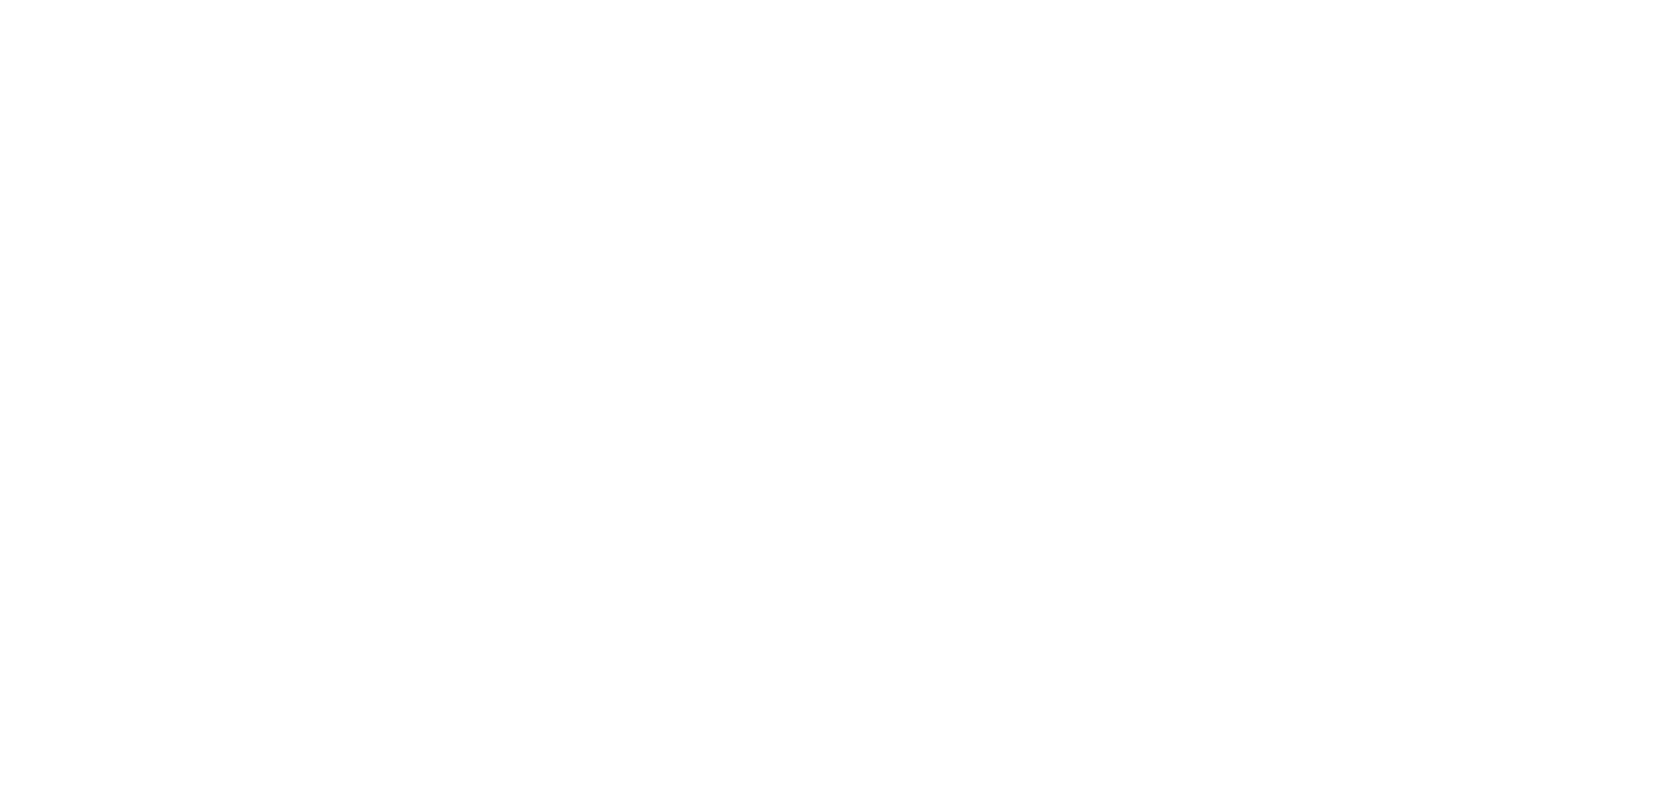

roi78_temporal.png


<IPython.core.display.Javascript object>


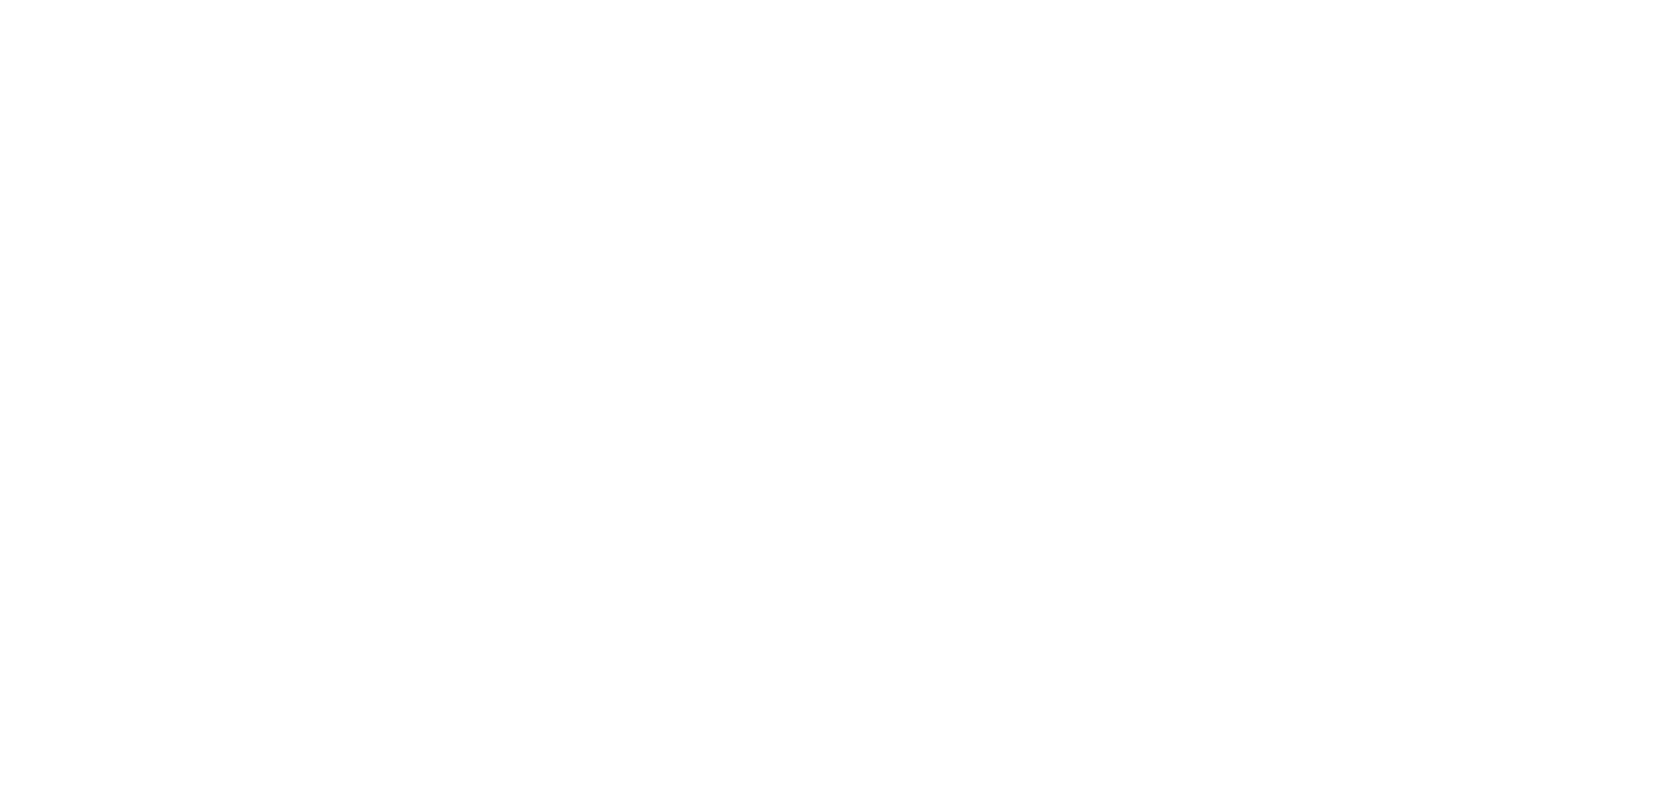

roi79_temporal.png


<IPython.core.display.Javascript object>


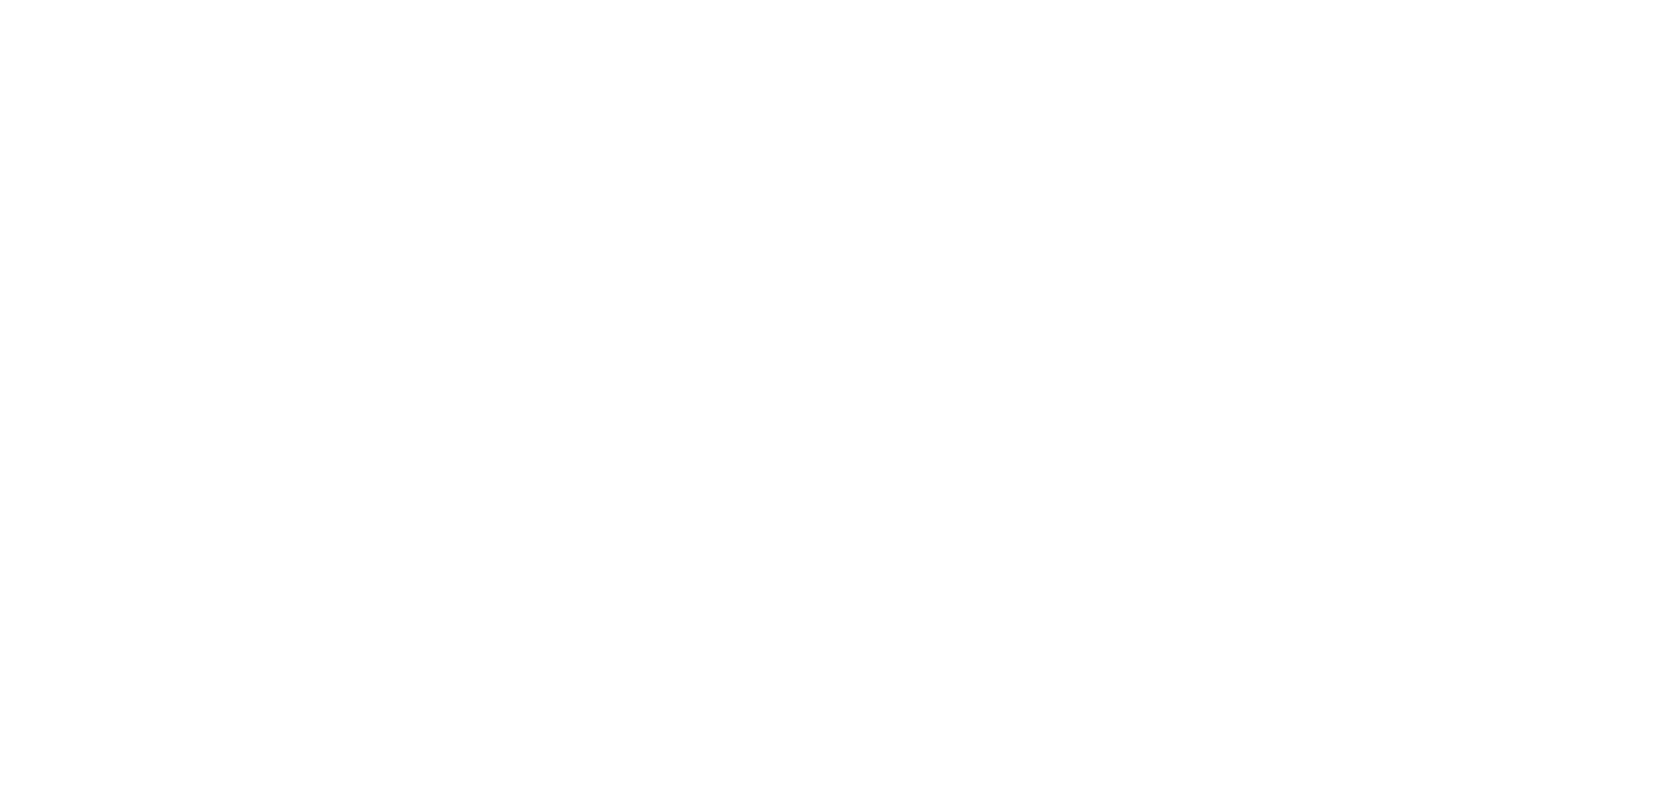

roi80_temporal.png


<IPython.core.display.Javascript object>


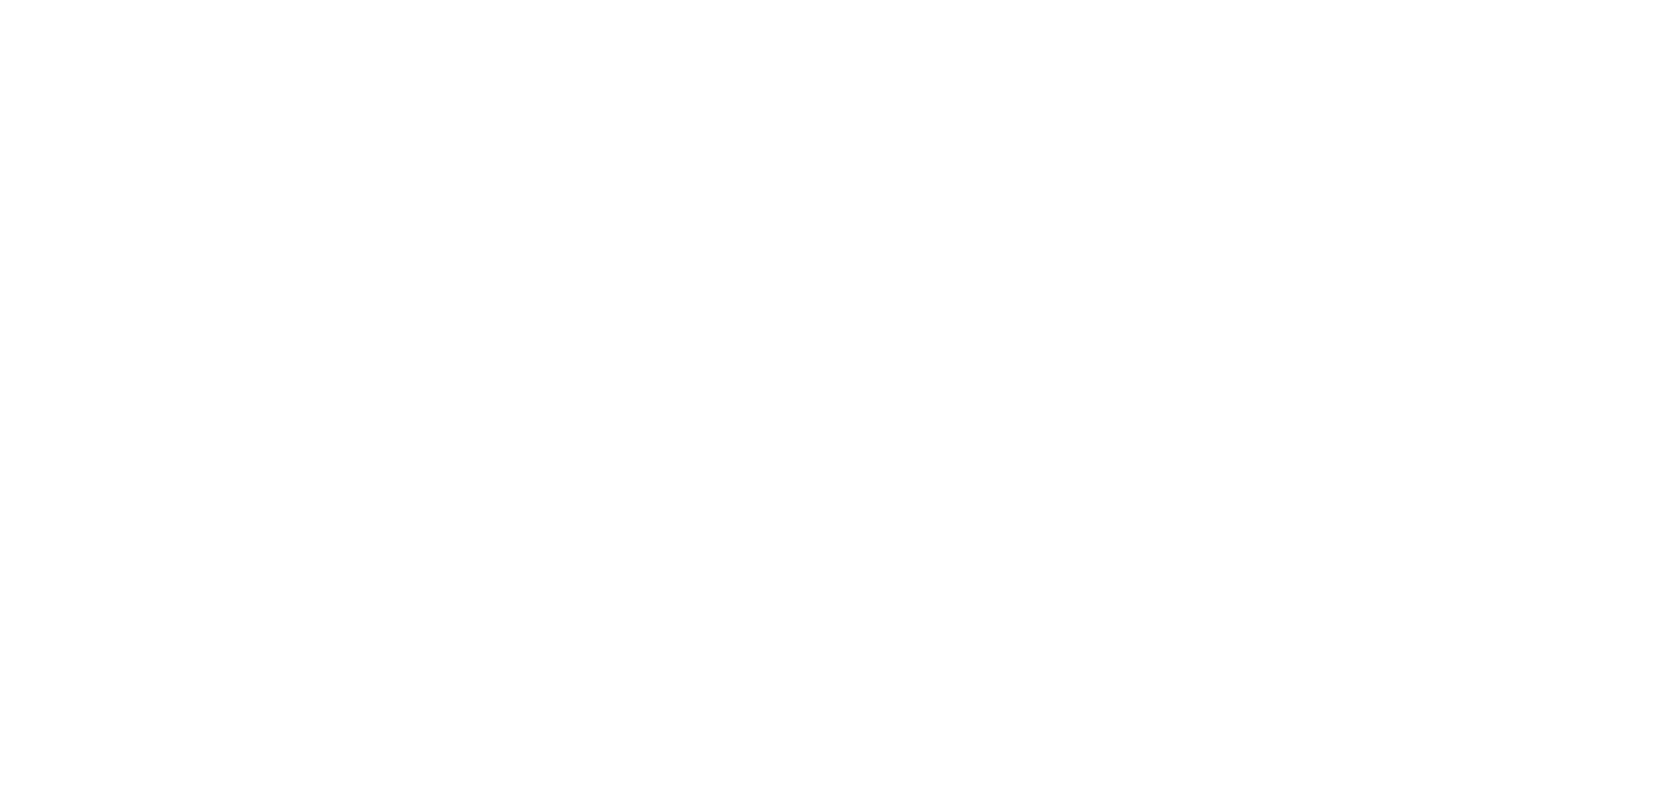

roi81_temporal.png


<IPython.core.display.Javascript object>


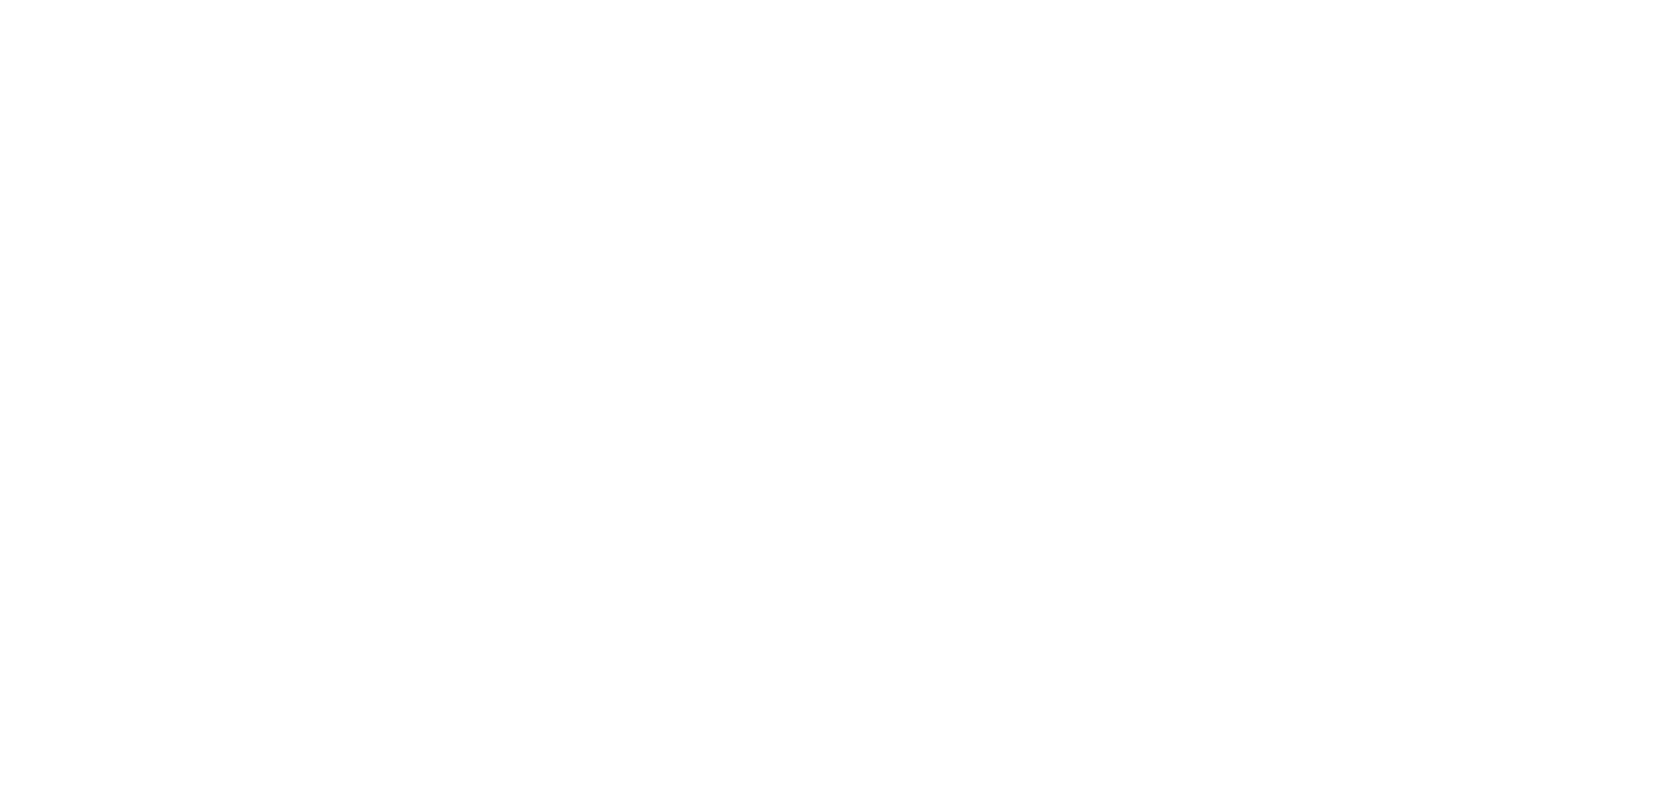

roi82_temporal.png


<IPython.core.display.Javascript object>


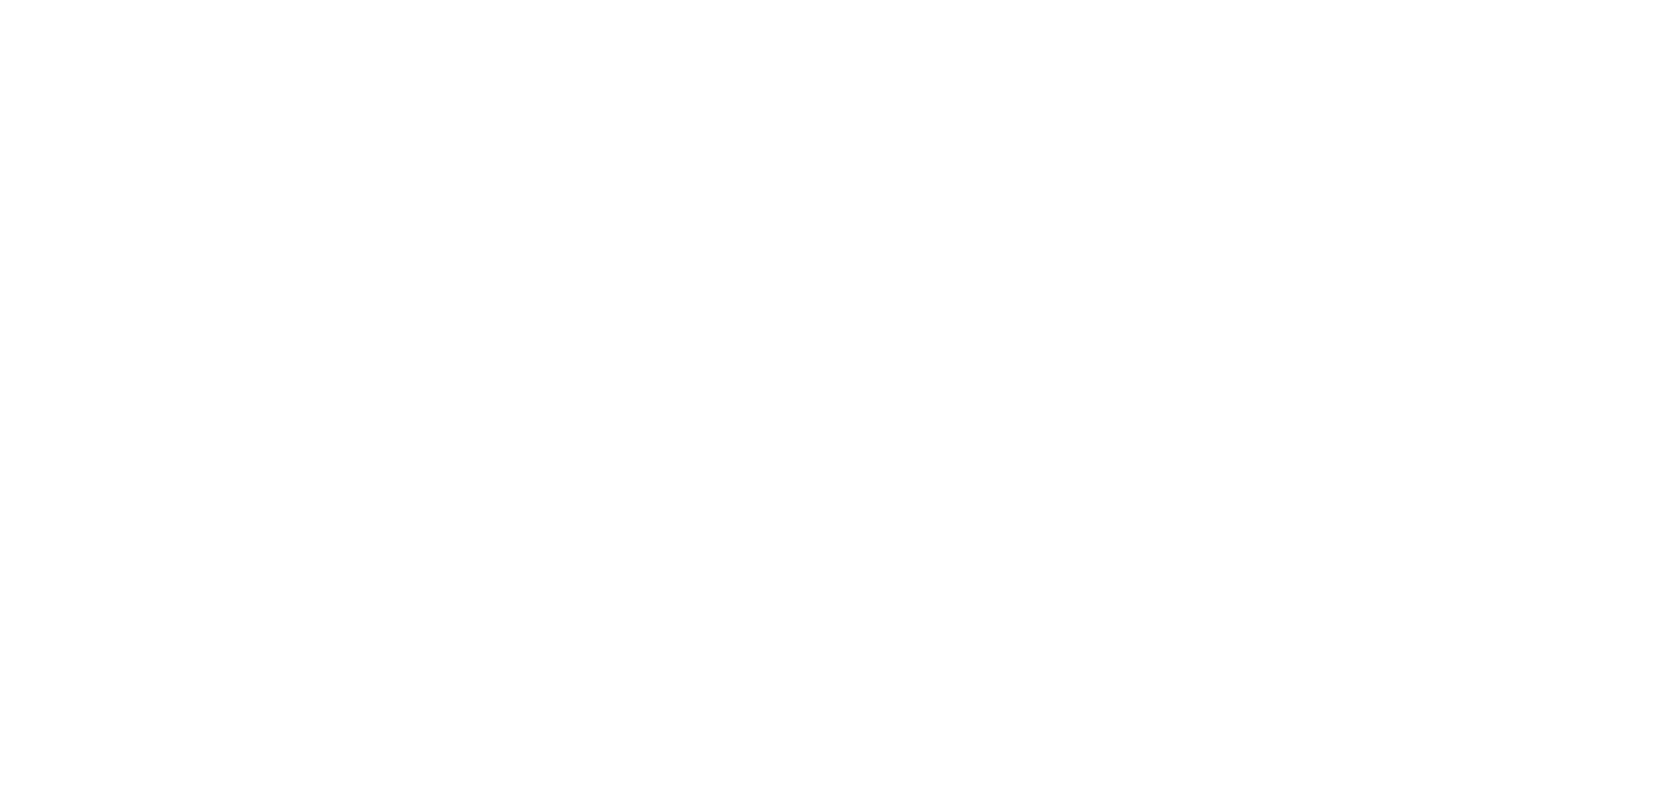

roi83_temporal.png


<IPython.core.display.Javascript object>


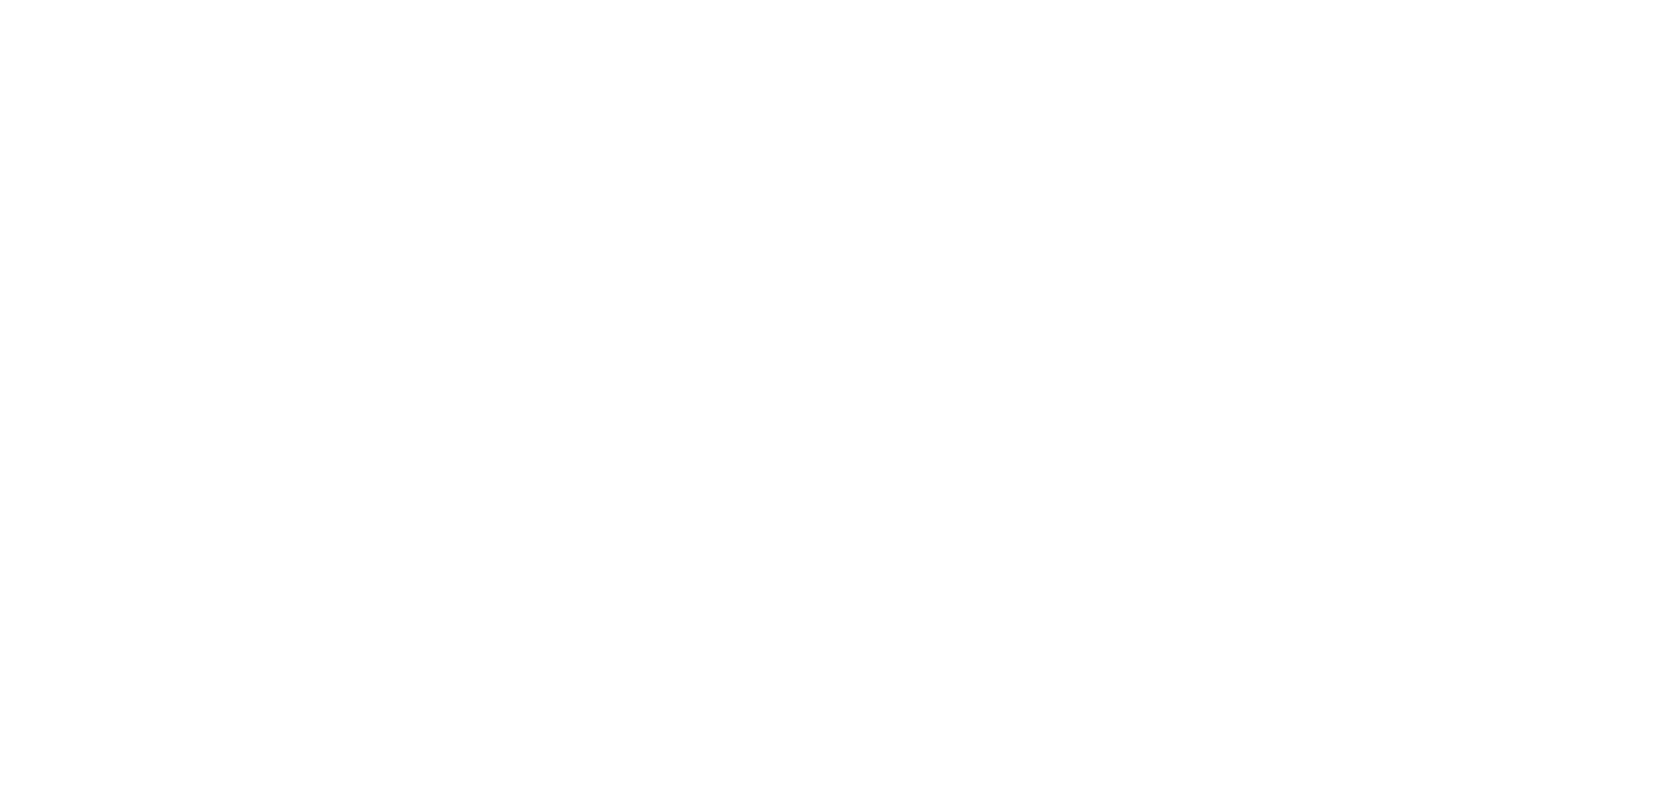

roi84_temporal.png


<IPython.core.display.Javascript object>


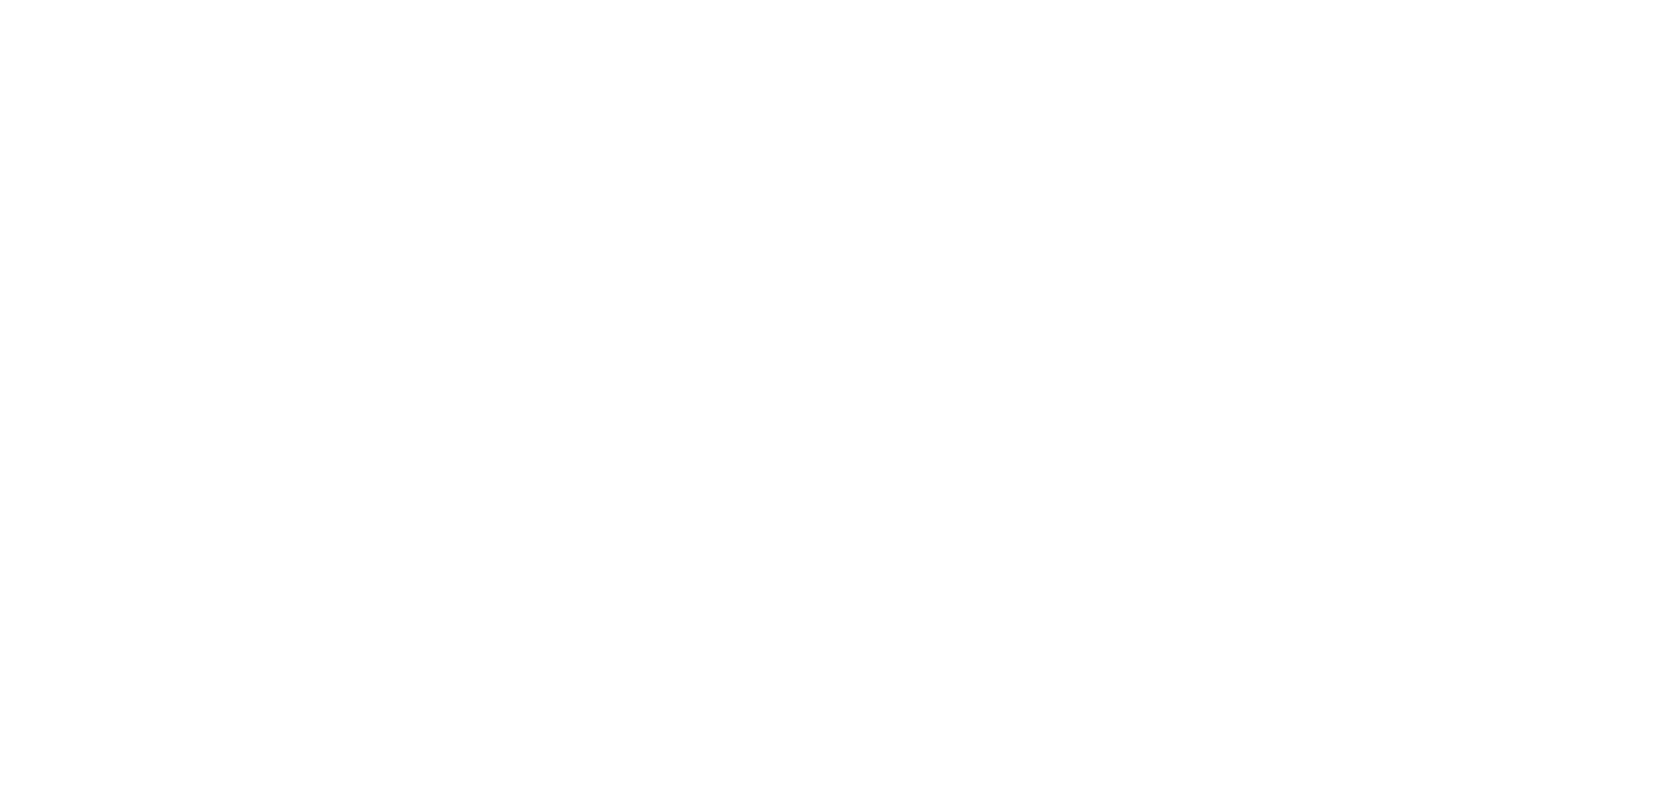

roi85_temporal.png


<IPython.core.display.Javascript object>


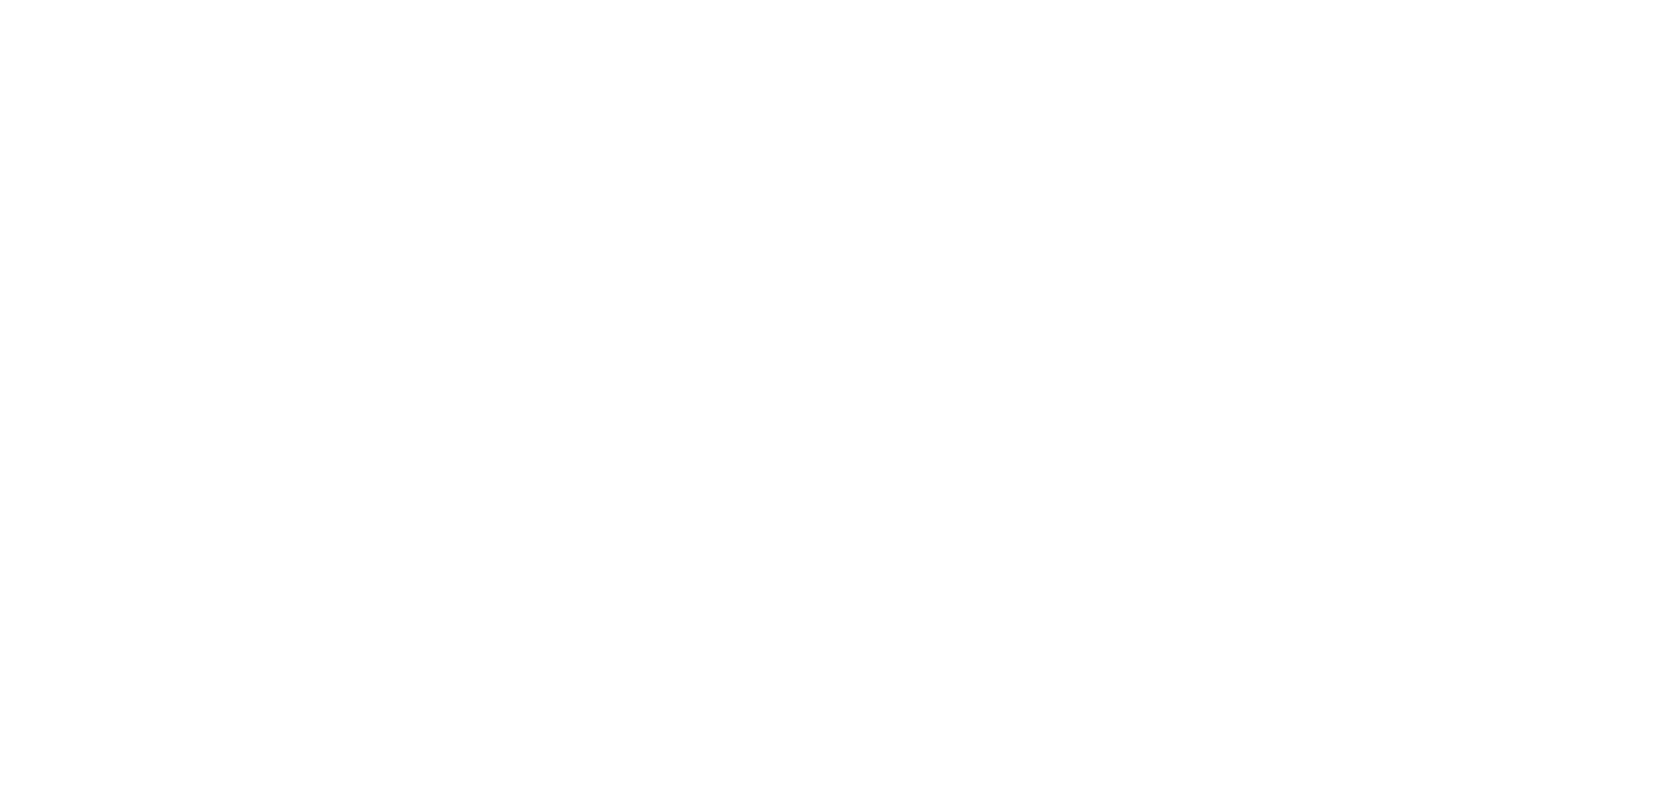

roi86_temporal.png


<IPython.core.display.Javascript object>


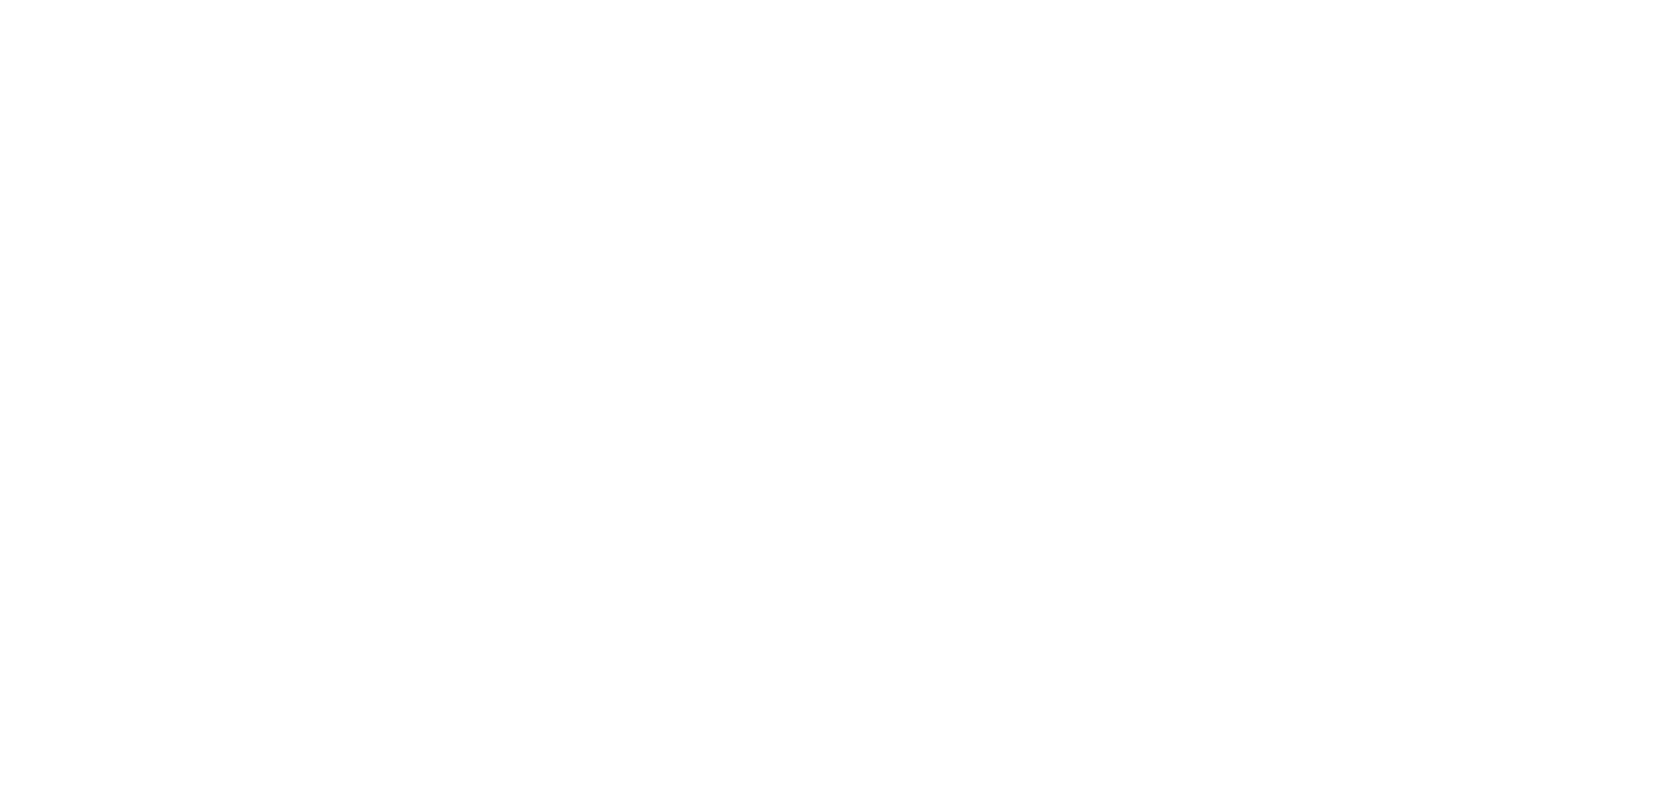

roi87_temporal.png


<IPython.core.display.Javascript object>


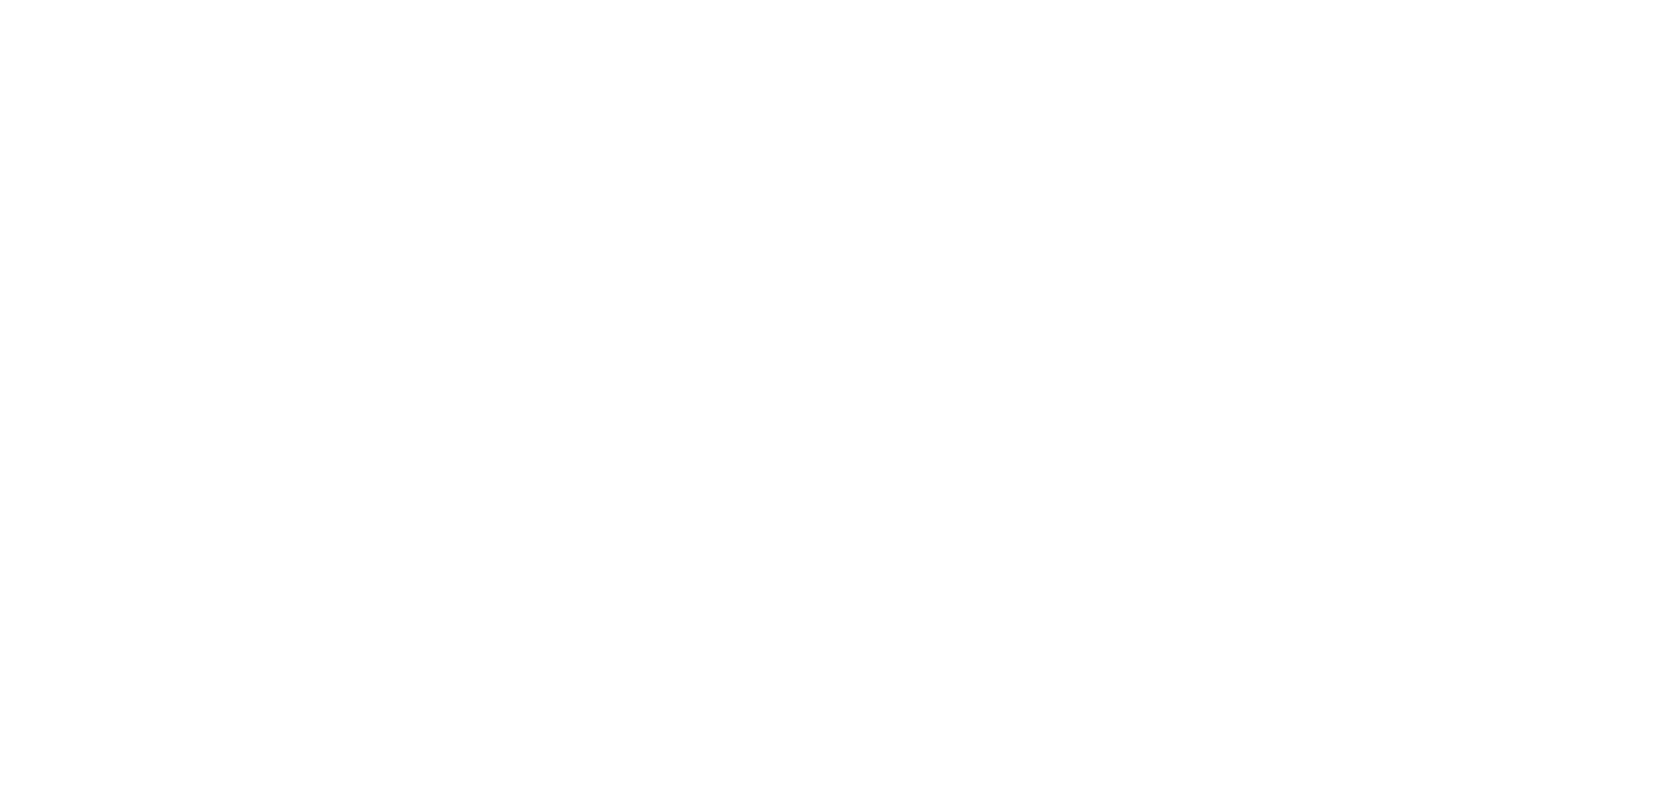

roi88_temporal.png


<IPython.core.display.Javascript object>


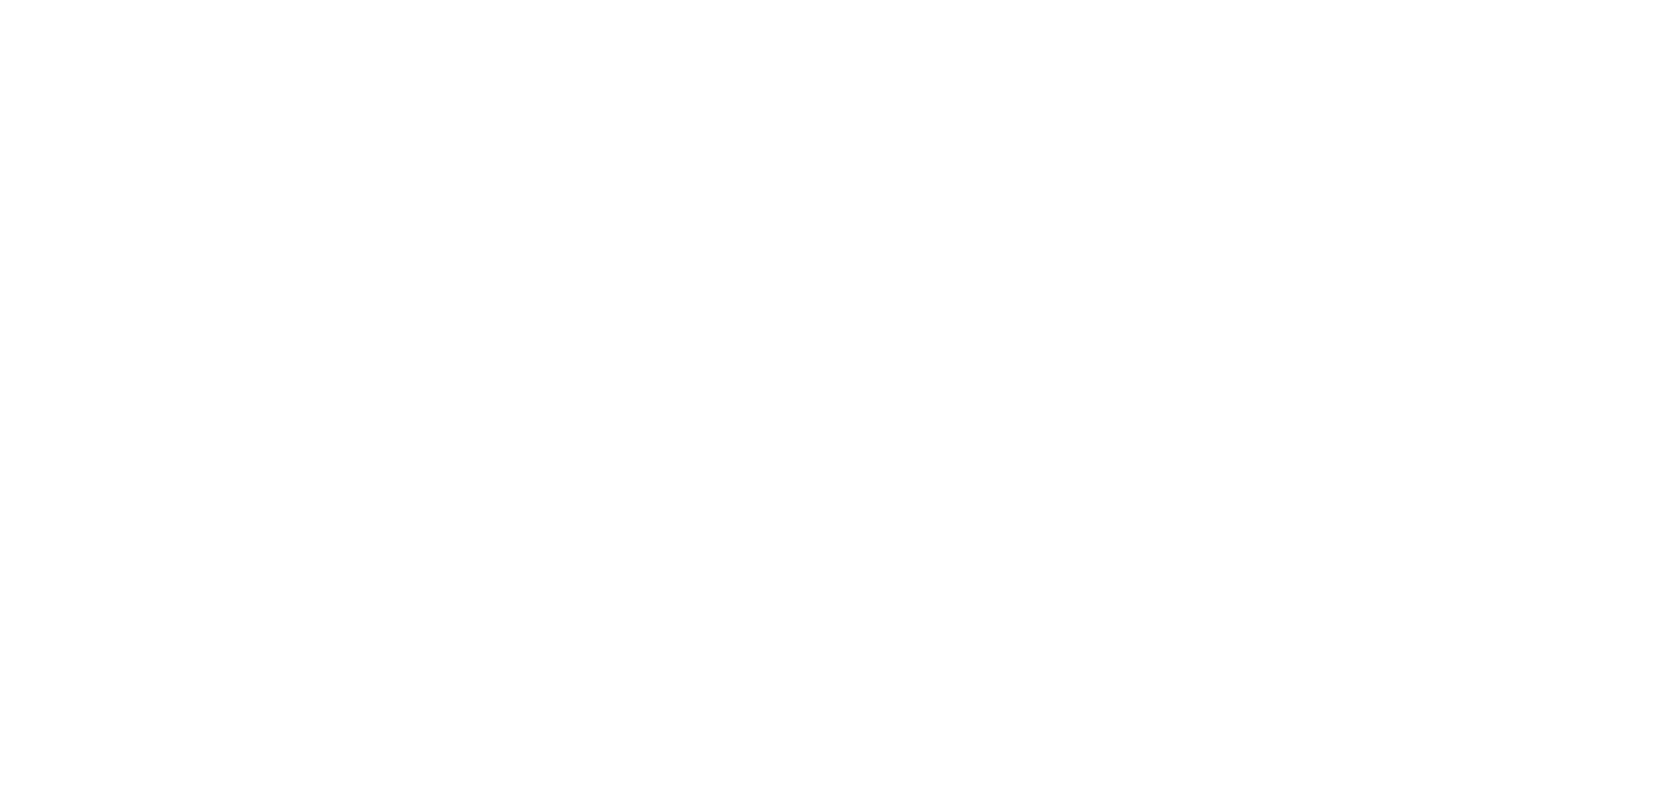

roi89_temporal.png


<IPython.core.display.Javascript object>


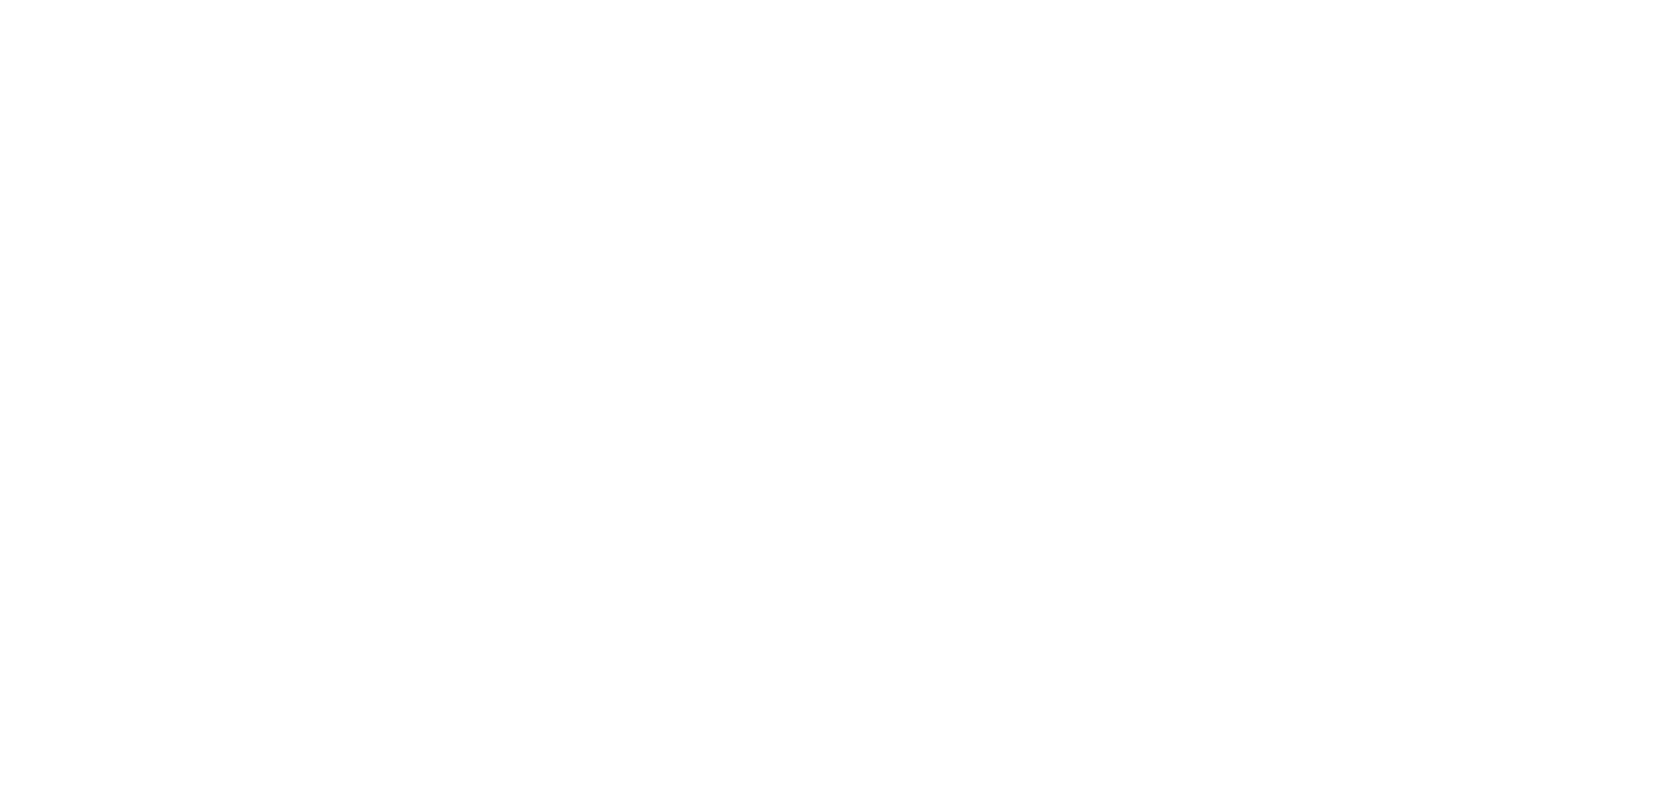

roi90_temporal.png


<IPython.core.display.Javascript object>


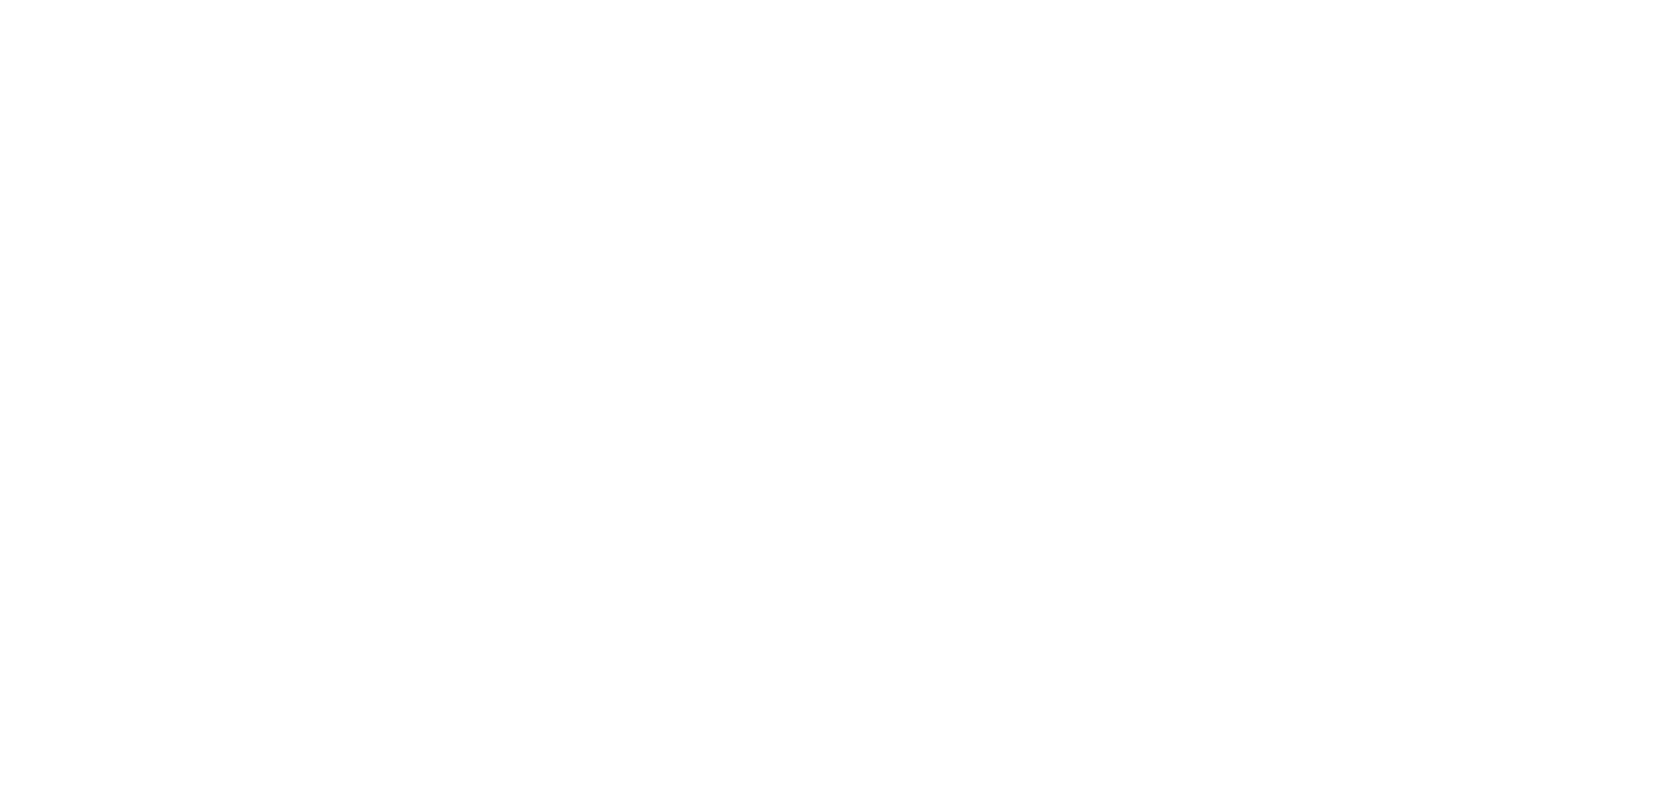

roi91_temporal.png


<IPython.core.display.Javascript object>


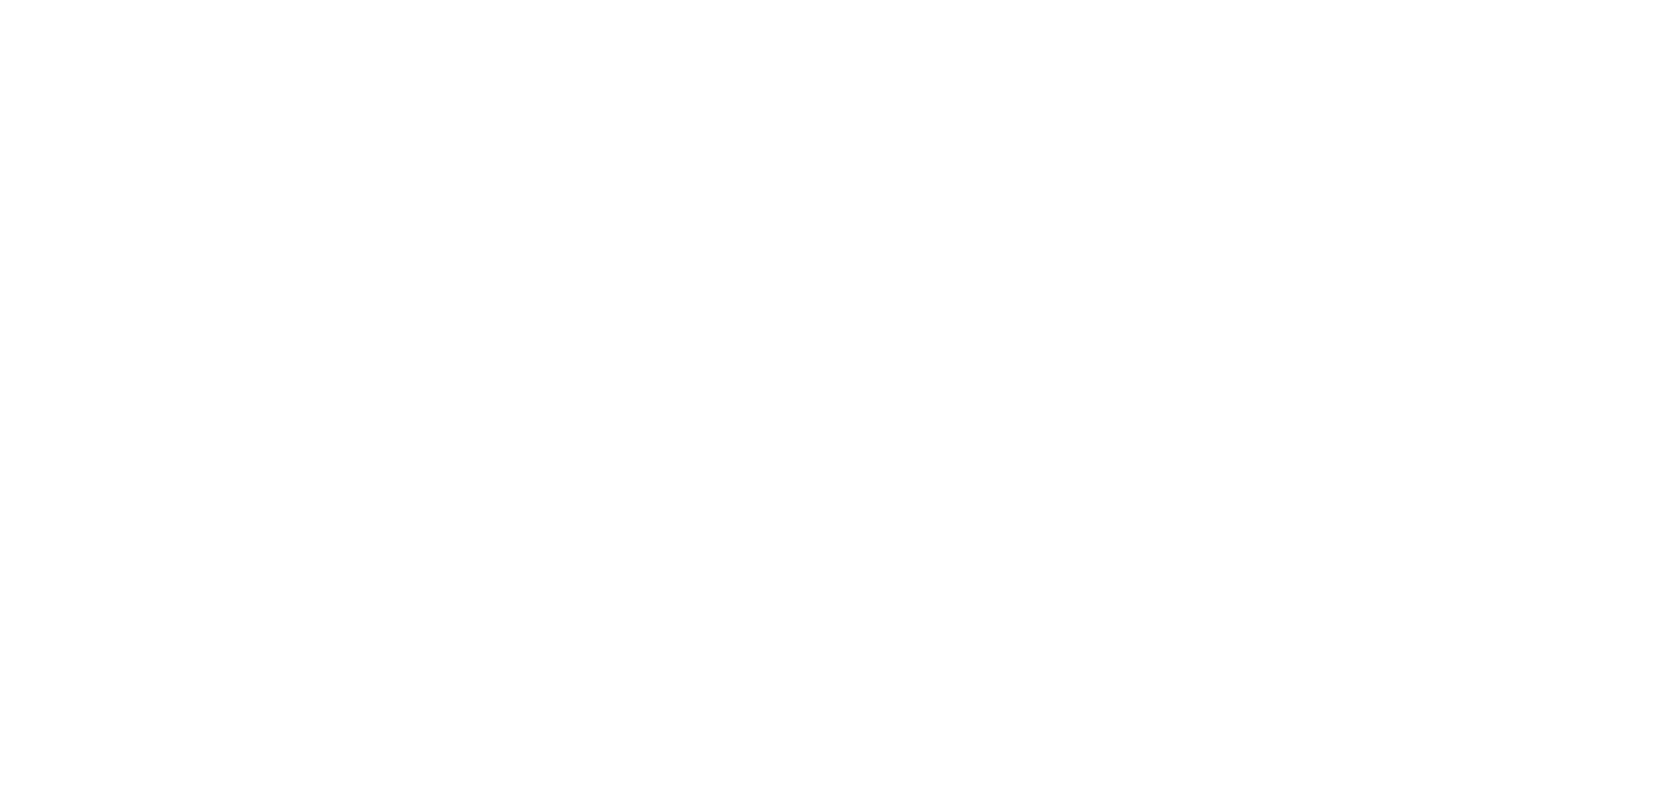

roi92_temporal.png


<IPython.core.display.Javascript object>


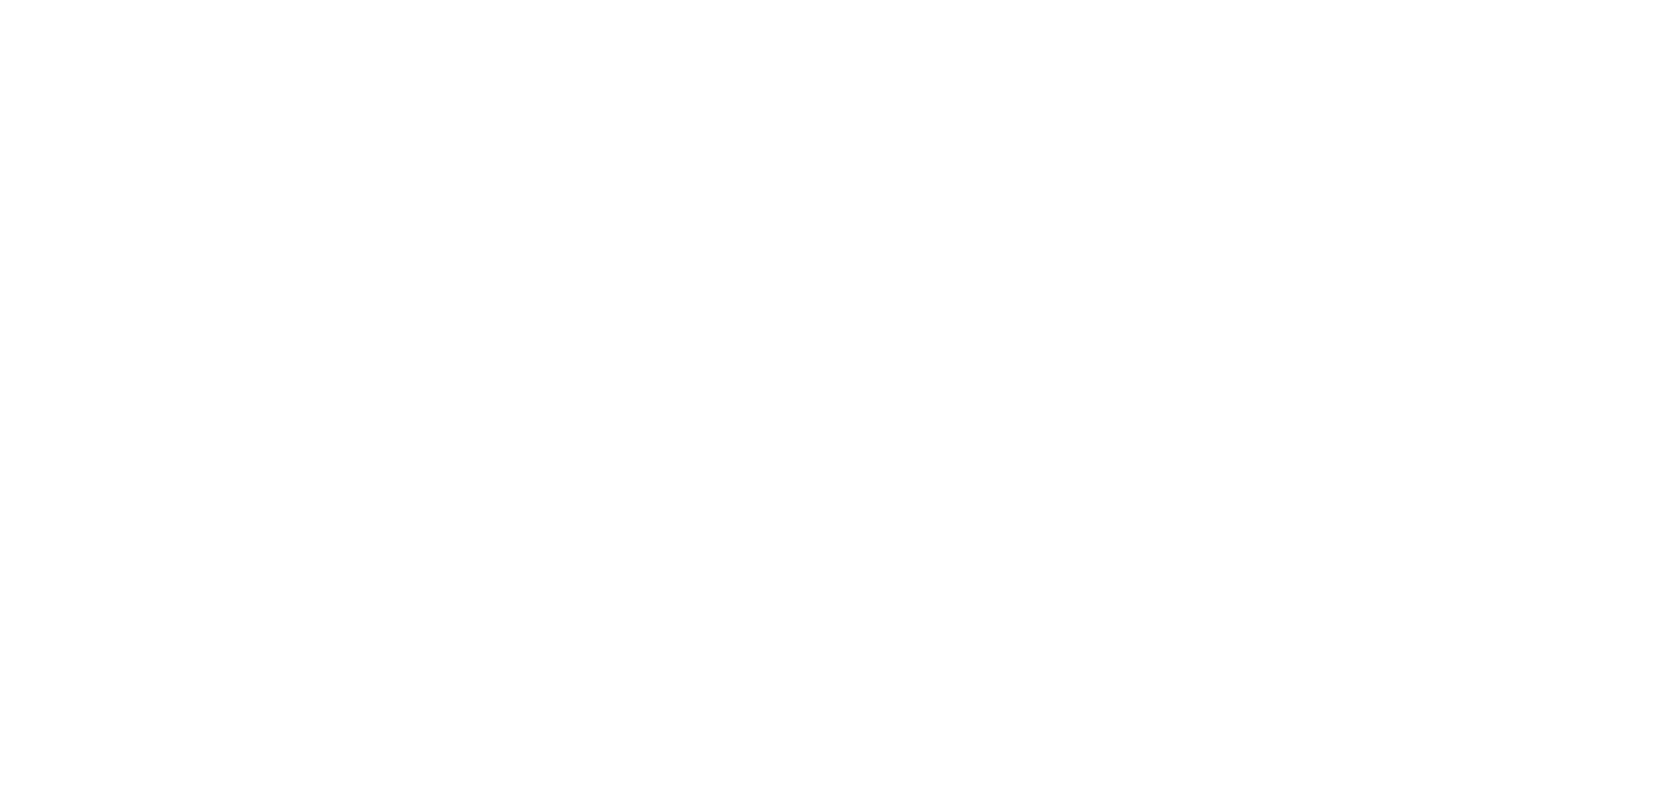

roi93_temporal.png


<IPython.core.display.Javascript object>


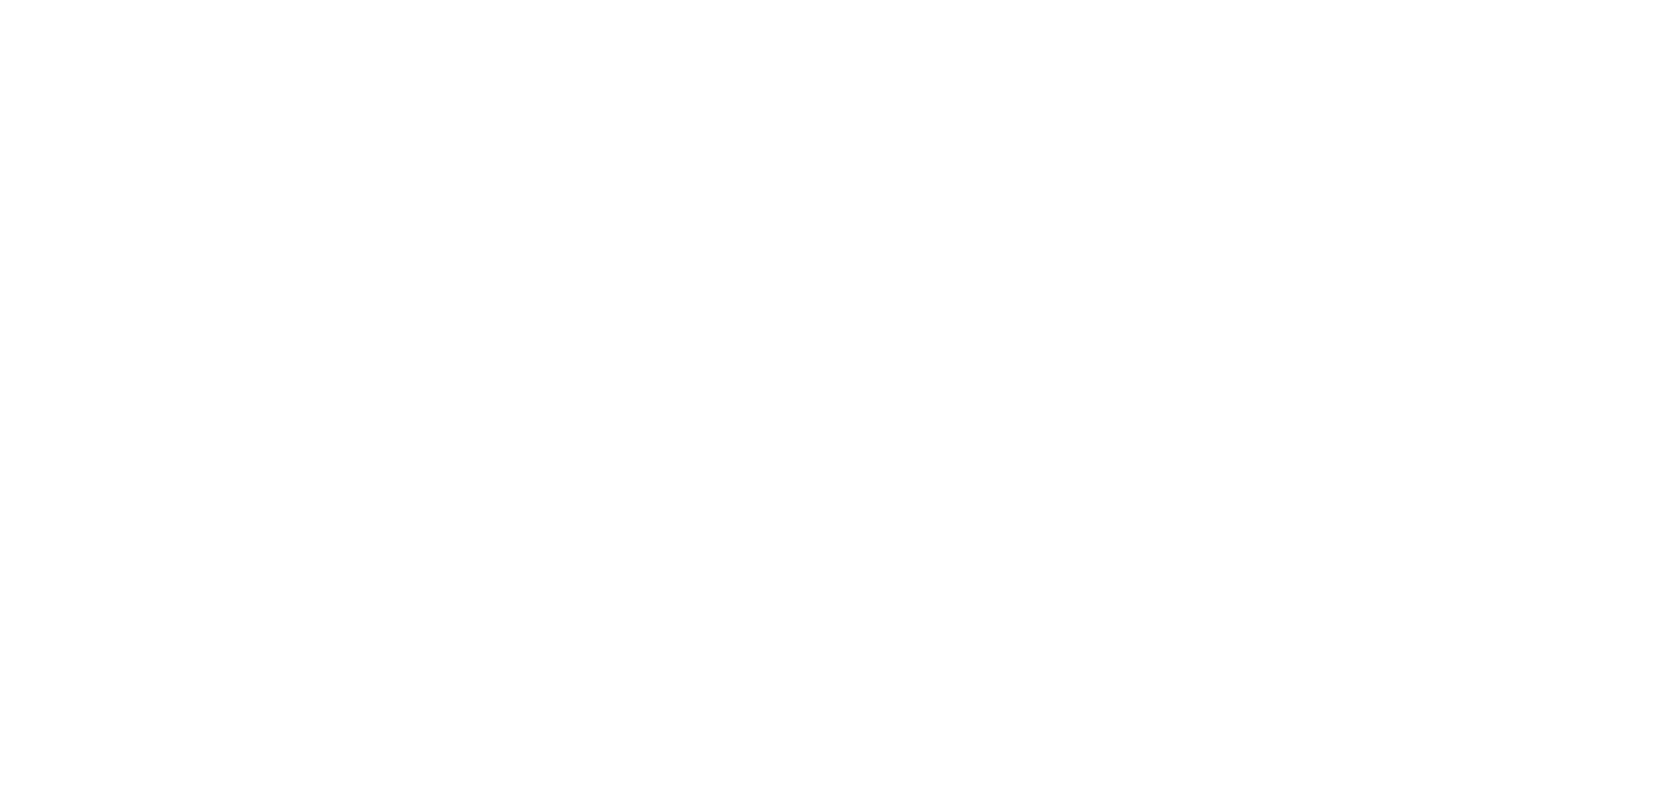

roi94_temporal.png


<IPython.core.display.Javascript object>


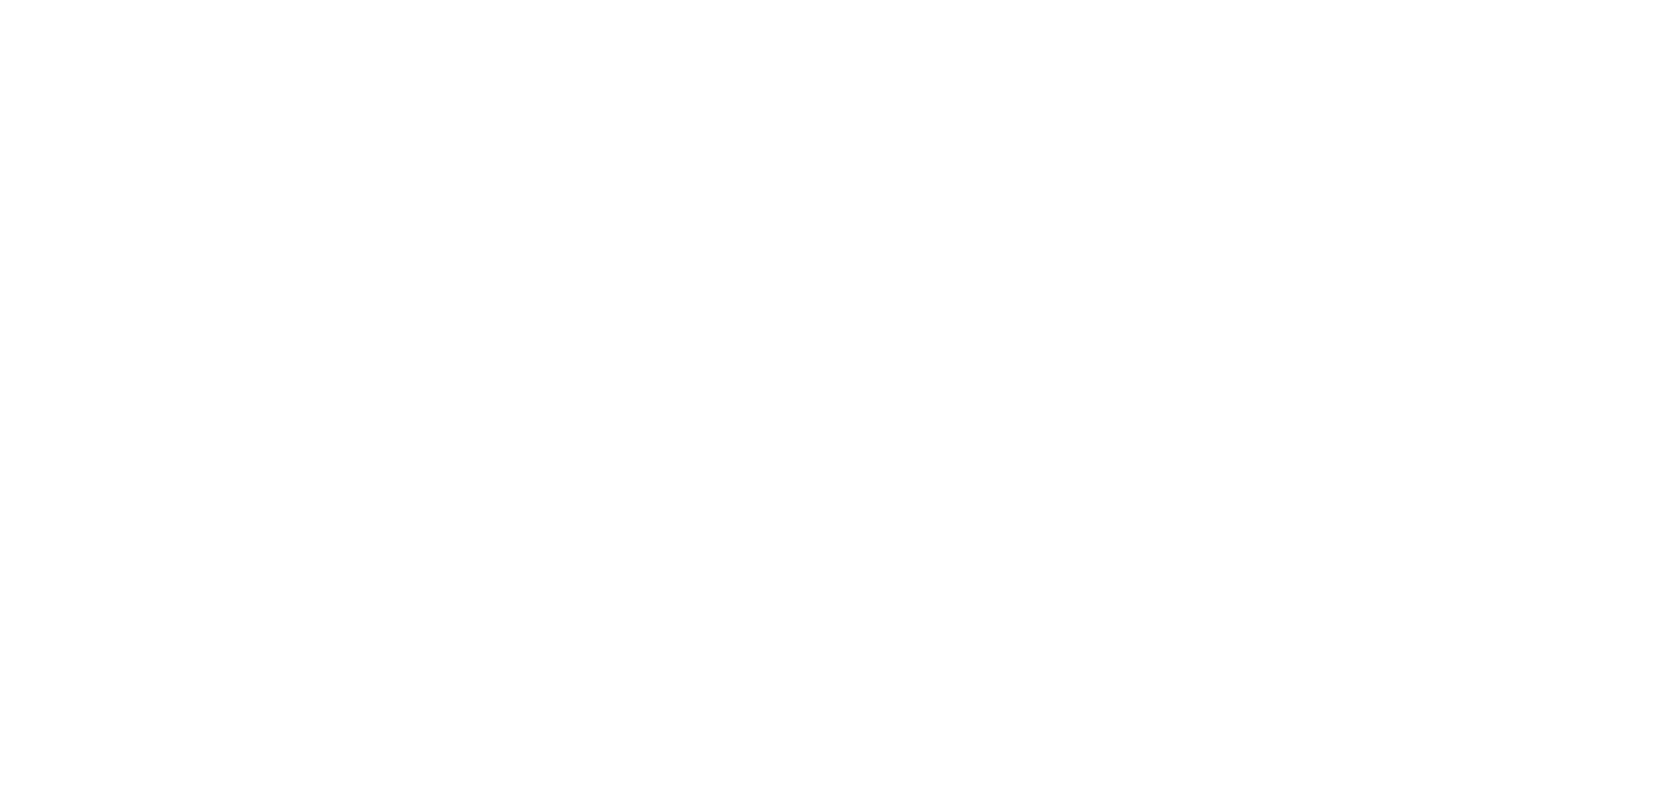

roi95_temporal.png


<IPython.core.display.Javascript object>


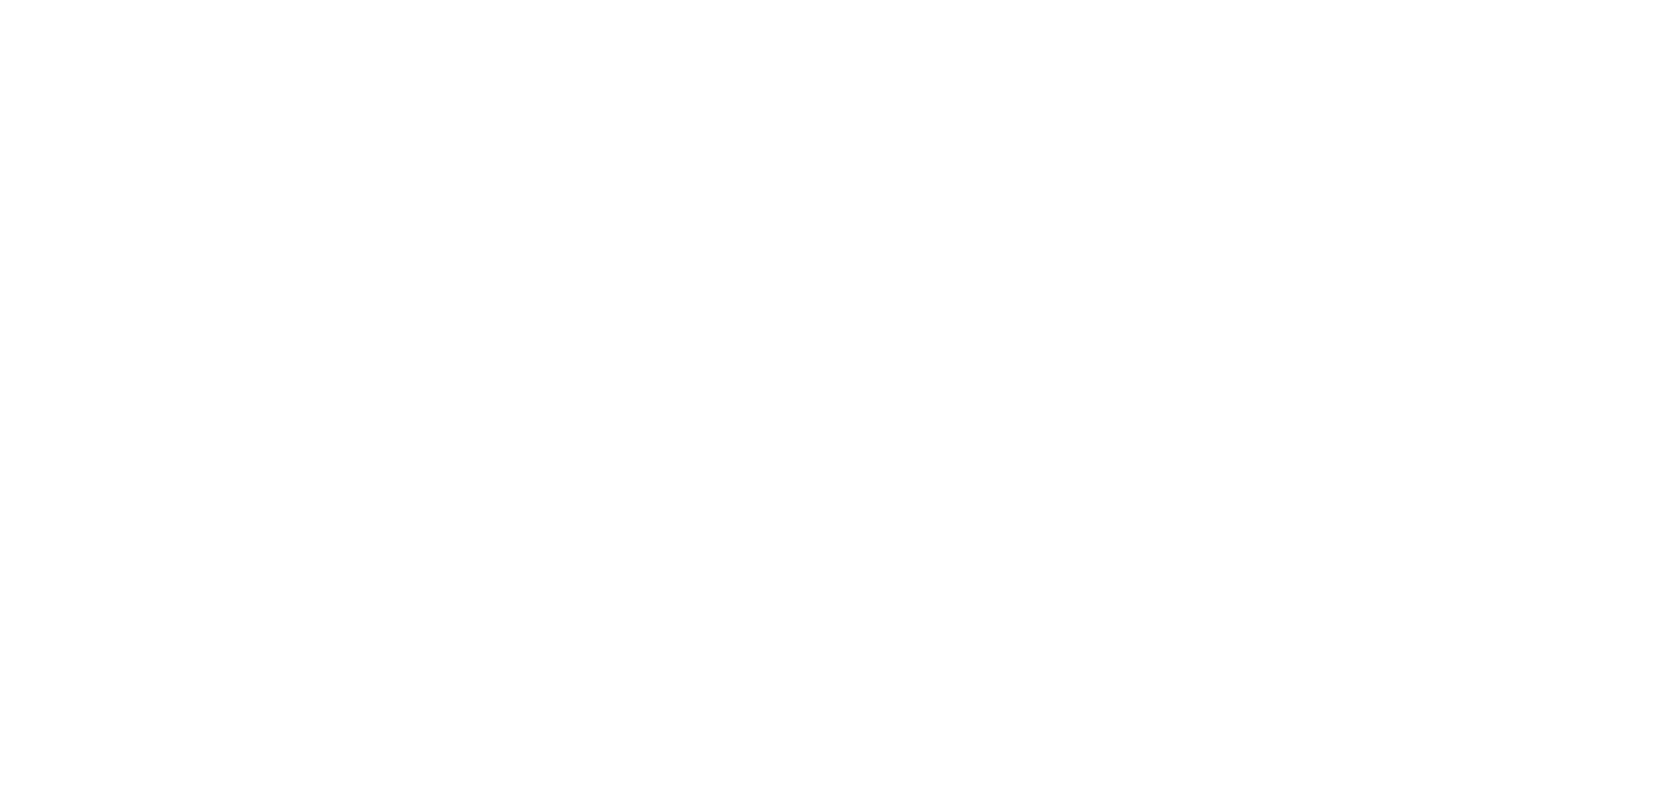

roi96_temporal.png


<IPython.core.display.Javascript object>


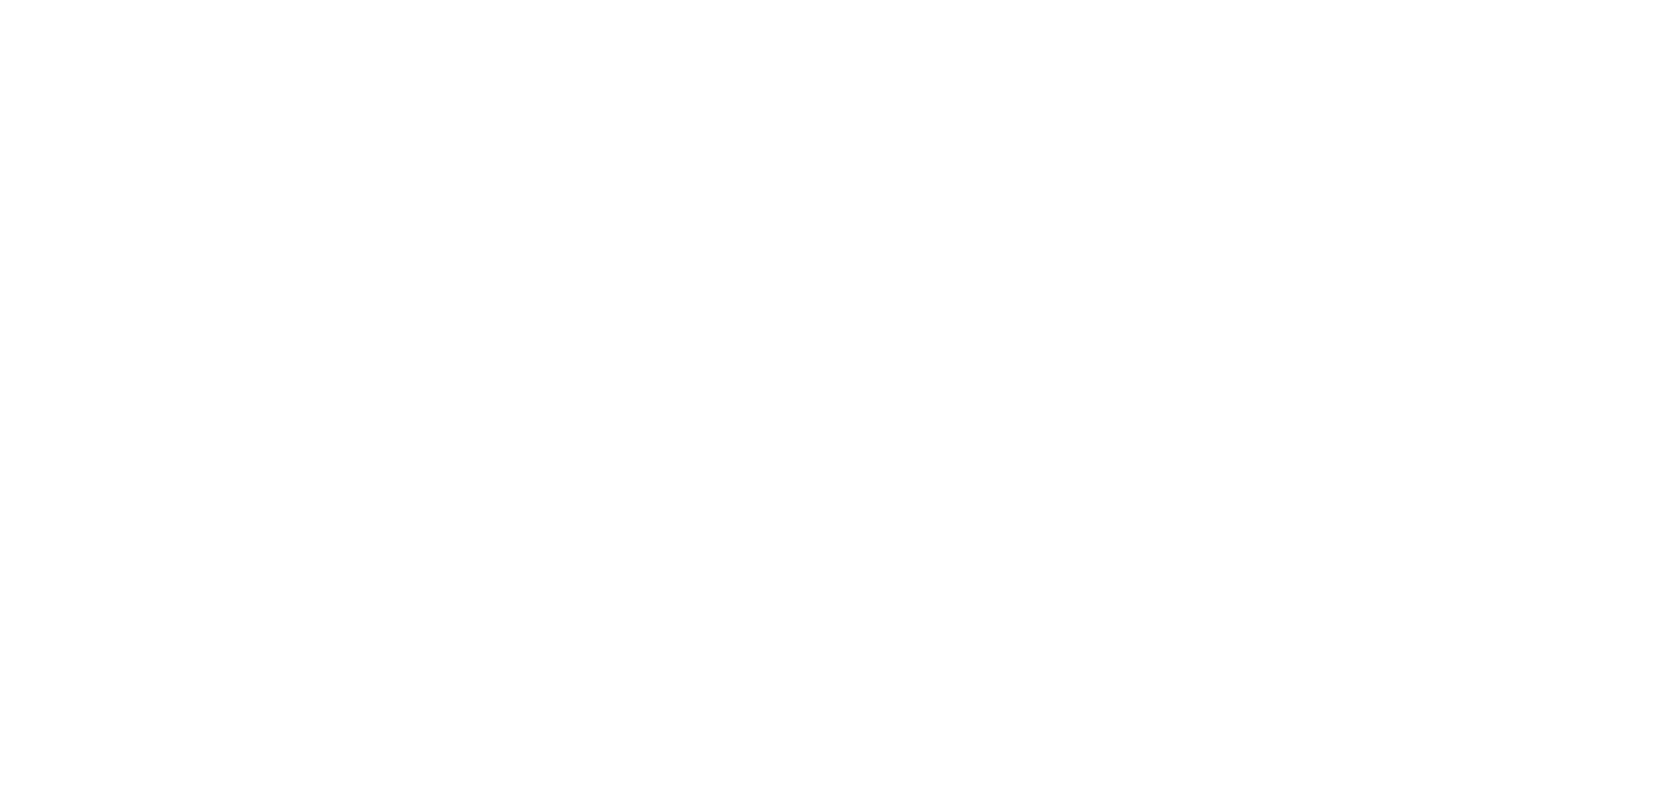

roi97_temporal.png


<IPython.core.display.Javascript object>


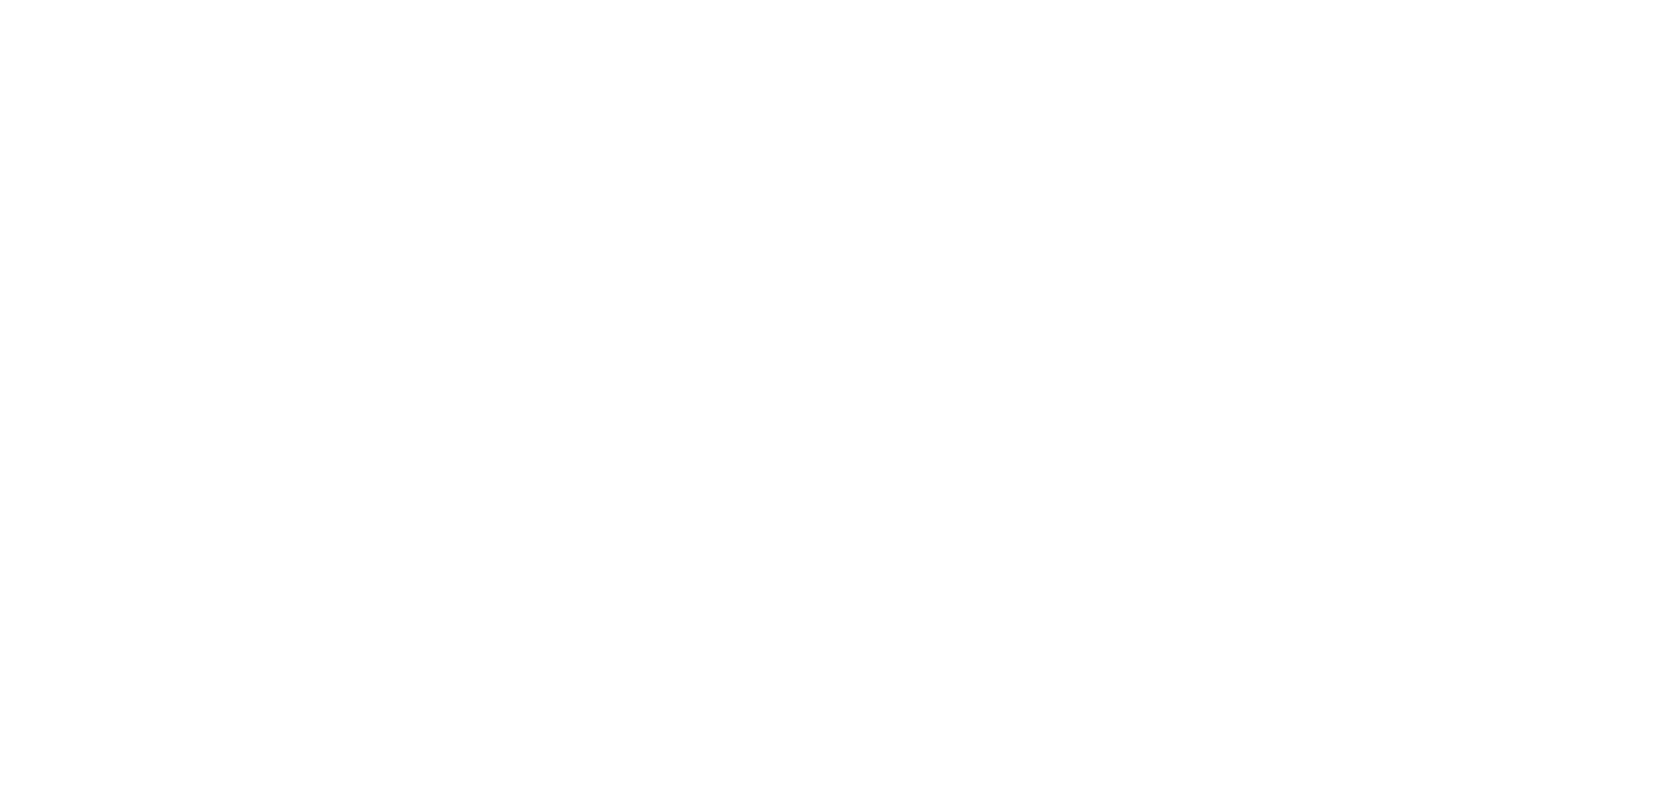

roi98_temporal.png


<IPython.core.display.Javascript object>


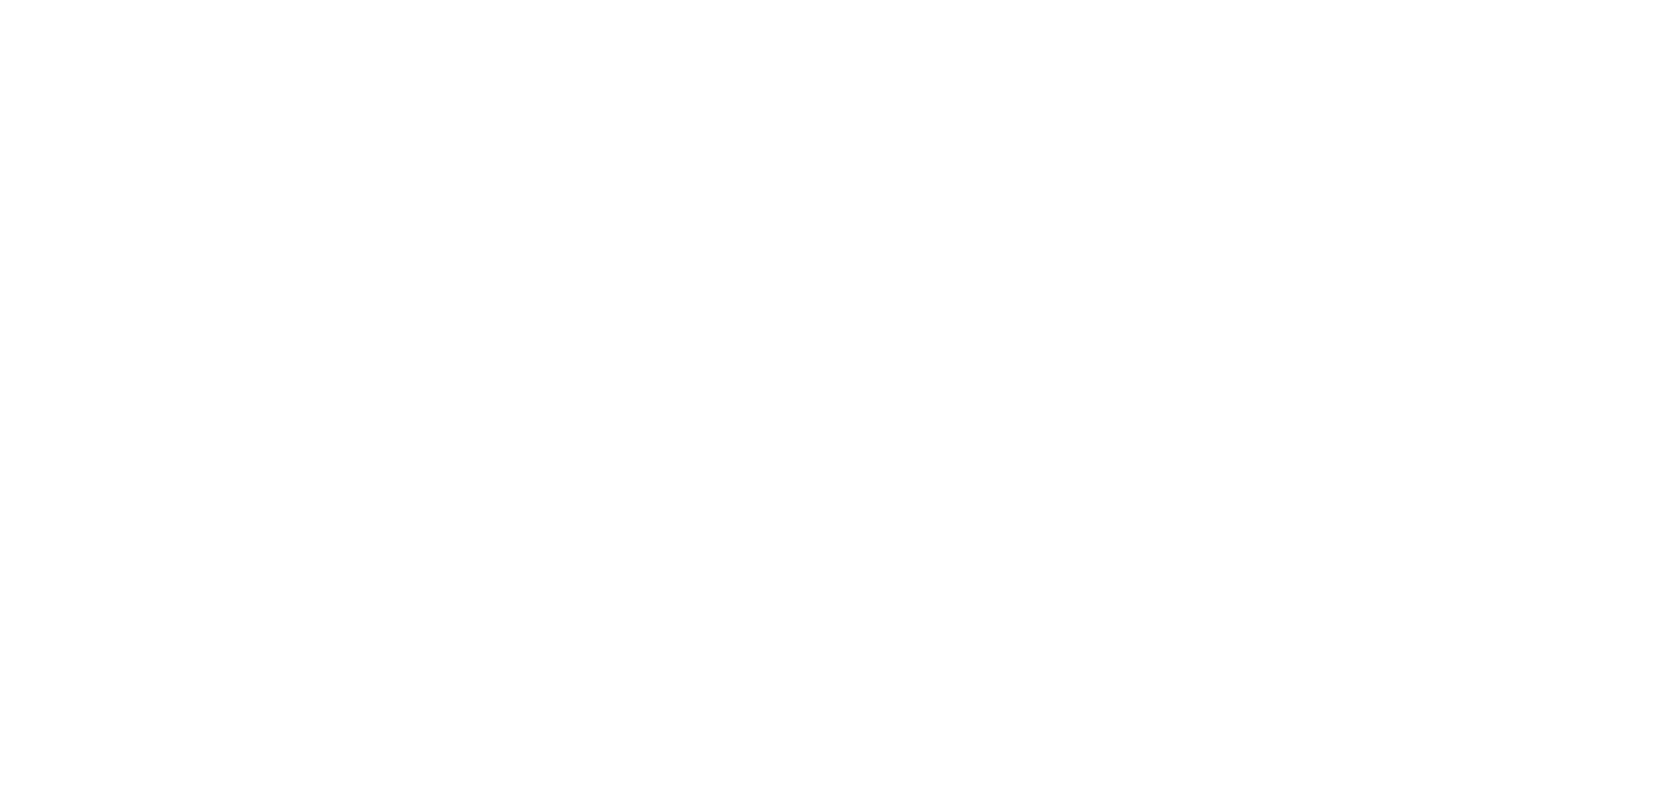

roi99_temporal.png


<IPython.core.display.Javascript object>


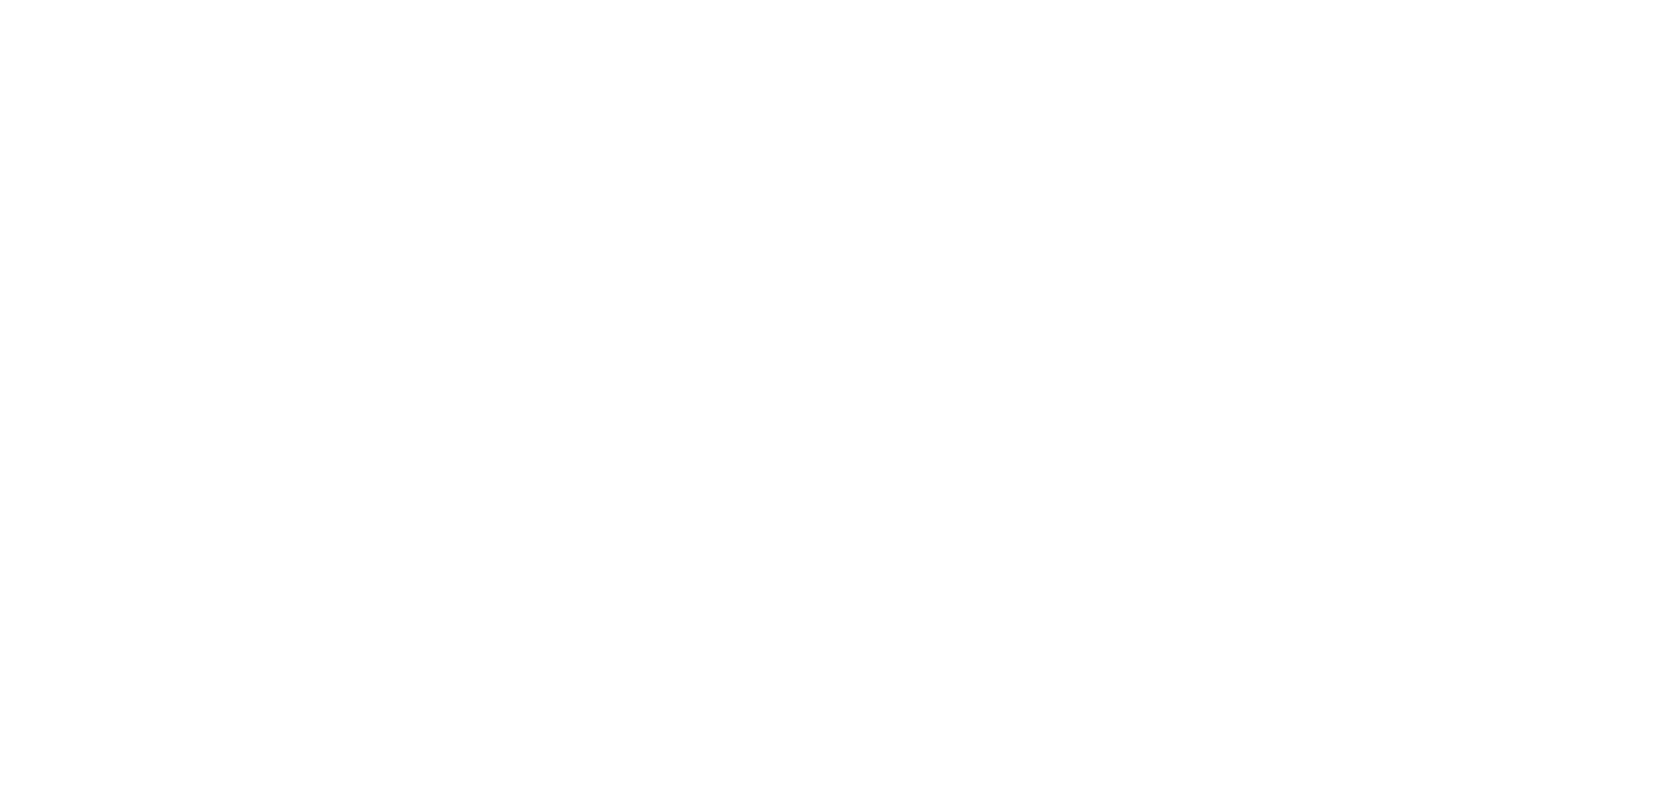

roi100_temporal.png


<IPython.core.display.Javascript object>


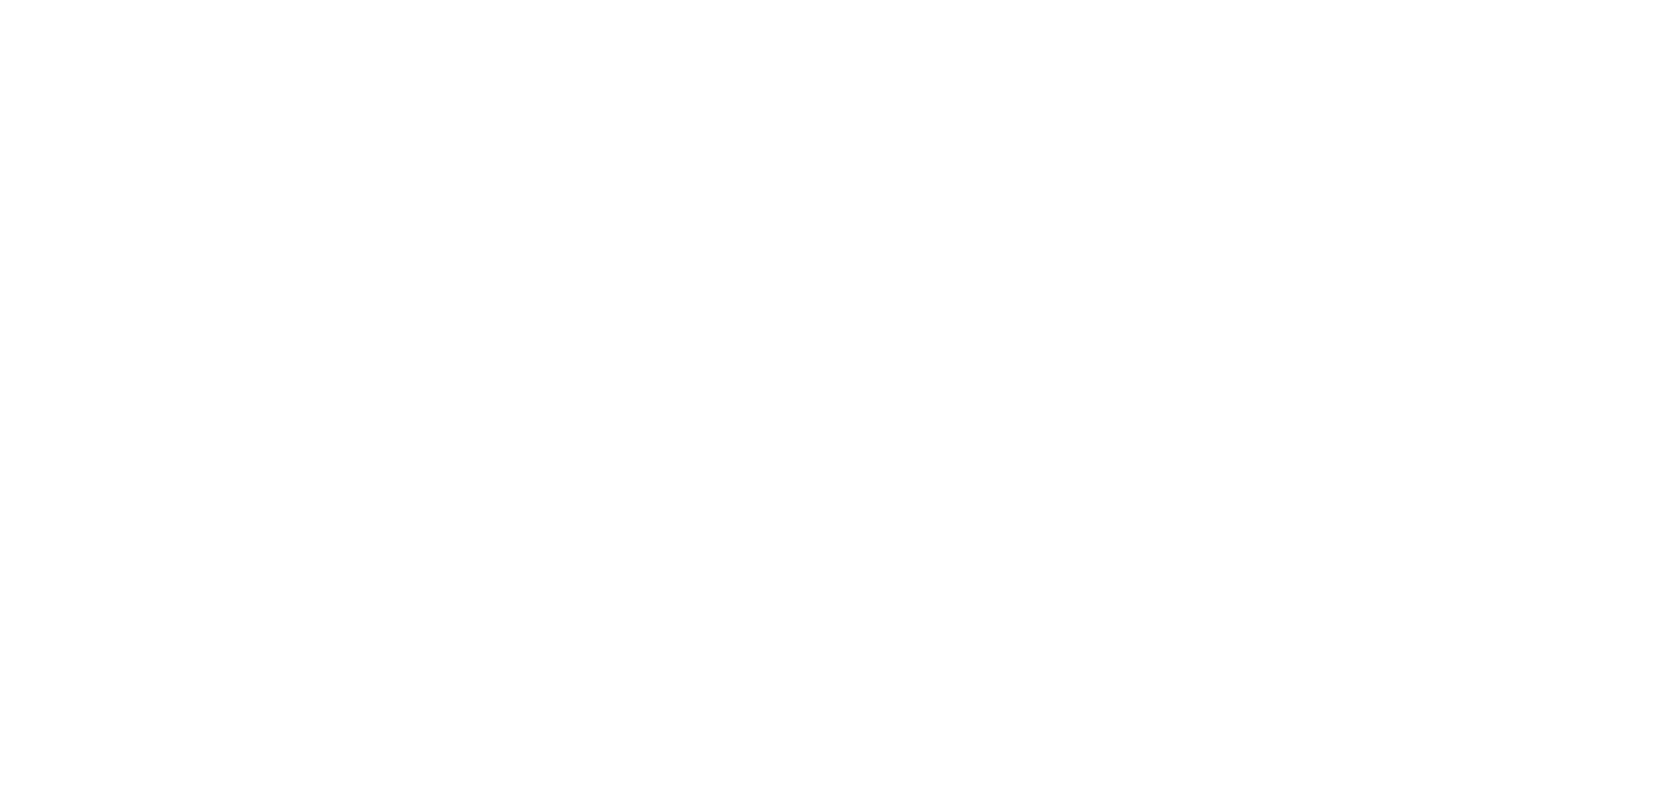

roi101_temporal.png


<IPython.core.display.Javascript object>


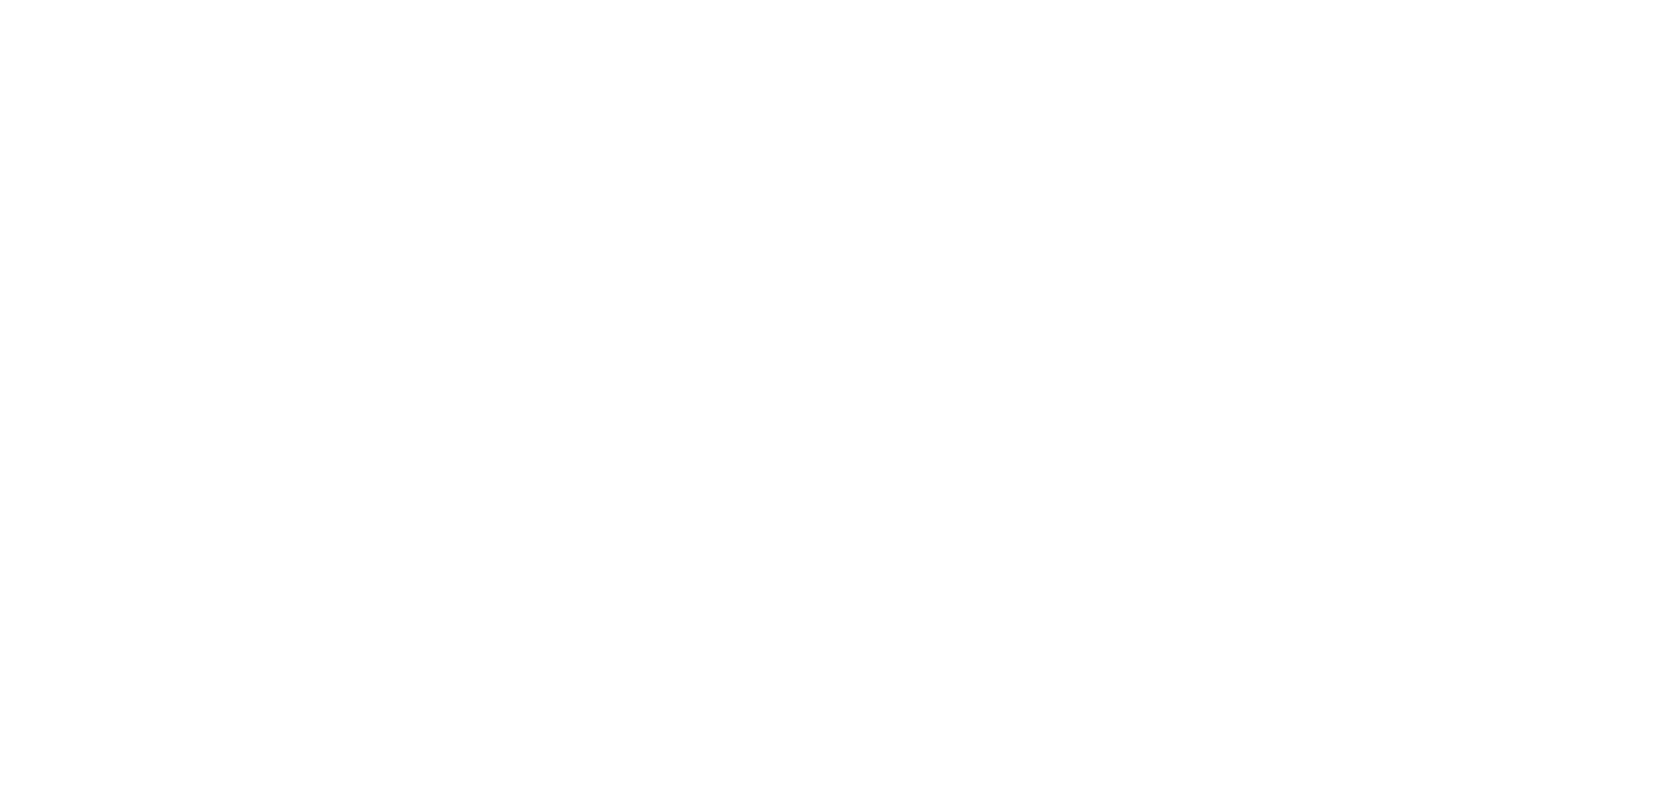

roi102_temporal.png


<IPython.core.display.Javascript object>


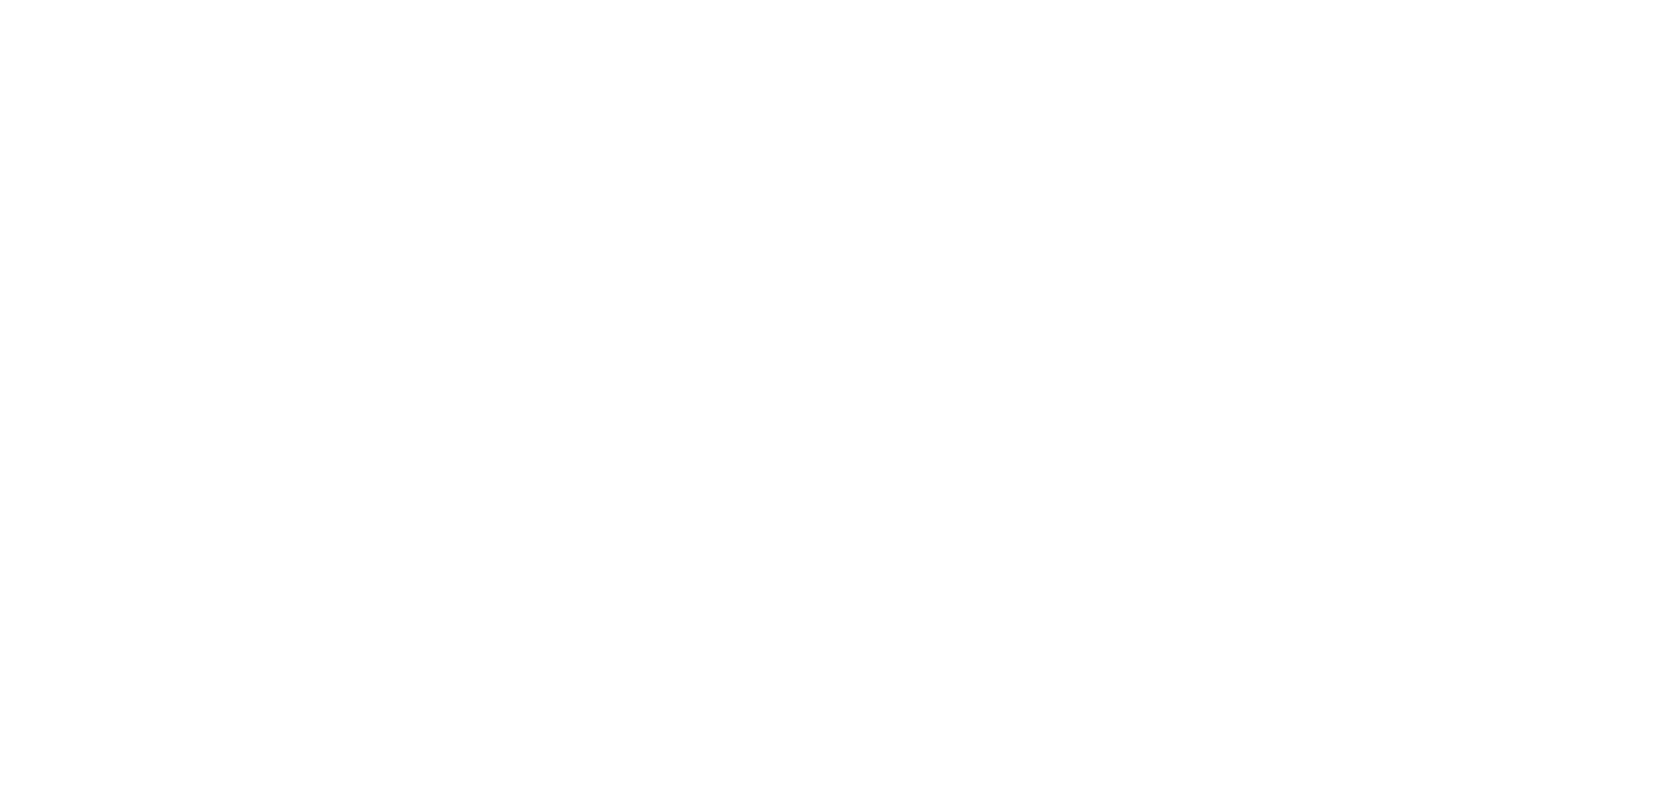

roi103_temporal.png


<IPython.core.display.Javascript object>


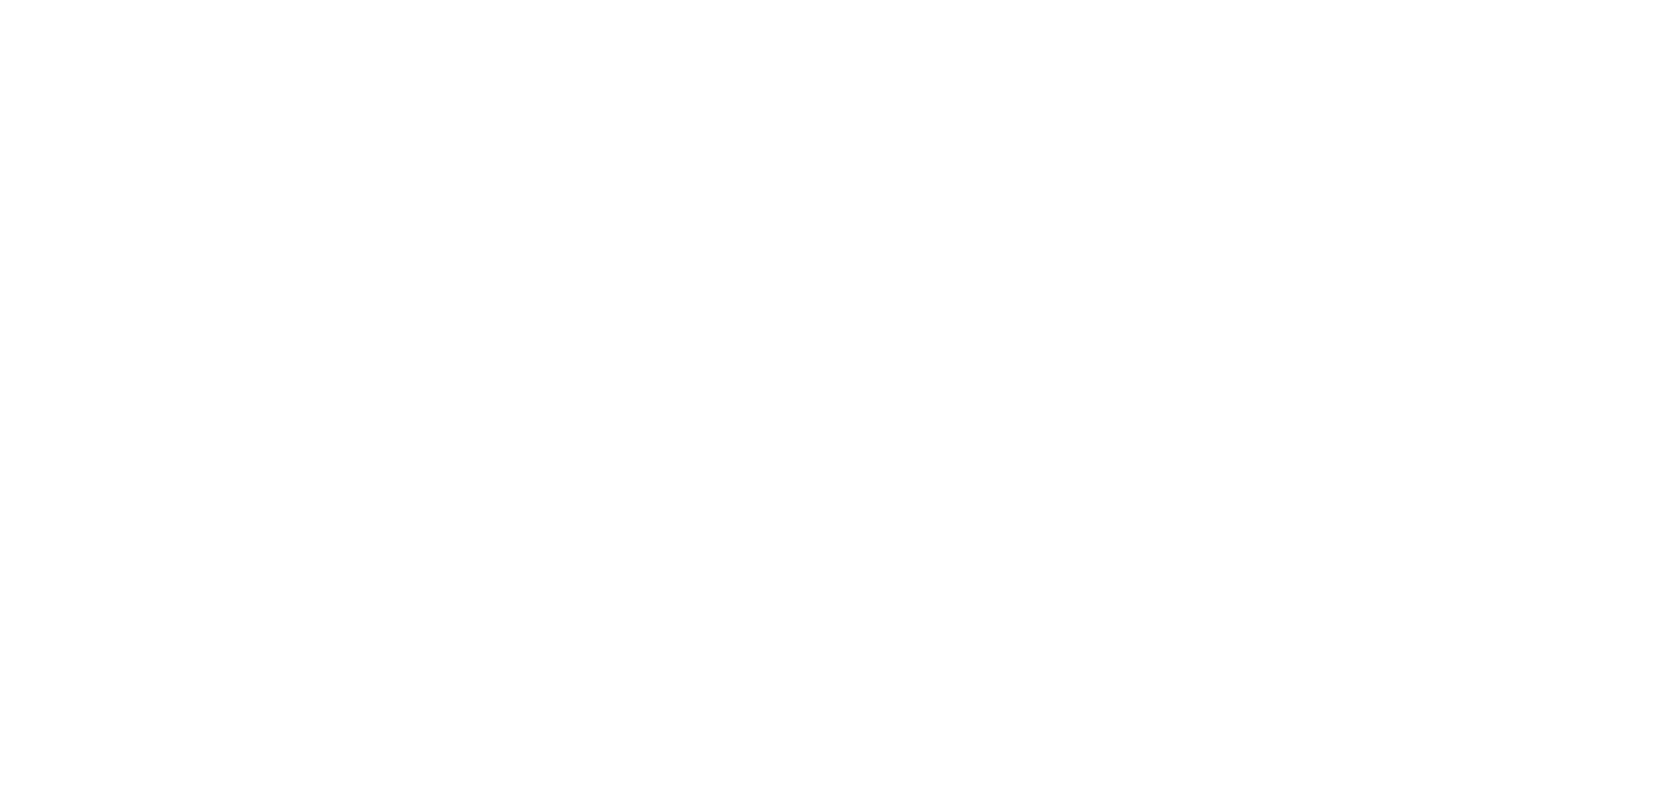

roi104_temporal.png


<IPython.core.display.Javascript object>


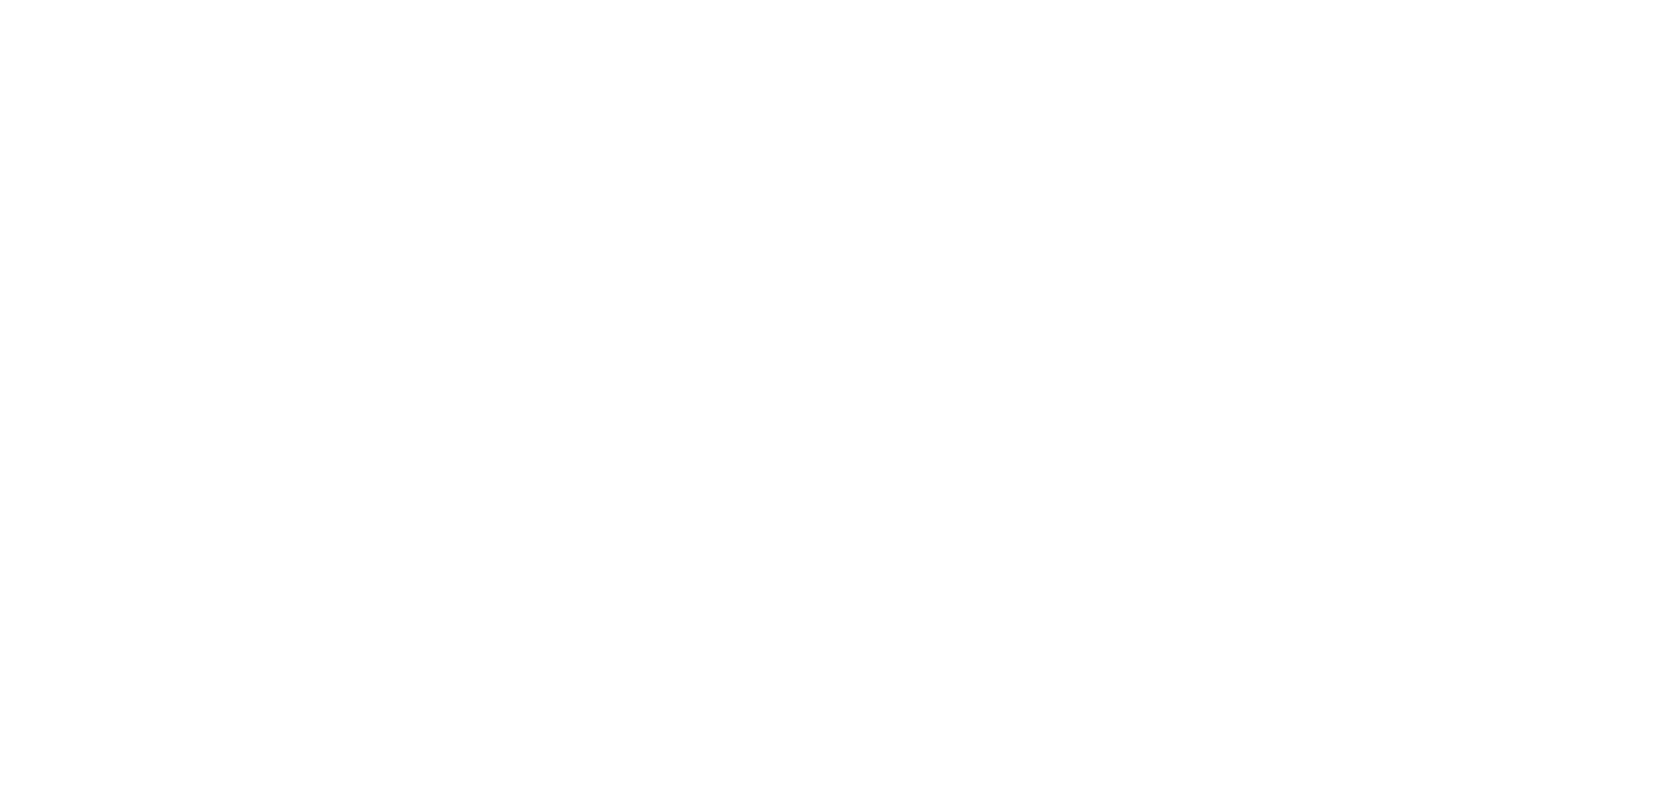

roi105_temporal.png


<IPython.core.display.Javascript object>


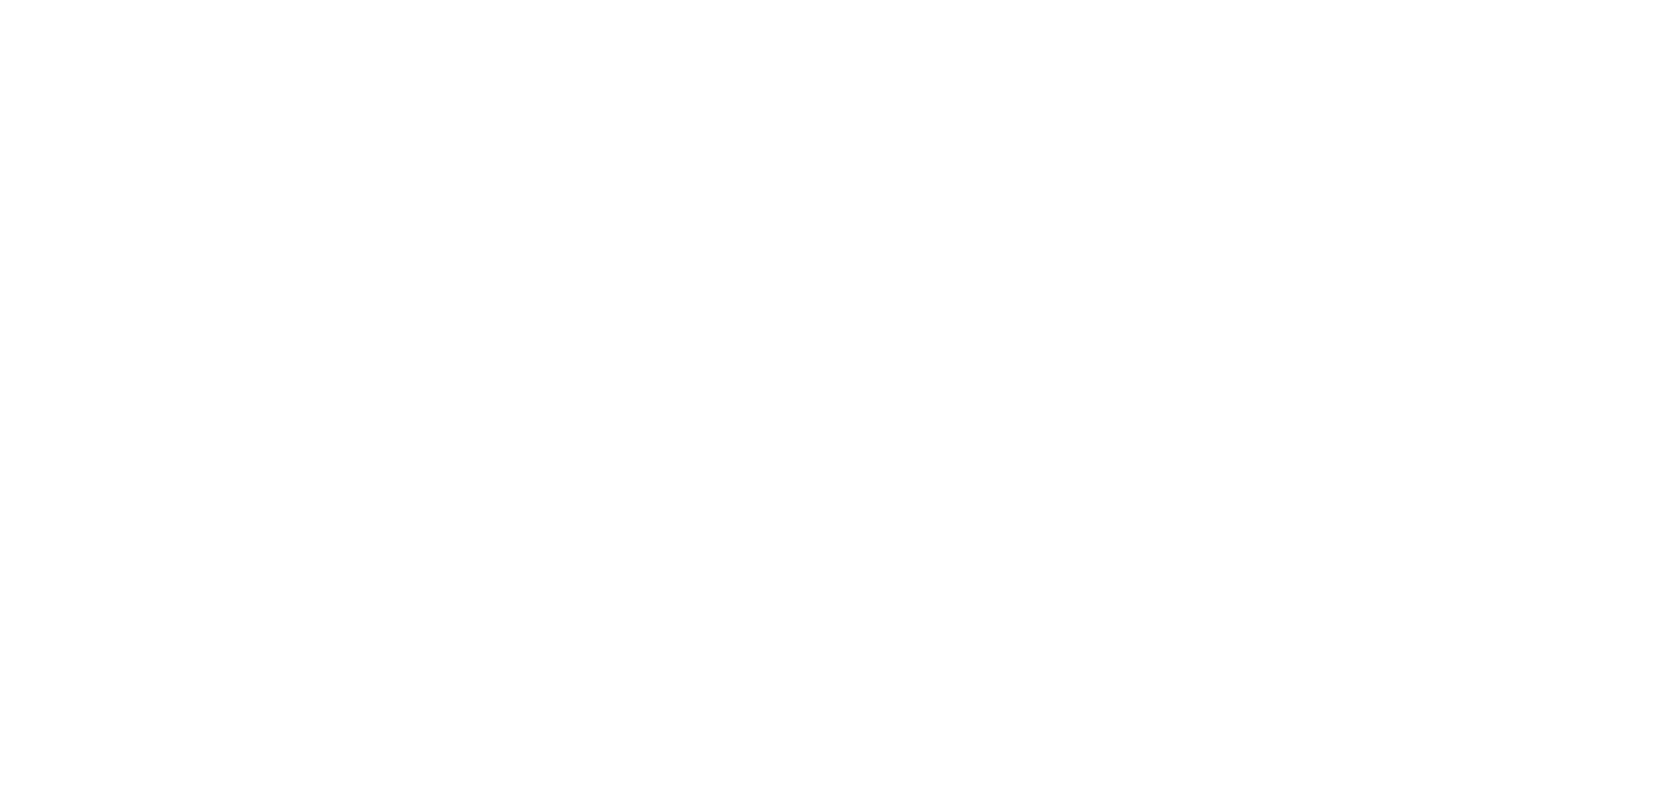

roi106_temporal.png


<IPython.core.display.Javascript object>


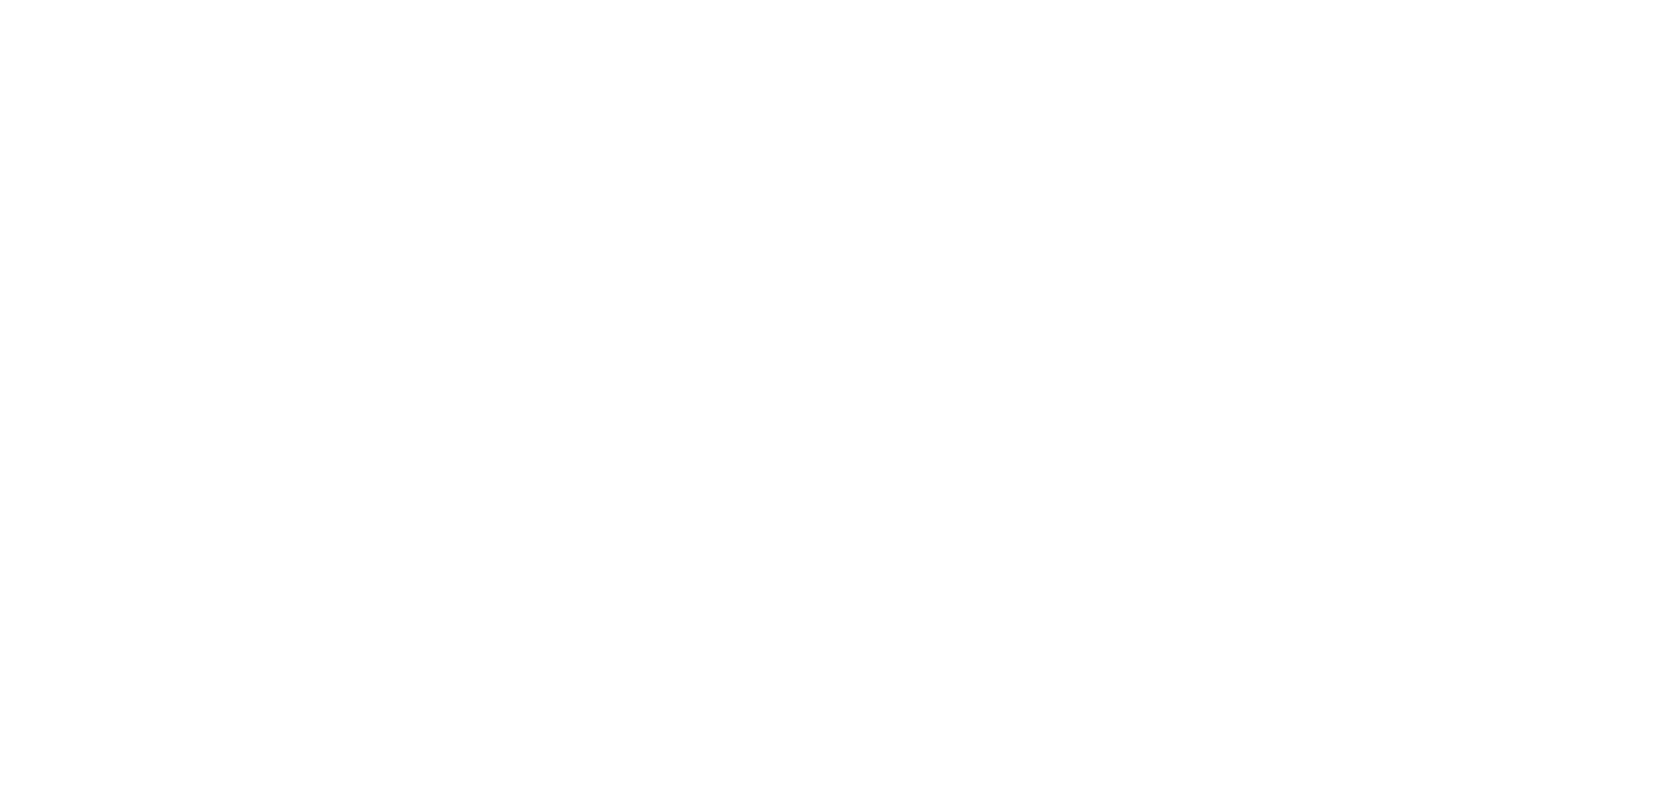

roi107_temporal.png


<IPython.core.display.Javascript object>


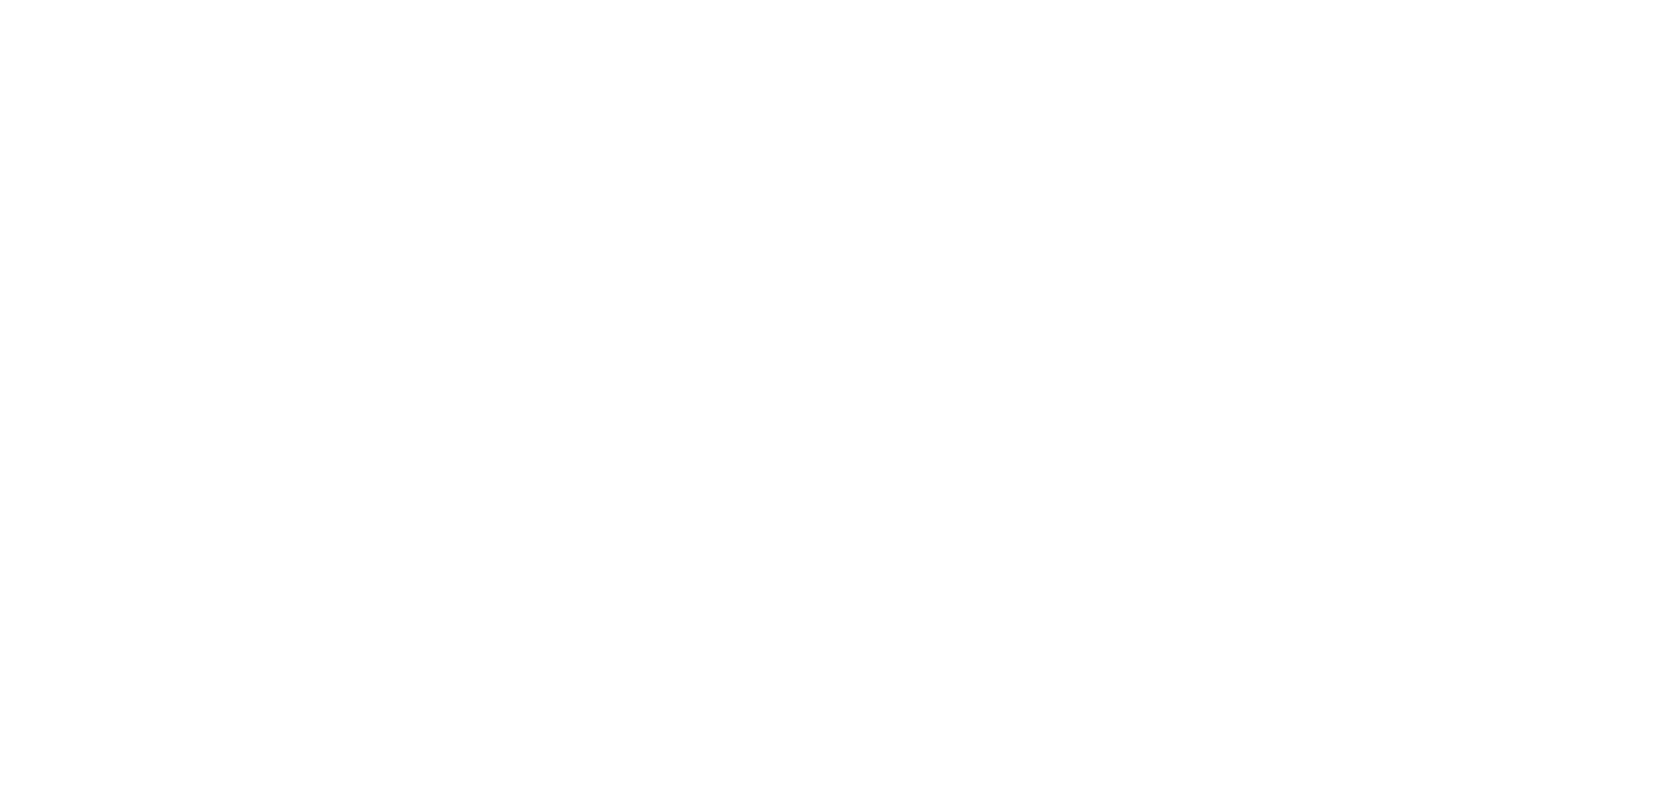

roi108_temporal.png


<IPython.core.display.Javascript object>


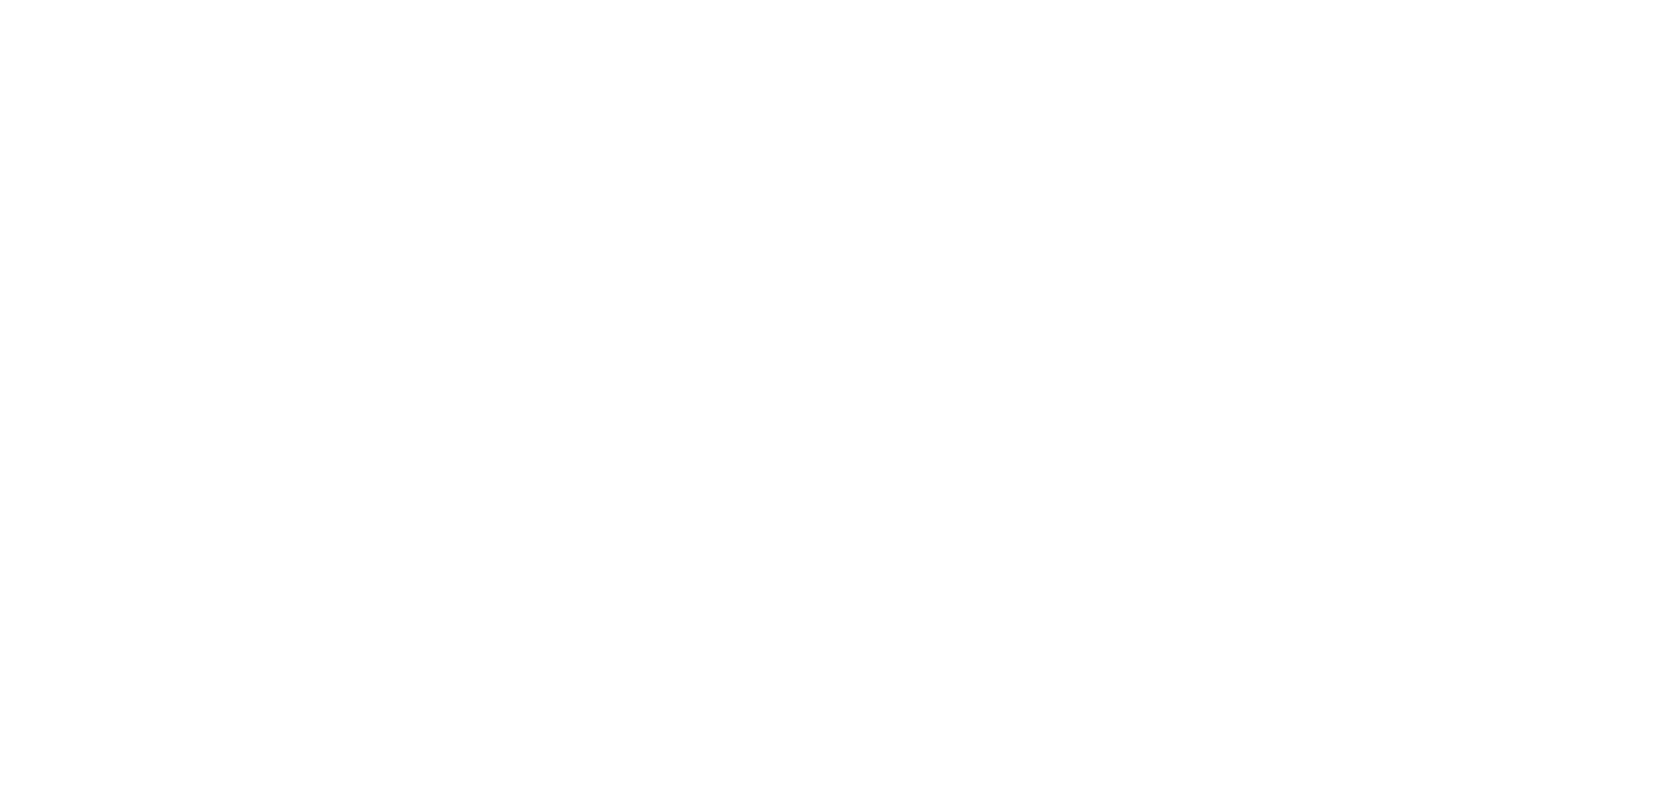

roi109_temporal.png


<IPython.core.display.Javascript object>


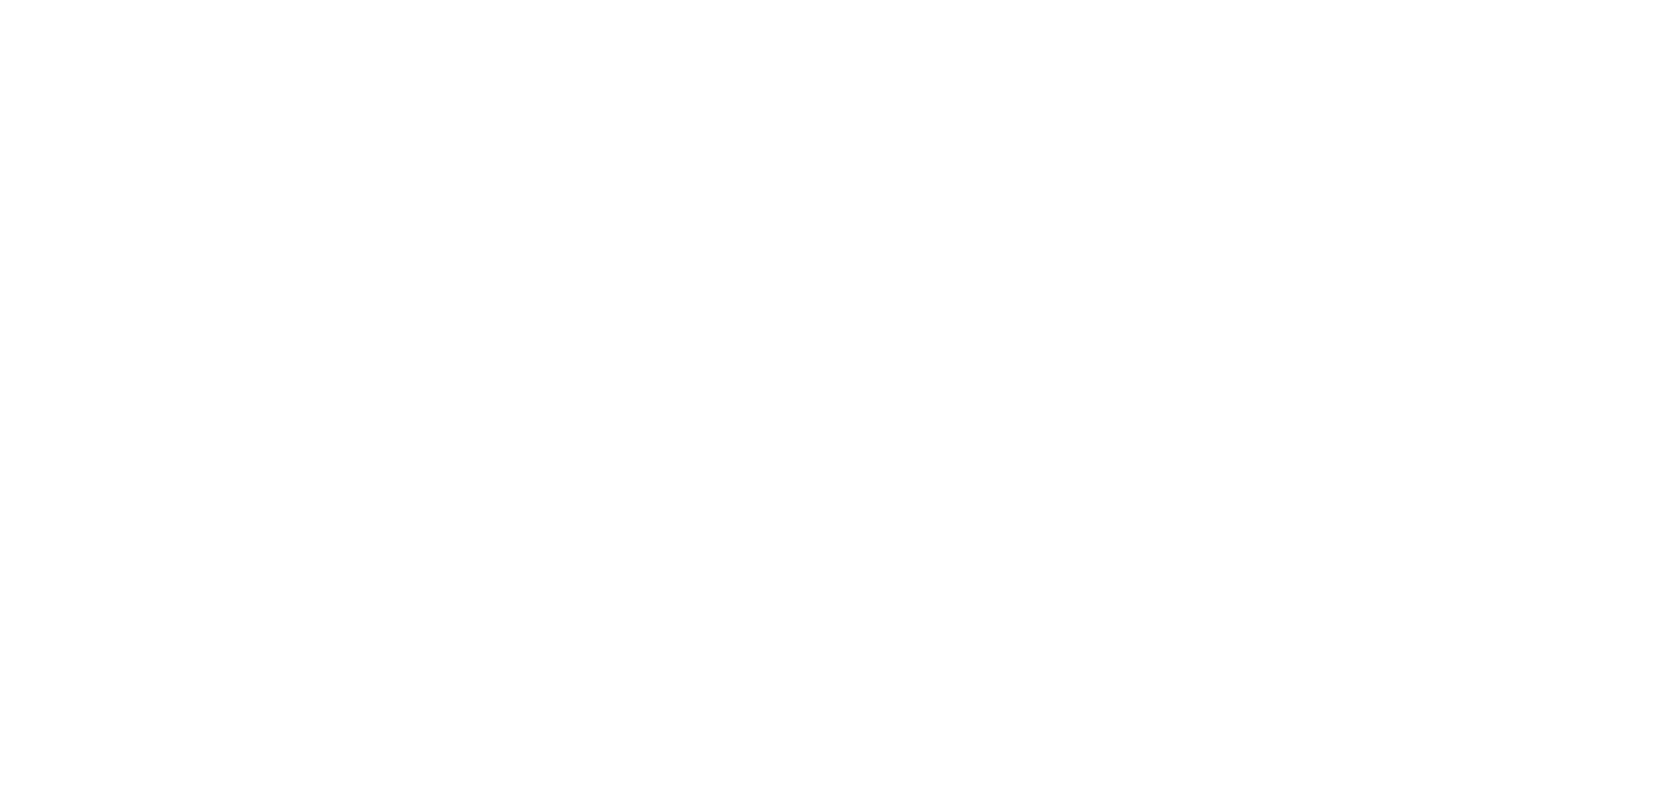

roi110_temporal.png


<IPython.core.display.Javascript object>


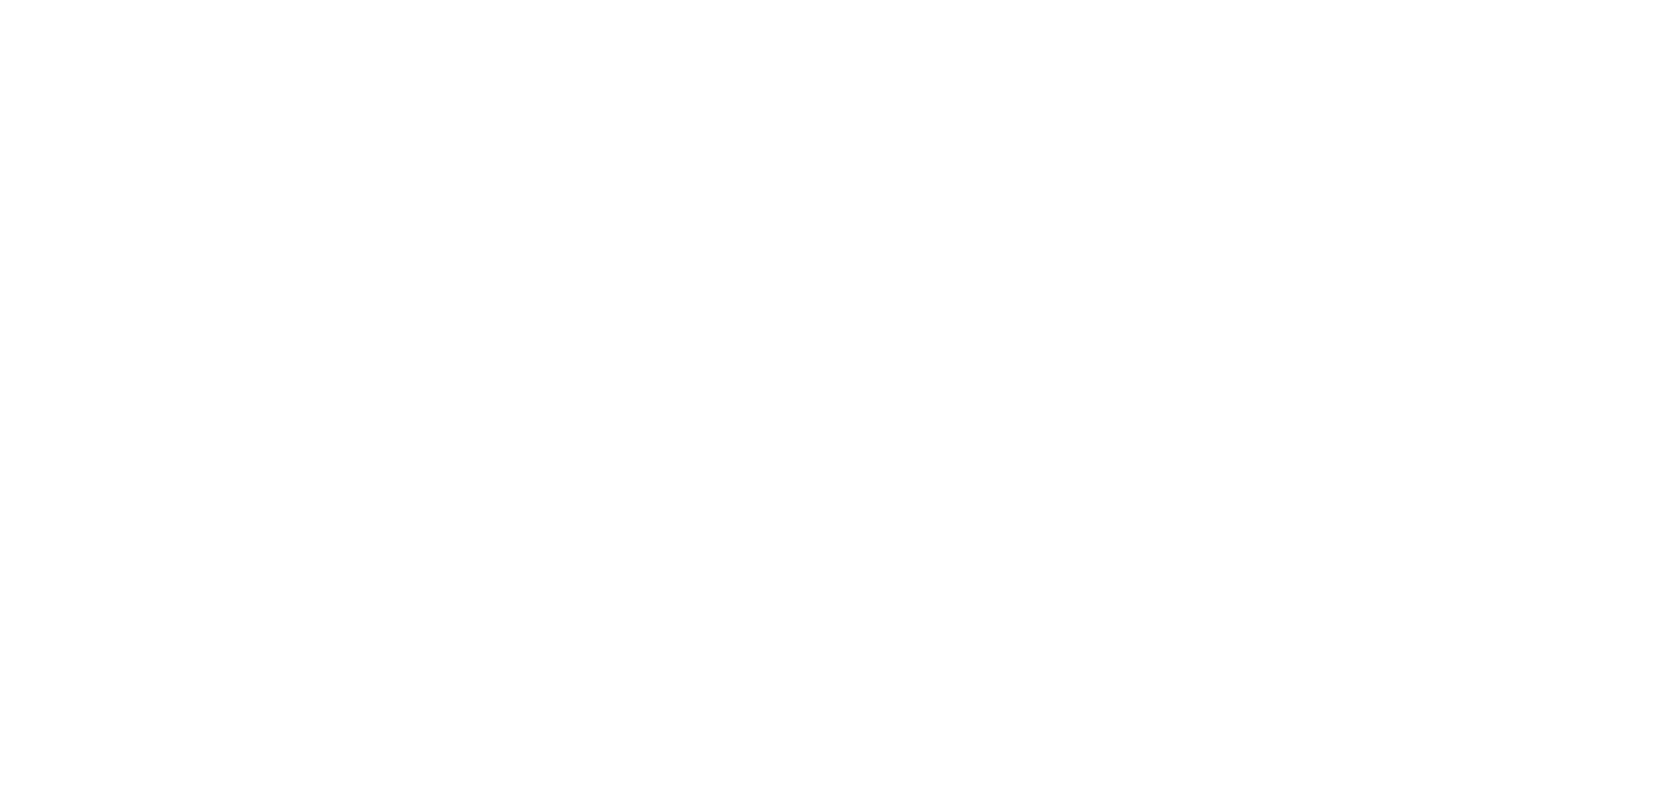

roi111_temporal.png


<IPython.core.display.Javascript object>


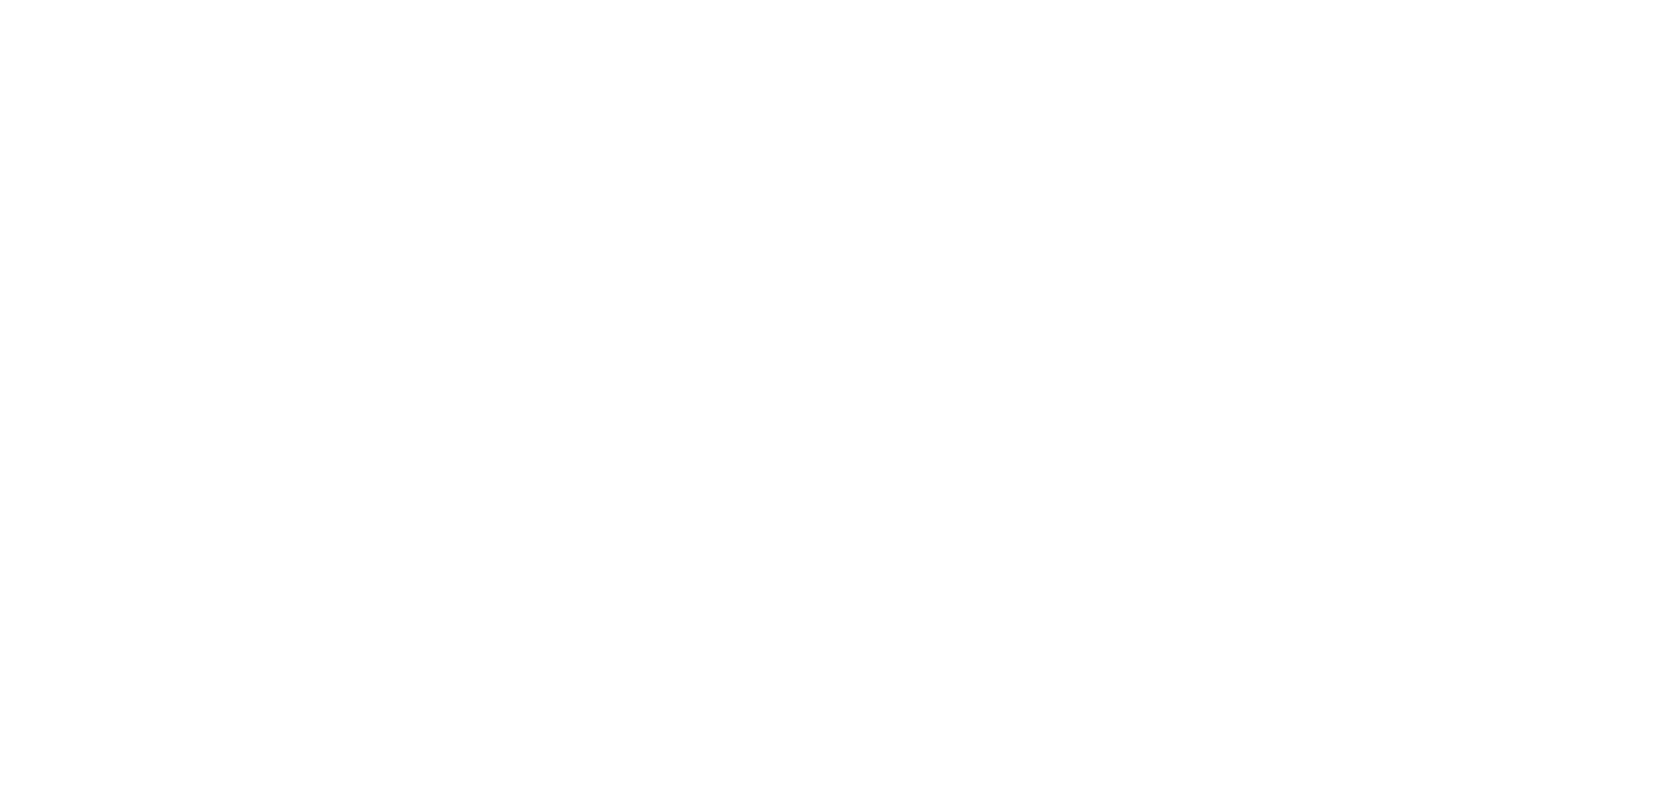

roi112_temporal.png


<IPython.core.display.Javascript object>


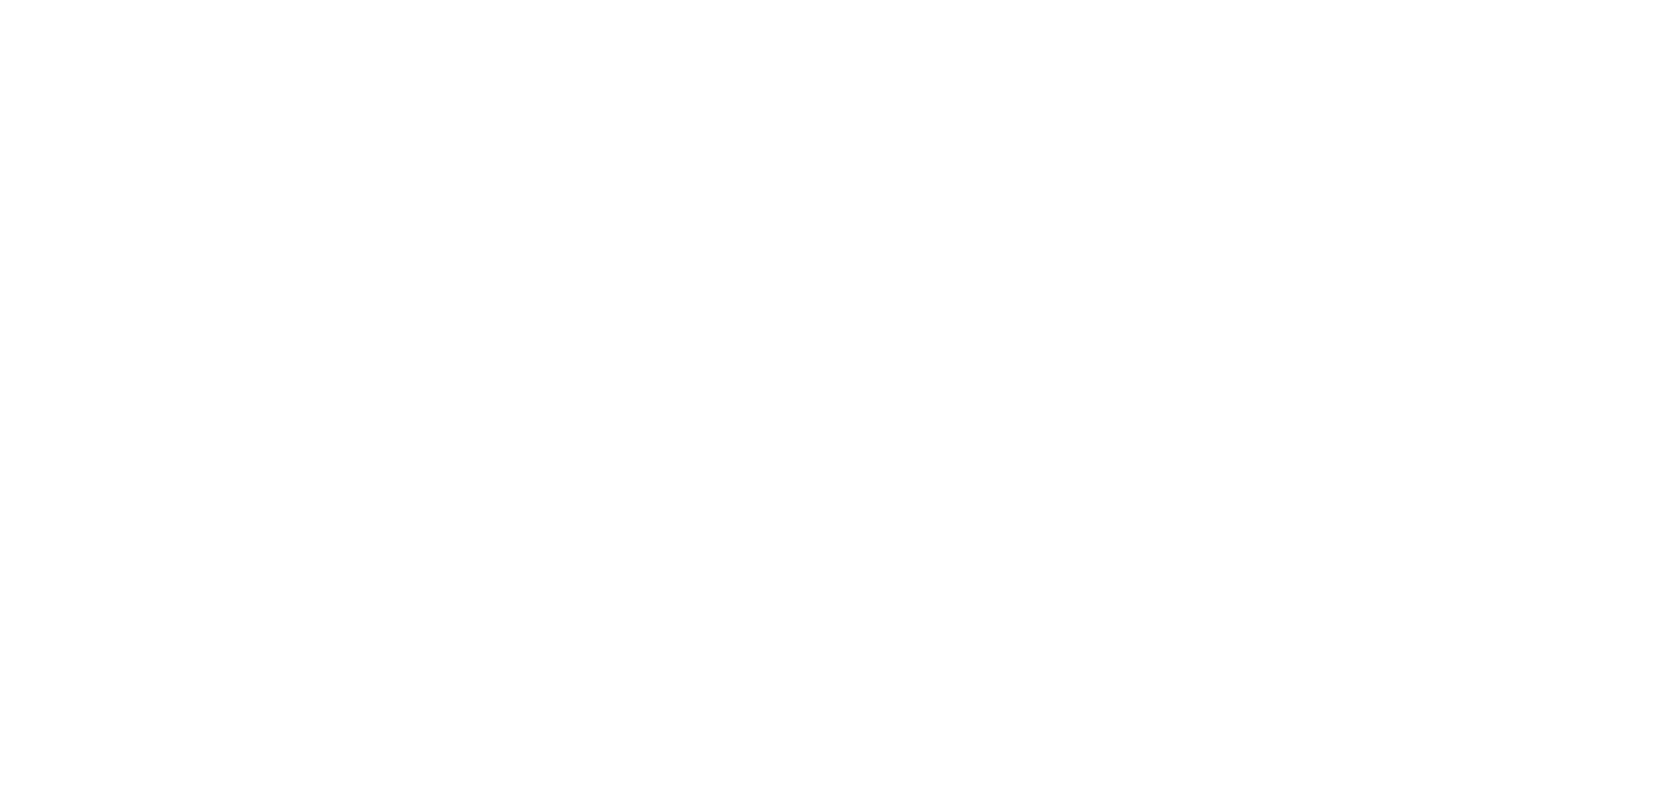

roi113_temporal.png


<IPython.core.display.Javascript object>


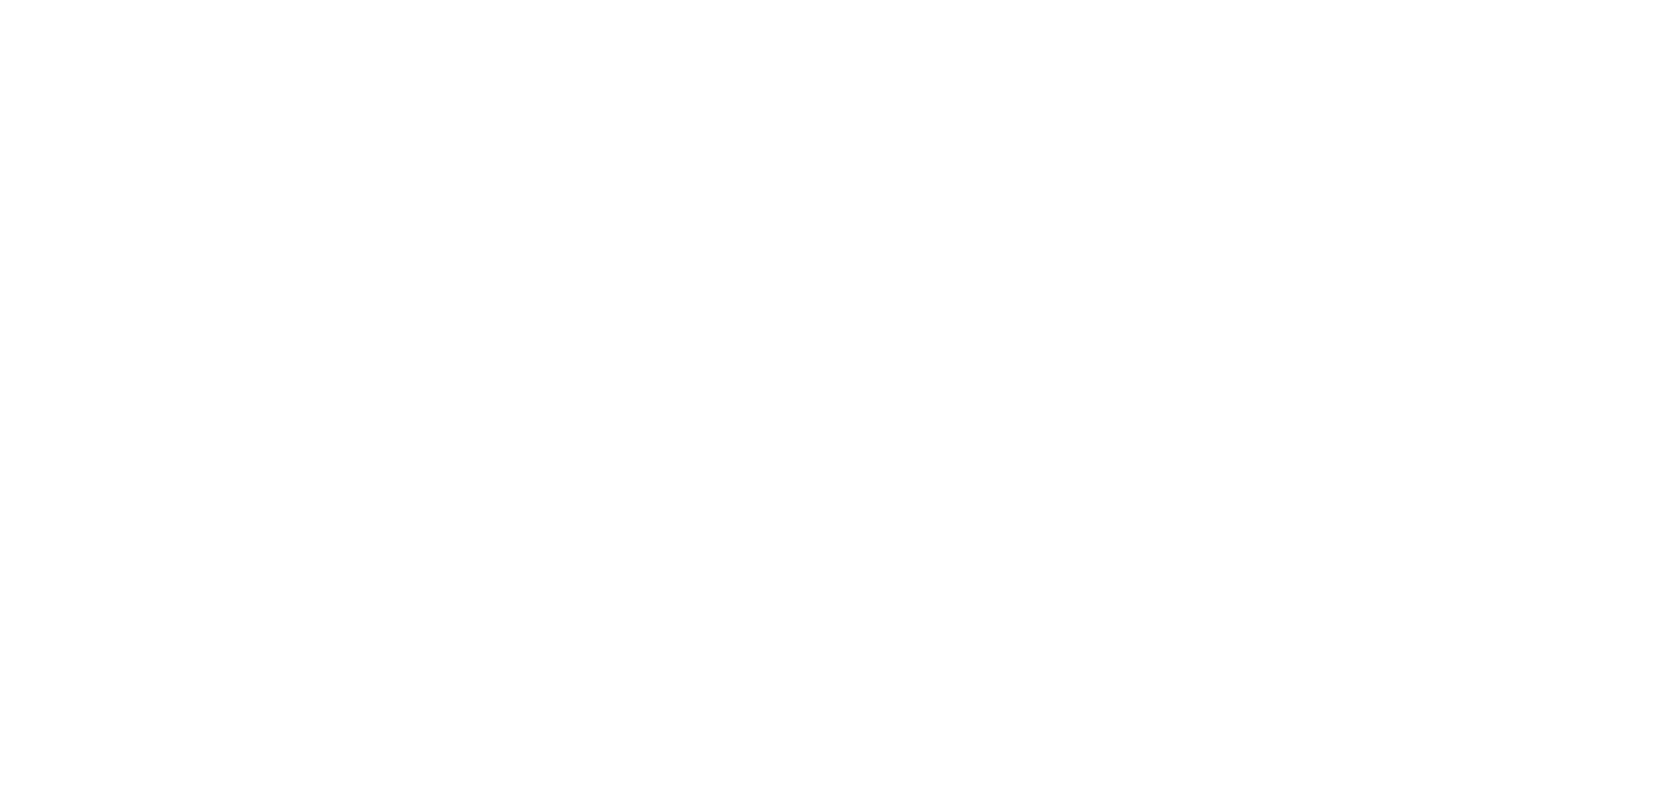

roi114_temporal.png


<IPython.core.display.Javascript object>

In [ ]:
for rid in range(nrois):
    trace_array = extracted_traces[rid, :].reshape(nfiles, nframes_per_file, order='C')
    all_frames = np.hstack(np.array([trace_array[fi, np.hstack(ixs.values.T)]\
                            for fi, ixs in sorted(tframes.items(), key=lambda x: x[0])]))
    rdata = labels_c.copy()
    rdata['trace'] = all_frames #manual[rid]

    meandfs = []
    for k, g in rdata.groupby(['config']):
        mean_trace = g.groupby(['trial'])[ylabel].apply(np.array).mean(axis=0)
        mean_tsec = g.groupby(['trial'])['tsec'].apply(np.array).mean(axis=0)
        sem_trace = stats.sem(np.vstack(g.groupby(['trial'])[ylabel].apply(np.array)), axis=0)
        mdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                            'tsec': mean_tsec,
                            'sem': sem_trace,
                            'fill_minus': mean_trace - sem_trace,
                            'fill_plus': mean_trace + sem_trace,
                            'config': [k for _ in range(len(mean_trace))]})
        for p in plot_params.values():
            mdf[p] = [round(sdf[p][cfg], 1) if isinstance(sdf[p][cfg], (float)) else sdf[p][cfg] for cfg in mdf['config']]
        meandfs.append(mdf)

    meandfs = pd.concat(meandfs, axis=0)

    # plot
    p = sns.FacetGrid(meandfs, col=plot_params['cols'], row=plot_params['rows'], 
                      hue=plot_params['hue'], size=2, legend_out=True, palette=palette)

    p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5) 
    p = (p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1).add_legend())  
    p = p.set_titles(col_template="{col_name}", size=5)      
    pl.subplots_adjust(wspace=0.8, hspace=0.8, top=0.8, bottom=0.1, left=0.1, right=0.9)

    
    start_val = 0.0
    end_val = mdf['tsec'][stim_on + int(round(nframes_on))]
    for ri in range(p.axes.shape[0]):
        for ci in range(p.axes.shape[1]):
            ymin, ymax = p.axes[ri, ci].get_ylim()
            p.axes[ri, ci].add_patch(patches.Rectangle((start_val, ymin), end_val, ymax, linewidth=0, fill=True, color='k', alpha=0.2))

    p.fig.suptitle('roi %i' % int(rid+1))
    figname = 'roi%i_temporal.png' % int(rid+1)
    pl.savefig(os.path.join(psth_dir, figname))
    print(figname)
    pl.close()


<IPython.core.display.Javascript object>


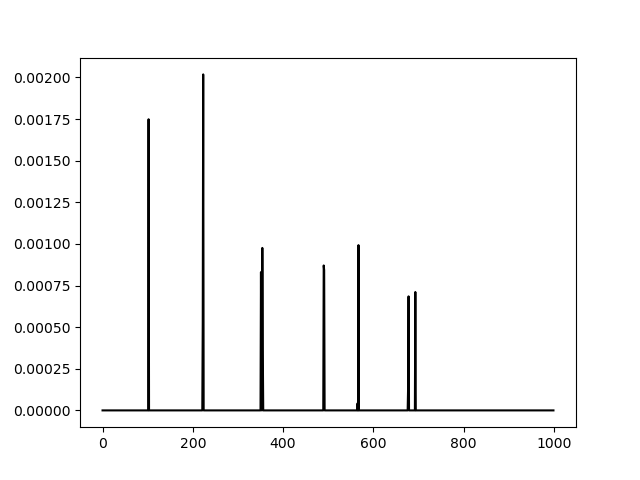

In [909]:
pl.figure()
pl.plot(cnm.estimates.S[11][0:1000], 'k')


In [ ]:
cnm.estimates.C[rid]

In [24]:
cnm.estimates.

In [751]:
import caiman as cm

In [753]:
# Load memmap file
#fname_tots = glob.glob(os.path.join(results_dir, 'memmap', '%s_*.mmap' % prefix))
fname_tots = glob.glob(os.path.join(results_dir, 'memmap', '*gratings-downsample-1-mcorrected_*.mmap'))[0]
print(fname_tots)

# Load images
Yr, dims, T = cm.load_memmap(fname_tots)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/memmap/JC084-20190522-FOV1_zoom2p0x-gratings-downsample-1-mcorrected_d1_512_d2_512_d3_1_order_C_frames_142910_.mmap


In [761]:
avg = images.mean(axis=0)

In [762]:
avg.shape

(512, 512)

<IPython.core.display.Javascript object>


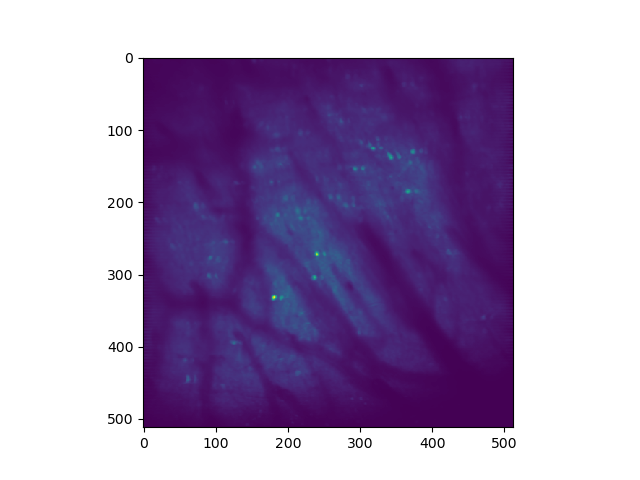

In [763]:
pl.figure()
pl.imshow(avg)

<IPython.core.display.Javascript object>


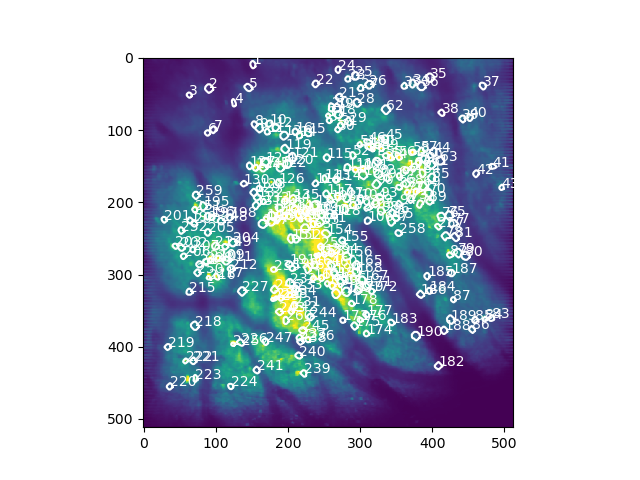

In [764]:
cnm.estimates.plot_contours(img=avg

In [765]:
results_fpath

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/caiman_results/gratings/seed-cnm_seeded-gratings-downsample-1-mcorrected_results.hdf5'